In [0]:
import tensorflow as tf

In [0]:
!pip install pillow
!pip install lxml
!pip install Cython
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install opencv-python
!pip install tensorflow

In [0]:
#cloning object detection models from tensorflow github
!git clone https://github.com/tensorflow/models/
#%cd setting directory
%cd /content/models/research/object_detection

In [0]:
#making training, inference_graph, train image, and test image directories
!mkdir training
!mkdir inference_graph
!mkdir -p images/train
!mkdir -p images/test

In [0]:
#wget = get from the web
#tar -xvzf = x – extract the archive, z – using gzip compression, v – verbal, displaying information about the archive while archiving, f – using an archive file
#rm -rf = remove file
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
!tar -xvzf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
!rm -rf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

In [0]:
#import operating system library
#setting environmental variables (variables that can be applied to multiple applications/processes in Linux)
import os
os.environ['PYTHONPATH'] = "{}/content/obj_detect_api/models:/content/obj_detect_api/models/research:/content/obj_detect_api/models/research/slim".format(os.environ['PYTHONPATH'])

In [7]:
#%cd.. = change directory back a step
%cd ..
!protoc ./object_detection/protos/*.proto --python_out=.

/content/models/research


In [8]:
#what version of protoc are we using?
!protoc --version

libprotoc 3.0.0


In [0]:
!python3 setup.py build
!python3 setup.py install

Example Object Detector

In [0]:
import numpy as np
import os
import sys
import tarfile
from PIL import Image
import tensorflow as tf
import six.moves.urllib as urllib
from matplotlib import pyplot as plt
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection','data', 'mscoco_label_map.pbtxt')

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

Show images with bounding boxes and labels

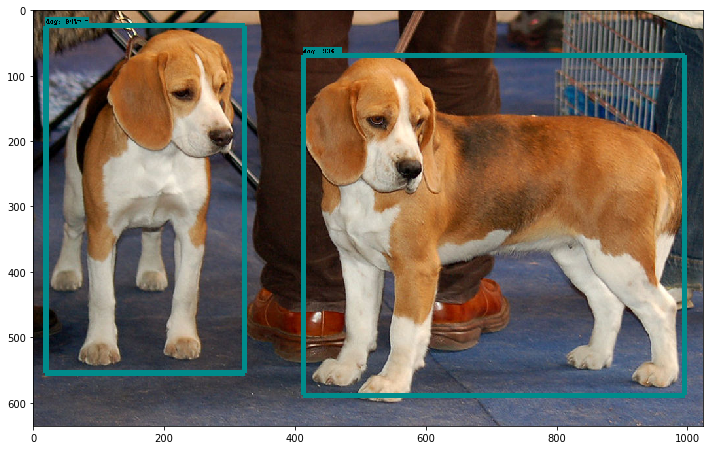

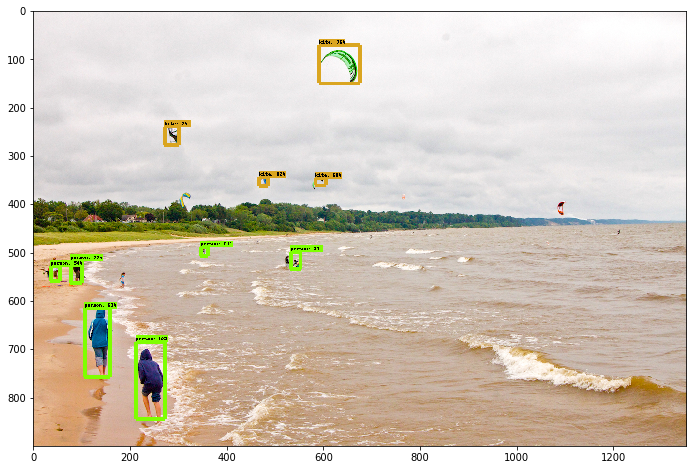

In [11]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=(IMAGE_SIZE))
  plt.imshow(image_np)

Now to create my own object detector

Steps:
1. Gather data (get images, label images, create xml file)
2. Obtain model to train (faster inception v2)
3. Train model
4. Test model 

**use labelimg software to label train and validation images**

In [0]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

#function to convert xml file to csv
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [14]:
for folder in ['/content/train/xml/', '/content/val/xml/']:
    image_path = os.path.join(os.getcwd(), (folder))
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv((str(folder) + '_labels.csv'), index=None)
    print('Successfully converted xml to csv.')

Successfully converted xml to csv.
Successfully converted xml to csv.


Look at train/val csv files

In [0]:
import pandas as pd
from pandas import DataFrame, Series

In [0]:
traindf = pd.read_csv('/content/train/xml_labels.csv')
valdf = pd.read_csv('/content/val/xml_labels.csv')

In [17]:
traindf

,filename,width,height,class,xmin,ymin,xmax,ymax
0,speedLimit3519.jpg,316,159,speedLimit35,142,16,170,57
1,stop3.jpg,300,168,stop,178,28,224,74
2,yield14.jpg,259,194,yield,90,51,103,64
3,yield18.jpg,310,163,yield,134,5,166,47
4,speedLimit3518.jpg,276,183,speedLimit35,203,37,235,78
5,stop15.jpg,2400,1400,stop,932,540,1002,636
6,speedLimit305.jpg,225,225,speedLimit30,86,20,129,79
7,stop5.jpg,265,190,stop,179,53,213,86
8,yield12.jpg,279,180,yield,102,78,119,95
9,yield12.jpg,279,180,yield,214,31,236,50


In [18]:
%cd /content/

/content


In [19]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

def class_text_to_int(row_label):
    if row_label == 'speedLimit30':
        return 1
    elif row_label == 'speedLimit35':
        return 2
    elif row_label == 'stop':
        return 3
    elif row_label == 'yield':
        return 4
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))
        
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    
    return tf_example


def main():
    for item in ['val', 'train']:
      output_path = "{}.record".format(item)
      writer = tf.python_io.TFRecordWriter(output_path)
      path = os.path.join(os.getcwd(), "{}".format(item))
      examples = pd.read_csv("/content/{}/xml_labels.csv".format(item))
      grouped = split(examples, 'filename')
      for group in grouped:
          tf_example = create_tf_example(group, path)
          writer.write(tf_example.SerializeToString())

      writer.close()
      output_path = os.path.join(os.getcwd(), output_path)
      print('Successfully created the TFRecords: {}'.format(output_path))

main()

Successfully created the TFRecords: /content/val.record
Successfully created the TFRecords: /content/train.record


In [20]:
%%writefile /content/models/research/object_detection/training/labelmap.pbtxt
item {
  id: 1
  name: 'speedLimit30'
}

item {
  id: 2
  name: 'speedLimit35'
}

item {
  id: 3
  name: 'stop'
}

item {
  id: 4
  name: 'yield'
}

Overwriting /content/models/research/object_detection/training/labelmap.pbtxt


In [21]:
import os
test_path = "/content/models/research/object_detection/images/test"
len_dir = len(os.listdir(test_path))
print("{} images inside the {}".format(len_dir, test_path))

24 images inside the /content/models/research/object_detection/images/test


In [22]:
%%writefile /content/models/research/object_detection/training/faster_rcnn_inception_v2.config

model {
  faster_rcnn {
    num_classes: 4
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0002
          schedule {
            step: 900000
            learning_rate: .00002
          }
          schedule {
            step: 1200000
            learning_rate: .000002
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  #model we want to use (faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt)
  fine_tune_checkpoint: "/content/models/research/object_detection/faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt"
  from_detection_checkpoint: true
  load_all_detection_checkpoint_vars: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 2000 #originally 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}


train_input_reader: {
  tf_record_input_reader {
    #where train.record is located
    input_path: "/content/models/research/train.record"
  }
  #where labelmap.pbtxt is located
  label_map_path: "/content/models/research/object_detection/training/labelmap.pbtxt"
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  num_examples: 24
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/models/research/val.record"
  }
  label_map_path: "/content/models/research/object_detection/training/labelmap.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting /content/models/research/object_detection/training/faster_rcnn_inception_v2.config


In [23]:
%cd /content/models/research/object_detection
!cp -a ../slim/. .

/content/models/research/object_detection


In [24]:
#this takes forever to run (this is the training of the model)
%run legacy/train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2.config

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






Instructions for updating:
Use object_detection/model_main.py.


W0107 20:52:11.293802 140705476634496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/absl/app.py:250: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.


W0107 20:52:11.296263 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/train.py:91: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



W0107 20:52:11.304644 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/train.py:96: The name tf.gfile.Copy is deprecated. Please use tf.io.gfile.copy instead.



Instructions for updating:
Please switch to tf.train.create_global_step


W0107 20:52:11.315246 140705476634496 deprecation.py:323] From /content/models/research/object_detection/legacy/trainer.py:267: create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.create_global_step


W0107 20:52:11.327112 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/data_decoders/tf_example_decoder.py:182: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



W0107 20:52:11.329696 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/data_decoders/tf_example_decoder.py:197: The name tf.VarLenFeature is deprecated. Please use tf.io.VarLenFeature instead.



W0107 20:52:11.361544 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/builders/dataset_builder.py:64: The name tf.gfile.Glob is deprecated. Please use tf.io.gfile.glob instead.



W0107 20:52:11.369448 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/builders/dataset_builder.py:71: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.



W0107 20:52:11.371853 140705476634496 dataset_builder.py:72] num_readers has been reduced to 1 to match input file shards.


Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.


W0107 20:52:11.388386 140705476634496 deprecation.py:323] From /content/models/research/object_detection/builders/dataset_builder.py:86: parallel_interleave (from tensorflow.contrib.data.python.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.


Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


W0107 20:52:11.390604 140705476634496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/data/python/ops/interleave_ops.py:77: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


Instructions for updating:
Use `tf.data.Dataset.map()


W0107 20:52:11.430177 140705476634496 deprecation.py:323] From /content/models/research/object_detection/builders/dataset_builder.py:155: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


W0107 20:52:12.207302 140705476634496 deprecation.py:323] From /content/models/research/object_detection/builders/dataset_builder.py:43: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


W0107 20:52:12.226268 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/builders/dataset_builder.py:44: The name tf.add_to_collection is deprecated. Please use tf.compat.v1.add_to_collection instead.



W0107 20:52:12.237675 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/core/preprocessor.py:627: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.batch(batch_size)` (or `padded_batch(...)` if `dynamic_pad=True`).


W0107 20:52:12.286889 140705476634496 deprecation.py:323] From /content/models/research/object_detection/core/batcher.py:101: batch (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.batch(batch_size)` (or `padded_batch(...)` if `dynamic_pad=True`).


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0107 20:52:12.296827 140705476634496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/training/input.py:752: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0107 20:52:12.301036 140705476634496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/training/input.py:752: add_queue_runner (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0107 20:52:12.313587 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/core/prefetcher.py:51: The name tf.PaddingFIFOQueue is deprecated. Please use tf.queue.PaddingFIFOQueue instead.



W0107 20:52:12.326560 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/core/prefetcher.py:58: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.



W0107 20:52:12.335673 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:286: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.



W0107 20:52:12.339129 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/deployment/model_deploy.py:192: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0107 20:52:12.341376 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/deployment/model_deploy.py:192: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.



W0107 20:52:12.421325 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/core/preprocessor.py:2689: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.



Instructions for updating:
Please use `layer.__call__` method instead.


W0107 20:52:12.485999 140705476634496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/layers/python/layers/layers.py:2784: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0107 20:52:14.259528 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/core/anchor_generator.py:171: The name tf.assert_equal is deprecated. Please use tf.compat.v1.assert_equal instead.



INFO:tensorflow:Scale of 0 disables regularizer.


I0107 20:52:14.277502 140705476634496 regularizers.py:98] Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


I0107 20:52:14.305501 140705476634496 regularizers.py:98] Scale of 0 disables regularizer.


W0107 20:52:14.308286 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/predictors/convolutional_box_predictor.py:150: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:depth of additional conv before box predictor: 0


I0107 20:52:14.310119 140705476634496 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0107 20:52:14.383633 140705476634496 deprecation.py:323] From /content/models/research/object_detection/core/box_list_ops.py:174: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0107 20:52:15.082070 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/box_coders/faster_rcnn_box_coder.py:82: The name tf.log is deprecated. Please use tf.math.log instead.



W0107 20:52:15.137379 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/core/minibatch_sampler.py:85: The name tf.random_shuffle is deprecated. Please use tf.random.shuffle instead.



Instructions for updating:
box_ind is deprecated, use box_indices instead


W0107 20:52:15.396150 140705476634496 deprecation.py:506] From /content/models/research/object_detection/utils/spatial_transform_ops.py:419: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead


W0107 20:52:15.421651 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/meta_architectures/faster_rcnn_meta_arch.py:191: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.



Instructions for updating:
Use keras.layers.flatten instead.


W0107 20:52:16.019980 140705476634496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


INFO:tensorflow:Scale of 0 disables regularizer.


I0107 20:52:16.028246 140705476634496 regularizers.py:98] Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


I0107 20:52:16.061577 140705476634496 regularizers.py:98] Scale of 0 disables regularizer.


W0107 20:52:16.354329 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/core/losses.py:177: The name tf.losses.huber_loss is deprecated. Please use tf.compat.v1.losses.huber_loss instead.



W0107 20:52:16.358239 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/core/losses.py:183: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



W0107 20:52:16.419648 140705476634496 deprecation.py:323] From /content/models/research/object_detection/core/losses.py:350: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



W0107 20:52:16.676740 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:209: The name tf.losses.add_loss is deprecated. Please use tf.compat.v1.losses.add_loss instead.



W0107 20:52:16.679045 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/builders/optimizer_builder.py:157: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.



W0107 20:52:16.694141 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/builders/optimizer_builder.py:58: The name tf.train.MomentumOptimizer is deprecated. Please use tf.compat.v1.train.MomentumOptimizer instead.

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


W0107 20:52:18.680490 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:323: The name tf.check_numerics is deprecated. Please use tf.debugging.check_numerics instead.



W0107 20:52:21.791682 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:354: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



W0107 20:52:22.158408 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:356: The name tf.losses.get_losses is deprecated. Please use tf.compat.v1.losses.get_losses instead.



W0107 20:52:22.167093 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:360: The name tf.losses.get_total_loss is deprecated. Please use tf.compat.v1.losses.get_total_loss instead.



W0107 20:52:22.174462 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:369: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.



W0107 20:52:22.190288 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:372: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



W0107 20:52:22.192811 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/legacy/trainer.py:377: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



W0107 20:52:22.832580 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/utils/variables_helper.py:179: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Instructions for updating:
Please switch to tf.train.get_or_create_global_step


W0107 20:52:22.834829 140705476634496 deprecation.py:323] From /content/models/research/object_detection/meta_architectures/faster_rcnn_meta_arch.py:2768: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step


W0107 20:52:22.838932 140705476634496 module_wrapper.py:139] From /content/models/research/object_detection/utils/variables_helper.py:139: The name tf.train.NewCheckpointReader is deprecated. Please use tf.compat.v1.train.NewCheckpointReader instead.

W0107 20:52:22.845445 140705476634496 variables_helper.py:157] Variable [Conv/biases/Momentum] is not available in checkpoint
W0107 20:52:22.846807 140705476634496 variables_helper.py:157] Variable [Conv/weights/Momentum] is not available in checkpoint
W0107 20:52:22.848052 140705476634496 variables_helper.py:157] Variable [FirstStageBoxPredictor/BoxEncodingPredictor/biases/Momentum] is not available in checkpoint
W0107 20:52:22.849178 140705476634496 variables_helper.py:157] Variable [FirstStageBoxPredictor/BoxEncodingPredictor/weights/Momentum] is not available in checkpoint
W0107 20:52:22.850177 140705476634496 variables_helper.py:157] Variable [FirstStageBoxPredictor/ClassPredictor/biases/Momentum] is not available in checkpoint
W0107

Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession


W0107 20:52:24.088764 140705476634496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/slim/python/slim/learning.py:742: Supervisor.__init__ (from tensorflow.python.training.supervisor) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession


INFO:tensorflow:Restoring parameters from training/model.ckpt-0


I0107 20:52:24.811295 140705476634496 saver.py:1284] Restoring parameters from training/model.ckpt-0


Instructions for updating:
Use standard file utilities to get mtimes.


W0107 20:52:26.101106 140705476634496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/training/saver.py:1069: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


I0107 20:52:26.111224 140705476634496 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0107 20:52:26.508196 140705476634496 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Starting Session.


I0107 20:52:31.963976 140705476634496 learning.py:754] Starting Session.


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 20:52:32.259896 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Starting Queues.


I0107 20:52:32.276756 140705476634496 learning.py:768] Starting Queues.


INFO:tensorflow:global_step/sec: 0


I0107 20:52:42.077858 140703310690048 supervisor.py:1099] global_step/sec: 0


INFO:tensorflow:Recording summary at step 0.


I0107 20:52:42.257175 140703302297344 supervisor.py:1050] Recording summary at step 0.


INFO:tensorflow:global step 1: loss = 2.2324 (16.343 sec/step)


I0107 20:52:48.922586 140705476634496 learning.py:507] global step 1: loss = 2.2324 (16.343 sec/step)


INFO:tensorflow:global step 2: loss = 2.0115 (5.024 sec/step)


I0107 20:52:54.250120 140705476634496 learning.py:507] global step 2: loss = 2.0115 (5.024 sec/step)


INFO:tensorflow:global step 3: loss = 2.6504 (4.830 sec/step)


I0107 20:52:59.083033 140705476634496 learning.py:507] global step 3: loss = 2.6504 (4.830 sec/step)


INFO:tensorflow:global step 4: loss = 2.4336 (4.797 sec/step)


I0107 20:53:03.886971 140705476634496 learning.py:507] global step 4: loss = 2.4336 (4.797 sec/step)


INFO:tensorflow:global step 5: loss = 1.5026 (4.956 sec/step)


I0107 20:53:08.846838 140705476634496 learning.py:507] global step 5: loss = 1.5026 (4.956 sec/step)


INFO:tensorflow:global step 6: loss = 1.5751 (4.744 sec/step)


I0107 20:53:13.594067 140705476634496 learning.py:507] global step 6: loss = 1.5751 (4.744 sec/step)


INFO:tensorflow:global step 7: loss = 1.3215 (5.155 sec/step)


I0107 20:53:18.755062 140705476634496 learning.py:507] global step 7: loss = 1.3215 (5.155 sec/step)


INFO:tensorflow:global step 8: loss = 2.2761 (5.395 sec/step)


I0107 20:53:24.155806 140705476634496 learning.py:507] global step 8: loss = 2.2761 (5.395 sec/step)


INFO:tensorflow:global step 9: loss = 1.7752 (4.795 sec/step)


I0107 20:53:28.953644 140705476634496 learning.py:507] global step 9: loss = 1.7752 (4.795 sec/step)


INFO:tensorflow:global step 10: loss = 1.3780 (4.797 sec/step)


I0107 20:53:33.757594 140705476634496 learning.py:507] global step 10: loss = 1.3780 (4.797 sec/step)


INFO:tensorflow:global step 11: loss = 0.7576 (5.046 sec/step)


I0107 20:53:38.810941 140705476634496 learning.py:507] global step 11: loss = 0.7576 (5.046 sec/step)


INFO:tensorflow:global step 12: loss = 0.9170 (5.188 sec/step)


I0107 20:53:44.002534 140705476634496 learning.py:507] global step 12: loss = 0.9170 (5.188 sec/step)


INFO:tensorflow:global step 13: loss = 1.1486 (4.932 sec/step)


I0107 20:53:48.942348 140705476634496 learning.py:507] global step 13: loss = 1.1486 (4.932 sec/step)


INFO:tensorflow:global step 14: loss = 0.4627 (4.971 sec/step)


I0107 20:53:53.916824 140705476634496 learning.py:507] global step 14: loss = 0.4627 (4.971 sec/step)


INFO:tensorflow:global step 15: loss = 1.3343 (4.720 sec/step)


I0107 20:53:58.641365 140705476634496 learning.py:507] global step 15: loss = 1.3343 (4.720 sec/step)


INFO:tensorflow:global step 16: loss = 1.8956 (5.139 sec/step)


I0107 20:54:03.783205 140705476634496 learning.py:507] global step 16: loss = 1.8956 (5.139 sec/step)


INFO:tensorflow:global step 17: loss = 0.8764 (4.963 sec/step)


I0107 20:54:08.751934 140705476634496 learning.py:507] global step 17: loss = 0.8764 (4.963 sec/step)


INFO:tensorflow:global step 18: loss = 0.9364 (4.772 sec/step)


I0107 20:54:13.526786 140705476634496 learning.py:507] global step 18: loss = 0.9364 (4.772 sec/step)


INFO:tensorflow:global step 19: loss = 0.7197 (4.741 sec/step)


I0107 20:54:18.273250 140705476634496 learning.py:507] global step 19: loss = 0.7197 (4.741 sec/step)


INFO:tensorflow:global step 20: loss = 0.8288 (5.345 sec/step)


I0107 20:54:23.629053 140705476634496 learning.py:507] global step 20: loss = 0.8288 (5.345 sec/step)


INFO:tensorflow:global step 21: loss = 0.7892 (4.755 sec/step)


I0107 20:54:28.390510 140705476634496 learning.py:507] global step 21: loss = 0.7892 (4.755 sec/step)


INFO:tensorflow:global step 22: loss = 0.5711 (5.516 sec/step)


I0107 20:54:33.913473 140705476634496 learning.py:507] global step 22: loss = 0.5711 (5.516 sec/step)


INFO:tensorflow:Recording summary at step 22.


I0107 20:54:35.604855 140703302297344 supervisor.py:1050] Recording summary at step 22.


INFO:tensorflow:global_step/sec: 0.193733


I0107 20:54:35.636239 140703310690048 supervisor.py:1099] global_step/sec: 0.193733


INFO:tensorflow:global step 23: loss = 1.6967 (5.837 sec/step)


I0107 20:54:39.774757 140705476634496 learning.py:507] global step 23: loss = 1.6967 (5.837 sec/step)


INFO:tensorflow:global step 24: loss = 0.6350 (5.335 sec/step)


I0107 20:54:45.112721 140705476634496 learning.py:507] global step 24: loss = 0.6350 (5.335 sec/step)


INFO:tensorflow:global step 25: loss = 0.4112 (5.390 sec/step)


I0107 20:54:50.508617 140705476634496 learning.py:507] global step 25: loss = 0.4112 (5.390 sec/step)


INFO:tensorflow:global step 26: loss = 1.0795 (5.499 sec/step)


I0107 20:54:56.011057 140705476634496 learning.py:507] global step 26: loss = 1.0795 (5.499 sec/step)


INFO:tensorflow:global step 27: loss = 1.3198 (4.747 sec/step)


I0107 20:55:00.764681 140705476634496 learning.py:507] global step 27: loss = 1.3198 (4.747 sec/step)


INFO:tensorflow:global step 28: loss = 0.8489 (5.143 sec/step)


I0107 20:55:05.914985 140705476634496 learning.py:507] global step 28: loss = 0.8489 (5.143 sec/step)


INFO:tensorflow:global step 29: loss = 1.7718 (5.065 sec/step)


I0107 20:55:10.987030 140705476634496 learning.py:507] global step 29: loss = 1.7718 (5.065 sec/step)


INFO:tensorflow:global step 30: loss = 0.5827 (5.231 sec/step)


I0107 20:55:16.221489 140705476634496 learning.py:507] global step 30: loss = 0.5827 (5.231 sec/step)


INFO:tensorflow:global step 31: loss = 1.4993 (5.162 sec/step)


I0107 20:55:21.387307 140705476634496 learning.py:507] global step 31: loss = 1.4993 (5.162 sec/step)


INFO:tensorflow:global step 32: loss = 0.1990 (5.206 sec/step)


I0107 20:55:26.596292 140705476634496 learning.py:507] global step 32: loss = 0.1990 (5.206 sec/step)


INFO:tensorflow:global step 33: loss = 0.2040 (5.194 sec/step)


I0107 20:55:31.795798 140705476634496 learning.py:507] global step 33: loss = 0.2040 (5.194 sec/step)


INFO:tensorflow:global step 34: loss = 0.4889 (5.245 sec/step)


I0107 20:55:37.044447 140705476634496 learning.py:507] global step 34: loss = 0.4889 (5.245 sec/step)


INFO:tensorflow:global step 35: loss = 0.8605 (4.911 sec/step)


I0107 20:55:41.959133 140705476634496 learning.py:507] global step 35: loss = 0.8605 (4.911 sec/step)


INFO:tensorflow:global step 36: loss = 0.4207 (5.450 sec/step)


I0107 20:55:47.416587 140705476634496 learning.py:507] global step 36: loss = 0.4207 (5.450 sec/step)


INFO:tensorflow:global step 37: loss = 0.3668 (4.957 sec/step)


I0107 20:55:52.376686 140705476634496 learning.py:507] global step 37: loss = 0.3668 (4.957 sec/step)


INFO:tensorflow:global step 38: loss = 0.5227 (5.349 sec/step)


I0107 20:55:57.729026 140705476634496 learning.py:507] global step 38: loss = 0.5227 (5.349 sec/step)


INFO:tensorflow:global step 39: loss = 1.0682 (5.130 sec/step)


I0107 20:56:02.861783 140705476634496 learning.py:507] global step 39: loss = 1.0682 (5.130 sec/step)


INFO:tensorflow:global step 40: loss = 1.5255 (5.088 sec/step)


I0107 20:56:07.957833 140705476634496 learning.py:507] global step 40: loss = 1.5255 (5.088 sec/step)


INFO:tensorflow:global step 41: loss = 0.7490 (4.771 sec/step)


I0107 20:56:12.732667 140705476634496 learning.py:507] global step 41: loss = 0.7490 (4.771 sec/step)


INFO:tensorflow:global step 42: loss = 0.4374 (5.443 sec/step)


I0107 20:56:18.179855 140705476634496 learning.py:507] global step 42: loss = 0.4374 (5.443 sec/step)


INFO:tensorflow:global step 43: loss = 0.2409 (5.158 sec/step)


I0107 20:56:23.341622 140705476634496 learning.py:507] global step 43: loss = 0.2409 (5.158 sec/step)


INFO:tensorflow:global step 44: loss = 0.2248 (5.449 sec/step)


I0107 20:56:28.793940 140705476634496 learning.py:507] global step 44: loss = 0.2248 (5.449 sec/step)


INFO:tensorflow:Recording summary at step 44.


I0107 20:56:35.629263 140703302297344 supervisor.py:1050] Recording summary at step 44.


INFO:tensorflow:global_step/sec: 0.183303


I0107 20:56:35.660987 140703310690048 supervisor.py:1099] global_step/sec: 0.183303


INFO:tensorflow:global step 45: loss = 0.4418 (7.039 sec/step)


I0107 20:56:35.839365 140705476634496 learning.py:507] global step 45: loss = 0.4418 (7.039 sec/step)


INFO:tensorflow:global step 46: loss = 0.3944 (5.420 sec/step)


I0107 20:56:41.264897 140705476634496 learning.py:507] global step 46: loss = 0.3944 (5.420 sec/step)


INFO:tensorflow:global step 47: loss = 1.5629 (5.309 sec/step)


I0107 20:56:46.581088 140705476634496 learning.py:507] global step 47: loss = 1.5629 (5.309 sec/step)


INFO:tensorflow:global step 48: loss = 1.2925 (5.160 sec/step)


I0107 20:56:51.743807 140705476634496 learning.py:507] global step 48: loss = 1.2925 (5.160 sec/step)


INFO:tensorflow:global step 49: loss = 1.7978 (4.762 sec/step)


I0107 20:56:56.510421 140705476634496 learning.py:507] global step 49: loss = 1.7978 (4.762 sec/step)


INFO:tensorflow:global step 50: loss = 1.5662 (5.243 sec/step)


I0107 20:57:01.759489 140705476634496 learning.py:507] global step 50: loss = 1.5662 (5.243 sec/step)


INFO:tensorflow:global step 51: loss = 2.3140 (5.415 sec/step)


I0107 20:57:07.176893 140705476634496 learning.py:507] global step 51: loss = 2.3140 (5.415 sec/step)


INFO:tensorflow:global step 52: loss = 0.7500 (5.069 sec/step)


I0107 20:57:12.248586 140705476634496 learning.py:507] global step 52: loss = 0.7500 (5.069 sec/step)


INFO:tensorflow:global step 53: loss = 0.5041 (5.108 sec/step)


I0107 20:57:17.359743 140705476634496 learning.py:507] global step 53: loss = 0.5041 (5.108 sec/step)


INFO:tensorflow:global step 54: loss = 0.3711 (5.313 sec/step)


I0107 20:57:22.679181 140705476634496 learning.py:507] global step 54: loss = 0.3711 (5.313 sec/step)


INFO:tensorflow:global step 55: loss = 0.4385 (5.362 sec/step)


I0107 20:57:28.048333 140705476634496 learning.py:507] global step 55: loss = 0.4385 (5.362 sec/step)


INFO:tensorflow:global step 56: loss = 1.5606 (4.704 sec/step)


I0107 20:57:32.755042 140705476634496 learning.py:507] global step 56: loss = 1.5606 (4.704 sec/step)


INFO:tensorflow:global step 57: loss = 2.2591 (5.430 sec/step)


I0107 20:57:38.191760 140705476634496 learning.py:507] global step 57: loss = 2.2591 (5.430 sec/step)


INFO:tensorflow:global step 58: loss = 0.5577 (4.757 sec/step)


I0107 20:57:42.952137 140705476634496 learning.py:507] global step 58: loss = 0.5577 (4.757 sec/step)


INFO:tensorflow:global step 59: loss = 0.4209 (5.196 sec/step)


I0107 20:57:48.152030 140705476634496 learning.py:507] global step 59: loss = 0.4209 (5.196 sec/step)


INFO:tensorflow:global step 60: loss = 0.7505 (4.810 sec/step)


I0107 20:57:52.964930 140705476634496 learning.py:507] global step 60: loss = 0.7505 (4.810 sec/step)


INFO:tensorflow:global step 61: loss = 0.4141 (5.636 sec/step)


I0107 20:57:58.603899 140705476634496 learning.py:507] global step 61: loss = 0.4141 (5.636 sec/step)


INFO:tensorflow:global step 62: loss = 0.5129 (5.457 sec/step)


I0107 20:58:04.066210 140705476634496 learning.py:507] global step 62: loss = 0.5129 (5.457 sec/step)


INFO:tensorflow:global step 63: loss = 0.3672 (5.271 sec/step)


I0107 20:58:09.340073 140705476634496 learning.py:507] global step 63: loss = 0.3672 (5.271 sec/step)


INFO:tensorflow:global step 64: loss = 0.3541 (5.597 sec/step)


I0107 20:58:14.943808 140705476634496 learning.py:507] global step 64: loss = 0.3541 (5.597 sec/step)


INFO:tensorflow:global step 65: loss = 0.4324 (5.468 sec/step)


I0107 20:58:20.416923 140705476634496 learning.py:507] global step 65: loss = 0.4324 (5.468 sec/step)


INFO:tensorflow:global step 66: loss = 0.6893 (5.129 sec/step)


I0107 20:58:25.552983 140705476634496 learning.py:507] global step 66: loss = 0.6893 (5.129 sec/step)


INFO:tensorflow:global step 67: loss = 0.5035 (5.460 sec/step)


I0107 20:58:31.015796 140705476634496 learning.py:507] global step 67: loss = 0.5035 (5.460 sec/step)


INFO:tensorflow:Recording summary at step 67.


I0107 20:58:36.300460 140703302297344 supervisor.py:1050] Recording summary at step 67.


INFO:tensorflow:global_step/sec: 0.19059


I0107 20:58:36.333832 140703310690048 supervisor.py:1099] global_step/sec: 0.19059


INFO:tensorflow:global step 68: loss = 0.7516 (7.035 sec/step)


I0107 20:58:38.054395 140705476634496 learning.py:507] global step 68: loss = 0.7516 (7.035 sec/step)


INFO:tensorflow:global step 69: loss = 1.3410 (5.400 sec/step)


I0107 20:58:43.457248 140705476634496 learning.py:507] global step 69: loss = 1.3410 (5.400 sec/step)


INFO:tensorflow:global step 70: loss = 0.4819 (4.792 sec/step)


I0107 20:58:48.252290 140705476634496 learning.py:507] global step 70: loss = 0.4819 (4.792 sec/step)


INFO:tensorflow:global step 71: loss = 1.1137 (5.098 sec/step)


I0107 20:58:53.355334 140705476634496 learning.py:507] global step 71: loss = 1.1137 (5.098 sec/step)


INFO:tensorflow:global step 72: loss = 1.9946 (5.450 sec/step)


I0107 20:58:58.808735 140705476634496 learning.py:507] global step 72: loss = 1.9946 (5.450 sec/step)


INFO:tensorflow:global step 73: loss = 0.5252 (4.747 sec/step)


I0107 20:59:03.563615 140705476634496 learning.py:507] global step 73: loss = 0.5252 (4.747 sec/step)


INFO:tensorflow:global step 74: loss = 0.7226 (5.121 sec/step)


I0107 20:59:08.692674 140705476634496 learning.py:507] global step 74: loss = 0.7226 (5.121 sec/step)


INFO:tensorflow:global step 75: loss = 0.7956 (5.162 sec/step)


I0107 20:59:13.861732 140705476634496 learning.py:507] global step 75: loss = 0.7956 (5.162 sec/step)


INFO:tensorflow:global step 76: loss = 0.5413 (4.773 sec/step)


I0107 20:59:18.637045 140705476634496 learning.py:507] global step 76: loss = 0.5413 (4.773 sec/step)


INFO:tensorflow:global step 77: loss = 0.4794 (5.414 sec/step)


I0107 20:59:24.056336 140705476634496 learning.py:507] global step 77: loss = 0.4794 (5.414 sec/step)


INFO:tensorflow:global step 78: loss = 0.3335 (5.601 sec/step)


I0107 20:59:29.660227 140705476634496 learning.py:507] global step 78: loss = 0.3335 (5.601 sec/step)


INFO:tensorflow:global step 79: loss = 0.5083 (4.760 sec/step)


I0107 20:59:34.432433 140705476634496 learning.py:507] global step 79: loss = 0.5083 (4.760 sec/step)


INFO:tensorflow:global step 80: loss = 0.7084 (5.250 sec/step)


I0107 20:59:39.685873 140705476634496 learning.py:507] global step 80: loss = 0.7084 (5.250 sec/step)


INFO:tensorflow:global step 81: loss = 0.3128 (5.076 sec/step)


I0107 20:59:44.764784 140705476634496 learning.py:507] global step 81: loss = 0.3128 (5.076 sec/step)


INFO:tensorflow:global step 82: loss = 1.4667 (5.108 sec/step)


I0107 20:59:49.880539 140705476634496 learning.py:507] global step 82: loss = 1.4667 (5.108 sec/step)


INFO:tensorflow:global step 83: loss = 0.4706 (4.760 sec/step)


I0107 20:59:54.645330 140705476634496 learning.py:507] global step 83: loss = 0.4706 (4.760 sec/step)


INFO:tensorflow:global step 84: loss = 0.5636 (4.779 sec/step)


I0107 20:59:59.427049 140705476634496 learning.py:507] global step 84: loss = 0.5636 (4.779 sec/step)


INFO:tensorflow:global step 85: loss = 0.6042 (4.759 sec/step)


I0107 21:00:04.189622 140705476634496 learning.py:507] global step 85: loss = 0.6042 (4.759 sec/step)


INFO:tensorflow:global step 86: loss = 0.6667 (4.785 sec/step)


I0107 21:00:08.977373 140705476634496 learning.py:507] global step 86: loss = 0.6667 (4.785 sec/step)


INFO:tensorflow:global step 87: loss = 1.1490 (4.767 sec/step)


I0107 21:00:13.747725 140705476634496 learning.py:507] global step 87: loss = 1.1490 (4.767 sec/step)


INFO:tensorflow:global step 88: loss = 1.0243 (5.108 sec/step)


I0107 21:00:18.858628 140705476634496 learning.py:507] global step 88: loss = 1.0243 (5.108 sec/step)


INFO:tensorflow:global step 89: loss = 1.7214 (4.781 sec/step)


I0107 21:00:23.642389 140705476634496 learning.py:507] global step 89: loss = 1.7214 (4.781 sec/step)


INFO:tensorflow:global step 90: loss = 0.4127 (4.790 sec/step)


I0107 21:00:28.435263 140705476634496 learning.py:507] global step 90: loss = 0.4127 (4.790 sec/step)


INFO:tensorflow:global_step/sec: 0.203626


I0107 21:00:34.197207 140703310690048 supervisor.py:1099] global_step/sec: 0.203626


INFO:tensorflow:global step 91: loss = 1.8717 (5.757 sec/step)


I0107 21:00:34.225176 140705476634496 learning.py:507] global step 91: loss = 1.8717 (5.757 sec/step)


INFO:tensorflow:Recording summary at step 91.


I0107 21:00:35.522031 140703302297344 supervisor.py:1050] Recording summary at step 91.


INFO:tensorflow:global step 92: loss = 0.4692 (5.477 sec/step)


I0107 21:00:39.712195 140705476634496 learning.py:507] global step 92: loss = 0.4692 (5.477 sec/step)


INFO:tensorflow:global step 93: loss = 0.9294 (5.583 sec/step)


I0107 21:00:45.298628 140705476634496 learning.py:507] global step 93: loss = 0.9294 (5.583 sec/step)


INFO:tensorflow:global step 94: loss = 0.6588 (4.836 sec/step)


I0107 21:00:50.137717 140705476634496 learning.py:507] global step 94: loss = 0.6588 (4.836 sec/step)


INFO:tensorflow:global step 95: loss = 0.7516 (4.806 sec/step)


I0107 21:00:54.946726 140705476634496 learning.py:507] global step 95: loss = 0.7516 (4.806 sec/step)


INFO:tensorflow:global step 96: loss = 0.9750 (5.168 sec/step)


I0107 21:01:00.122493 140705476634496 learning.py:507] global step 96: loss = 0.9750 (5.168 sec/step)


INFO:tensorflow:global step 97: loss = 0.3477 (5.613 sec/step)


I0107 21:01:05.745334 140705476634496 learning.py:507] global step 97: loss = 0.3477 (5.613 sec/step)


INFO:tensorflow:global step 98: loss = 0.6063 (4.799 sec/step)


I0107 21:01:10.553208 140705476634496 learning.py:507] global step 98: loss = 0.6063 (4.799 sec/step)


INFO:tensorflow:global step 99: loss = 1.7842 (4.878 sec/step)


I0107 21:01:15.443159 140705476634496 learning.py:507] global step 99: loss = 1.7842 (4.878 sec/step)


INFO:tensorflow:global step 100: loss = 0.8801 (5.182 sec/step)


I0107 21:01:20.630138 140705476634496 learning.py:507] global step 100: loss = 0.8801 (5.182 sec/step)


INFO:tensorflow:global step 101: loss = 0.7354 (4.856 sec/step)


I0107 21:01:25.491920 140705476634496 learning.py:507] global step 101: loss = 0.7354 (4.856 sec/step)


INFO:tensorflow:global step 102: loss = 0.5093 (5.235 sec/step)


I0107 21:01:30.730298 140705476634496 learning.py:507] global step 102: loss = 0.5093 (5.235 sec/step)


INFO:tensorflow:global step 103: loss = 0.7755 (5.431 sec/step)


I0107 21:01:36.164157 140705476634496 learning.py:507] global step 103: loss = 0.7755 (5.431 sec/step)


INFO:tensorflow:global step 104: loss = 0.3805 (5.443 sec/step)


I0107 21:01:41.609860 140705476634496 learning.py:507] global step 104: loss = 0.3805 (5.443 sec/step)


INFO:tensorflow:global step 105: loss = 0.6924 (4.807 sec/step)


I0107 21:01:46.420486 140705476634496 learning.py:507] global step 105: loss = 0.6924 (4.807 sec/step)


INFO:tensorflow:global step 106: loss = 0.1308 (5.004 sec/step)


I0107 21:01:51.427433 140705476634496 learning.py:507] global step 106: loss = 0.1308 (5.004 sec/step)


INFO:tensorflow:global step 107: loss = 0.2681 (4.757 sec/step)


I0107 21:01:56.189884 140705476634496 learning.py:507] global step 107: loss = 0.2681 (4.757 sec/step)


INFO:tensorflow:global step 108: loss = 0.6219 (5.426 sec/step)


I0107 21:02:01.620785 140705476634496 learning.py:507] global step 108: loss = 0.6219 (5.426 sec/step)


INFO:tensorflow:global step 109: loss = 0.2944 (4.770 sec/step)


I0107 21:02:06.393559 140705476634496 learning.py:507] global step 109: loss = 0.2944 (4.770 sec/step)


INFO:tensorflow:global step 110: loss = 0.1717 (4.995 sec/step)


I0107 21:02:11.391124 140705476634496 learning.py:507] global step 110: loss = 0.1717 (4.995 sec/step)


INFO:tensorflow:global step 111: loss = 0.1206 (4.939 sec/step)


I0107 21:02:16.332795 140705476634496 learning.py:507] global step 111: loss = 0.1206 (4.939 sec/step)


INFO:tensorflow:global step 112: loss = 0.6871 (5.456 sec/step)


I0107 21:02:21.796043 140705476634496 learning.py:507] global step 112: loss = 0.6871 (5.456 sec/step)


INFO:tensorflow:global step 113: loss = 0.2626 (5.090 sec/step)


I0107 21:02:26.888732 140705476634496 learning.py:507] global step 113: loss = 0.2626 (5.090 sec/step)


INFO:tensorflow:global step 114: loss = 0.6866 (4.620 sec/step)


I0107 21:02:31.511783 140705476634496 learning.py:507] global step 114: loss = 0.6866 (4.620 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 21:02:32.263156 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 114.


I0107 21:02:35.565446 140703302297344 supervisor.py:1050] Recording summary at step 114.


INFO:tensorflow:global_step/sec: 0.189473


I0107 21:02:35.586296 140703310690048 supervisor.py:1099] global_step/sec: 0.189473


INFO:tensorflow:global step 115: loss = 0.3015 (7.483 sec/step)


I0107 21:02:38.998811 140705476634496 learning.py:507] global step 115: loss = 0.3015 (7.483 sec/step)


INFO:tensorflow:global step 116: loss = 0.7608 (5.272 sec/step)


I0107 21:02:44.277133 140705476634496 learning.py:507] global step 116: loss = 0.7608 (5.272 sec/step)


INFO:tensorflow:global step 117: loss = 0.8183 (5.176 sec/step)


I0107 21:02:49.456493 140705476634496 learning.py:507] global step 117: loss = 0.8183 (5.176 sec/step)


INFO:tensorflow:global step 118: loss = 0.3943 (4.818 sec/step)


I0107 21:02:54.280023 140705476634496 learning.py:507] global step 118: loss = 0.3943 (4.818 sec/step)


INFO:tensorflow:global step 119: loss = 0.3273 (4.777 sec/step)


I0107 21:02:59.064647 140705476634496 learning.py:507] global step 119: loss = 0.3273 (4.777 sec/step)


INFO:tensorflow:global step 120: loss = 1.9391 (5.158 sec/step)


I0107 21:03:04.230418 140705476634496 learning.py:507] global step 120: loss = 1.9391 (5.158 sec/step)


INFO:tensorflow:global step 121: loss = 1.4690 (4.712 sec/step)


I0107 21:03:08.945009 140705476634496 learning.py:507] global step 121: loss = 1.4690 (4.712 sec/step)


INFO:tensorflow:global step 122: loss = 0.4450 (5.574 sec/step)


I0107 21:03:14.522598 140705476634496 learning.py:507] global step 122: loss = 0.4450 (5.574 sec/step)


INFO:tensorflow:global step 123: loss = 0.6284 (5.444 sec/step)


I0107 21:03:19.972652 140705476634496 learning.py:507] global step 123: loss = 0.6284 (5.444 sec/step)


INFO:tensorflow:global step 124: loss = 0.8399 (5.139 sec/step)


I0107 21:03:25.114704 140705476634496 learning.py:507] global step 124: loss = 0.8399 (5.139 sec/step)


INFO:tensorflow:global step 125: loss = 0.4440 (5.417 sec/step)


I0107 21:03:30.534668 140705476634496 learning.py:507] global step 125: loss = 0.4440 (5.417 sec/step)


INFO:tensorflow:global step 126: loss = 0.6493 (5.425 sec/step)


I0107 21:03:35.962338 140705476634496 learning.py:507] global step 126: loss = 0.6493 (5.425 sec/step)


INFO:tensorflow:global step 127: loss = 0.5479 (4.852 sec/step)


I0107 21:03:40.820304 140705476634496 learning.py:507] global step 127: loss = 0.5479 (4.852 sec/step)


INFO:tensorflow:global step 128: loss = 0.3905 (5.351 sec/step)


I0107 21:03:46.177867 140705476634496 learning.py:507] global step 128: loss = 0.3905 (5.351 sec/step)


INFO:tensorflow:global step 129: loss = 0.5164 (4.749 sec/step)


I0107 21:03:50.932887 140705476634496 learning.py:507] global step 129: loss = 0.5164 (4.749 sec/step)


INFO:tensorflow:global step 130: loss = 0.5043 (4.775 sec/step)


I0107 21:03:55.712308 140705476634496 learning.py:507] global step 130: loss = 0.5043 (4.775 sec/step)


INFO:tensorflow:global step 131: loss = 0.8766 (5.105 sec/step)


I0107 21:04:00.821201 140705476634496 learning.py:507] global step 131: loss = 0.8766 (5.105 sec/step)


INFO:tensorflow:global step 132: loss = 0.8621 (5.490 sec/step)


I0107 21:04:06.317128 140705476634496 learning.py:507] global step 132: loss = 0.8621 (5.490 sec/step)


INFO:tensorflow:global step 133: loss = 0.2110 (4.746 sec/step)


I0107 21:04:11.066134 140705476634496 learning.py:507] global step 133: loss = 0.2110 (4.746 sec/step)


INFO:tensorflow:global step 134: loss = 0.2769 (4.741 sec/step)


I0107 21:04:15.810479 140705476634496 learning.py:507] global step 134: loss = 0.2769 (4.741 sec/step)


INFO:tensorflow:global step 135: loss = 0.2610 (5.589 sec/step)


I0107 21:04:21.405400 140705476634496 learning.py:507] global step 135: loss = 0.2610 (5.589 sec/step)


INFO:tensorflow:global step 136: loss = 0.2843 (4.797 sec/step)


I0107 21:04:26.210025 140705476634496 learning.py:507] global step 136: loss = 0.2843 (4.797 sec/step)


INFO:tensorflow:global step 137: loss = 0.2614 (4.751 sec/step)


I0107 21:04:30.964122 140705476634496 learning.py:507] global step 137: loss = 0.2614 (4.751 sec/step)


INFO:tensorflow:Recording summary at step 137.


I0107 21:04:35.773825 140703302297344 supervisor.py:1050] Recording summary at step 137.


INFO:tensorflow:global_step/sec: 0.191327


I0107 21:04:35.799421 140703310690048 supervisor.py:1099] global_step/sec: 0.191327


INFO:tensorflow:global step 138: loss = 0.3744 (6.384 sec/step)


I0107 21:04:37.351303 140705476634496 learning.py:507] global step 138: loss = 0.3744 (6.384 sec/step)


INFO:tensorflow:global step 139: loss = 0.8688 (4.814 sec/step)


I0107 21:04:42.167914 140705476634496 learning.py:507] global step 139: loss = 0.8688 (4.814 sec/step)


INFO:tensorflow:global step 140: loss = 0.3531 (5.460 sec/step)


I0107 21:04:47.631497 140705476634496 learning.py:507] global step 140: loss = 0.3531 (5.460 sec/step)


INFO:tensorflow:global step 141: loss = 0.2736 (4.739 sec/step)


I0107 21:04:52.376447 140705476634496 learning.py:507] global step 141: loss = 0.2736 (4.739 sec/step)


INFO:tensorflow:global step 142: loss = 1.5203 (5.420 sec/step)


I0107 21:04:57.799363 140705476634496 learning.py:507] global step 142: loss = 1.5203 (5.420 sec/step)


INFO:tensorflow:global step 143: loss = 0.3354 (5.332 sec/step)


I0107 21:05:03.138563 140705476634496 learning.py:507] global step 143: loss = 0.3354 (5.332 sec/step)


INFO:tensorflow:global step 144: loss = 0.8489 (4.800 sec/step)


I0107 21:05:07.941292 140705476634496 learning.py:507] global step 144: loss = 0.8489 (4.800 sec/step)


INFO:tensorflow:global step 145: loss = 0.3573 (4.941 sec/step)


I0107 21:05:12.885889 140705476634496 learning.py:507] global step 145: loss = 0.3573 (4.941 sec/step)


INFO:tensorflow:global step 146: loss = 1.5568 (5.183 sec/step)


I0107 21:05:18.071702 140705476634496 learning.py:507] global step 146: loss = 1.5568 (5.183 sec/step)


INFO:tensorflow:global step 147: loss = 0.2373 (5.002 sec/step)


I0107 21:05:23.080088 140705476634496 learning.py:507] global step 147: loss = 0.2373 (5.002 sec/step)


INFO:tensorflow:global step 148: loss = 1.6127 (5.424 sec/step)


I0107 21:05:28.510022 140705476634496 learning.py:507] global step 148: loss = 1.6127 (5.424 sec/step)


INFO:tensorflow:global step 149: loss = 0.2400 (4.753 sec/step)


I0107 21:05:33.272034 140705476634496 learning.py:507] global step 149: loss = 0.2400 (4.753 sec/step)


INFO:tensorflow:global step 150: loss = 0.6007 (4.625 sec/step)


I0107 21:05:37.900136 140705476634496 learning.py:507] global step 150: loss = 0.6007 (4.625 sec/step)


INFO:tensorflow:global step 151: loss = 0.2638 (4.724 sec/step)


I0107 21:05:42.631124 140705476634496 learning.py:507] global step 151: loss = 0.2638 (4.724 sec/step)


INFO:tensorflow:global step 152: loss = 0.8384 (4.004 sec/step)


I0107 21:05:46.638192 140705476634496 learning.py:507] global step 152: loss = 0.8384 (4.004 sec/step)


INFO:tensorflow:global step 153: loss = 0.8534 (5.194 sec/step)


I0107 21:05:51.837690 140705476634496 learning.py:507] global step 153: loss = 0.8534 (5.194 sec/step)


INFO:tensorflow:global step 154: loss = 0.6657 (5.413 sec/step)


I0107 21:05:57.254233 140705476634496 learning.py:507] global step 154: loss = 0.6657 (5.413 sec/step)


INFO:tensorflow:global step 155: loss = 0.4725 (4.793 sec/step)


I0107 21:06:02.049840 140705476634496 learning.py:507] global step 155: loss = 0.4725 (4.793 sec/step)


INFO:tensorflow:global step 156: loss = 1.2843 (5.398 sec/step)


I0107 21:06:07.454071 140705476634496 learning.py:507] global step 156: loss = 1.2843 (5.398 sec/step)


INFO:tensorflow:global step 157: loss = 0.2998 (4.994 sec/step)


I0107 21:06:12.452722 140705476634496 learning.py:507] global step 157: loss = 0.2998 (4.994 sec/step)


INFO:tensorflow:global step 158: loss = 0.4000 (4.896 sec/step)


I0107 21:06:17.351858 140705476634496 learning.py:507] global step 158: loss = 0.4000 (4.896 sec/step)


INFO:tensorflow:global step 159: loss = 0.5944 (5.430 sec/step)


I0107 21:06:22.784421 140705476634496 learning.py:507] global step 159: loss = 0.5944 (5.430 sec/step)


INFO:tensorflow:global step 160: loss = 1.1899 (4.739 sec/step)


I0107 21:06:27.527662 140705476634496 learning.py:507] global step 160: loss = 1.1899 (4.739 sec/step)


INFO:tensorflow:global step 161: loss = 0.2635 (4.739 sec/step)


I0107 21:06:32.269459 140705476634496 learning.py:507] global step 161: loss = 0.2635 (4.739 sec/step)


INFO:tensorflow:Recording summary at step 161.


I0107 21:06:35.445180 140703302297344 supervisor.py:1050] Recording summary at step 161.


INFO:tensorflow:global_step/sec: 0.20055


I0107 21:06:35.470082 140703310690048 supervisor.py:1099] global_step/sec: 0.20055


INFO:tensorflow:global step 162: loss = 0.3154 (6.760 sec/step)


I0107 21:06:39.032196 140705476634496 learning.py:507] global step 162: loss = 0.3154 (6.760 sec/step)


INFO:tensorflow:global step 163: loss = 0.3118 (4.767 sec/step)


I0107 21:06:43.809369 140705476634496 learning.py:507] global step 163: loss = 0.3118 (4.767 sec/step)


INFO:tensorflow:global step 164: loss = 0.6646 (3.992 sec/step)


I0107 21:06:47.805686 140705476634496 learning.py:507] global step 164: loss = 0.6646 (3.992 sec/step)


INFO:tensorflow:global step 165: loss = 0.3103 (5.319 sec/step)


I0107 21:06:53.127533 140705476634496 learning.py:507] global step 165: loss = 0.3103 (5.319 sec/step)


INFO:tensorflow:global step 166: loss = 0.2979 (4.777 sec/step)


I0107 21:06:57.911721 140705476634496 learning.py:507] global step 166: loss = 0.2979 (4.777 sec/step)


INFO:tensorflow:global step 167: loss = 0.9283 (5.265 sec/step)


I0107 21:07:03.178877 140705476634496 learning.py:507] global step 167: loss = 0.9283 (5.265 sec/step)


INFO:tensorflow:global step 168: loss = 1.0696 (5.432 sec/step)


I0107 21:07:08.613639 140705476634496 learning.py:507] global step 168: loss = 1.0696 (5.432 sec/step)


INFO:tensorflow:global step 169: loss = 0.5893 (5.446 sec/step)


I0107 21:07:14.062675 140705476634496 learning.py:507] global step 169: loss = 0.5893 (5.446 sec/step)


INFO:tensorflow:global step 170: loss = 0.3476 (5.458 sec/step)


I0107 21:07:19.525858 140705476634496 learning.py:507] global step 170: loss = 0.3476 (5.458 sec/step)


INFO:tensorflow:global step 171: loss = 0.4142 (4.772 sec/step)


I0107 21:07:24.303774 140705476634496 learning.py:507] global step 171: loss = 0.4142 (4.772 sec/step)


INFO:tensorflow:global step 172: loss = 0.4695 (4.616 sec/step)


I0107 21:07:28.922995 140705476634496 learning.py:507] global step 172: loss = 0.4695 (4.616 sec/step)


INFO:tensorflow:global step 173: loss = 0.5209 (4.595 sec/step)


I0107 21:07:33.524226 140705476634496 learning.py:507] global step 173: loss = 0.5209 (4.595 sec/step)


INFO:tensorflow:global step 174: loss = 0.4076 (4.933 sec/step)


I0107 21:07:38.460301 140705476634496 learning.py:507] global step 174: loss = 0.4076 (4.933 sec/step)


INFO:tensorflow:global step 175: loss = 0.3776 (5.055 sec/step)


I0107 21:07:43.518450 140705476634496 learning.py:507] global step 175: loss = 0.3776 (5.055 sec/step)


INFO:tensorflow:global step 176: loss = 1.2427 (5.428 sec/step)


I0107 21:07:48.950034 140705476634496 learning.py:507] global step 176: loss = 1.2427 (5.428 sec/step)


INFO:tensorflow:global step 177: loss = 0.4951 (5.413 sec/step)


I0107 21:07:54.370016 140705476634496 learning.py:507] global step 177: loss = 0.4951 (5.413 sec/step)


INFO:tensorflow:global step 178: loss = 0.5665 (5.430 sec/step)


I0107 21:07:59.807541 140705476634496 learning.py:507] global step 178: loss = 0.5665 (5.430 sec/step)


INFO:tensorflow:global step 179: loss = 0.6129 (4.577 sec/step)


I0107 21:08:04.388089 140705476634496 learning.py:507] global step 179: loss = 0.6129 (4.577 sec/step)


INFO:tensorflow:global step 180: loss = 0.7700 (5.103 sec/step)


I0107 21:08:09.494018 140705476634496 learning.py:507] global step 180: loss = 0.7700 (5.103 sec/step)


INFO:tensorflow:global step 181: loss = 0.2350 (4.685 sec/step)


I0107 21:08:14.186102 140705476634496 learning.py:507] global step 181: loss = 0.2350 (4.685 sec/step)


INFO:tensorflow:global step 182: loss = 0.5116 (5.311 sec/step)


I0107 21:08:19.500378 140705476634496 learning.py:507] global step 182: loss = 0.5116 (5.311 sec/step)


INFO:tensorflow:global step 183: loss = 0.6088 (5.445 sec/step)


I0107 21:08:24.948347 140705476634496 learning.py:507] global step 183: loss = 0.6088 (5.445 sec/step)


INFO:tensorflow:global step 184: loss = 0.0987 (4.961 sec/step)


I0107 21:08:29.913767 140705476634496 learning.py:507] global step 184: loss = 0.0987 (4.961 sec/step)


INFO:tensorflow:Recording summary at step 184.


I0107 21:08:35.406973 140703302297344 supervisor.py:1050] Recording summary at step 184.


INFO:tensorflow:global_step/sec: 0.191709


I0107 21:08:35.443833 140703310690048 supervisor.py:1099] global_step/sec: 0.191709


INFO:tensorflow:global step 185: loss = 0.2587 (6.858 sec/step)


I0107 21:08:36.774722 140705476634496 learning.py:507] global step 185: loss = 0.2587 (6.858 sec/step)


INFO:tensorflow:global step 186: loss = 0.9231 (4.819 sec/step)


I0107 21:08:41.602855 140705476634496 learning.py:507] global step 186: loss = 0.9231 (4.819 sec/step)


INFO:tensorflow:global step 187: loss = 0.6392 (5.526 sec/step)


I0107 21:08:47.136201 140705476634496 learning.py:507] global step 187: loss = 0.6392 (5.526 sec/step)


INFO:tensorflow:global step 188: loss = 0.4419 (4.782 sec/step)


I0107 21:08:51.924354 140705476634496 learning.py:507] global step 188: loss = 0.4419 (4.782 sec/step)


INFO:tensorflow:global step 189: loss = 0.3736 (5.072 sec/step)


I0107 21:08:57.004251 140705476634496 learning.py:507] global step 189: loss = 0.3736 (5.072 sec/step)


INFO:tensorflow:global step 190: loss = 0.5077 (5.180 sec/step)


I0107 21:09:02.193471 140705476634496 learning.py:507] global step 190: loss = 0.5077 (5.180 sec/step)


INFO:tensorflow:global step 191: loss = 0.6835 (4.736 sec/step)


I0107 21:09:06.937255 140705476634496 learning.py:507] global step 191: loss = 0.6835 (4.736 sec/step)


INFO:tensorflow:global step 192: loss = 0.3823 (5.414 sec/step)


I0107 21:09:12.357519 140705476634496 learning.py:507] global step 192: loss = 0.3823 (5.414 sec/step)


INFO:tensorflow:global step 193: loss = 0.3390 (4.802 sec/step)


I0107 21:09:17.166791 140705476634496 learning.py:507] global step 193: loss = 0.3390 (4.802 sec/step)


INFO:tensorflow:global step 194: loss = 0.4868 (4.801 sec/step)


I0107 21:09:21.974595 140705476634496 learning.py:507] global step 194: loss = 0.4868 (4.801 sec/step)


INFO:tensorflow:global step 195: loss = 1.3208 (4.812 sec/step)


I0107 21:09:26.788796 140705476634496 learning.py:507] global step 195: loss = 1.3208 (4.812 sec/step)


INFO:tensorflow:global step 196: loss = 0.2475 (4.733 sec/step)


I0107 21:09:31.524460 140705476634496 learning.py:507] global step 196: loss = 0.2475 (4.733 sec/step)


INFO:tensorflow:global step 197: loss = 0.6779 (5.219 sec/step)


I0107 21:09:36.750344 140705476634496 learning.py:507] global step 197: loss = 0.6779 (5.219 sec/step)


INFO:tensorflow:global step 198: loss = 0.5929 (4.870 sec/step)


I0107 21:09:41.626423 140705476634496 learning.py:507] global step 198: loss = 0.5929 (4.870 sec/step)


INFO:tensorflow:global step 199: loss = 1.0751 (5.271 sec/step)


I0107 21:09:46.900915 140705476634496 learning.py:507] global step 199: loss = 1.0751 (5.271 sec/step)


INFO:tensorflow:global step 200: loss = 0.2088 (5.600 sec/step)


I0107 21:09:52.503947 140705476634496 learning.py:507] global step 200: loss = 0.2088 (5.600 sec/step)


INFO:tensorflow:global step 201: loss = 0.3424 (4.724 sec/step)


I0107 21:09:57.233578 140705476634496 learning.py:507] global step 201: loss = 0.3424 (4.724 sec/step)


INFO:tensorflow:global step 202: loss = 0.5038 (4.925 sec/step)


I0107 21:10:02.168507 140705476634496 learning.py:507] global step 202: loss = 0.5038 (4.925 sec/step)


INFO:tensorflow:global step 203: loss = 0.8133 (5.121 sec/step)


I0107 21:10:07.296639 140705476634496 learning.py:507] global step 203: loss = 0.8133 (5.121 sec/step)


INFO:tensorflow:global step 204: loss = 0.9502 (4.790 sec/step)


I0107 21:10:12.094770 140705476634496 learning.py:507] global step 204: loss = 0.9502 (4.790 sec/step)


INFO:tensorflow:global step 205: loss = 0.3784 (5.386 sec/step)


I0107 21:10:17.484073 140705476634496 learning.py:507] global step 205: loss = 0.3784 (5.386 sec/step)


INFO:tensorflow:global step 206: loss = 0.5202 (5.152 sec/step)


I0107 21:10:22.641466 140705476634496 learning.py:507] global step 206: loss = 0.5202 (5.152 sec/step)


INFO:tensorflow:global step 207: loss = 0.9432 (4.674 sec/step)


I0107 21:10:27.319714 140705476634496 learning.py:507] global step 207: loss = 0.9432 (4.674 sec/step)


INFO:tensorflow:global step 208: loss = 0.1938 (5.042 sec/step)


I0107 21:10:32.364582 140705476634496 learning.py:507] global step 208: loss = 0.1938 (5.042 sec/step)


INFO:tensorflow:global_step/sec: 0.199669


I0107 21:10:35.643102 140703310690048 supervisor.py:1099] global_step/sec: 0.199669


INFO:tensorflow:Recording summary at step 208.


I0107 21:10:35.643512 140703302297344 supervisor.py:1050] Recording summary at step 208.


INFO:tensorflow:global step 209: loss = 0.0678 (6.477 sec/step)


I0107 21:10:38.850775 140705476634496 learning.py:507] global step 209: loss = 0.0678 (6.477 sec/step)


INFO:tensorflow:global step 210: loss = 1.2931 (4.845 sec/step)


I0107 21:10:43.702201 140705476634496 learning.py:507] global step 210: loss = 1.2931 (4.845 sec/step)


INFO:tensorflow:global step 211: loss = 0.3438 (5.083 sec/step)


I0107 21:10:48.789225 140705476634496 learning.py:507] global step 211: loss = 0.3438 (5.083 sec/step)


INFO:tensorflow:global step 212: loss = 0.2463 (5.017 sec/step)


I0107 21:10:53.809289 140705476634496 learning.py:507] global step 212: loss = 0.2463 (5.017 sec/step)


INFO:tensorflow:global step 213: loss = 0.3239 (4.951 sec/step)


I0107 21:10:58.765666 140705476634496 learning.py:507] global step 213: loss = 0.3239 (4.951 sec/step)


INFO:tensorflow:global step 214: loss = 0.5580 (4.807 sec/step)


I0107 21:11:03.575972 140705476634496 learning.py:507] global step 214: loss = 0.5580 (4.807 sec/step)


INFO:tensorflow:global step 215: loss = 0.5675 (5.157 sec/step)


I0107 21:11:08.739015 140705476634496 learning.py:507] global step 215: loss = 0.5675 (5.157 sec/step)


INFO:tensorflow:global step 216: loss = 0.9170 (4.737 sec/step)


I0107 21:11:13.478711 140705476634496 learning.py:507] global step 216: loss = 0.9170 (4.737 sec/step)


INFO:tensorflow:global step 217: loss = 0.7038 (5.155 sec/step)


I0107 21:11:18.640295 140705476634496 learning.py:507] global step 217: loss = 0.7038 (5.155 sec/step)


INFO:tensorflow:global step 218: loss = 0.3216 (5.436 sec/step)


I0107 21:11:24.080335 140705476634496 learning.py:507] global step 218: loss = 0.3216 (5.436 sec/step)


INFO:tensorflow:global step 219: loss = 0.1820 (4.874 sec/step)


I0107 21:11:28.956917 140705476634496 learning.py:507] global step 219: loss = 0.1820 (4.874 sec/step)


INFO:tensorflow:global step 220: loss = 0.6154 (4.995 sec/step)


I0107 21:11:33.956210 140705476634496 learning.py:507] global step 220: loss = 0.6154 (4.995 sec/step)


INFO:tensorflow:global step 221: loss = 0.2468 (5.073 sec/step)


I0107 21:11:39.036850 140705476634496 learning.py:507] global step 221: loss = 0.2468 (5.073 sec/step)


INFO:tensorflow:global step 222: loss = 0.1132 (4.933 sec/step)


I0107 21:11:43.978079 140705476634496 learning.py:507] global step 222: loss = 0.1132 (4.933 sec/step)


INFO:tensorflow:global step 223: loss = 0.2696 (5.064 sec/step)


I0107 21:11:49.050205 140705476634496 learning.py:507] global step 223: loss = 0.2696 (5.064 sec/step)


INFO:tensorflow:global step 224: loss = 0.5955 (4.607 sec/step)


I0107 21:11:53.665143 140705476634496 learning.py:507] global step 224: loss = 0.5955 (4.607 sec/step)


INFO:tensorflow:global step 225: loss = 0.1728 (4.946 sec/step)


I0107 21:11:58.618409 140705476634496 learning.py:507] global step 225: loss = 0.1728 (4.946 sec/step)


INFO:tensorflow:global step 226: loss = 0.5210 (5.263 sec/step)


I0107 21:12:03.889592 140705476634496 learning.py:507] global step 226: loss = 0.5210 (5.263 sec/step)


INFO:tensorflow:global step 227: loss = 1.1513 (4.714 sec/step)


I0107 21:12:08.611838 140705476634496 learning.py:507] global step 227: loss = 1.1513 (4.714 sec/step)


INFO:tensorflow:global step 228: loss = 0.4165 (4.765 sec/step)


I0107 21:12:13.383479 140705476634496 learning.py:507] global step 228: loss = 0.4165 (4.765 sec/step)


INFO:tensorflow:global step 229: loss = 0.5093 (4.903 sec/step)


I0107 21:12:18.292384 140705476634496 learning.py:507] global step 229: loss = 0.5093 (4.903 sec/step)


INFO:tensorflow:global step 230: loss = 0.3614 (5.420 sec/step)


I0107 21:12:23.719020 140705476634496 learning.py:507] global step 230: loss = 0.3614 (5.420 sec/step)


INFO:tensorflow:global step 231: loss = 0.5664 (5.257 sec/step)


I0107 21:12:28.979133 140705476634496 learning.py:507] global step 231: loss = 0.5664 (5.257 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 21:12:32.260890 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:global step 232: loss = 0.7700 (6.274 sec/step)


I0107 21:12:35.277220 140705476634496 learning.py:507] global step 232: loss = 0.7700 (6.274 sec/step)


INFO:tensorflow:Recording summary at step 232.


I0107 21:12:35.374925 140703302297344 supervisor.py:1050] Recording summary at step 232.


INFO:tensorflow:global step 233: loss = 0.4691 (5.907 sec/step)


I0107 21:12:41.283150 140705476634496 learning.py:507] global step 233: loss = 0.4691 (5.907 sec/step)


INFO:tensorflow:global step 234: loss = 0.1856 (5.011 sec/step)


I0107 21:12:46.301039 140705476634496 learning.py:507] global step 234: loss = 0.1856 (5.011 sec/step)


INFO:tensorflow:global step 235: loss = 0.2545 (5.386 sec/step)


I0107 21:12:51.693673 140705476634496 learning.py:507] global step 235: loss = 0.2545 (5.386 sec/step)


INFO:tensorflow:global step 236: loss = 0.8172 (4.766 sec/step)


I0107 21:12:56.462277 140705476634496 learning.py:507] global step 236: loss = 0.8172 (4.766 sec/step)


INFO:tensorflow:global step 237: loss = 0.7074 (4.753 sec/step)


I0107 21:13:01.225628 140705476634496 learning.py:507] global step 237: loss = 0.7074 (4.753 sec/step)


INFO:tensorflow:global step 238: loss = 0.3805 (5.319 sec/step)


I0107 21:13:06.549937 140705476634496 learning.py:507] global step 238: loss = 0.3805 (5.319 sec/step)


INFO:tensorflow:global step 239: loss = 0.3269 (4.743 sec/step)


I0107 21:13:11.298257 140705476634496 learning.py:507] global step 239: loss = 0.3269 (4.743 sec/step)


INFO:tensorflow:global step 240: loss = 0.5115 (4.776 sec/step)


I0107 21:13:16.077795 140705476634496 learning.py:507] global step 240: loss = 0.5115 (4.776 sec/step)


INFO:tensorflow:global step 241: loss = 0.8315 (3.985 sec/step)


I0107 21:13:20.068753 140705476634496 learning.py:507] global step 241: loss = 0.8315 (3.985 sec/step)


INFO:tensorflow:global step 242: loss = 1.2299 (5.451 sec/step)


I0107 21:13:25.522554 140705476634496 learning.py:507] global step 242: loss = 1.2299 (5.451 sec/step)


INFO:tensorflow:global step 243: loss = 0.7094 (5.031 sec/step)


I0107 21:13:30.556902 140705476634496 learning.py:507] global step 243: loss = 0.7094 (5.031 sec/step)


INFO:tensorflow:global step 244: loss = 0.3297 (5.091 sec/step)


I0107 21:13:35.653609 140705476634496 learning.py:507] global step 244: loss = 0.3297 (5.091 sec/step)


INFO:tensorflow:global step 245: loss = 0.6678 (3.934 sec/step)


I0107 21:13:39.592263 140705476634496 learning.py:507] global step 245: loss = 0.6678 (3.934 sec/step)


INFO:tensorflow:global step 246: loss = 0.2779 (4.886 sec/step)


I0107 21:13:44.482419 140705476634496 learning.py:507] global step 246: loss = 0.2779 (4.886 sec/step)


INFO:tensorflow:global step 247: loss = 0.8661 (5.407 sec/step)


I0107 21:13:49.896056 140705476634496 learning.py:507] global step 247: loss = 0.8661 (5.407 sec/step)


INFO:tensorflow:global step 248: loss = 0.3430 (5.425 sec/step)


I0107 21:13:55.328868 140705476634496 learning.py:507] global step 248: loss = 0.3430 (5.425 sec/step)


INFO:tensorflow:global step 249: loss = 0.4008 (5.251 sec/step)


I0107 21:14:00.582690 140705476634496 learning.py:507] global step 249: loss = 0.4008 (5.251 sec/step)


INFO:tensorflow:global step 250: loss = 0.6978 (4.788 sec/step)


I0107 21:14:05.373338 140705476634496 learning.py:507] global step 250: loss = 0.6978 (4.788 sec/step)


INFO:tensorflow:global step 251: loss = 0.2410 (4.930 sec/step)


I0107 21:14:10.309140 140705476634496 learning.py:507] global step 251: loss = 0.2410 (4.930 sec/step)


INFO:tensorflow:global step 252: loss = 0.7511 (5.213 sec/step)


I0107 21:14:15.527988 140705476634496 learning.py:507] global step 252: loss = 0.7511 (5.213 sec/step)


INFO:tensorflow:global step 253: loss = 0.4360 (5.366 sec/step)


I0107 21:14:20.901314 140705476634496 learning.py:507] global step 253: loss = 0.4360 (5.366 sec/step)


INFO:tensorflow:global step 254: loss = 0.3058 (4.736 sec/step)


I0107 21:14:25.641082 140705476634496 learning.py:507] global step 254: loss = 0.3058 (4.736 sec/step)


INFO:tensorflow:global step 255: loss = 0.2931 (4.745 sec/step)


I0107 21:14:30.389644 140705476634496 learning.py:507] global step 255: loss = 0.2931 (4.745 sec/step)


INFO:tensorflow:Recording summary at step 255.


I0107 21:14:35.750050 140703302297344 supervisor.py:1050] Recording summary at step 255.


INFO:tensorflow:global step 256: loss = 1.0947 (6.928 sec/step)


I0107 21:14:37.322533 140705476634496 learning.py:507] global step 256: loss = 1.0947 (6.928 sec/step)


INFO:tensorflow:global step 257: loss = 1.2222 (4.841 sec/step)


I0107 21:14:42.169790 140705476634496 learning.py:507] global step 257: loss = 1.2222 (4.841 sec/step)


INFO:tensorflow:global step 258: loss = 1.1763 (4.877 sec/step)


I0107 21:14:47.049896 140705476634496 learning.py:507] global step 258: loss = 1.1763 (4.877 sec/step)


INFO:tensorflow:global step 259: loss = 1.4129 (4.846 sec/step)


I0107 21:14:51.899591 140705476634496 learning.py:507] global step 259: loss = 1.4129 (4.846 sec/step)


INFO:tensorflow:global step 260: loss = 0.2829 (5.290 sec/step)


I0107 21:14:57.192796 140705476634496 learning.py:507] global step 260: loss = 0.2829 (5.290 sec/step)


INFO:tensorflow:global step 261: loss = 0.3200 (5.110 sec/step)


I0107 21:15:02.305776 140705476634496 learning.py:507] global step 261: loss = 0.3200 (5.110 sec/step)


INFO:tensorflow:global step 262: loss = 0.5254 (5.026 sec/step)


I0107 21:15:07.339950 140705476634496 learning.py:507] global step 262: loss = 0.5254 (5.026 sec/step)


INFO:tensorflow:global step 263: loss = 0.3003 (5.384 sec/step)


I0107 21:15:12.733758 140705476634496 learning.py:507] global step 263: loss = 0.3003 (5.384 sec/step)


INFO:tensorflow:global step 264: loss = 0.2175 (4.933 sec/step)


I0107 21:15:17.671626 140705476634496 learning.py:507] global step 264: loss = 0.2175 (4.933 sec/step)


INFO:tensorflow:global step 265: loss = 0.4163 (4.931 sec/step)


I0107 21:15:22.605673 140705476634496 learning.py:507] global step 265: loss = 0.4163 (4.931 sec/step)


INFO:tensorflow:global step 266: loss = 0.3939 (4.789 sec/step)


I0107 21:15:27.400482 140705476634496 learning.py:507] global step 266: loss = 0.3939 (4.789 sec/step)


INFO:tensorflow:global step 267: loss = 0.5612 (5.114 sec/step)


I0107 21:15:32.523603 140705476634496 learning.py:507] global step 267: loss = 0.5612 (5.114 sec/step)


INFO:tensorflow:global step 268: loss = 0.3225 (5.413 sec/step)


I0107 21:15:37.946726 140705476634496 learning.py:507] global step 268: loss = 0.3225 (5.413 sec/step)


INFO:tensorflow:global step 269: loss = 0.3258 (5.304 sec/step)


I0107 21:15:43.254032 140705476634496 learning.py:507] global step 269: loss = 0.3258 (5.304 sec/step)


INFO:tensorflow:global step 270: loss = 0.2155 (4.796 sec/step)


I0107 21:15:48.052433 140705476634496 learning.py:507] global step 270: loss = 0.2155 (4.796 sec/step)


INFO:tensorflow:global step 271: loss = 0.2723 (5.327 sec/step)


I0107 21:15:53.386602 140705476634496 learning.py:507] global step 271: loss = 0.2723 (5.327 sec/step)


INFO:tensorflow:global step 272: loss = 0.2781 (5.508 sec/step)


I0107 21:15:58.897734 140705476634496 learning.py:507] global step 272: loss = 0.2781 (5.508 sec/step)


INFO:tensorflow:global step 273: loss = 0.3662 (4.745 sec/step)


I0107 21:16:03.648896 140705476634496 learning.py:507] global step 273: loss = 0.3662 (4.745 sec/step)


INFO:tensorflow:global step 274: loss = 0.2245 (4.783 sec/step)


I0107 21:16:08.434601 140705476634496 learning.py:507] global step 274: loss = 0.2245 (4.783 sec/step)


INFO:tensorflow:global step 275: loss = 0.1599 (4.794 sec/step)


I0107 21:16:13.234539 140705476634496 learning.py:507] global step 275: loss = 0.1599 (4.794 sec/step)


INFO:tensorflow:global step 276: loss = 0.8969 (5.238 sec/step)


I0107 21:16:18.475619 140705476634496 learning.py:507] global step 276: loss = 0.8969 (5.238 sec/step)


INFO:tensorflow:global step 277: loss = 0.7297 (5.156 sec/step)


I0107 21:16:23.635037 140705476634496 learning.py:507] global step 277: loss = 0.7297 (5.156 sec/step)


INFO:tensorflow:global step 278: loss = 0.4015 (5.217 sec/step)


I0107 21:16:28.857136 140705476634496 learning.py:507] global step 278: loss = 0.4015 (5.217 sec/step)


INFO:tensorflow:Recording summary at step 278.


I0107 21:16:35.476190 140703302297344 supervisor.py:1050] Recording summary at step 278.


INFO:tensorflow:global step 279: loss = 0.4294 (7.068 sec/step)


I0107 21:16:35.928426 140705476634496 learning.py:507] global step 279: loss = 0.4294 (7.068 sec/step)


INFO:tensorflow:global step 280: loss = 0.4916 (5.439 sec/step)


I0107 21:16:41.371575 140705476634496 learning.py:507] global step 280: loss = 0.4916 (5.439 sec/step)


INFO:tensorflow:global step 281: loss = 0.2114 (5.107 sec/step)


I0107 21:16:46.481806 140705476634496 learning.py:507] global step 281: loss = 0.2114 (5.107 sec/step)


INFO:tensorflow:global step 282: loss = 1.0861 (5.280 sec/step)


I0107 21:16:51.765941 140705476634496 learning.py:507] global step 282: loss = 1.0861 (5.280 sec/step)


INFO:tensorflow:global step 283: loss = 0.9962 (5.115 sec/step)


I0107 21:16:56.885402 140705476634496 learning.py:507] global step 283: loss = 0.9962 (5.115 sec/step)


INFO:tensorflow:global step 284: loss = 0.8681 (5.443 sec/step)


I0107 21:17:02.333693 140705476634496 learning.py:507] global step 284: loss = 0.8681 (5.443 sec/step)


INFO:tensorflow:global step 285: loss = 0.3496 (4.738 sec/step)


I0107 21:17:07.074688 140705476634496 learning.py:507] global step 285: loss = 0.3496 (4.738 sec/step)


INFO:tensorflow:global step 286: loss = 0.8239 (5.458 sec/step)


I0107 21:17:12.539204 140705476634496 learning.py:507] global step 286: loss = 0.8239 (5.458 sec/step)


INFO:tensorflow:global step 287: loss = 0.7415 (5.132 sec/step)


I0107 21:17:17.678171 140705476634496 learning.py:507] global step 287: loss = 0.7415 (5.132 sec/step)


INFO:tensorflow:global step 288: loss = 0.7664 (5.469 sec/step)


I0107 21:17:23.149930 140705476634496 learning.py:507] global step 288: loss = 0.7664 (5.469 sec/step)


INFO:tensorflow:global step 289: loss = 0.1704 (4.748 sec/step)


I0107 21:17:27.904300 140705476634496 learning.py:507] global step 289: loss = 0.1704 (4.748 sec/step)


INFO:tensorflow:global step 290: loss = 0.4368 (5.423 sec/step)


I0107 21:17:33.331188 140705476634496 learning.py:507] global step 290: loss = 0.4368 (5.423 sec/step)


INFO:tensorflow:global step 291: loss = 0.2879 (5.432 sec/step)


I0107 21:17:38.768273 140705476634496 learning.py:507] global step 291: loss = 0.2879 (5.432 sec/step)


INFO:tensorflow:global step 292: loss = 0.5732 (4.762 sec/step)


I0107 21:17:43.536288 140705476634496 learning.py:507] global step 292: loss = 0.5732 (4.762 sec/step)


INFO:tensorflow:global step 293: loss = 0.6111 (5.433 sec/step)


I0107 21:17:48.976290 140705476634496 learning.py:507] global step 293: loss = 0.6111 (5.433 sec/step)


INFO:tensorflow:global step 294: loss = 0.8695 (4.791 sec/step)


I0107 21:17:53.770138 140705476634496 learning.py:507] global step 294: loss = 0.8695 (4.791 sec/step)


INFO:tensorflow:global step 295: loss = 0.1464 (4.756 sec/step)


I0107 21:17:58.529742 140705476634496 learning.py:507] global step 295: loss = 0.1464 (4.756 sec/step)


INFO:tensorflow:global step 296: loss = 0.5632 (4.811 sec/step)


I0107 21:18:03.345073 140705476634496 learning.py:507] global step 296: loss = 0.5632 (4.811 sec/step)


INFO:tensorflow:global step 297: loss = 0.1526 (4.929 sec/step)


I0107 21:18:08.281690 140705476634496 learning.py:507] global step 297: loss = 0.1526 (4.929 sec/step)


INFO:tensorflow:global step 298: loss = 0.3774 (5.217 sec/step)


I0107 21:18:13.500993 140705476634496 learning.py:507] global step 298: loss = 0.3774 (5.217 sec/step)


INFO:tensorflow:global step 299: loss = 0.1761 (4.914 sec/step)


I0107 21:18:18.422728 140705476634496 learning.py:507] global step 299: loss = 0.1761 (4.914 sec/step)


INFO:tensorflow:global step 300: loss = 0.2481 (5.546 sec/step)


I0107 21:18:23.970939 140705476634496 learning.py:507] global step 300: loss = 0.2481 (5.546 sec/step)


INFO:tensorflow:global step 301: loss = 0.2677 (5.444 sec/step)


I0107 21:18:29.417537 140705476634496 learning.py:507] global step 301: loss = 0.2677 (5.444 sec/step)


INFO:tensorflow:Recording summary at step 301.


I0107 21:18:35.351413 140703302297344 supervisor.py:1050] Recording summary at step 301.


INFO:tensorflow:global step 302: loss = 0.7519 (6.329 sec/step)


I0107 21:18:35.749088 140705476634496 learning.py:507] global step 302: loss = 0.7519 (6.329 sec/step)


INFO:tensorflow:global step 303: loss = 0.1897 (5.044 sec/step)


I0107 21:18:40.796351 140705476634496 learning.py:507] global step 303: loss = 0.1897 (5.044 sec/step)


INFO:tensorflow:global step 304: loss = 0.5135 (5.265 sec/step)


I0107 21:18:46.064069 140705476634496 learning.py:507] global step 304: loss = 0.5135 (5.265 sec/step)


INFO:tensorflow:global step 305: loss = 0.7652 (5.296 sec/step)


I0107 21:18:51.363137 140705476634496 learning.py:507] global step 305: loss = 0.7652 (5.296 sec/step)


INFO:tensorflow:global step 306: loss = 0.5760 (4.743 sec/step)


I0107 21:18:56.112685 140705476634496 learning.py:507] global step 306: loss = 0.5760 (4.743 sec/step)


INFO:tensorflow:global step 307: loss = 0.3610 (5.276 sec/step)


I0107 21:19:01.395657 140705476634496 learning.py:507] global step 307: loss = 0.3610 (5.276 sec/step)


INFO:tensorflow:global step 308: loss = 0.4162 (5.372 sec/step)


I0107 21:19:06.770784 140705476634496 learning.py:507] global step 308: loss = 0.4162 (5.372 sec/step)


INFO:tensorflow:global step 309: loss = 0.6985 (5.179 sec/step)


I0107 21:19:11.953463 140705476634496 learning.py:507] global step 309: loss = 0.6985 (5.179 sec/step)


INFO:tensorflow:global step 310: loss = 0.9175 (4.749 sec/step)


I0107 21:19:16.710377 140705476634496 learning.py:507] global step 310: loss = 0.9175 (4.749 sec/step)


INFO:tensorflow:global step 311: loss = 0.5758 (4.758 sec/step)


I0107 21:19:21.474439 140705476634496 learning.py:507] global step 311: loss = 0.5758 (4.758 sec/step)


INFO:tensorflow:global step 312: loss = 0.1627 (5.396 sec/step)


I0107 21:19:26.874193 140705476634496 learning.py:507] global step 312: loss = 0.1627 (5.396 sec/step)


INFO:tensorflow:global step 313: loss = 0.2312 (4.802 sec/step)


I0107 21:19:31.683324 140705476634496 learning.py:507] global step 313: loss = 0.2312 (4.802 sec/step)


INFO:tensorflow:global step 314: loss = 0.5683 (3.933 sec/step)


I0107 21:19:35.623939 140705476634496 learning.py:507] global step 314: loss = 0.5683 (3.933 sec/step)


INFO:tensorflow:global step 315: loss = 0.2513 (5.446 sec/step)


I0107 21:19:41.077091 140705476634496 learning.py:507] global step 315: loss = 0.2513 (5.446 sec/step)


INFO:tensorflow:global step 316: loss = 0.2719 (5.401 sec/step)


I0107 21:19:46.481772 140705476634496 learning.py:507] global step 316: loss = 0.2719 (5.401 sec/step)


INFO:tensorflow:global step 317: loss = 0.5690 (5.122 sec/step)


I0107 21:19:51.606795 140705476634496 learning.py:507] global step 317: loss = 0.5690 (5.122 sec/step)


INFO:tensorflow:global step 318: loss = 0.4994 (4.956 sec/step)


I0107 21:19:56.569461 140705476634496 learning.py:507] global step 318: loss = 0.4994 (4.956 sec/step)


INFO:tensorflow:global step 319: loss = 0.1711 (4.785 sec/step)


I0107 21:20:01.362358 140705476634496 learning.py:507] global step 319: loss = 0.1711 (4.785 sec/step)


INFO:tensorflow:global step 320: loss = 0.3869 (5.144 sec/step)


I0107 21:20:06.509320 140705476634496 learning.py:507] global step 320: loss = 0.3869 (5.144 sec/step)


INFO:tensorflow:global step 321: loss = 0.1523 (4.759 sec/step)


I0107 21:20:11.276607 140705476634496 learning.py:507] global step 321: loss = 0.1523 (4.759 sec/step)


INFO:tensorflow:global step 322: loss = 0.5268 (5.139 sec/step)


I0107 21:20:16.418430 140705476634496 learning.py:507] global step 322: loss = 0.5268 (5.139 sec/step)


INFO:tensorflow:global step 323: loss = 0.3282 (4.711 sec/step)


I0107 21:20:21.132688 140705476634496 learning.py:507] global step 323: loss = 0.3282 (4.711 sec/step)


INFO:tensorflow:global step 324: loss = 0.5138 (4.776 sec/step)


I0107 21:20:25.914366 140705476634496 learning.py:507] global step 324: loss = 0.5138 (4.776 sec/step)


INFO:tensorflow:global step 325: loss = 0.7970 (5.419 sec/step)


I0107 21:20:31.337076 140705476634496 learning.py:507] global step 325: loss = 0.7970 (5.419 sec/step)


INFO:tensorflow:Recording summary at step 325.


I0107 21:20:35.432502 140703302297344 supervisor.py:1050] Recording summary at step 325.


INFO:tensorflow:global step 326: loss = 0.6473 (6.320 sec/step)


I0107 21:20:37.665652 140705476634496 learning.py:507] global step 326: loss = 0.6473 (6.320 sec/step)


INFO:tensorflow:global step 327: loss = 0.1940 (5.040 sec/step)


I0107 21:20:42.711381 140705476634496 learning.py:507] global step 327: loss = 0.1940 (5.040 sec/step)


INFO:tensorflow:global step 328: loss = 0.4118 (4.747 sec/step)


I0107 21:20:47.461595 140705476634496 learning.py:507] global step 328: loss = 0.4118 (4.747 sec/step)


INFO:tensorflow:global step 329: loss = 0.3920 (4.801 sec/step)


I0107 21:20:52.265387 140705476634496 learning.py:507] global step 329: loss = 0.3920 (4.801 sec/step)


INFO:tensorflow:global step 330: loss = 0.3094 (5.462 sec/step)


I0107 21:20:57.730416 140705476634496 learning.py:507] global step 330: loss = 0.3094 (5.462 sec/step)


INFO:tensorflow:global step 331: loss = 0.5250 (4.768 sec/step)


I0107 21:21:02.504034 140705476634496 learning.py:507] global step 331: loss = 0.5250 (4.768 sec/step)


INFO:tensorflow:global step 332: loss = 0.1236 (4.754 sec/step)


I0107 21:21:07.260989 140705476634496 learning.py:507] global step 332: loss = 0.1236 (4.754 sec/step)


INFO:tensorflow:global step 333: loss = 0.2884 (5.427 sec/step)


I0107 21:21:12.691287 140705476634496 learning.py:507] global step 333: loss = 0.2884 (5.427 sec/step)


INFO:tensorflow:global step 334: loss = 0.2180 (4.755 sec/step)


I0107 21:21:17.452337 140705476634496 learning.py:507] global step 334: loss = 0.2180 (4.755 sec/step)


INFO:tensorflow:global step 335: loss = 0.3297 (4.798 sec/step)


I0107 21:21:22.257291 140705476634496 learning.py:507] global step 335: loss = 0.3297 (4.798 sec/step)


INFO:tensorflow:global step 336: loss = 0.1942 (5.493 sec/step)


I0107 21:21:27.755218 140705476634496 learning.py:507] global step 336: loss = 0.1942 (5.493 sec/step)


INFO:tensorflow:global step 337: loss = 0.2202 (5.477 sec/step)


I0107 21:21:33.242883 140705476634496 learning.py:507] global step 337: loss = 0.2202 (5.477 sec/step)


INFO:tensorflow:global step 338: loss = 0.5339 (5.411 sec/step)


I0107 21:21:38.659063 140705476634496 learning.py:507] global step 338: loss = 0.5339 (5.411 sec/step)


INFO:tensorflow:global step 339: loss = 0.3339 (4.740 sec/step)


I0107 21:21:43.401858 140705476634496 learning.py:507] global step 339: loss = 0.3339 (4.740 sec/step)


INFO:tensorflow:global step 340: loss = 0.1386 (4.902 sec/step)


I0107 21:21:48.312410 140705476634496 learning.py:507] global step 340: loss = 0.1386 (4.902 sec/step)


INFO:tensorflow:global step 341: loss = 0.1970 (5.182 sec/step)


I0107 21:21:53.500221 140705476634496 learning.py:507] global step 341: loss = 0.1970 (5.182 sec/step)


INFO:tensorflow:global step 342: loss = 0.4977 (3.930 sec/step)


I0107 21:21:57.435752 140705476634496 learning.py:507] global step 342: loss = 0.4977 (3.930 sec/step)


INFO:tensorflow:global step 343: loss = 0.3416 (5.124 sec/step)


I0107 21:22:02.562260 140705476634496 learning.py:507] global step 343: loss = 0.3416 (5.124 sec/step)


INFO:tensorflow:global step 344: loss = 0.1057 (4.777 sec/step)


I0107 21:22:07.341833 140705476634496 learning.py:507] global step 344: loss = 0.1057 (4.777 sec/step)


INFO:tensorflow:global step 345: loss = 0.5428 (5.164 sec/step)


I0107 21:22:12.509365 140705476634496 learning.py:507] global step 345: loss = 0.5428 (5.164 sec/step)


INFO:tensorflow:global step 346: loss = 0.2445 (5.178 sec/step)


I0107 21:22:17.689569 140705476634496 learning.py:507] global step 346: loss = 0.2445 (5.178 sec/step)


INFO:tensorflow:global step 347: loss = 0.4241 (5.119 sec/step)


I0107 21:22:22.811625 140705476634496 learning.py:507] global step 347: loss = 0.4241 (5.119 sec/step)


INFO:tensorflow:global step 348: loss = 0.3789 (5.100 sec/step)


I0107 21:22:27.919739 140705476634496 learning.py:507] global step 348: loss = 0.3789 (5.100 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 21:22:32.260836 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:global step 349: loss = 0.1194 (5.303 sec/step)


I0107 21:22:33.357694 140705476634496 learning.py:507] global step 349: loss = 0.1194 (5.303 sec/step)


INFO:tensorflow:Recording summary at step 349.


I0107 21:22:36.292036 140703302297344 supervisor.py:1050] Recording summary at step 349.


INFO:tensorflow:global step 350: loss = 0.1015 (6.395 sec/step)


I0107 21:22:40.120833 140705476634496 learning.py:507] global step 350: loss = 0.1015 (6.395 sec/step)


INFO:tensorflow:global step 351: loss = 0.3375 (5.246 sec/step)


I0107 21:22:45.369553 140705476634496 learning.py:507] global step 351: loss = 0.3375 (5.246 sec/step)


INFO:tensorflow:global step 352: loss = 0.4238 (4.773 sec/step)


I0107 21:22:50.145862 140705476634496 learning.py:507] global step 352: loss = 0.4238 (4.773 sec/step)


INFO:tensorflow:global step 353: loss = 0.3976 (5.115 sec/step)


I0107 21:22:55.263483 140705476634496 learning.py:507] global step 353: loss = 0.3976 (5.115 sec/step)


INFO:tensorflow:global step 354: loss = 0.3039 (5.397 sec/step)


I0107 21:23:00.667926 140705476634496 learning.py:507] global step 354: loss = 0.3039 (5.397 sec/step)


INFO:tensorflow:global step 355: loss = 0.7302 (5.177 sec/step)


I0107 21:23:05.847718 140705476634496 learning.py:507] global step 355: loss = 0.7302 (5.177 sec/step)


INFO:tensorflow:global step 356: loss = 0.2621 (5.274 sec/step)


I0107 21:23:11.124879 140705476634496 learning.py:507] global step 356: loss = 0.2621 (5.274 sec/step)


INFO:tensorflow:global step 357: loss = 0.2127 (5.430 sec/step)


I0107 21:23:16.557793 140705476634496 learning.py:507] global step 357: loss = 0.2127 (5.430 sec/step)


INFO:tensorflow:global step 358: loss = 0.3533 (5.166 sec/step)


I0107 21:23:21.726573 140705476634496 learning.py:507] global step 358: loss = 0.3533 (5.166 sec/step)


INFO:tensorflow:global step 359: loss = 0.1597 (5.454 sec/step)


I0107 21:23:27.186278 140705476634496 learning.py:507] global step 359: loss = 0.1597 (5.454 sec/step)


INFO:tensorflow:global step 360: loss = 0.1055 (5.013 sec/step)


I0107 21:23:32.202211 140705476634496 learning.py:507] global step 360: loss = 0.1055 (5.013 sec/step)


INFO:tensorflow:global step 361: loss = 0.5303 (4.720 sec/step)


I0107 21:23:36.925194 140705476634496 learning.py:507] global step 361: loss = 0.5303 (4.720 sec/step)


INFO:tensorflow:global step 362: loss = 0.3108 (5.181 sec/step)


I0107 21:23:42.112260 140705476634496 learning.py:507] global step 362: loss = 0.3108 (5.181 sec/step)


INFO:tensorflow:global step 363: loss = 0.4727 (5.271 sec/step)


I0107 21:23:47.389465 140705476634496 learning.py:507] global step 363: loss = 0.4727 (5.271 sec/step)


INFO:tensorflow:global step 364: loss = 0.1357 (5.309 sec/step)


I0107 21:23:52.703328 140705476634496 learning.py:507] global step 364: loss = 0.1357 (5.309 sec/step)


INFO:tensorflow:global step 365: loss = 0.2464 (5.200 sec/step)


I0107 21:23:57.906601 140705476634496 learning.py:507] global step 365: loss = 0.2464 (5.200 sec/step)


INFO:tensorflow:global step 366: loss = 0.4266 (5.129 sec/step)


I0107 21:24:03.038769 140705476634496 learning.py:507] global step 366: loss = 0.4266 (5.129 sec/step)


INFO:tensorflow:global step 367: loss = 0.2170 (5.474 sec/step)


I0107 21:24:08.518320 140705476634496 learning.py:507] global step 367: loss = 0.2170 (5.474 sec/step)


INFO:tensorflow:global step 368: loss = 0.3745 (5.140 sec/step)


I0107 21:24:13.666489 140705476634496 learning.py:507] global step 368: loss = 0.3745 (5.140 sec/step)


INFO:tensorflow:global step 369: loss = 0.4233 (5.044 sec/step)


I0107 21:24:18.713297 140705476634496 learning.py:507] global step 369: loss = 0.4233 (5.044 sec/step)


INFO:tensorflow:global step 370: loss = 0.1612 (4.909 sec/step)


I0107 21:24:23.624619 140705476634496 learning.py:507] global step 370: loss = 0.1612 (4.909 sec/step)


INFO:tensorflow:global step 371: loss = 0.4082 (5.045 sec/step)


I0107 21:24:28.678498 140705476634496 learning.py:507] global step 371: loss = 0.4082 (5.045 sec/step)


INFO:tensorflow:Recording summary at step 371.


I0107 21:24:35.554818 140703302297344 supervisor.py:1050] Recording summary at step 371.


INFO:tensorflow:global step 372: loss = 0.1449 (7.016 sec/step)


I0107 21:24:35.699979 140705476634496 learning.py:507] global step 372: loss = 0.1449 (7.016 sec/step)


INFO:tensorflow:global step 373: loss = 0.9426 (5.192 sec/step)


I0107 21:24:40.895710 140705476634496 learning.py:507] global step 373: loss = 0.9426 (5.192 sec/step)


INFO:tensorflow:global step 374: loss = 0.2734 (5.170 sec/step)


I0107 21:24:46.072757 140705476634496 learning.py:507] global step 374: loss = 0.2734 (5.170 sec/step)


INFO:tensorflow:global step 375: loss = 0.3574 (3.978 sec/step)


I0107 21:24:50.055822 140705476634496 learning.py:507] global step 375: loss = 0.3574 (3.978 sec/step)


INFO:tensorflow:global step 376: loss = 0.3943 (5.124 sec/step)


I0107 21:24:55.187636 140705476634496 learning.py:507] global step 376: loss = 0.3943 (5.124 sec/step)


INFO:tensorflow:global step 377: loss = 0.6873 (5.166 sec/step)


I0107 21:25:00.356548 140705476634496 learning.py:507] global step 377: loss = 0.6873 (5.166 sec/step)


INFO:tensorflow:global step 378: loss = 0.4074 (3.950 sec/step)


I0107 21:25:04.312883 140705476634496 learning.py:507] global step 378: loss = 0.4074 (3.950 sec/step)


INFO:tensorflow:global step 379: loss = 0.4287 (4.707 sec/step)


I0107 21:25:09.023052 140705476634496 learning.py:507] global step 379: loss = 0.4287 (4.707 sec/step)


INFO:tensorflow:global step 380: loss = 0.6553 (4.764 sec/step)


I0107 21:25:13.790421 140705476634496 learning.py:507] global step 380: loss = 0.6553 (4.764 sec/step)


INFO:tensorflow:global step 381: loss = 0.5183 (4.780 sec/step)


I0107 21:25:18.572876 140705476634496 learning.py:507] global step 381: loss = 0.5183 (4.780 sec/step)


INFO:tensorflow:global step 382: loss = 0.3350 (4.593 sec/step)


I0107 21:25:23.168649 140705476634496 learning.py:507] global step 382: loss = 0.3350 (4.593 sec/step)


INFO:tensorflow:global step 383: loss = 0.4314 (4.786 sec/step)


I0107 21:25:27.958198 140705476634496 learning.py:507] global step 383: loss = 0.4314 (4.786 sec/step)


INFO:tensorflow:global step 384: loss = 0.3917 (5.272 sec/step)


I0107 21:25:33.233750 140705476634496 learning.py:507] global step 384: loss = 0.3917 (5.272 sec/step)


INFO:tensorflow:global step 385: loss = 0.2643 (5.031 sec/step)


I0107 21:25:38.267814 140705476634496 learning.py:507] global step 385: loss = 0.2643 (5.031 sec/step)


INFO:tensorflow:global step 386: loss = 0.3999 (3.956 sec/step)


I0107 21:25:42.229143 140705476634496 learning.py:507] global step 386: loss = 0.3999 (3.956 sec/step)


INFO:tensorflow:global step 387: loss = 0.8630 (4.874 sec/step)


I0107 21:25:47.105877 140705476634496 learning.py:507] global step 387: loss = 0.8630 (4.874 sec/step)


INFO:tensorflow:global step 388: loss = 0.3670 (4.754 sec/step)


I0107 21:25:51.863420 140705476634496 learning.py:507] global step 388: loss = 0.3670 (4.754 sec/step)


INFO:tensorflow:global step 389: loss = 0.2165 (4.936 sec/step)


I0107 21:25:56.802232 140705476634496 learning.py:507] global step 389: loss = 0.2165 (4.936 sec/step)


INFO:tensorflow:global step 390: loss = 0.2723 (4.602 sec/step)


I0107 21:26:01.407066 140705476634496 learning.py:507] global step 390: loss = 0.2723 (4.602 sec/step)


INFO:tensorflow:global step 391: loss = 0.2847 (4.750 sec/step)


I0107 21:26:06.163614 140705476634496 learning.py:507] global step 391: loss = 0.2847 (4.750 sec/step)


INFO:tensorflow:global step 392: loss = 0.3128 (4.784 sec/step)


I0107 21:26:10.957344 140705476634496 learning.py:507] global step 392: loss = 0.3128 (4.784 sec/step)


INFO:tensorflow:global step 393: loss = 1.0037 (5.220 sec/step)


I0107 21:26:16.185212 140705476634496 learning.py:507] global step 393: loss = 1.0037 (5.220 sec/step)


INFO:tensorflow:global step 394: loss = 0.2634 (5.117 sec/step)


I0107 21:26:21.306354 140705476634496 learning.py:507] global step 394: loss = 0.2634 (5.117 sec/step)


INFO:tensorflow:global step 395: loss = 0.9286 (5.150 sec/step)


I0107 21:26:26.459174 140705476634496 learning.py:507] global step 395: loss = 0.9286 (5.150 sec/step)


INFO:tensorflow:global step 396: loss = 0.1815 (5.198 sec/step)


I0107 21:26:31.659682 140705476634496 learning.py:507] global step 396: loss = 0.1815 (5.198 sec/step)


INFO:tensorflow:Recording summary at step 396.


I0107 21:26:35.331164 140703302297344 supervisor.py:1050] Recording summary at step 396.


INFO:tensorflow:global step 397: loss = 0.2621 (6.374 sec/step)


I0107 21:26:38.039297 140705476634496 learning.py:507] global step 397: loss = 0.2621 (6.374 sec/step)


INFO:tensorflow:global step 398: loss = 0.2081 (5.220 sec/step)


I0107 21:26:43.263042 140705476634496 learning.py:507] global step 398: loss = 0.2081 (5.220 sec/step)


INFO:tensorflow:global step 399: loss = 0.1557 (4.851 sec/step)


I0107 21:26:48.117383 140705476634496 learning.py:507] global step 399: loss = 0.1557 (4.851 sec/step)


INFO:tensorflow:global step 400: loss = 0.0687 (4.974 sec/step)


I0107 21:26:53.095130 140705476634496 learning.py:507] global step 400: loss = 0.0687 (4.974 sec/step)


INFO:tensorflow:global step 401: loss = 0.3281 (4.663 sec/step)


I0107 21:26:57.761149 140705476634496 learning.py:507] global step 401: loss = 0.3281 (4.663 sec/step)


INFO:tensorflow:global step 402: loss = 0.3414 (4.792 sec/step)


I0107 21:27:02.555837 140705476634496 learning.py:507] global step 402: loss = 0.3414 (4.792 sec/step)


INFO:tensorflow:global step 403: loss = 0.2910 (5.113 sec/step)


I0107 21:27:07.676074 140705476634496 learning.py:507] global step 403: loss = 0.2910 (5.113 sec/step)


INFO:tensorflow:global step 404: loss = 0.1408 (5.122 sec/step)


I0107 21:27:12.804670 140705476634496 learning.py:507] global step 404: loss = 0.1408 (5.122 sec/step)


INFO:tensorflow:global step 405: loss = 0.2400 (5.284 sec/step)


I0107 21:27:18.091867 140705476634496 learning.py:507] global step 405: loss = 0.2400 (5.284 sec/step)


INFO:tensorflow:global step 406: loss = 0.3123 (5.450 sec/step)


I0107 21:27:23.547639 140705476634496 learning.py:507] global step 406: loss = 0.3123 (5.450 sec/step)


INFO:tensorflow:global step 407: loss = 0.3525 (4.721 sec/step)


I0107 21:27:28.274341 140705476634496 learning.py:507] global step 407: loss = 0.3525 (4.721 sec/step)


INFO:tensorflow:global step 408: loss = 0.4415 (5.445 sec/step)


I0107 21:27:33.723868 140705476634496 learning.py:507] global step 408: loss = 0.4415 (5.445 sec/step)


INFO:tensorflow:global step 409: loss = 0.1912 (5.208 sec/step)


I0107 21:27:38.935908 140705476634496 learning.py:507] global step 409: loss = 0.1912 (5.208 sec/step)


INFO:tensorflow:global step 410: loss = 0.1159 (5.127 sec/step)


I0107 21:27:44.065632 140705476634496 learning.py:507] global step 410: loss = 0.1159 (5.127 sec/step)


INFO:tensorflow:global step 411: loss = 0.5599 (5.433 sec/step)


I0107 21:27:49.500972 140705476634496 learning.py:507] global step 411: loss = 0.5599 (5.433 sec/step)


INFO:tensorflow:global step 412: loss = 0.1437 (5.387 sec/step)


I0107 21:27:54.891100 140705476634496 learning.py:507] global step 412: loss = 0.1437 (5.387 sec/step)


INFO:tensorflow:global step 413: loss = 0.2490 (4.759 sec/step)


I0107 21:27:59.658628 140705476634496 learning.py:507] global step 413: loss = 0.2490 (4.759 sec/step)


INFO:tensorflow:global step 414: loss = 0.1663 (5.385 sec/step)


I0107 21:28:05.052394 140705476634496 learning.py:507] global step 414: loss = 0.1663 (5.385 sec/step)


INFO:tensorflow:global step 415: loss = 0.5147 (5.437 sec/step)


I0107 21:28:10.491845 140705476634496 learning.py:507] global step 415: loss = 0.5147 (5.437 sec/step)


INFO:tensorflow:global step 416: loss = 0.2331 (4.783 sec/step)


I0107 21:28:15.277272 140705476634496 learning.py:507] global step 416: loss = 0.2331 (4.783 sec/step)


INFO:tensorflow:global step 417: loss = 0.3457 (5.224 sec/step)


I0107 21:28:20.504792 140705476634496 learning.py:507] global step 417: loss = 0.3457 (5.224 sec/step)


INFO:tensorflow:global step 418: loss = 0.5527 (4.969 sec/step)


I0107 21:28:25.477928 140705476634496 learning.py:507] global step 418: loss = 0.5527 (4.969 sec/step)


INFO:tensorflow:global step 419: loss = 1.0320 (5.457 sec/step)


I0107 21:28:30.937859 140705476634496 learning.py:507] global step 419: loss = 1.0320 (5.457 sec/step)


INFO:tensorflow:Recording summary at step 419.


I0107 21:28:35.908718 140703302297344 supervisor.py:1050] Recording summary at step 419.


INFO:tensorflow:global step 420: loss = 0.3352 (6.909 sec/step)


I0107 21:28:37.853445 140705476634496 learning.py:507] global step 420: loss = 0.3352 (6.909 sec/step)


INFO:tensorflow:global step 421: loss = 0.3618 (5.179 sec/step)


I0107 21:28:43.034827 140705476634496 learning.py:507] global step 421: loss = 0.3618 (5.179 sec/step)


INFO:tensorflow:global step 422: loss = 0.2273 (5.613 sec/step)


I0107 21:28:48.654881 140705476634496 learning.py:507] global step 422: loss = 0.2273 (5.613 sec/step)


INFO:tensorflow:global step 423: loss = 0.3154 (5.114 sec/step)


I0107 21:28:53.771496 140705476634496 learning.py:507] global step 423: loss = 0.3154 (5.114 sec/step)


INFO:tensorflow:global step 424: loss = 0.2156 (4.952 sec/step)


I0107 21:28:58.726160 140705476634496 learning.py:507] global step 424: loss = 0.2156 (4.952 sec/step)


INFO:tensorflow:global step 425: loss = 0.5846 (5.451 sec/step)


I0107 21:29:04.180897 140705476634496 learning.py:507] global step 425: loss = 0.5846 (5.451 sec/step)


INFO:tensorflow:global step 426: loss = 0.8230 (5.194 sec/step)


I0107 21:29:09.381130 140705476634496 learning.py:507] global step 426: loss = 0.8230 (5.194 sec/step)


INFO:tensorflow:global step 427: loss = 0.0852 (4.813 sec/step)


I0107 21:29:14.202418 140705476634496 learning.py:507] global step 427: loss = 0.0852 (4.813 sec/step)


INFO:tensorflow:global step 428: loss = 0.2453 (4.796 sec/step)


I0107 21:29:19.001375 140705476634496 learning.py:507] global step 428: loss = 0.2453 (4.796 sec/step)


INFO:tensorflow:global step 429: loss = 0.5535 (4.807 sec/step)


I0107 21:29:23.811290 140705476634496 learning.py:507] global step 429: loss = 0.5535 (4.807 sec/step)


INFO:tensorflow:global step 430: loss = 0.6360 (5.196 sec/step)


I0107 21:29:29.012799 140705476634496 learning.py:507] global step 430: loss = 0.6360 (5.196 sec/step)


INFO:tensorflow:global step 431: loss = 0.1532 (5.264 sec/step)


I0107 21:29:34.280671 140705476634496 learning.py:507] global step 431: loss = 0.1532 (5.264 sec/step)


INFO:tensorflow:global step 432: loss = 0.7135 (5.474 sec/step)


I0107 21:29:39.757796 140705476634496 learning.py:507] global step 432: loss = 0.7135 (5.474 sec/step)


INFO:tensorflow:global step 433: loss = 0.2370 (5.209 sec/step)


I0107 21:29:44.975616 140705476634496 learning.py:507] global step 433: loss = 0.2370 (5.209 sec/step)


INFO:tensorflow:global step 434: loss = 0.1038 (4.779 sec/step)


I0107 21:29:49.757739 140705476634496 learning.py:507] global step 434: loss = 0.1038 (4.779 sec/step)


INFO:tensorflow:global step 435: loss = 0.2430 (5.449 sec/step)


I0107 21:29:55.211653 140705476634496 learning.py:507] global step 435: loss = 0.2430 (5.449 sec/step)


INFO:tensorflow:global step 436: loss = 0.0956 (4.792 sec/step)


I0107 21:30:00.009885 140705476634496 learning.py:507] global step 436: loss = 0.0956 (4.792 sec/step)


INFO:tensorflow:global step 437: loss = 0.1897 (5.347 sec/step)


I0107 21:30:05.366466 140705476634496 learning.py:507] global step 437: loss = 0.1897 (5.347 sec/step)


INFO:tensorflow:global step 438: loss = 0.2644 (5.327 sec/step)


I0107 21:30:10.696624 140705476634496 learning.py:507] global step 438: loss = 0.2644 (5.327 sec/step)


INFO:tensorflow:global step 439: loss = 0.1993 (4.815 sec/step)


I0107 21:30:15.517982 140705476634496 learning.py:507] global step 439: loss = 0.1993 (4.815 sec/step)


INFO:tensorflow:global step 440: loss = 0.4224 (5.277 sec/step)


I0107 21:30:20.798087 140705476634496 learning.py:507] global step 440: loss = 0.4224 (5.277 sec/step)


INFO:tensorflow:global step 441: loss = 0.2057 (5.444 sec/step)


I0107 21:30:26.245392 140705476634496 learning.py:507] global step 441: loss = 0.2057 (5.444 sec/step)


INFO:tensorflow:global step 442: loss = 0.2118 (5.613 sec/step)


I0107 21:30:31.865771 140705476634496 learning.py:507] global step 442: loss = 0.2118 (5.613 sec/step)


INFO:tensorflow:Recording summary at step 442.


I0107 21:30:35.367800 140703302297344 supervisor.py:1050] Recording summary at step 442.


INFO:tensorflow:global step 443: loss = 0.1937 (6.887 sec/step)


I0107 21:30:38.755919 140705476634496 learning.py:507] global step 443: loss = 0.1937 (6.887 sec/step)


INFO:tensorflow:global step 444: loss = 0.2518 (5.129 sec/step)


I0107 21:30:43.887573 140705476634496 learning.py:507] global step 444: loss = 0.2518 (5.129 sec/step)


INFO:tensorflow:global step 445: loss = 0.2951 (5.420 sec/step)


I0107 21:30:49.315279 140705476634496 learning.py:507] global step 445: loss = 0.2951 (5.420 sec/step)


INFO:tensorflow:global step 446: loss = 0.2889 (5.010 sec/step)


I0107 21:30:54.331358 140705476634496 learning.py:507] global step 446: loss = 0.2889 (5.010 sec/step)


INFO:tensorflow:global step 447: loss = 0.1011 (5.425 sec/step)


I0107 21:30:59.761901 140705476634496 learning.py:507] global step 447: loss = 0.1011 (5.425 sec/step)


INFO:tensorflow:global step 448: loss = 0.1321 (5.051 sec/step)


I0107 21:31:04.815256 140705476634496 learning.py:507] global step 448: loss = 0.1321 (5.051 sec/step)


INFO:tensorflow:global step 449: loss = 0.4564 (5.143 sec/step)


I0107 21:31:09.964894 140705476634496 learning.py:507] global step 449: loss = 0.4564 (5.143 sec/step)


INFO:tensorflow:global step 450: loss = 0.6795 (4.815 sec/step)


I0107 21:31:14.783388 140705476634496 learning.py:507] global step 450: loss = 0.6795 (4.815 sec/step)


INFO:tensorflow:global step 451: loss = 0.3035 (5.126 sec/step)


I0107 21:31:19.912084 140705476634496 learning.py:507] global step 451: loss = 0.3035 (5.126 sec/step)


INFO:tensorflow:global step 452: loss = 0.5401 (5.418 sec/step)


I0107 21:31:25.333494 140705476634496 learning.py:507] global step 452: loss = 0.5401 (5.418 sec/step)


INFO:tensorflow:global step 453: loss = 0.2766 (4.837 sec/step)


I0107 21:31:30.178791 140705476634496 learning.py:507] global step 453: loss = 0.2766 (4.837 sec/step)


INFO:tensorflow:global step 454: loss = 0.1656 (4.849 sec/step)


I0107 21:31:35.030895 140705476634496 learning.py:507] global step 454: loss = 0.1656 (4.849 sec/step)


INFO:tensorflow:global step 455: loss = 0.2781 (5.004 sec/step)


I0107 21:31:40.038798 140705476634496 learning.py:507] global step 455: loss = 0.2781 (5.004 sec/step)


INFO:tensorflow:global step 456: loss = 0.1610 (5.705 sec/step)


I0107 21:31:45.746674 140705476634496 learning.py:507] global step 456: loss = 0.1610 (5.705 sec/step)


INFO:tensorflow:global step 457: loss = 0.2187 (4.882 sec/step)


I0107 21:31:50.634057 140705476634496 learning.py:507] global step 457: loss = 0.2187 (4.882 sec/step)


INFO:tensorflow:global step 458: loss = 0.4140 (5.186 sec/step)


I0107 21:31:55.823101 140705476634496 learning.py:507] global step 458: loss = 0.4140 (5.186 sec/step)


INFO:tensorflow:global step 459: loss = 0.2456 (5.114 sec/step)


I0107 21:32:00.943542 140705476634496 learning.py:507] global step 459: loss = 0.2456 (5.114 sec/step)


INFO:tensorflow:global step 460: loss = 0.4061 (4.708 sec/step)


I0107 21:32:05.654900 140705476634496 learning.py:507] global step 460: loss = 0.4061 (4.708 sec/step)


INFO:tensorflow:global step 461: loss = 0.3671 (5.070 sec/step)


I0107 21:32:10.728326 140705476634496 learning.py:507] global step 461: loss = 0.3671 (5.070 sec/step)


INFO:tensorflow:global step 462: loss = 0.1198 (4.827 sec/step)


I0107 21:32:15.561520 140705476634496 learning.py:507] global step 462: loss = 0.1198 (4.827 sec/step)


INFO:tensorflow:global step 463: loss = 0.1815 (5.162 sec/step)


I0107 21:32:20.727568 140705476634496 learning.py:507] global step 463: loss = 0.1815 (5.162 sec/step)


INFO:tensorflow:global step 464: loss = 0.5222 (5.461 sec/step)


I0107 21:32:26.195498 140705476634496 learning.py:507] global step 464: loss = 0.5222 (5.461 sec/step)


INFO:tensorflow:global step 465: loss = 0.0839 (4.883 sec/step)


I0107 21:32:31.086514 140705476634496 learning.py:507] global step 465: loss = 0.0839 (4.883 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 21:32:32.260636 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 465.


I0107 21:32:36.086862 140703302297344 supervisor.py:1050] Recording summary at step 465.


INFO:tensorflow:global step 466: loss = 0.2633 (7.607 sec/step)


I0107 21:32:38.702127 140705476634496 learning.py:507] global step 466: loss = 0.2633 (7.607 sec/step)


INFO:tensorflow:global step 467: loss = 0.1695 (5.543 sec/step)


I0107 21:32:44.248589 140705476634496 learning.py:507] global step 467: loss = 0.1695 (5.543 sec/step)


INFO:tensorflow:global step 468: loss = 0.3025 (4.759 sec/step)


I0107 21:32:49.016001 140705476634496 learning.py:507] global step 468: loss = 0.3025 (4.759 sec/step)


INFO:tensorflow:global step 469: loss = 0.4795 (4.774 sec/step)


I0107 21:32:53.792727 140705476634496 learning.py:507] global step 469: loss = 0.4795 (4.774 sec/step)


INFO:tensorflow:global step 470: loss = 0.4858 (5.380 sec/step)


I0107 21:32:59.177493 140705476634496 learning.py:507] global step 470: loss = 0.4858 (5.380 sec/step)


INFO:tensorflow:global step 471: loss = 0.1338 (5.250 sec/step)


I0107 21:33:04.431283 140705476634496 learning.py:507] global step 471: loss = 0.1338 (5.250 sec/step)


INFO:tensorflow:global step 472: loss = 0.2659 (5.154 sec/step)


I0107 21:33:09.594389 140705476634496 learning.py:507] global step 472: loss = 0.2659 (5.154 sec/step)


INFO:tensorflow:global step 473: loss = 0.1873 (5.156 sec/step)


I0107 21:33:14.757430 140705476634496 learning.py:507] global step 473: loss = 0.1873 (5.156 sec/step)


INFO:tensorflow:global step 474: loss = 0.2827 (5.430 sec/step)


I0107 21:33:20.193268 140705476634496 learning.py:507] global step 474: loss = 0.2827 (5.430 sec/step)


INFO:tensorflow:global step 475: loss = 0.1826 (5.182 sec/step)


I0107 21:33:25.377888 140705476634496 learning.py:507] global step 475: loss = 0.1826 (5.182 sec/step)


INFO:tensorflow:global step 476: loss = 0.1562 (5.420 sec/step)


I0107 21:33:30.801371 140705476634496 learning.py:507] global step 476: loss = 0.1562 (5.420 sec/step)


INFO:tensorflow:global step 477: loss = 0.2912 (4.841 sec/step)


I0107 21:33:35.647546 140705476634496 learning.py:507] global step 477: loss = 0.2912 (4.841 sec/step)


INFO:tensorflow:global step 478: loss = 0.1151 (4.905 sec/step)


I0107 21:33:40.559475 140705476634496 learning.py:507] global step 478: loss = 0.1151 (4.905 sec/step)


INFO:tensorflow:global step 479: loss = 0.1900 (5.152 sec/step)


I0107 21:33:45.717288 140705476634496 learning.py:507] global step 479: loss = 0.1900 (5.152 sec/step)


INFO:tensorflow:global step 480: loss = 0.2143 (5.182 sec/step)


I0107 21:33:50.905356 140705476634496 learning.py:507] global step 480: loss = 0.2143 (5.182 sec/step)


INFO:tensorflow:global step 481: loss = 0.1334 (5.146 sec/step)


I0107 21:33:56.054115 140705476634496 learning.py:507] global step 481: loss = 0.1334 (5.146 sec/step)


INFO:tensorflow:global step 482: loss = 0.1402 (5.163 sec/step)


I0107 21:34:01.224744 140705476634496 learning.py:507] global step 482: loss = 0.1402 (5.163 sec/step)


INFO:tensorflow:global step 483: loss = 0.2522 (5.079 sec/step)


I0107 21:34:06.313299 140705476634496 learning.py:507] global step 483: loss = 0.2522 (5.079 sec/step)


INFO:tensorflow:global step 484: loss = 0.0659 (4.770 sec/step)


I0107 21:34:11.086740 140705476634496 learning.py:507] global step 484: loss = 0.0659 (4.770 sec/step)


INFO:tensorflow:global step 485: loss = 0.2453 (5.267 sec/step)


I0107 21:34:16.361929 140705476634496 learning.py:507] global step 485: loss = 0.2453 (5.267 sec/step)


INFO:tensorflow:global step 486: loss = 0.2622 (5.092 sec/step)


I0107 21:34:21.458985 140705476634496 learning.py:507] global step 486: loss = 0.2622 (5.092 sec/step)


INFO:tensorflow:global step 487: loss = 0.2855 (5.378 sec/step)


I0107 21:34:26.842511 140705476634496 learning.py:507] global step 487: loss = 0.2855 (5.378 sec/step)


INFO:tensorflow:global step 488: loss = 0.2434 (5.466 sec/step)


I0107 21:34:32.316365 140705476634496 learning.py:507] global step 488: loss = 0.2434 (5.466 sec/step)


INFO:tensorflow:Recording summary at step 488.


I0107 21:34:35.110486 140703302297344 supervisor.py:1050] Recording summary at step 488.


INFO:tensorflow:global step 489: loss = 0.4516 (6.234 sec/step)


I0107 21:34:38.767229 140705476634496 learning.py:507] global step 489: loss = 0.4516 (6.234 sec/step)


INFO:tensorflow:global step 490: loss = 0.6394 (4.740 sec/step)


I0107 21:34:43.510877 140705476634496 learning.py:507] global step 490: loss = 0.6394 (4.740 sec/step)


INFO:tensorflow:global step 491: loss = 0.2077 (4.778 sec/step)


I0107 21:34:48.292219 140705476634496 learning.py:507] global step 491: loss = 0.2077 (4.778 sec/step)


INFO:tensorflow:global step 492: loss = 0.2820 (4.997 sec/step)


I0107 21:34:53.296045 140705476634496 learning.py:507] global step 492: loss = 0.2820 (4.997 sec/step)


INFO:tensorflow:global step 493: loss = 0.3138 (4.739 sec/step)


I0107 21:34:58.038441 140705476634496 learning.py:507] global step 493: loss = 0.3138 (4.739 sec/step)


INFO:tensorflow:global step 494: loss = 0.0865 (4.934 sec/step)


I0107 21:35:02.978739 140705476634496 learning.py:507] global step 494: loss = 0.0865 (4.934 sec/step)


INFO:tensorflow:global step 495: loss = 0.0960 (5.378 sec/step)


I0107 21:35:08.363056 140705476634496 learning.py:507] global step 495: loss = 0.0960 (5.378 sec/step)


INFO:tensorflow:global step 496: loss = 0.5017 (5.418 sec/step)


I0107 21:35:13.785058 140705476634496 learning.py:507] global step 496: loss = 0.5017 (5.418 sec/step)


INFO:tensorflow:global step 497: loss = 0.3425 (4.747 sec/step)


I0107 21:35:18.534525 140705476634496 learning.py:507] global step 497: loss = 0.3425 (4.747 sec/step)


INFO:tensorflow:global step 498: loss = 0.3629 (5.085 sec/step)


I0107 21:35:23.624401 140705476634496 learning.py:507] global step 498: loss = 0.3629 (5.085 sec/step)


INFO:tensorflow:global step 499: loss = 0.1569 (4.747 sec/step)


I0107 21:35:28.378323 140705476634496 learning.py:507] global step 499: loss = 0.1569 (4.747 sec/step)


INFO:tensorflow:global step 500: loss = 0.3101 (5.430 sec/step)


I0107 21:35:33.811787 140705476634496 learning.py:507] global step 500: loss = 0.3101 (5.430 sec/step)


INFO:tensorflow:global step 501: loss = 0.5324 (4.748 sec/step)


I0107 21:35:38.562610 140705476634496 learning.py:507] global step 501: loss = 0.5324 (4.748 sec/step)


INFO:tensorflow:global step 502: loss = 0.2724 (5.447 sec/step)


I0107 21:35:44.016097 140705476634496 learning.py:507] global step 502: loss = 0.2724 (5.447 sec/step)


INFO:tensorflow:global step 503: loss = 0.1416 (5.056 sec/step)


I0107 21:35:49.075452 140705476634496 learning.py:507] global step 503: loss = 0.1416 (5.056 sec/step)


INFO:tensorflow:global step 504: loss = 0.4675 (4.603 sec/step)


I0107 21:35:53.688088 140705476634496 learning.py:507] global step 504: loss = 0.4675 (4.603 sec/step)


INFO:tensorflow:global step 505: loss = 0.1495 (5.412 sec/step)


I0107 21:35:59.102628 140705476634496 learning.py:507] global step 505: loss = 0.1495 (5.412 sec/step)


INFO:tensorflow:global step 506: loss = 0.2805 (4.794 sec/step)


I0107 21:36:03.899814 140705476634496 learning.py:507] global step 506: loss = 0.2805 (4.794 sec/step)


INFO:tensorflow:global step 507: loss = 0.1481 (5.155 sec/step)


I0107 21:36:09.058492 140705476634496 learning.py:507] global step 507: loss = 0.1481 (5.155 sec/step)


INFO:tensorflow:global step 508: loss = 0.0928 (5.422 sec/step)


I0107 21:36:14.489684 140705476634496 learning.py:507] global step 508: loss = 0.0928 (5.422 sec/step)


INFO:tensorflow:global step 509: loss = 0.2295 (4.742 sec/step)


I0107 21:36:19.238051 140705476634496 learning.py:507] global step 509: loss = 0.2295 (4.742 sec/step)


INFO:tensorflow:global step 510: loss = 0.0816 (4.783 sec/step)


I0107 21:36:24.026301 140705476634496 learning.py:507] global step 510: loss = 0.0816 (4.783 sec/step)


INFO:tensorflow:global step 511: loss = 0.1236 (4.830 sec/step)


I0107 21:36:28.861429 140705476634496 learning.py:507] global step 511: loss = 0.1236 (4.830 sec/step)


INFO:tensorflow:Recording summary at step 511.


I0107 21:36:35.154099 140703302297344 supervisor.py:1050] Recording summary at step 511.


INFO:tensorflow:global step 512: loss = 0.1919 (6.519 sec/step)


I0107 21:36:35.386901 140705476634496 learning.py:507] global step 512: loss = 0.1919 (6.519 sec/step)


INFO:tensorflow:global step 513: loss = 0.1920 (5.017 sec/step)


I0107 21:36:40.410405 140705476634496 learning.py:507] global step 513: loss = 0.1920 (5.017 sec/step)


INFO:tensorflow:global step 514: loss = 0.1344 (4.819 sec/step)


I0107 21:36:45.233542 140705476634496 learning.py:507] global step 514: loss = 0.1344 (4.819 sec/step)


INFO:tensorflow:global step 515: loss = 0.2222 (4.886 sec/step)


I0107 21:36:50.126082 140705476634496 learning.py:507] global step 515: loss = 0.2222 (4.886 sec/step)


INFO:tensorflow:global step 516: loss = 0.3322 (4.777 sec/step)


I0107 21:36:54.911275 140705476634496 learning.py:507] global step 516: loss = 0.3322 (4.777 sec/step)


INFO:tensorflow:global step 517: loss = 0.1968 (5.413 sec/step)


I0107 21:37:00.327445 140705476634496 learning.py:507] global step 517: loss = 0.1968 (5.413 sec/step)


INFO:tensorflow:global step 518: loss = 0.1808 (5.233 sec/step)


I0107 21:37:05.563671 140705476634496 learning.py:507] global step 518: loss = 0.1808 (5.233 sec/step)


INFO:tensorflow:global step 519: loss = 0.2666 (4.757 sec/step)


I0107 21:37:10.327702 140705476634496 learning.py:507] global step 519: loss = 0.2666 (4.757 sec/step)


INFO:tensorflow:global step 520: loss = 0.2238 (4.995 sec/step)


I0107 21:37:15.328476 140705476634496 learning.py:507] global step 520: loss = 0.2238 (4.995 sec/step)


INFO:tensorflow:global step 521: loss = 0.7437 (4.802 sec/step)


I0107 21:37:20.137060 140705476634496 learning.py:507] global step 521: loss = 0.7437 (4.802 sec/step)


INFO:tensorflow:global step 522: loss = 0.1637 (5.142 sec/step)


I0107 21:37:25.281659 140705476634496 learning.py:507] global step 522: loss = 0.1637 (5.142 sec/step)


INFO:tensorflow:global step 523: loss = 0.0916 (5.043 sec/step)


I0107 21:37:30.332878 140705476634496 learning.py:507] global step 523: loss = 0.0916 (5.043 sec/step)


INFO:tensorflow:global step 524: loss = 0.1810 (5.090 sec/step)


I0107 21:37:35.425853 140705476634496 learning.py:507] global step 524: loss = 0.1810 (5.090 sec/step)


INFO:tensorflow:global step 525: loss = 0.1519 (4.754 sec/step)


I0107 21:37:40.186620 140705476634496 learning.py:507] global step 525: loss = 0.1519 (4.754 sec/step)


INFO:tensorflow:global step 526: loss = 0.2887 (4.809 sec/step)


I0107 21:37:45.003138 140705476634496 learning.py:507] global step 526: loss = 0.2887 (4.809 sec/step)


INFO:tensorflow:global step 527: loss = 0.3760 (4.735 sec/step)


I0107 21:37:49.744304 140705476634496 learning.py:507] global step 527: loss = 0.3760 (4.735 sec/step)


INFO:tensorflow:global step 528: loss = 0.4035 (5.411 sec/step)


I0107 21:37:55.158909 140705476634496 learning.py:507] global step 528: loss = 0.4035 (5.411 sec/step)


INFO:tensorflow:global step 529: loss = 0.3524 (5.377 sec/step)


I0107 21:38:00.542845 140705476634496 learning.py:507] global step 529: loss = 0.3524 (5.377 sec/step)


INFO:tensorflow:global step 530: loss = 0.1774 (5.446 sec/step)


I0107 21:38:05.997001 140705476634496 learning.py:507] global step 530: loss = 0.1774 (5.446 sec/step)


INFO:tensorflow:global step 531: loss = 0.6535 (5.194 sec/step)


I0107 21:38:11.197639 140705476634496 learning.py:507] global step 531: loss = 0.6535 (5.194 sec/step)


INFO:tensorflow:global step 532: loss = 0.2102 (5.157 sec/step)


I0107 21:38:16.359021 140705476634496 learning.py:507] global step 532: loss = 0.2102 (5.157 sec/step)


INFO:tensorflow:global step 533: loss = 0.2319 (5.565 sec/step)


I0107 21:38:21.926830 140705476634496 learning.py:507] global step 533: loss = 0.2319 (5.565 sec/step)


INFO:tensorflow:global step 534: loss = 0.2638 (5.318 sec/step)


I0107 21:38:27.247605 140705476634496 learning.py:507] global step 534: loss = 0.2638 (5.318 sec/step)


INFO:tensorflow:global step 535: loss = 0.2048 (3.941 sec/step)


I0107 21:38:31.192855 140705476634496 learning.py:507] global step 535: loss = 0.2048 (3.941 sec/step)


INFO:tensorflow:Recording summary at step 535.


I0107 21:38:35.279910 140703302297344 supervisor.py:1050] Recording summary at step 535.


INFO:tensorflow:global step 536: loss = 0.1376 (7.049 sec/step)


I0107 21:38:38.245316 140705476634496 learning.py:507] global step 536: loss = 0.1376 (7.049 sec/step)


INFO:tensorflow:global step 537: loss = 0.2029 (4.752 sec/step)


I0107 21:38:43.002875 140705476634496 learning.py:507] global step 537: loss = 0.2029 (4.752 sec/step)


INFO:tensorflow:global step 538: loss = 0.3419 (4.737 sec/step)


I0107 21:38:47.743214 140705476634496 learning.py:507] global step 538: loss = 0.3419 (4.737 sec/step)


INFO:tensorflow:global step 539: loss = 0.3089 (4.749 sec/step)


I0107 21:38:52.495270 140705476634496 learning.py:507] global step 539: loss = 0.3089 (4.749 sec/step)


INFO:tensorflow:global step 540: loss = 0.2665 (5.177 sec/step)


I0107 21:38:57.676075 140705476634496 learning.py:507] global step 540: loss = 0.2665 (5.177 sec/step)


INFO:tensorflow:global step 541: loss = 0.1403 (4.804 sec/step)


I0107 21:39:02.484579 140705476634496 learning.py:507] global step 541: loss = 0.1403 (4.804 sec/step)


INFO:tensorflow:global step 542: loss = 0.3989 (5.059 sec/step)


I0107 21:39:07.547161 140705476634496 learning.py:507] global step 542: loss = 0.3989 (5.059 sec/step)


INFO:tensorflow:global step 543: loss = 0.2764 (4.764 sec/step)


I0107 21:39:12.314290 140705476634496 learning.py:507] global step 543: loss = 0.2764 (4.764 sec/step)


INFO:tensorflow:global step 544: loss = 0.1880 (5.175 sec/step)


I0107 21:39:17.492455 140705476634496 learning.py:507] global step 544: loss = 0.1880 (5.175 sec/step)


INFO:tensorflow:global step 545: loss = 0.1418 (3.944 sec/step)


I0107 21:39:21.442979 140705476634496 learning.py:507] global step 545: loss = 0.1418 (3.944 sec/step)


INFO:tensorflow:global step 546: loss = 0.2856 (4.796 sec/step)


I0107 21:39:26.241842 140705476634496 learning.py:507] global step 546: loss = 0.2856 (4.796 sec/step)


INFO:tensorflow:global step 547: loss = 0.2012 (4.740 sec/step)


I0107 21:39:30.984075 140705476634496 learning.py:507] global step 547: loss = 0.2012 (4.740 sec/step)


INFO:tensorflow:global step 548: loss = 0.2554 (4.962 sec/step)


I0107 21:39:35.948612 140705476634496 learning.py:507] global step 548: loss = 0.2554 (4.962 sec/step)


INFO:tensorflow:global step 549: loss = 0.1250 (5.115 sec/step)


I0107 21:39:41.073074 140705476634496 learning.py:507] global step 549: loss = 0.1250 (5.115 sec/step)


INFO:tensorflow:global step 550: loss = 0.1692 (4.759 sec/step)


I0107 21:39:45.839019 140705476634496 learning.py:507] global step 550: loss = 0.1692 (4.759 sec/step)


INFO:tensorflow:global step 551: loss = 0.1883 (3.953 sec/step)


I0107 21:39:49.797461 140705476634496 learning.py:507] global step 551: loss = 0.1883 (3.953 sec/step)


INFO:tensorflow:global step 552: loss = 0.1261 (4.984 sec/step)


I0107 21:39:54.790270 140705476634496 learning.py:507] global step 552: loss = 0.1261 (4.984 sec/step)


INFO:tensorflow:global step 553: loss = 0.2994 (5.243 sec/step)


I0107 21:40:00.038123 140705476634496 learning.py:507] global step 553: loss = 0.2994 (5.243 sec/step)


INFO:tensorflow:global step 554: loss = 0.1463 (3.944 sec/step)


I0107 21:40:03.985018 140705476634496 learning.py:507] global step 554: loss = 0.1463 (3.944 sec/step)


INFO:tensorflow:global step 555: loss = 0.2427 (4.752 sec/step)


I0107 21:40:08.742620 140705476634496 learning.py:507] global step 555: loss = 0.2427 (4.752 sec/step)


INFO:tensorflow:global step 556: loss = 0.2364 (4.691 sec/step)


I0107 21:40:13.436912 140705476634496 learning.py:507] global step 556: loss = 0.2364 (4.691 sec/step)


INFO:tensorflow:global step 557: loss = 0.3148 (5.427 sec/step)


I0107 21:40:18.869907 140705476634496 learning.py:507] global step 557: loss = 0.3148 (5.427 sec/step)


INFO:tensorflow:global step 558: loss = 0.1570 (5.135 sec/step)


I0107 21:40:24.012280 140705476634496 learning.py:507] global step 558: loss = 0.1570 (5.135 sec/step)


INFO:tensorflow:global step 559: loss = 0.2883 (5.176 sec/step)


I0107 21:40:29.195250 140705476634496 learning.py:507] global step 559: loss = 0.2883 (5.176 sec/step)


INFO:tensorflow:Recording summary at step 559.


I0107 21:40:35.334101 140703302297344 supervisor.py:1050] Recording summary at step 559.


INFO:tensorflow:global step 560: loss = 0.1153 (6.598 sec/step)


I0107 21:40:35.798200 140705476634496 learning.py:507] global step 560: loss = 0.1153 (6.598 sec/step)


INFO:tensorflow:global step 561: loss = 0.2041 (5.118 sec/step)


I0107 21:40:40.923461 140705476634496 learning.py:507] global step 561: loss = 0.2041 (5.118 sec/step)


INFO:tensorflow:global step 562: loss = 0.3080 (4.794 sec/step)


I0107 21:40:45.720819 140705476634496 learning.py:507] global step 562: loss = 0.3080 (4.794 sec/step)


INFO:tensorflow:global step 563: loss = 0.1193 (5.415 sec/step)


I0107 21:40:51.138060 140705476634496 learning.py:507] global step 563: loss = 0.1193 (5.415 sec/step)


INFO:tensorflow:global step 564: loss = 0.1025 (4.777 sec/step)


I0107 21:40:55.918361 140705476634496 learning.py:507] global step 564: loss = 0.1025 (4.777 sec/step)


INFO:tensorflow:global step 565: loss = 0.1526 (4.743 sec/step)


I0107 21:41:00.669312 140705476634496 learning.py:507] global step 565: loss = 0.1526 (4.743 sec/step)


INFO:tensorflow:global step 566: loss = 0.2190 (4.846 sec/step)


I0107 21:41:05.518007 140705476634496 learning.py:507] global step 566: loss = 0.2190 (4.846 sec/step)


INFO:tensorflow:global step 567: loss = 0.2375 (4.753 sec/step)


I0107 21:41:10.273705 140705476634496 learning.py:507] global step 567: loss = 0.2375 (4.753 sec/step)


INFO:tensorflow:global step 568: loss = 0.0820 (4.739 sec/step)


I0107 21:41:15.015809 140705476634496 learning.py:507] global step 568: loss = 0.0820 (4.739 sec/step)


INFO:tensorflow:global step 569: loss = 0.2245 (4.769 sec/step)


I0107 21:41:19.789559 140705476634496 learning.py:507] global step 569: loss = 0.2245 (4.769 sec/step)


INFO:tensorflow:global step 570: loss = 0.2200 (5.294 sec/step)


I0107 21:41:25.089397 140705476634496 learning.py:507] global step 570: loss = 0.2200 (5.294 sec/step)


INFO:tensorflow:global step 571: loss = 0.0784 (4.790 sec/step)


I0107 21:41:29.885945 140705476634496 learning.py:507] global step 571: loss = 0.0784 (4.790 sec/step)


INFO:tensorflow:global step 572: loss = 0.1242 (4.743 sec/step)


I0107 21:41:34.635465 140705476634496 learning.py:507] global step 572: loss = 0.1242 (4.743 sec/step)


INFO:tensorflow:global step 573: loss = 0.4559 (5.093 sec/step)


I0107 21:41:39.734332 140705476634496 learning.py:507] global step 573: loss = 0.4559 (5.093 sec/step)


INFO:tensorflow:global step 574: loss = 0.2426 (4.938 sec/step)


I0107 21:41:44.681356 140705476634496 learning.py:507] global step 574: loss = 0.2426 (4.938 sec/step)


INFO:tensorflow:global step 575: loss = 0.0465 (4.768 sec/step)


I0107 21:41:49.456485 140705476634496 learning.py:507] global step 575: loss = 0.0465 (4.768 sec/step)


INFO:tensorflow:global step 576: loss = 0.1392 (5.071 sec/step)


I0107 21:41:54.530714 140705476634496 learning.py:507] global step 576: loss = 0.1392 (5.071 sec/step)


INFO:tensorflow:global step 577: loss = 0.2120 (5.421 sec/step)


I0107 21:41:59.954764 140705476634496 learning.py:507] global step 577: loss = 0.2120 (5.421 sec/step)


INFO:tensorflow:global step 578: loss = 0.1133 (4.965 sec/step)


I0107 21:42:04.925142 140705476634496 learning.py:507] global step 578: loss = 0.1133 (4.965 sec/step)


INFO:tensorflow:global step 579: loss = 0.2852 (4.727 sec/step)


I0107 21:42:09.656331 140705476634496 learning.py:507] global step 579: loss = 0.2852 (4.727 sec/step)


INFO:tensorflow:global step 580: loss = 0.0978 (4.812 sec/step)


I0107 21:42:14.472689 140705476634496 learning.py:507] global step 580: loss = 0.0978 (4.812 sec/step)


INFO:tensorflow:global step 581: loss = 0.2162 (4.855 sec/step)


I0107 21:42:19.330780 140705476634496 learning.py:507] global step 581: loss = 0.2162 (4.855 sec/step)


INFO:tensorflow:global step 582: loss = 0.3877 (5.048 sec/step)


I0107 21:42:24.381335 140705476634496 learning.py:507] global step 582: loss = 0.3877 (5.048 sec/step)


INFO:tensorflow:global step 583: loss = 0.1944 (5.156 sec/step)


I0107 21:42:29.540079 140705476634496 learning.py:507] global step 583: loss = 0.1944 (5.156 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 21:42:32.260531 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 583.


I0107 21:42:35.527842 140703302297344 supervisor.py:1050] Recording summary at step 583.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


W0107 21:42:35.766831 140703319082752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/training/saver.py:963: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global step 584: loss = 0.1759 (7.392 sec/step)


I0107 21:42:36.936688 140705476634496 learning.py:507] global step 584: loss = 0.1759 (7.392 sec/step)


INFO:tensorflow:global step 585: loss = 0.1308 (5.030 sec/step)


I0107 21:42:41.975686 140705476634496 learning.py:507] global step 585: loss = 0.1308 (5.030 sec/step)


INFO:tensorflow:global step 586: loss = 0.1608 (5.464 sec/step)


I0107 21:42:47.442221 140705476634496 learning.py:507] global step 586: loss = 0.1608 (5.464 sec/step)


INFO:tensorflow:global step 587: loss = 0.1665 (5.174 sec/step)


I0107 21:42:52.619245 140705476634496 learning.py:507] global step 587: loss = 0.1665 (5.174 sec/step)


INFO:tensorflow:global step 588: loss = 0.1741 (5.139 sec/step)


I0107 21:42:57.766402 140705476634496 learning.py:507] global step 588: loss = 0.1741 (5.139 sec/step)


INFO:tensorflow:global step 589: loss = 0.1863 (5.479 sec/step)


I0107 21:43:03.250502 140705476634496 learning.py:507] global step 589: loss = 0.1863 (5.479 sec/step)


INFO:tensorflow:global step 590: loss = 0.1057 (4.773 sec/step)


I0107 21:43:08.025947 140705476634496 learning.py:507] global step 590: loss = 0.1057 (4.773 sec/step)


INFO:tensorflow:global step 591: loss = 0.1827 (4.786 sec/step)


I0107 21:43:12.819199 140705476634496 learning.py:507] global step 591: loss = 0.1827 (4.786 sec/step)


INFO:tensorflow:global step 592: loss = 0.1902 (5.141 sec/step)


I0107 21:43:17.964920 140705476634496 learning.py:507] global step 592: loss = 0.1902 (5.141 sec/step)


INFO:tensorflow:global step 593: loss = 0.1580 (5.592 sec/step)


I0107 21:43:23.560343 140705476634496 learning.py:507] global step 593: loss = 0.1580 (5.592 sec/step)


INFO:tensorflow:global step 594: loss = 0.2869 (4.776 sec/step)


I0107 21:43:28.340321 140705476634496 learning.py:507] global step 594: loss = 0.2869 (4.776 sec/step)


INFO:tensorflow:global step 595: loss = 0.1358 (4.889 sec/step)


I0107 21:43:33.232462 140705476634496 learning.py:507] global step 595: loss = 0.1358 (4.889 sec/step)


INFO:tensorflow:global step 596: loss = 0.2283 (4.760 sec/step)


I0107 21:43:37.996335 140705476634496 learning.py:507] global step 596: loss = 0.2283 (4.760 sec/step)


INFO:tensorflow:global step 597: loss = 0.2143 (5.194 sec/step)


I0107 21:43:43.197427 140705476634496 learning.py:507] global step 597: loss = 0.2143 (5.194 sec/step)


INFO:tensorflow:global step 598: loss = 0.2307 (5.156 sec/step)


I0107 21:43:48.358924 140705476634496 learning.py:507] global step 598: loss = 0.2307 (5.156 sec/step)


INFO:tensorflow:global step 599: loss = 0.7557 (5.192 sec/step)


I0107 21:43:53.554103 140705476634496 learning.py:507] global step 599: loss = 0.7557 (5.192 sec/step)


INFO:tensorflow:global step 600: loss = 0.6121 (5.147 sec/step)


I0107 21:43:58.703473 140705476634496 learning.py:507] global step 600: loss = 0.6121 (5.147 sec/step)


INFO:tensorflow:global step 601: loss = 0.1123 (5.345 sec/step)


I0107 21:44:04.051360 140705476634496 learning.py:507] global step 601: loss = 0.1123 (5.345 sec/step)


INFO:tensorflow:global step 602: loss = 0.2814 (5.126 sec/step)


I0107 21:44:09.180783 140705476634496 learning.py:507] global step 602: loss = 0.2814 (5.126 sec/step)


INFO:tensorflow:global step 603: loss = 0.2653 (5.516 sec/step)


I0107 21:44:14.701149 140705476634496 learning.py:507] global step 603: loss = 0.2653 (5.516 sec/step)


INFO:tensorflow:global step 604: loss = 0.4544 (5.264 sec/step)


I0107 21:44:19.968201 140705476634496 learning.py:507] global step 604: loss = 0.4544 (5.264 sec/step)


INFO:tensorflow:global step 605: loss = 0.4204 (5.285 sec/step)


I0107 21:44:25.256583 140705476634496 learning.py:507] global step 605: loss = 0.4204 (5.285 sec/step)


INFO:tensorflow:global step 606: loss = 0.2983 (5.292 sec/step)


I0107 21:44:30.551488 140705476634496 learning.py:507] global step 606: loss = 0.2983 (5.292 sec/step)


INFO:tensorflow:Recording summary at step 606.


I0107 21:44:35.762612 140703302297344 supervisor.py:1050] Recording summary at step 606.


INFO:tensorflow:global step 607: loss = 0.2760 (6.277 sec/step)


I0107 21:44:36.834002 140705476634496 learning.py:507] global step 607: loss = 0.2760 (6.277 sec/step)


INFO:tensorflow:global step 608: loss = 0.1288 (5.071 sec/step)


I0107 21:44:41.912725 140705476634496 learning.py:507] global step 608: loss = 0.1288 (5.071 sec/step)


INFO:tensorflow:global step 609: loss = 0.1241 (4.794 sec/step)


I0107 21:44:46.710541 140705476634496 learning.py:507] global step 609: loss = 0.1241 (4.794 sec/step)


INFO:tensorflow:global step 610: loss = 0.1802 (4.827 sec/step)


I0107 21:44:51.541055 140705476634496 learning.py:507] global step 610: loss = 0.1802 (4.827 sec/step)


INFO:tensorflow:global step 611: loss = 0.2597 (4.771 sec/step)


I0107 21:44:56.314897 140705476634496 learning.py:507] global step 611: loss = 0.2597 (4.771 sec/step)


INFO:tensorflow:global step 612: loss = 0.2073 (4.806 sec/step)


I0107 21:45:01.126516 140705476634496 learning.py:507] global step 612: loss = 0.2073 (4.806 sec/step)


INFO:tensorflow:global step 613: loss = 0.0779 (4.792 sec/step)


I0107 21:45:05.921228 140705476634496 learning.py:507] global step 613: loss = 0.0779 (4.792 sec/step)


INFO:tensorflow:global step 614: loss = 0.3787 (5.449 sec/step)


I0107 21:45:11.372905 140705476634496 learning.py:507] global step 614: loss = 0.3787 (5.449 sec/step)


INFO:tensorflow:global step 615: loss = 0.2941 (5.097 sec/step)


I0107 21:45:16.475425 140705476634496 learning.py:507] global step 615: loss = 0.2941 (5.097 sec/step)


INFO:tensorflow:global step 616: loss = 0.2446 (5.337 sec/step)


I0107 21:45:21.815824 140705476634496 learning.py:507] global step 616: loss = 0.2446 (5.337 sec/step)


INFO:tensorflow:global step 617: loss = 0.1850 (3.953 sec/step)


I0107 21:45:25.771784 140705476634496 learning.py:507] global step 617: loss = 0.1850 (3.953 sec/step)


INFO:tensorflow:global step 618: loss = 0.5716 (4.837 sec/step)


I0107 21:45:30.613392 140705476634496 learning.py:507] global step 618: loss = 0.5716 (4.837 sec/step)


INFO:tensorflow:global step 619: loss = 0.6140 (4.786 sec/step)


I0107 21:45:35.408026 140705476634496 learning.py:507] global step 619: loss = 0.6140 (4.786 sec/step)


INFO:tensorflow:global step 620: loss = 0.4211 (5.330 sec/step)


I0107 21:45:40.741050 140705476634496 learning.py:507] global step 620: loss = 0.4211 (5.330 sec/step)


INFO:tensorflow:global step 621: loss = 0.2779 (5.387 sec/step)


I0107 21:45:46.130836 140705476634496 learning.py:507] global step 621: loss = 0.2779 (5.387 sec/step)


INFO:tensorflow:global step 622: loss = 0.2653 (5.503 sec/step)


I0107 21:45:51.636692 140705476634496 learning.py:507] global step 622: loss = 0.2653 (5.503 sec/step)


INFO:tensorflow:global step 623: loss = 0.2358 (4.768 sec/step)


I0107 21:45:56.407791 140705476634496 learning.py:507] global step 623: loss = 0.2358 (4.768 sec/step)


INFO:tensorflow:global step 624: loss = 0.1956 (5.049 sec/step)


I0107 21:46:01.463212 140705476634496 learning.py:507] global step 624: loss = 0.1956 (5.049 sec/step)


INFO:tensorflow:global step 625: loss = 0.2758 (4.794 sec/step)


I0107 21:46:06.263142 140705476634496 learning.py:507] global step 625: loss = 0.2758 (4.794 sec/step)


INFO:tensorflow:global step 626: loss = 0.0586 (4.913 sec/step)


I0107 21:46:11.179891 140705476634496 learning.py:507] global step 626: loss = 0.0586 (4.913 sec/step)


INFO:tensorflow:global step 627: loss = 0.4897 (5.427 sec/step)


I0107 21:46:16.611137 140705476634496 learning.py:507] global step 627: loss = 0.4897 (5.427 sec/step)


INFO:tensorflow:global step 628: loss = 0.1466 (4.748 sec/step)


I0107 21:46:21.361756 140705476634496 learning.py:507] global step 628: loss = 0.1466 (4.748 sec/step)


INFO:tensorflow:global step 629: loss = 0.3778 (4.806 sec/step)


I0107 21:46:26.176230 140705476634496 learning.py:507] global step 629: loss = 0.3778 (4.806 sec/step)


INFO:tensorflow:global step 630: loss = 0.1153 (4.932 sec/step)


I0107 21:46:31.113937 140705476634496 learning.py:507] global step 630: loss = 0.1153 (4.932 sec/step)


INFO:tensorflow:Recording summary at step 630.


I0107 21:46:35.890441 140703302297344 supervisor.py:1050] Recording summary at step 630.


INFO:tensorflow:global step 631: loss = 0.1758 (6.233 sec/step)


I0107 21:46:37.349804 140705476634496 learning.py:507] global step 631: loss = 0.1758 (6.233 sec/step)


INFO:tensorflow:global step 632: loss = 0.2412 (5.411 sec/step)


I0107 21:46:42.764075 140705476634496 learning.py:507] global step 632: loss = 0.2412 (5.411 sec/step)


INFO:tensorflow:global step 633: loss = 0.1069 (5.061 sec/step)


I0107 21:46:47.831385 140705476634496 learning.py:507] global step 633: loss = 0.1069 (5.061 sec/step)


INFO:tensorflow:global step 634: loss = 0.2534 (4.766 sec/step)


I0107 21:46:52.600729 140705476634496 learning.py:507] global step 634: loss = 0.2534 (4.766 sec/step)


INFO:tensorflow:global step 635: loss = 0.1108 (4.907 sec/step)


I0107 21:46:57.510724 140705476634496 learning.py:507] global step 635: loss = 0.1108 (4.907 sec/step)


INFO:tensorflow:global step 636: loss = 0.7856 (5.255 sec/step)


I0107 21:47:02.768904 140705476634496 learning.py:507] global step 636: loss = 0.7856 (5.255 sec/step)


INFO:tensorflow:global step 637: loss = 0.5712 (5.213 sec/step)


I0107 21:47:07.984589 140705476634496 learning.py:507] global step 637: loss = 0.5712 (5.213 sec/step)


INFO:tensorflow:global step 638: loss = 0.1221 (5.205 sec/step)


I0107 21:47:13.197347 140705476634496 learning.py:507] global step 638: loss = 0.1221 (5.205 sec/step)


INFO:tensorflow:global step 639: loss = 0.1685 (5.098 sec/step)


I0107 21:47:18.303616 140705476634496 learning.py:507] global step 639: loss = 0.1685 (5.098 sec/step)


INFO:tensorflow:global step 640: loss = 0.8041 (5.144 sec/step)


I0107 21:47:23.455979 140705476634496 learning.py:507] global step 640: loss = 0.8041 (5.144 sec/step)


INFO:tensorflow:global step 641: loss = 0.2721 (4.622 sec/step)


I0107 21:47:28.081794 140705476634496 learning.py:507] global step 641: loss = 0.2721 (4.622 sec/step)


INFO:tensorflow:global step 642: loss = 0.1664 (4.821 sec/step)


I0107 21:47:32.905591 140705476634496 learning.py:507] global step 642: loss = 0.1664 (4.821 sec/step)


INFO:tensorflow:global step 643: loss = 0.2742 (5.157 sec/step)


I0107 21:47:38.065576 140705476634496 learning.py:507] global step 643: loss = 0.2742 (5.157 sec/step)


INFO:tensorflow:global step 644: loss = 0.2073 (5.091 sec/step)


I0107 21:47:43.158783 140705476634496 learning.py:507] global step 644: loss = 0.2073 (5.091 sec/step)


INFO:tensorflow:global step 645: loss = 0.1080 (5.157 sec/step)


I0107 21:47:48.318544 140705476634496 learning.py:507] global step 645: loss = 0.1080 (5.157 sec/step)


INFO:tensorflow:global step 646: loss = 0.1690 (5.441 sec/step)


I0107 21:47:53.765043 140705476634496 learning.py:507] global step 646: loss = 0.1690 (5.441 sec/step)


INFO:tensorflow:global step 647: loss = 0.1529 (5.203 sec/step)


I0107 21:47:58.970738 140705476634496 learning.py:507] global step 647: loss = 0.1529 (5.203 sec/step)


INFO:tensorflow:global step 648: loss = 0.2537 (4.744 sec/step)


I0107 21:48:03.721116 140705476634496 learning.py:507] global step 648: loss = 0.2537 (4.744 sec/step)


INFO:tensorflow:global step 649: loss = 0.0520 (4.986 sec/step)


I0107 21:48:08.711301 140705476634496 learning.py:507] global step 649: loss = 0.0520 (4.986 sec/step)


INFO:tensorflow:global step 650: loss = 0.0948 (5.541 sec/step)


I0107 21:48:14.260368 140705476634496 learning.py:507] global step 650: loss = 0.0948 (5.541 sec/step)


INFO:tensorflow:global step 651: loss = 0.2168 (5.138 sec/step)


I0107 21:48:19.403600 140705476634496 learning.py:507] global step 651: loss = 0.2168 (5.138 sec/step)


INFO:tensorflow:global step 652: loss = 0.3320 (4.741 sec/step)


I0107 21:48:24.148604 140705476634496 learning.py:507] global step 652: loss = 0.3320 (4.741 sec/step)


INFO:tensorflow:global step 653: loss = 0.1897 (4.726 sec/step)


I0107 21:48:28.877835 140705476634496 learning.py:507] global step 653: loss = 0.1897 (4.726 sec/step)


INFO:tensorflow:global step 654: loss = 0.2883 (6.120 sec/step)


I0107 21:48:35.001574 140705476634496 learning.py:507] global step 654: loss = 0.2883 (6.120 sec/step)


INFO:tensorflow:Recording summary at step 654.


I0107 21:48:35.455328 140703302297344 supervisor.py:1050] Recording summary at step 654.


INFO:tensorflow:global step 655: loss = 0.3004 (5.031 sec/step)


I0107 21:48:40.057236 140705476634496 learning.py:507] global step 655: loss = 0.3004 (5.031 sec/step)


INFO:tensorflow:global step 656: loss = 0.6036 (5.234 sec/step)


I0107 21:48:45.295259 140705476634496 learning.py:507] global step 656: loss = 0.6036 (5.234 sec/step)


INFO:tensorflow:global step 657: loss = 0.1486 (5.382 sec/step)


I0107 21:48:50.683754 140705476634496 learning.py:507] global step 657: loss = 0.1486 (5.382 sec/step)


INFO:tensorflow:global step 658: loss = 0.3614 (5.365 sec/step)


I0107 21:48:56.054464 140705476634496 learning.py:507] global step 658: loss = 0.3614 (5.365 sec/step)


INFO:tensorflow:global step 659: loss = 0.1283 (5.392 sec/step)


I0107 21:49:01.453838 140705476634496 learning.py:507] global step 659: loss = 0.1283 (5.392 sec/step)


INFO:tensorflow:global step 660: loss = 0.2797 (5.165 sec/step)


I0107 21:49:06.627212 140705476634496 learning.py:507] global step 660: loss = 0.2797 (5.165 sec/step)


INFO:tensorflow:global step 661: loss = 0.1742 (5.312 sec/step)


I0107 21:49:11.945638 140705476634496 learning.py:507] global step 661: loss = 0.1742 (5.312 sec/step)


INFO:tensorflow:global step 662: loss = 0.1483 (5.300 sec/step)


I0107 21:49:17.253362 140705476634496 learning.py:507] global step 662: loss = 0.1483 (5.300 sec/step)


INFO:tensorflow:global step 663: loss = 0.2060 (5.202 sec/step)


I0107 21:49:22.458547 140705476634496 learning.py:507] global step 663: loss = 0.2060 (5.202 sec/step)


INFO:tensorflow:global step 664: loss = 0.2615 (4.808 sec/step)


I0107 21:49:27.269448 140705476634496 learning.py:507] global step 664: loss = 0.2615 (4.808 sec/step)


INFO:tensorflow:global step 665: loss = 0.2769 (5.116 sec/step)


I0107 21:49:32.391537 140705476634496 learning.py:507] global step 665: loss = 0.2769 (5.116 sec/step)


INFO:tensorflow:global step 666: loss = 0.2710 (5.174 sec/step)


I0107 21:49:37.571620 140705476634496 learning.py:507] global step 666: loss = 0.2710 (5.174 sec/step)


INFO:tensorflow:global step 667: loss = 0.1007 (4.754 sec/step)


I0107 21:49:42.333934 140705476634496 learning.py:507] global step 667: loss = 0.1007 (4.754 sec/step)


INFO:tensorflow:global step 668: loss = 0.2571 (5.112 sec/step)


I0107 21:49:47.448430 140705476634496 learning.py:507] global step 668: loss = 0.2571 (5.112 sec/step)


INFO:tensorflow:global step 669: loss = 0.1648 (5.089 sec/step)


I0107 21:49:52.540672 140705476634496 learning.py:507] global step 669: loss = 0.1648 (5.089 sec/step)


INFO:tensorflow:global step 670: loss = 0.5624 (5.424 sec/step)


I0107 21:49:57.969553 140705476634496 learning.py:507] global step 670: loss = 0.5624 (5.424 sec/step)


INFO:tensorflow:global step 671: loss = 0.2460 (4.551 sec/step)


I0107 21:50:02.527476 140705476634496 learning.py:507] global step 671: loss = 0.2460 (4.551 sec/step)


INFO:tensorflow:global step 672: loss = 0.4796 (5.153 sec/step)


I0107 21:50:07.683271 140705476634496 learning.py:507] global step 672: loss = 0.4796 (5.153 sec/step)


INFO:tensorflow:global step 673: loss = 0.3212 (4.752 sec/step)


I0107 21:50:12.442214 140705476634496 learning.py:507] global step 673: loss = 0.3212 (4.752 sec/step)


INFO:tensorflow:global step 674: loss = 0.1875 (4.893 sec/step)


I0107 21:50:17.338717 140705476634496 learning.py:507] global step 674: loss = 0.1875 (4.893 sec/step)


INFO:tensorflow:global step 675: loss = 0.1837 (5.151 sec/step)


I0107 21:50:22.492554 140705476634496 learning.py:507] global step 675: loss = 0.1837 (5.151 sec/step)


INFO:tensorflow:global step 676: loss = 0.1355 (5.337 sec/step)


I0107 21:50:27.832472 140705476634496 learning.py:507] global step 676: loss = 0.1355 (5.337 sec/step)


INFO:tensorflow:global step 677: loss = 0.1281 (5.788 sec/step)


I0107 21:50:33.632720 140705476634496 learning.py:507] global step 677: loss = 0.1281 (5.788 sec/step)


INFO:tensorflow:Recording summary at step 677.


I0107 21:50:35.277105 140703302297344 supervisor.py:1050] Recording summary at step 677.


INFO:tensorflow:global step 678: loss = 0.1686 (5.931 sec/step)


I0107 21:50:39.600623 140705476634496 learning.py:507] global step 678: loss = 0.1686 (5.931 sec/step)


INFO:tensorflow:global step 679: loss = 0.1387 (5.142 sec/step)


I0107 21:50:44.745291 140705476634496 learning.py:507] global step 679: loss = 0.1387 (5.142 sec/step)


INFO:tensorflow:global step 680: loss = 0.2263 (4.810 sec/step)


I0107 21:50:49.558161 140705476634496 learning.py:507] global step 680: loss = 0.2263 (4.810 sec/step)


INFO:tensorflow:global step 681: loss = 0.1069 (5.385 sec/step)


I0107 21:50:54.950876 140705476634496 learning.py:507] global step 681: loss = 0.1069 (5.385 sec/step)


INFO:tensorflow:global step 682: loss = 0.3155 (4.838 sec/step)


I0107 21:50:59.797975 140705476634496 learning.py:507] global step 682: loss = 0.3155 (4.838 sec/step)


INFO:tensorflow:global step 683: loss = 0.3346 (4.836 sec/step)


I0107 21:51:04.638686 140705476634496 learning.py:507] global step 683: loss = 0.3346 (4.836 sec/step)


INFO:tensorflow:global step 684: loss = 0.3278 (4.823 sec/step)


I0107 21:51:09.464947 140705476634496 learning.py:507] global step 684: loss = 0.3278 (4.823 sec/step)


INFO:tensorflow:global step 685: loss = 0.1658 (5.095 sec/step)


I0107 21:51:14.562899 140705476634496 learning.py:507] global step 685: loss = 0.1658 (5.095 sec/step)


INFO:tensorflow:global step 686: loss = 0.2615 (5.114 sec/step)


I0107 21:51:19.679502 140705476634496 learning.py:507] global step 686: loss = 0.2615 (5.114 sec/step)


INFO:tensorflow:global step 687: loss = 0.3022 (5.111 sec/step)


I0107 21:51:24.796502 140705476634496 learning.py:507] global step 687: loss = 0.3022 (5.111 sec/step)


INFO:tensorflow:global step 688: loss = 0.1292 (5.228 sec/step)


I0107 21:51:30.032009 140705476634496 learning.py:507] global step 688: loss = 0.1292 (5.228 sec/step)


INFO:tensorflow:global step 689: loss = 0.1090 (5.334 sec/step)


I0107 21:51:35.368912 140705476634496 learning.py:507] global step 689: loss = 0.1090 (5.334 sec/step)


INFO:tensorflow:global step 690: loss = 0.2632 (4.763 sec/step)


I0107 21:51:40.135043 140705476634496 learning.py:507] global step 690: loss = 0.2632 (4.763 sec/step)


INFO:tensorflow:global step 691: loss = 0.3332 (5.474 sec/step)


I0107 21:51:45.613070 140705476634496 learning.py:507] global step 691: loss = 0.3332 (5.474 sec/step)


INFO:tensorflow:global step 692: loss = 0.1070 (4.801 sec/step)


I0107 21:51:50.416643 140705476634496 learning.py:507] global step 692: loss = 0.1070 (4.801 sec/step)


INFO:tensorflow:global step 693: loss = 0.1451 (4.790 sec/step)


I0107 21:51:55.209366 140705476634496 learning.py:507] global step 693: loss = 0.1451 (4.790 sec/step)


INFO:tensorflow:global step 694: loss = 0.2075 (5.015 sec/step)


I0107 21:52:00.227864 140705476634496 learning.py:507] global step 694: loss = 0.2075 (5.015 sec/step)


INFO:tensorflow:global step 695: loss = 0.2355 (5.169 sec/step)


I0107 21:52:05.399735 140705476634496 learning.py:507] global step 695: loss = 0.2355 (5.169 sec/step)


INFO:tensorflow:global step 696: loss = 0.1624 (5.401 sec/step)


I0107 21:52:10.803937 140705476634496 learning.py:507] global step 696: loss = 0.1624 (5.401 sec/step)


INFO:tensorflow:global step 697: loss = 0.1665 (5.410 sec/step)


I0107 21:52:16.217420 140705476634496 learning.py:507] global step 697: loss = 0.1665 (5.410 sec/step)


INFO:tensorflow:global step 698: loss = 0.2482 (4.778 sec/step)


I0107 21:52:20.998322 140705476634496 learning.py:507] global step 698: loss = 0.2482 (4.778 sec/step)


INFO:tensorflow:global step 699: loss = 0.1591 (5.289 sec/step)


I0107 21:52:26.294802 140705476634496 learning.py:507] global step 699: loss = 0.1591 (5.289 sec/step)


INFO:tensorflow:global step 700: loss = 0.2961 (4.852 sec/step)


I0107 21:52:31.152685 140705476634496 learning.py:507] global step 700: loss = 0.2961 (4.852 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 21:52:32.260608 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 700.


I0107 21:52:35.297857 140703302297344 supervisor.py:1050] Recording summary at step 700.


INFO:tensorflow:global step 701: loss = 0.1554 (7.844 sec/step)


I0107 21:52:39.000346 140705476634496 learning.py:507] global step 701: loss = 0.1554 (7.844 sec/step)


INFO:tensorflow:global step 702: loss = 0.2180 (5.476 sec/step)


I0107 21:52:44.481434 140705476634496 learning.py:507] global step 702: loss = 0.2180 (5.476 sec/step)


INFO:tensorflow:global step 703: loss = 0.3109 (5.472 sec/step)


I0107 21:52:49.956306 140705476634496 learning.py:507] global step 703: loss = 0.3109 (5.472 sec/step)


INFO:tensorflow:global step 704: loss = 0.1808 (5.365 sec/step)


I0107 21:52:55.323693 140705476634496 learning.py:507] global step 704: loss = 0.1808 (5.365 sec/step)


INFO:tensorflow:global step 705: loss = 0.3064 (5.268 sec/step)


I0107 21:53:00.595248 140705476634496 learning.py:507] global step 705: loss = 0.3064 (5.268 sec/step)


INFO:tensorflow:global step 706: loss = 0.2792 (5.136 sec/step)


I0107 21:53:05.734802 140705476634496 learning.py:507] global step 706: loss = 0.2792 (5.136 sec/step)


INFO:tensorflow:global step 707: loss = 0.1313 (5.279 sec/step)


I0107 21:53:11.016497 140705476634496 learning.py:507] global step 707: loss = 0.1313 (5.279 sec/step)


INFO:tensorflow:global step 708: loss = 0.1894 (5.360 sec/step)


I0107 21:53:16.379206 140705476634496 learning.py:507] global step 708: loss = 0.1894 (5.360 sec/step)


INFO:tensorflow:global step 709: loss = 0.1698 (5.388 sec/step)


I0107 21:53:21.770040 140705476634496 learning.py:507] global step 709: loss = 0.1698 (5.388 sec/step)


INFO:tensorflow:global step 710: loss = 0.0849 (5.389 sec/step)


I0107 21:53:27.162211 140705476634496 learning.py:507] global step 710: loss = 0.0849 (5.389 sec/step)


INFO:tensorflow:global step 711: loss = 0.2002 (5.157 sec/step)


I0107 21:53:32.325774 140705476634496 learning.py:507] global step 711: loss = 0.2002 (5.157 sec/step)


INFO:tensorflow:global step 712: loss = 0.1515 (5.112 sec/step)


I0107 21:53:37.440793 140705476634496 learning.py:507] global step 712: loss = 0.1515 (5.112 sec/step)


INFO:tensorflow:global step 713: loss = 0.1196 (4.774 sec/step)


I0107 21:53:42.218784 140705476634496 learning.py:507] global step 713: loss = 0.1196 (4.774 sec/step)


INFO:tensorflow:global step 714: loss = 0.4705 (5.248 sec/step)


I0107 21:53:47.471733 140705476634496 learning.py:507] global step 714: loss = 0.4705 (5.248 sec/step)


INFO:tensorflow:global step 715: loss = 0.1512 (4.990 sec/step)


I0107 21:53:52.464768 140705476634496 learning.py:507] global step 715: loss = 0.1512 (4.990 sec/step)


INFO:tensorflow:global step 716: loss = 0.0950 (5.129 sec/step)


I0107 21:53:57.597024 140705476634496 learning.py:507] global step 716: loss = 0.0950 (5.129 sec/step)


INFO:tensorflow:global step 717: loss = 0.1409 (4.765 sec/step)


I0107 21:54:02.366107 140705476634496 learning.py:507] global step 717: loss = 0.1409 (4.765 sec/step)


INFO:tensorflow:global step 718: loss = 0.3630 (5.181 sec/step)


I0107 21:54:07.553486 140705476634496 learning.py:507] global step 718: loss = 0.3630 (5.181 sec/step)


INFO:tensorflow:global step 719: loss = 0.2071 (5.300 sec/step)


I0107 21:54:12.856858 140705476634496 learning.py:507] global step 719: loss = 0.2071 (5.300 sec/step)


INFO:tensorflow:global step 720: loss = 0.2113 (5.138 sec/step)


I0107 21:54:18.001129 140705476634496 learning.py:507] global step 720: loss = 0.2113 (5.138 sec/step)


INFO:tensorflow:global step 721: loss = 0.0956 (5.399 sec/step)


I0107 21:54:23.405876 140705476634496 learning.py:507] global step 721: loss = 0.0956 (5.399 sec/step)


INFO:tensorflow:global step 722: loss = 0.2239 (5.323 sec/step)


I0107 21:54:28.731324 140705476634496 learning.py:507] global step 722: loss = 0.2239 (5.323 sec/step)


INFO:tensorflow:global step 723: loss = 0.1706 (6.148 sec/step)


I0107 21:54:34.883538 140705476634496 learning.py:507] global step 723: loss = 0.1706 (6.148 sec/step)


INFO:tensorflow:Recording summary at step 723.


I0107 21:54:35.164114 140703302297344 supervisor.py:1050] Recording summary at step 723.


INFO:tensorflow:global step 724: loss = 0.2215 (4.872 sec/step)


I0107 21:54:39.770786 140705476634496 learning.py:507] global step 724: loss = 0.2215 (4.872 sec/step)


INFO:tensorflow:global step 725: loss = 0.1998 (4.765 sec/step)


I0107 21:54:44.543063 140705476634496 learning.py:507] global step 725: loss = 0.1998 (4.765 sec/step)


INFO:tensorflow:global step 726: loss = 0.1874 (4.729 sec/step)


I0107 21:54:49.274764 140705476634496 learning.py:507] global step 726: loss = 0.1874 (4.729 sec/step)


INFO:tensorflow:global step 727: loss = 0.1999 (5.162 sec/step)


I0107 21:54:54.439989 140705476634496 learning.py:507] global step 727: loss = 0.1999 (5.162 sec/step)


INFO:tensorflow:global step 728: loss = 0.2103 (5.101 sec/step)


I0107 21:54:59.549106 140705476634496 learning.py:507] global step 728: loss = 0.2103 (5.101 sec/step)


INFO:tensorflow:global step 729: loss = 0.2445 (5.392 sec/step)


I0107 21:55:04.945455 140705476634496 learning.py:507] global step 729: loss = 0.2445 (5.392 sec/step)


INFO:tensorflow:global step 730: loss = 0.1549 (5.112 sec/step)


I0107 21:55:10.061038 140705476634496 learning.py:507] global step 730: loss = 0.1549 (5.112 sec/step)


INFO:tensorflow:global step 731: loss = 0.2439 (5.104 sec/step)


I0107 21:55:15.167992 140705476634496 learning.py:507] global step 731: loss = 0.2439 (5.104 sec/step)


INFO:tensorflow:global step 732: loss = 0.0560 (4.724 sec/step)


I0107 21:55:19.895112 140705476634496 learning.py:507] global step 732: loss = 0.0560 (4.724 sec/step)


INFO:tensorflow:global step 733: loss = 0.2423 (5.260 sec/step)


I0107 21:55:25.158718 140705476634496 learning.py:507] global step 733: loss = 0.2423 (5.260 sec/step)


INFO:tensorflow:global step 734: loss = 0.1697 (5.380 sec/step)


I0107 21:55:30.541760 140705476634496 learning.py:507] global step 734: loss = 0.1697 (5.380 sec/step)


INFO:tensorflow:global step 735: loss = 0.2586 (5.464 sec/step)


I0107 21:55:36.008285 140705476634496 learning.py:507] global step 735: loss = 0.2586 (5.464 sec/step)


INFO:tensorflow:global step 736: loss = 0.0858 (5.196 sec/step)


I0107 21:55:41.211864 140705476634496 learning.py:507] global step 736: loss = 0.0858 (5.196 sec/step)


INFO:tensorflow:global step 737: loss = 0.2228 (5.509 sec/step)


I0107 21:55:46.726479 140705476634496 learning.py:507] global step 737: loss = 0.2228 (5.509 sec/step)


INFO:tensorflow:global step 738: loss = 0.2191 (5.149 sec/step)


I0107 21:55:51.885124 140705476634496 learning.py:507] global step 738: loss = 0.2191 (5.149 sec/step)


INFO:tensorflow:global step 739: loss = 0.2576 (4.761 sec/step)


I0107 21:55:56.651784 140705476634496 learning.py:507] global step 739: loss = 0.2576 (4.761 sec/step)


INFO:tensorflow:global step 740: loss = 0.1880 (5.151 sec/step)


I0107 21:56:01.807662 140705476634496 learning.py:507] global step 740: loss = 0.1880 (5.151 sec/step)


INFO:tensorflow:global step 741: loss = 0.2610 (5.409 sec/step)


I0107 21:56:07.221239 140705476634496 learning.py:507] global step 741: loss = 0.2610 (5.409 sec/step)


INFO:tensorflow:global step 742: loss = 0.1052 (5.246 sec/step)


I0107 21:56:12.473123 140705476634496 learning.py:507] global step 742: loss = 0.1052 (5.246 sec/step)


INFO:tensorflow:global step 743: loss = 0.1089 (4.876 sec/step)


I0107 21:56:17.355471 140705476634496 learning.py:507] global step 743: loss = 0.1089 (4.876 sec/step)


INFO:tensorflow:global step 744: loss = 0.1046 (5.397 sec/step)


I0107 21:56:22.757241 140705476634496 learning.py:507] global step 744: loss = 0.1046 (5.397 sec/step)


INFO:tensorflow:global step 745: loss = 0.1694 (4.753 sec/step)


I0107 21:56:27.512978 140705476634496 learning.py:507] global step 745: loss = 0.1694 (4.753 sec/step)


INFO:tensorflow:global step 746: loss = 0.1239 (5.389 sec/step)


I0107 21:56:32.904990 140705476634496 learning.py:507] global step 746: loss = 0.1239 (5.389 sec/step)


INFO:tensorflow:Recording summary at step 746.


I0107 21:56:35.718284 140703302297344 supervisor.py:1050] Recording summary at step 746.


INFO:tensorflow:global step 747: loss = 0.1173 (6.663 sec/step)


I0107 21:56:39.581416 140705476634496 learning.py:507] global step 747: loss = 0.1173 (6.663 sec/step)


INFO:tensorflow:global step 748: loss = 0.0802 (4.782 sec/step)


I0107 21:56:44.369261 140705476634496 learning.py:507] global step 748: loss = 0.0802 (4.782 sec/step)


INFO:tensorflow:global step 749: loss = 0.3191 (5.374 sec/step)


I0107 21:56:49.747043 140705476634496 learning.py:507] global step 749: loss = 0.3191 (5.374 sec/step)


INFO:tensorflow:global step 750: loss = 0.1296 (4.770 sec/step)


I0107 21:56:54.524978 140705476634496 learning.py:507] global step 750: loss = 0.1296 (4.770 sec/step)


INFO:tensorflow:global step 751: loss = 0.2113 (5.400 sec/step)


I0107 21:56:59.930289 140705476634496 learning.py:507] global step 751: loss = 0.2113 (5.400 sec/step)


INFO:tensorflow:global step 752: loss = 0.0635 (4.786 sec/step)


I0107 21:57:04.719437 140705476634496 learning.py:507] global step 752: loss = 0.0635 (4.786 sec/step)


INFO:tensorflow:global step 753: loss = 0.2106 (4.716 sec/step)


I0107 21:57:09.442084 140705476634496 learning.py:507] global step 753: loss = 0.2106 (4.716 sec/step)


INFO:tensorflow:global step 754: loss = 0.2760 (5.217 sec/step)


I0107 21:57:14.662872 140705476634496 learning.py:507] global step 754: loss = 0.2760 (5.217 sec/step)


INFO:tensorflow:global step 755: loss = 0.1505 (5.127 sec/step)


I0107 21:57:19.792915 140705476634496 learning.py:507] global step 755: loss = 0.1505 (5.127 sec/step)


INFO:tensorflow:global step 756: loss = 0.2440 (4.998 sec/step)


I0107 21:57:24.797786 140705476634496 learning.py:507] global step 756: loss = 0.2440 (4.998 sec/step)


INFO:tensorflow:global step 757: loss = 0.2441 (5.197 sec/step)


I0107 21:57:29.997454 140705476634496 learning.py:507] global step 757: loss = 0.2441 (5.197 sec/step)


INFO:tensorflow:global step 758: loss = 0.4483 (5.171 sec/step)


I0107 21:57:35.172213 140705476634496 learning.py:507] global step 758: loss = 0.4483 (5.171 sec/step)


INFO:tensorflow:global step 759: loss = 0.1035 (4.727 sec/step)


I0107 21:57:39.905631 140705476634496 learning.py:507] global step 759: loss = 0.1035 (4.727 sec/step)


INFO:tensorflow:global step 760: loss = 0.1100 (4.788 sec/step)


I0107 21:57:44.700819 140705476634496 learning.py:507] global step 760: loss = 0.1100 (4.788 sec/step)


INFO:tensorflow:global step 761: loss = 0.3230 (5.468 sec/step)


I0107 21:57:50.176490 140705476634496 learning.py:507] global step 761: loss = 0.3230 (5.468 sec/step)


INFO:tensorflow:global step 762: loss = 0.1034 (4.834 sec/step)


I0107 21:57:55.013503 140705476634496 learning.py:507] global step 762: loss = 0.1034 (4.834 sec/step)


INFO:tensorflow:global step 763: loss = 0.2380 (4.730 sec/step)


I0107 21:57:59.746702 140705476634496 learning.py:507] global step 763: loss = 0.2380 (4.730 sec/step)


INFO:tensorflow:global step 764: loss = 0.2649 (5.179 sec/step)


I0107 21:58:04.929077 140705476634496 learning.py:507] global step 764: loss = 0.2649 (5.179 sec/step)


INFO:tensorflow:global step 765: loss = 0.1388 (4.920 sec/step)


I0107 21:58:09.852020 140705476634496 learning.py:507] global step 765: loss = 0.1388 (4.920 sec/step)


INFO:tensorflow:global step 766: loss = 0.1731 (4.781 sec/step)


I0107 21:58:14.639130 140705476634496 learning.py:507] global step 766: loss = 0.1731 (4.781 sec/step)


INFO:tensorflow:global step 767: loss = 0.0906 (5.072 sec/step)


I0107 21:58:19.713588 140705476634496 learning.py:507] global step 767: loss = 0.0906 (5.072 sec/step)


INFO:tensorflow:global step 768: loss = 0.4943 (4.784 sec/step)


I0107 21:58:24.500725 140705476634496 learning.py:507] global step 768: loss = 0.4943 (4.784 sec/step)


INFO:tensorflow:global step 769: loss = 0.0598 (4.763 sec/step)


I0107 21:58:29.266655 140705476634496 learning.py:507] global step 769: loss = 0.0598 (4.763 sec/step)


INFO:tensorflow:Recording summary at step 769.


I0107 21:58:35.446640 140703302297344 supervisor.py:1050] Recording summary at step 769.


INFO:tensorflow:global step 770: loss = 0.0746 (6.369 sec/step)


I0107 21:58:35.641095 140705476634496 learning.py:507] global step 770: loss = 0.0746 (6.369 sec/step)


INFO:tensorflow:global step 771: loss = 0.2096 (5.129 sec/step)


I0107 21:58:40.776053 140705476634496 learning.py:507] global step 771: loss = 0.2096 (5.129 sec/step)


INFO:tensorflow:global step 772: loss = 0.2105 (5.232 sec/step)


I0107 21:58:46.011348 140705476634496 learning.py:507] global step 772: loss = 0.2105 (5.232 sec/step)


INFO:tensorflow:global step 773: loss = 0.0956 (4.708 sec/step)


I0107 21:58:50.722344 140705476634496 learning.py:507] global step 773: loss = 0.0956 (4.708 sec/step)


INFO:tensorflow:global step 774: loss = 0.2565 (5.116 sec/step)


I0107 21:58:55.841058 140705476634496 learning.py:507] global step 774: loss = 0.2565 (5.116 sec/step)


INFO:tensorflow:global step 775: loss = 0.0912 (5.298 sec/step)


I0107 21:59:01.144745 140705476634496 learning.py:507] global step 775: loss = 0.0912 (5.298 sec/step)


INFO:tensorflow:global step 776: loss = 0.1001 (5.482 sec/step)


I0107 21:59:06.634614 140705476634496 learning.py:507] global step 776: loss = 0.1001 (5.482 sec/step)


INFO:tensorflow:global step 777: loss = 0.1710 (5.362 sec/step)


I0107 21:59:12.004367 140705476634496 learning.py:507] global step 777: loss = 0.1710 (5.362 sec/step)


INFO:tensorflow:global step 778: loss = 0.1177 (5.307 sec/step)


I0107 21:59:17.318754 140705476634496 learning.py:507] global step 778: loss = 0.1177 (5.307 sec/step)


INFO:tensorflow:global step 779: loss = 0.1568 (4.855 sec/step)


I0107 21:59:22.176584 140705476634496 learning.py:507] global step 779: loss = 0.1568 (4.855 sec/step)


INFO:tensorflow:global step 780: loss = 0.0650 (4.751 sec/step)


I0107 21:59:26.930289 140705476634496 learning.py:507] global step 780: loss = 0.0650 (4.751 sec/step)


INFO:tensorflow:global step 781: loss = 0.1069 (4.708 sec/step)


I0107 21:59:31.641561 140705476634496 learning.py:507] global step 781: loss = 0.1069 (4.708 sec/step)


INFO:tensorflow:global step 782: loss = 0.2063 (5.123 sec/step)


I0107 21:59:36.767746 140705476634496 learning.py:507] global step 782: loss = 0.2063 (5.123 sec/step)


INFO:tensorflow:global step 783: loss = 0.1590 (5.196 sec/step)


I0107 21:59:41.969877 140705476634496 learning.py:507] global step 783: loss = 0.1590 (5.196 sec/step)


INFO:tensorflow:global step 784: loss = 0.3165 (4.743 sec/step)


I0107 21:59:46.720730 140705476634496 learning.py:507] global step 784: loss = 0.3165 (4.743 sec/step)


INFO:tensorflow:global step 785: loss = 0.0832 (5.475 sec/step)


I0107 21:59:52.198511 140705476634496 learning.py:507] global step 785: loss = 0.0832 (5.475 sec/step)


INFO:tensorflow:global step 786: loss = 0.2945 (4.813 sec/step)


I0107 21:59:57.014504 140705476634496 learning.py:507] global step 786: loss = 0.2945 (4.813 sec/step)


INFO:tensorflow:global step 787: loss = 0.1724 (5.203 sec/step)


I0107 22:00:02.224233 140705476634496 learning.py:507] global step 787: loss = 0.1724 (5.203 sec/step)


INFO:tensorflow:global step 788: loss = 0.1143 (5.395 sec/step)


I0107 22:00:07.622641 140705476634496 learning.py:507] global step 788: loss = 0.1143 (5.395 sec/step)


INFO:tensorflow:global step 789: loss = 0.0592 (5.396 sec/step)


I0107 22:00:13.023512 140705476634496 learning.py:507] global step 789: loss = 0.0592 (5.396 sec/step)


INFO:tensorflow:global step 790: loss = 0.2554 (4.748 sec/step)


I0107 22:00:17.775076 140705476634496 learning.py:507] global step 790: loss = 0.2554 (4.748 sec/step)


INFO:tensorflow:global step 791: loss = 0.2270 (5.276 sec/step)


I0107 22:00:23.054475 140705476634496 learning.py:507] global step 791: loss = 0.2270 (5.276 sec/step)


INFO:tensorflow:global step 792: loss = 0.1415 (5.611 sec/step)


I0107 22:00:28.670773 140705476634496 learning.py:507] global step 792: loss = 0.1415 (5.611 sec/step)


INFO:tensorflow:Recording summary at step 792.


I0107 22:00:35.467384 140703302297344 supervisor.py:1050] Recording summary at step 792.


INFO:tensorflow:global step 793: loss = 0.1267 (6.899 sec/step)


I0107 22:00:35.573053 140705476634496 learning.py:507] global step 793: loss = 0.1267 (6.899 sec/step)


INFO:tensorflow:global step 794: loss = 0.1223 (5.012 sec/step)


I0107 22:00:40.587600 140705476634496 learning.py:507] global step 794: loss = 0.1223 (5.012 sec/step)


INFO:tensorflow:global step 795: loss = 0.0941 (5.398 sec/step)


I0107 22:00:45.988569 140705476634496 learning.py:507] global step 795: loss = 0.0941 (5.398 sec/step)


INFO:tensorflow:global step 796: loss = 0.1888 (5.399 sec/step)


I0107 22:00:51.394348 140705476634496 learning.py:507] global step 796: loss = 0.1888 (5.399 sec/step)


INFO:tensorflow:global step 797: loss = 0.0897 (5.361 sec/step)


I0107 22:00:56.760114 140705476634496 learning.py:507] global step 797: loss = 0.0897 (5.361 sec/step)


INFO:tensorflow:global step 798: loss = 0.0862 (5.429 sec/step)


I0107 22:01:02.192349 140705476634496 learning.py:507] global step 798: loss = 0.0862 (5.429 sec/step)


INFO:tensorflow:global step 799: loss = 0.0985 (4.730 sec/step)


I0107 22:01:06.925497 140705476634496 learning.py:507] global step 799: loss = 0.0985 (4.730 sec/step)


INFO:tensorflow:global step 800: loss = 0.1363 (4.960 sec/step)


I0107 22:01:11.889099 140705476634496 learning.py:507] global step 800: loss = 0.1363 (4.960 sec/step)


INFO:tensorflow:global step 801: loss = 0.1236 (4.816 sec/step)


I0107 22:01:16.712873 140705476634496 learning.py:507] global step 801: loss = 0.1236 (4.816 sec/step)


INFO:tensorflow:global step 802: loss = 0.1351 (5.132 sec/step)


I0107 22:01:21.847755 140705476634496 learning.py:507] global step 802: loss = 0.1351 (5.132 sec/step)


INFO:tensorflow:global step 803: loss = 0.2151 (5.397 sec/step)


I0107 22:01:27.250661 140705476634496 learning.py:507] global step 803: loss = 0.2151 (5.397 sec/step)


INFO:tensorflow:global step 804: loss = 0.1590 (5.137 sec/step)


I0107 22:01:32.393239 140705476634496 learning.py:507] global step 804: loss = 0.1590 (5.137 sec/step)


INFO:tensorflow:global step 805: loss = 0.1578 (4.713 sec/step)


I0107 22:01:37.112586 140705476634496 learning.py:507] global step 805: loss = 0.1578 (4.713 sec/step)


INFO:tensorflow:global step 806: loss = 0.2025 (5.167 sec/step)


I0107 22:01:42.284726 140705476634496 learning.py:507] global step 806: loss = 0.2025 (5.167 sec/step)


INFO:tensorflow:global step 807: loss = 0.0932 (5.394 sec/step)


I0107 22:01:47.681351 140705476634496 learning.py:507] global step 807: loss = 0.0932 (5.394 sec/step)


INFO:tensorflow:global step 808: loss = 0.1134 (5.392 sec/step)


I0107 22:01:53.080152 140705476634496 learning.py:507] global step 808: loss = 0.1134 (5.392 sec/step)


INFO:tensorflow:global step 809: loss = 0.0647 (5.266 sec/step)


I0107 22:01:58.353786 140705476634496 learning.py:507] global step 809: loss = 0.0647 (5.266 sec/step)


INFO:tensorflow:global step 810: loss = 0.0819 (4.882 sec/step)


I0107 22:02:03.242253 140705476634496 learning.py:507] global step 810: loss = 0.0819 (4.882 sec/step)


INFO:tensorflow:global step 811: loss = 0.0438 (4.735 sec/step)


I0107 22:02:07.983129 140705476634496 learning.py:507] global step 811: loss = 0.0438 (4.735 sec/step)


INFO:tensorflow:global step 812: loss = 0.2477 (5.423 sec/step)


I0107 22:02:13.410347 140705476634496 learning.py:507] global step 812: loss = 0.2477 (5.423 sec/step)


INFO:tensorflow:global step 813: loss = 0.1106 (4.958 sec/step)


I0107 22:02:18.371673 140705476634496 learning.py:507] global step 813: loss = 0.1106 (4.958 sec/step)


INFO:tensorflow:global step 814: loss = 0.3583 (4.994 sec/step)


I0107 22:02:23.373364 140705476634496 learning.py:507] global step 814: loss = 0.3583 (4.994 sec/step)


INFO:tensorflow:global step 815: loss = 0.0939 (5.093 sec/step)


I0107 22:02:28.471917 140705476634496 learning.py:507] global step 815: loss = 0.0939 (5.093 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 22:02:32.261356 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 815.


I0107 22:02:35.096015 140703302297344 supervisor.py:1050] Recording summary at step 815.


INFO:tensorflow:global step 816: loss = 0.1660 (7.201 sec/step)


I0107 22:02:35.681577 140705476634496 learning.py:507] global step 816: loss = 0.1660 (7.201 sec/step)


INFO:tensorflow:global step 817: loss = 0.1921 (5.896 sec/step)


I0107 22:02:41.625878 140705476634496 learning.py:507] global step 817: loss = 0.1921 (5.896 sec/step)


INFO:tensorflow:global step 818: loss = 0.1606 (5.033 sec/step)


I0107 22:02:46.664566 140705476634496 learning.py:507] global step 818: loss = 0.1606 (5.033 sec/step)


INFO:tensorflow:global step 819: loss = 0.1019 (5.208 sec/step)


I0107 22:02:51.875460 140705476634496 learning.py:507] global step 819: loss = 0.1019 (5.208 sec/step)


INFO:tensorflow:global step 820: loss = 0.0947 (4.754 sec/step)


I0107 22:02:56.632607 140705476634496 learning.py:507] global step 820: loss = 0.0947 (4.754 sec/step)


INFO:tensorflow:global step 821: loss = 0.2234 (4.809 sec/step)


I0107 22:03:01.444672 140705476634496 learning.py:507] global step 821: loss = 0.2234 (4.809 sec/step)


INFO:tensorflow:global step 822: loss = 0.2193 (5.315 sec/step)


I0107 22:03:06.762325 140705476634496 learning.py:507] global step 822: loss = 0.2193 (5.315 sec/step)


INFO:tensorflow:global step 823: loss = 0.2146 (5.189 sec/step)


I0107 22:03:11.953806 140705476634496 learning.py:507] global step 823: loss = 0.2146 (5.189 sec/step)


INFO:tensorflow:global step 824: loss = 0.1481 (4.873 sec/step)


I0107 22:03:16.830006 140705476634496 learning.py:507] global step 824: loss = 0.1481 (4.873 sec/step)


INFO:tensorflow:global step 825: loss = 0.0483 (5.378 sec/step)


I0107 22:03:22.211492 140705476634496 learning.py:507] global step 825: loss = 0.0483 (5.378 sec/step)


INFO:tensorflow:global step 826: loss = 0.2648 (5.037 sec/step)


I0107 22:03:27.251469 140705476634496 learning.py:507] global step 826: loss = 0.2648 (5.037 sec/step)


INFO:tensorflow:global step 827: loss = 0.2095 (5.233 sec/step)


I0107 22:03:32.486878 140705476634496 learning.py:507] global step 827: loss = 0.2095 (5.233 sec/step)


INFO:tensorflow:global step 828: loss = 0.0630 (5.385 sec/step)


I0107 22:03:37.876898 140705476634496 learning.py:507] global step 828: loss = 0.0630 (5.385 sec/step)


INFO:tensorflow:global step 829: loss = 0.1697 (5.431 sec/step)


I0107 22:03:43.311788 140705476634496 learning.py:507] global step 829: loss = 0.1697 (5.431 sec/step)


INFO:tensorflow:global step 830: loss = 0.0962 (4.744 sec/step)


I0107 22:03:48.059255 140705476634496 learning.py:507] global step 830: loss = 0.0962 (4.744 sec/step)


INFO:tensorflow:global step 831: loss = 0.1133 (4.757 sec/step)


I0107 22:03:52.820906 140705476634496 learning.py:507] global step 831: loss = 0.1133 (4.757 sec/step)


INFO:tensorflow:global step 832: loss = 0.1212 (5.119 sec/step)


I0107 22:03:57.943351 140705476634496 learning.py:507] global step 832: loss = 0.1212 (5.119 sec/step)


INFO:tensorflow:global step 833: loss = 0.1889 (5.178 sec/step)


I0107 22:04:03.124413 140705476634496 learning.py:507] global step 833: loss = 0.1889 (5.178 sec/step)


INFO:tensorflow:global step 834: loss = 0.1988 (4.795 sec/step)


I0107 22:04:07.922666 140705476634496 learning.py:507] global step 834: loss = 0.1988 (4.795 sec/step)


INFO:tensorflow:global step 835: loss = 0.2509 (5.168 sec/step)


I0107 22:04:13.095834 140705476634496 learning.py:507] global step 835: loss = 0.2509 (5.168 sec/step)


INFO:tensorflow:global step 836: loss = 0.1542 (4.766 sec/step)


I0107 22:04:17.865261 140705476634496 learning.py:507] global step 836: loss = 0.1542 (4.766 sec/step)


INFO:tensorflow:global step 837: loss = 0.1179 (5.128 sec/step)


I0107 22:04:22.997373 140705476634496 learning.py:507] global step 837: loss = 0.1179 (5.128 sec/step)


INFO:tensorflow:global step 838: loss = 0.1260 (5.200 sec/step)


I0107 22:04:28.203901 140705476634496 learning.py:507] global step 838: loss = 0.1260 (5.200 sec/step)


INFO:tensorflow:global step 839: loss = 0.1027 (5.403 sec/step)


I0107 22:04:33.611616 140705476634496 learning.py:507] global step 839: loss = 0.1027 (5.403 sec/step)


INFO:tensorflow:Recording summary at step 839.


I0107 22:04:35.581855 140703302297344 supervisor.py:1050] Recording summary at step 839.


INFO:tensorflow:global step 840: loss = 0.1156 (6.578 sec/step)


I0107 22:04:40.204480 140705476634496 learning.py:507] global step 840: loss = 0.1156 (6.578 sec/step)


INFO:tensorflow:global step 841: loss = 0.0978 (5.534 sec/step)


I0107 22:04:45.745255 140705476634496 learning.py:507] global step 841: loss = 0.0978 (5.534 sec/step)


INFO:tensorflow:global step 842: loss = 0.2098 (5.438 sec/step)


I0107 22:04:51.185471 140705476634496 learning.py:507] global step 842: loss = 0.2098 (5.438 sec/step)


INFO:tensorflow:global step 843: loss = 0.1208 (5.420 sec/step)


I0107 22:04:56.608841 140705476634496 learning.py:507] global step 843: loss = 0.1208 (5.420 sec/step)


INFO:tensorflow:global step 844: loss = 0.2621 (5.323 sec/step)


I0107 22:05:01.939271 140705476634496 learning.py:507] global step 844: loss = 0.2621 (5.323 sec/step)


INFO:tensorflow:global step 845: loss = 0.1917 (5.176 sec/step)


I0107 22:05:07.122475 140705476634496 learning.py:507] global step 845: loss = 0.1917 (5.176 sec/step)


INFO:tensorflow:global step 846: loss = 0.0775 (5.428 sec/step)


I0107 22:05:12.553660 140705476634496 learning.py:507] global step 846: loss = 0.0775 (5.428 sec/step)


INFO:tensorflow:global step 847: loss = 0.1919 (4.808 sec/step)


I0107 22:05:17.364341 140705476634496 learning.py:507] global step 847: loss = 0.1919 (4.808 sec/step)


INFO:tensorflow:global step 848: loss = 0.1586 (4.916 sec/step)


I0107 22:05:22.283523 140705476634496 learning.py:507] global step 848: loss = 0.1586 (4.916 sec/step)


INFO:tensorflow:global step 849: loss = 0.1707 (5.162 sec/step)


I0107 22:05:27.453795 140705476634496 learning.py:507] global step 849: loss = 0.1707 (5.162 sec/step)


INFO:tensorflow:global step 850: loss = 0.2034 (5.409 sec/step)


I0107 22:05:32.867193 140705476634496 learning.py:507] global step 850: loss = 0.2034 (5.409 sec/step)


INFO:tensorflow:global step 851: loss = 0.2375 (5.016 sec/step)


I0107 22:05:37.889730 140705476634496 learning.py:507] global step 851: loss = 0.2375 (5.016 sec/step)


INFO:tensorflow:global step 852: loss = 0.1641 (4.838 sec/step)


I0107 22:05:42.730101 140705476634496 learning.py:507] global step 852: loss = 0.1641 (4.838 sec/step)


INFO:tensorflow:global step 853: loss = 0.0879 (5.440 sec/step)


I0107 22:05:48.175821 140705476634496 learning.py:507] global step 853: loss = 0.0879 (5.440 sec/step)


INFO:tensorflow:global step 854: loss = 0.2558 (4.774 sec/step)


I0107 22:05:52.957177 140705476634496 learning.py:507] global step 854: loss = 0.2558 (4.774 sec/step)


INFO:tensorflow:global step 855: loss = 0.1257 (5.214 sec/step)


I0107 22:05:58.174397 140705476634496 learning.py:507] global step 855: loss = 0.1257 (5.214 sec/step)


INFO:tensorflow:global step 856: loss = 0.1328 (5.407 sec/step)


I0107 22:06:03.587586 140705476634496 learning.py:507] global step 856: loss = 0.1328 (5.407 sec/step)


INFO:tensorflow:global step 857: loss = 0.1592 (5.556 sec/step)


I0107 22:06:09.146898 140705476634496 learning.py:507] global step 857: loss = 0.1592 (5.556 sec/step)


INFO:tensorflow:global step 858: loss = 0.0785 (5.434 sec/step)


I0107 22:06:14.588299 140705476634496 learning.py:507] global step 858: loss = 0.0785 (5.434 sec/step)


INFO:tensorflow:global step 859: loss = 0.1297 (4.769 sec/step)


I0107 22:06:19.360334 140705476634496 learning.py:507] global step 859: loss = 0.1297 (4.769 sec/step)


INFO:tensorflow:global step 860: loss = 0.1093 (4.580 sec/step)


I0107 22:06:23.945285 140705476634496 learning.py:507] global step 860: loss = 0.1093 (4.580 sec/step)


INFO:tensorflow:global step 861: loss = 0.2179 (5.214 sec/step)


I0107 22:06:29.162527 140705476634496 learning.py:507] global step 861: loss = 0.2179 (5.214 sec/step)


INFO:tensorflow:Recording summary at step 861.


I0107 22:06:35.291556 140703302297344 supervisor.py:1050] Recording summary at step 861.


INFO:tensorflow:global step 862: loss = 0.0492 (6.616 sec/step)


I0107 22:06:35.781524 140705476634496 learning.py:507] global step 862: loss = 0.0492 (6.616 sec/step)


INFO:tensorflow:global step 863: loss = 0.0593 (4.778 sec/step)


I0107 22:06:40.562869 140705476634496 learning.py:507] global step 863: loss = 0.0593 (4.778 sec/step)


INFO:tensorflow:global step 864: loss = 0.3235 (5.464 sec/step)


I0107 22:06:46.031718 140705476634496 learning.py:507] global step 864: loss = 0.3235 (5.464 sec/step)


INFO:tensorflow:global step 865: loss = 0.1519 (5.007 sec/step)


I0107 22:06:51.040939 140705476634496 learning.py:507] global step 865: loss = 0.1519 (5.007 sec/step)


INFO:tensorflow:global step 866: loss = 0.1146 (5.187 sec/step)


I0107 22:06:56.230682 140705476634496 learning.py:507] global step 866: loss = 0.1146 (5.187 sec/step)


INFO:tensorflow:global step 867: loss = 0.1994 (5.426 sec/step)


I0107 22:07:01.658890 140705476634496 learning.py:507] global step 867: loss = 0.1994 (5.426 sec/step)


INFO:tensorflow:global step 868: loss = 0.1045 (5.038 sec/step)


I0107 22:07:06.699435 140705476634496 learning.py:507] global step 868: loss = 0.1045 (5.038 sec/step)


INFO:tensorflow:global step 869: loss = 0.1896 (5.069 sec/step)


I0107 22:07:11.771151 140705476634496 learning.py:507] global step 869: loss = 0.1896 (5.069 sec/step)


INFO:tensorflow:global step 870: loss = 0.2614 (5.302 sec/step)


I0107 22:07:17.076345 140705476634496 learning.py:507] global step 870: loss = 0.2614 (5.302 sec/step)


INFO:tensorflow:global step 871: loss = 0.1172 (5.165 sec/step)


I0107 22:07:22.249272 140705476634496 learning.py:507] global step 871: loss = 0.1172 (5.165 sec/step)


INFO:tensorflow:global step 872: loss = 0.0829 (4.926 sec/step)


I0107 22:07:27.178254 140705476634496 learning.py:507] global step 872: loss = 0.0829 (4.926 sec/step)


INFO:tensorflow:global step 873: loss = 0.1229 (5.397 sec/step)


I0107 22:07:32.577932 140705476634496 learning.py:507] global step 873: loss = 0.1229 (5.397 sec/step)


INFO:tensorflow:global step 874: loss = 0.1929 (4.734 sec/step)


I0107 22:07:37.314929 140705476634496 learning.py:507] global step 874: loss = 0.1929 (4.734 sec/step)


INFO:tensorflow:global step 875: loss = 0.0687 (5.120 sec/step)


I0107 22:07:42.437827 140705476634496 learning.py:507] global step 875: loss = 0.0687 (5.120 sec/step)


INFO:tensorflow:global step 876: loss = 0.1798 (4.878 sec/step)


I0107 22:07:47.321358 140705476634496 learning.py:507] global step 876: loss = 0.1798 (4.878 sec/step)


INFO:tensorflow:global step 877: loss = 0.3422 (5.381 sec/step)


I0107 22:07:52.704888 140705476634496 learning.py:507] global step 877: loss = 0.3422 (5.381 sec/step)


INFO:tensorflow:global step 878: loss = 0.1725 (5.045 sec/step)


I0107 22:07:57.754696 140705476634496 learning.py:507] global step 878: loss = 0.1725 (5.045 sec/step)


INFO:tensorflow:global step 879: loss = 0.1061 (5.441 sec/step)


I0107 22:08:03.199597 140705476634496 learning.py:507] global step 879: loss = 0.1061 (5.441 sec/step)


INFO:tensorflow:global step 880: loss = 0.1057 (5.474 sec/step)


I0107 22:08:08.679584 140705476634496 learning.py:507] global step 880: loss = 0.1057 (5.474 sec/step)


INFO:tensorflow:global step 881: loss = 0.0504 (5.122 sec/step)


I0107 22:08:13.808846 140705476634496 learning.py:507] global step 881: loss = 0.0504 (5.122 sec/step)


INFO:tensorflow:global step 882: loss = 0.1254 (5.167 sec/step)


I0107 22:08:18.978869 140705476634496 learning.py:507] global step 882: loss = 0.1254 (5.167 sec/step)


INFO:tensorflow:global step 883: loss = 0.0883 (4.782 sec/step)


I0107 22:08:23.766590 140705476634496 learning.py:507] global step 883: loss = 0.0883 (4.782 sec/step)


INFO:tensorflow:global step 884: loss = 0.2230 (5.195 sec/step)


I0107 22:08:28.964538 140705476634496 learning.py:507] global step 884: loss = 0.2230 (5.195 sec/step)


INFO:tensorflow:Recording summary at step 884.


I0107 22:08:35.323078 140703302297344 supervisor.py:1050] Recording summary at step 884.


INFO:tensorflow:global step 885: loss = 0.1119 (6.667 sec/step)


I0107 22:08:35.638627 140705476634496 learning.py:507] global step 885: loss = 0.1119 (6.667 sec/step)


INFO:tensorflow:global step 886: loss = 0.2193 (4.627 sec/step)


I0107 22:08:40.274107 140705476634496 learning.py:507] global step 886: loss = 0.2193 (4.627 sec/step)


INFO:tensorflow:global step 887: loss = 0.2675 (5.173 sec/step)


I0107 22:08:45.454525 140705476634496 learning.py:507] global step 887: loss = 0.2675 (5.173 sec/step)


INFO:tensorflow:global step 888: loss = 0.1035 (4.778 sec/step)


I0107 22:08:50.237532 140705476634496 learning.py:507] global step 888: loss = 0.1035 (4.778 sec/step)


INFO:tensorflow:global step 889: loss = 0.2378 (5.286 sec/step)


I0107 22:08:55.531472 140705476634496 learning.py:507] global step 889: loss = 0.2378 (5.286 sec/step)


INFO:tensorflow:global step 890: loss = 0.0832 (5.457 sec/step)


I0107 22:09:00.996086 140705476634496 learning.py:507] global step 890: loss = 0.0832 (5.457 sec/step)


INFO:tensorflow:global step 891: loss = 0.1006 (5.358 sec/step)


I0107 22:09:06.357271 140705476634496 learning.py:507] global step 891: loss = 0.1006 (5.358 sec/step)


INFO:tensorflow:global step 892: loss = 0.1453 (5.384 sec/step)


I0107 22:09:11.748461 140705476634496 learning.py:507] global step 892: loss = 0.1453 (5.384 sec/step)


INFO:tensorflow:global step 893: loss = 0.2324 (5.113 sec/step)


I0107 22:09:16.865031 140705476634496 learning.py:507] global step 893: loss = 0.2324 (5.113 sec/step)


INFO:tensorflow:global step 894: loss = 0.1571 (3.980 sec/step)


I0107 22:09:20.848542 140705476634496 learning.py:507] global step 894: loss = 0.1571 (3.980 sec/step)


INFO:tensorflow:global step 895: loss = 0.1190 (5.594 sec/step)


I0107 22:09:26.445413 140705476634496 learning.py:507] global step 895: loss = 0.1190 (5.594 sec/step)


INFO:tensorflow:global step 896: loss = 0.1727 (4.804 sec/step)


I0107 22:09:31.252300 140705476634496 learning.py:507] global step 896: loss = 0.1727 (4.804 sec/step)


INFO:tensorflow:global step 897: loss = 0.1140 (4.761 sec/step)


I0107 22:09:36.021774 140705476634496 learning.py:507] global step 897: loss = 0.1140 (4.761 sec/step)


INFO:tensorflow:global step 898: loss = 0.0991 (5.465 sec/step)


I0107 22:09:41.492666 140705476634496 learning.py:507] global step 898: loss = 0.0991 (5.465 sec/step)


INFO:tensorflow:global step 899: loss = 0.2148 (5.429 sec/step)


I0107 22:09:46.928475 140705476634496 learning.py:507] global step 899: loss = 0.2148 (5.429 sec/step)


INFO:tensorflow:global step 900: loss = 0.3297 (5.209 sec/step)


I0107 22:09:52.143684 140705476634496 learning.py:507] global step 900: loss = 0.3297 (5.209 sec/step)


INFO:tensorflow:global step 901: loss = 0.2488 (5.311 sec/step)


I0107 22:09:57.457431 140705476634496 learning.py:507] global step 901: loss = 0.2488 (5.311 sec/step)


INFO:tensorflow:global step 902: loss = 0.3089 (5.417 sec/step)


I0107 22:10:02.879406 140705476634496 learning.py:507] global step 902: loss = 0.3089 (5.417 sec/step)


INFO:tensorflow:global step 903: loss = 0.0911 (3.946 sec/step)


I0107 22:10:06.832990 140705476634496 learning.py:507] global step 903: loss = 0.0911 (3.946 sec/step)


INFO:tensorflow:global step 904: loss = 0.0664 (4.798 sec/step)


I0107 22:10:11.633572 140705476634496 learning.py:507] global step 904: loss = 0.0664 (4.798 sec/step)


INFO:tensorflow:global step 905: loss = 0.2358 (5.113 sec/step)


I0107 22:10:16.751471 140705476634496 learning.py:507] global step 905: loss = 0.2358 (5.113 sec/step)


INFO:tensorflow:global step 906: loss = 0.0380 (4.813 sec/step)


I0107 22:10:21.567835 140705476634496 learning.py:507] global step 906: loss = 0.0380 (4.813 sec/step)


INFO:tensorflow:global step 907: loss = 0.1778 (4.864 sec/step)


I0107 22:10:26.437165 140705476634496 learning.py:507] global step 907: loss = 0.1778 (4.864 sec/step)


INFO:tensorflow:global step 908: loss = 0.1709 (5.010 sec/step)


I0107 22:10:31.450341 140705476634496 learning.py:507] global step 908: loss = 0.1709 (5.010 sec/step)


INFO:tensorflow:Recording summary at step 908.


I0107 22:10:35.683822 140703302297344 supervisor.py:1050] Recording summary at step 908.


INFO:tensorflow:global step 909: loss = 0.1892 (6.465 sec/step)


I0107 22:10:37.920662 140705476634496 learning.py:507] global step 909: loss = 0.1892 (6.465 sec/step)


INFO:tensorflow:global step 910: loss = 0.1274 (4.815 sec/step)


I0107 22:10:42.739981 140705476634496 learning.py:507] global step 910: loss = 0.1274 (4.815 sec/step)


INFO:tensorflow:global step 911: loss = 0.0769 (5.004 sec/step)


I0107 22:10:47.750921 140705476634496 learning.py:507] global step 911: loss = 0.0769 (5.004 sec/step)


INFO:tensorflow:global step 912: loss = 0.1419 (4.650 sec/step)


I0107 22:10:52.407670 140705476634496 learning.py:507] global step 912: loss = 0.1419 (4.650 sec/step)


INFO:tensorflow:global step 913: loss = 0.1295 (4.772 sec/step)


I0107 22:10:57.182784 140705476634496 learning.py:507] global step 913: loss = 0.1295 (4.772 sec/step)


INFO:tensorflow:global step 914: loss = 0.0947 (5.208 sec/step)


I0107 22:11:02.400040 140705476634496 learning.py:507] global step 914: loss = 0.0947 (5.208 sec/step)


INFO:tensorflow:global step 915: loss = 0.0782 (4.741 sec/step)


I0107 22:11:07.143559 140705476634496 learning.py:507] global step 915: loss = 0.0782 (4.741 sec/step)


INFO:tensorflow:global step 916: loss = 0.0429 (5.026 sec/step)


I0107 22:11:12.176850 140705476634496 learning.py:507] global step 916: loss = 0.0429 (5.026 sec/step)


INFO:tensorflow:global step 917: loss = 0.1761 (4.856 sec/step)


I0107 22:11:17.035869 140705476634496 learning.py:507] global step 917: loss = 0.1761 (4.856 sec/step)


INFO:tensorflow:global step 918: loss = 0.1831 (5.190 sec/step)


I0107 22:11:22.228991 140705476634496 learning.py:507] global step 918: loss = 0.1831 (5.190 sec/step)


INFO:tensorflow:global step 919: loss = 0.3175 (4.698 sec/step)


I0107 22:11:26.936859 140705476634496 learning.py:507] global step 919: loss = 0.3175 (4.698 sec/step)


INFO:tensorflow:global step 920: loss = 0.0441 (4.999 sec/step)


I0107 22:11:31.940502 140705476634496 learning.py:507] global step 920: loss = 0.0441 (4.999 sec/step)


INFO:tensorflow:global step 921: loss = 0.1023 (5.404 sec/step)


I0107 22:11:37.348045 140705476634496 learning.py:507] global step 921: loss = 0.1023 (5.404 sec/step)


INFO:tensorflow:global step 922: loss = 0.0557 (5.179 sec/step)


I0107 22:11:42.530671 140705476634496 learning.py:507] global step 922: loss = 0.0557 (5.179 sec/step)


INFO:tensorflow:global step 923: loss = 0.1669 (5.675 sec/step)


I0107 22:11:48.212420 140705476634496 learning.py:507] global step 923: loss = 0.1669 (5.675 sec/step)


INFO:tensorflow:global step 924: loss = 0.1880 (4.671 sec/step)


I0107 22:11:52.897971 140705476634496 learning.py:507] global step 924: loss = 0.1880 (4.671 sec/step)


INFO:tensorflow:global step 925: loss = 0.1468 (4.722 sec/step)


I0107 22:11:57.622747 140705476634496 learning.py:507] global step 925: loss = 0.1468 (4.722 sec/step)


INFO:tensorflow:global step 926: loss = 0.4050 (5.326 sec/step)


I0107 22:12:02.951860 140705476634496 learning.py:507] global step 926: loss = 0.4050 (5.326 sec/step)


INFO:tensorflow:global step 927: loss = 0.1971 (4.757 sec/step)


I0107 22:12:07.711793 140705476634496 learning.py:507] global step 927: loss = 0.1971 (4.757 sec/step)


INFO:tensorflow:global step 928: loss = 0.1666 (5.325 sec/step)


I0107 22:12:13.039757 140705476634496 learning.py:507] global step 928: loss = 0.1666 (5.325 sec/step)


INFO:tensorflow:global step 929: loss = 0.1329 (5.298 sec/step)


I0107 22:12:18.340756 140705476634496 learning.py:507] global step 929: loss = 0.1329 (5.298 sec/step)


INFO:tensorflow:global step 930: loss = 0.1303 (4.813 sec/step)


I0107 22:12:23.160336 140705476634496 learning.py:507] global step 930: loss = 0.1303 (4.813 sec/step)


INFO:tensorflow:global step 931: loss = 0.1657 (5.288 sec/step)


I0107 22:12:28.451887 140705476634496 learning.py:507] global step 931: loss = 0.1657 (5.288 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 22:12:32.261905 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:global step 932: loss = 0.1600 (6.782 sec/step)


I0107 22:12:35.245926 140705476634496 learning.py:507] global step 932: loss = 0.1600 (6.782 sec/step)


INFO:tensorflow:Recording summary at step 932.


I0107 22:12:36.877869 140703302297344 supervisor.py:1050] Recording summary at step 932.


INFO:tensorflow:global step 933: loss = 0.0594 (5.639 sec/step)


I0107 22:12:41.095888 140705476634496 learning.py:507] global step 933: loss = 0.0594 (5.639 sec/step)


INFO:tensorflow:global step 934: loss = 0.1869 (4.884 sec/step)


I0107 22:12:45.982674 140705476634496 learning.py:507] global step 934: loss = 0.1869 (4.884 sec/step)


INFO:tensorflow:global step 935: loss = 0.1329 (5.411 sec/step)


I0107 22:12:51.399124 140705476634496 learning.py:507] global step 935: loss = 0.1329 (5.411 sec/step)


INFO:tensorflow:global step 936: loss = 0.1722 (5.105 sec/step)


I0107 22:12:56.510555 140705476634496 learning.py:507] global step 936: loss = 0.1722 (5.105 sec/step)


INFO:tensorflow:global step 937: loss = 0.2504 (4.822 sec/step)


I0107 22:13:01.339285 140705476634496 learning.py:507] global step 937: loss = 0.2504 (4.822 sec/step)


INFO:tensorflow:global step 938: loss = 0.1245 (5.306 sec/step)


I0107 22:13:06.652431 140705476634496 learning.py:507] global step 938: loss = 0.1245 (5.306 sec/step)


INFO:tensorflow:global step 939: loss = 0.1401 (5.302 sec/step)


I0107 22:13:11.957368 140705476634496 learning.py:507] global step 939: loss = 0.1401 (5.302 sec/step)


INFO:tensorflow:global step 940: loss = 0.1502 (5.597 sec/step)


I0107 22:13:17.557817 140705476634496 learning.py:507] global step 940: loss = 0.1502 (5.597 sec/step)


INFO:tensorflow:global step 941: loss = 0.1145 (4.671 sec/step)


I0107 22:13:22.232495 140705476634496 learning.py:507] global step 941: loss = 0.1145 (4.671 sec/step)


INFO:tensorflow:global step 942: loss = 0.1040 (5.448 sec/step)


I0107 22:13:27.684086 140705476634496 learning.py:507] global step 942: loss = 0.1040 (5.448 sec/step)


INFO:tensorflow:global step 943: loss = 0.3537 (4.834 sec/step)


I0107 22:13:32.520614 140705476634496 learning.py:507] global step 943: loss = 0.3537 (4.834 sec/step)


INFO:tensorflow:global step 944: loss = 0.1206 (5.166 sec/step)


I0107 22:13:37.689301 140705476634496 learning.py:507] global step 944: loss = 0.1206 (5.166 sec/step)


INFO:tensorflow:global step 945: loss = 0.1717 (5.424 sec/step)


I0107 22:13:43.123384 140705476634496 learning.py:507] global step 945: loss = 0.1717 (5.424 sec/step)


INFO:tensorflow:global step 946: loss = 0.0894 (5.271 sec/step)


I0107 22:13:48.402896 140705476634496 learning.py:507] global step 946: loss = 0.0894 (5.271 sec/step)


INFO:tensorflow:global step 947: loss = 0.3007 (5.433 sec/step)


I0107 22:13:53.838459 140705476634496 learning.py:507] global step 947: loss = 0.3007 (5.433 sec/step)


INFO:tensorflow:global step 948: loss = 0.2046 (5.265 sec/step)


I0107 22:13:59.113003 140705476634496 learning.py:507] global step 948: loss = 0.2046 (5.265 sec/step)


INFO:tensorflow:global step 949: loss = 0.1742 (5.461 sec/step)


I0107 22:14:04.579449 140705476634496 learning.py:507] global step 949: loss = 0.1742 (5.461 sec/step)


INFO:tensorflow:global step 950: loss = 0.1125 (4.773 sec/step)


I0107 22:14:09.355883 140705476634496 learning.py:507] global step 950: loss = 0.1125 (4.773 sec/step)


INFO:tensorflow:global step 951: loss = 0.2336 (5.446 sec/step)


I0107 22:14:14.809997 140705476634496 learning.py:507] global step 951: loss = 0.2336 (5.446 sec/step)


INFO:tensorflow:global step 952: loss = 0.1035 (5.229 sec/step)


I0107 22:14:20.042507 140705476634496 learning.py:507] global step 952: loss = 0.1035 (5.229 sec/step)


INFO:tensorflow:global step 953: loss = 0.1010 (5.281 sec/step)


I0107 22:14:25.326007 140705476634496 learning.py:507] global step 953: loss = 0.1010 (5.281 sec/step)


INFO:tensorflow:global step 954: loss = 0.1650 (5.148 sec/step)


I0107 22:14:30.478893 140705476634496 learning.py:507] global step 954: loss = 0.1650 (5.148 sec/step)


INFO:tensorflow:Recording summary at step 954.


I0107 22:14:35.604482 140703302297344 supervisor.py:1050] Recording summary at step 954.


INFO:tensorflow:global step 955: loss = 0.2100 (7.000 sec/step)


I0107 22:14:37.484286 140705476634496 learning.py:507] global step 955: loss = 0.2100 (7.000 sec/step)


INFO:tensorflow:global step 956: loss = 0.1005 (5.430 sec/step)


I0107 22:14:42.917175 140705476634496 learning.py:507] global step 956: loss = 0.1005 (5.430 sec/step)


INFO:tensorflow:global step 957: loss = 0.1473 (5.344 sec/step)


I0107 22:14:48.267339 140705476634496 learning.py:507] global step 957: loss = 0.1473 (5.344 sec/step)


INFO:tensorflow:global step 958: loss = 0.1605 (5.114 sec/step)


I0107 22:14:53.386770 140705476634496 learning.py:507] global step 958: loss = 0.1605 (5.114 sec/step)


INFO:tensorflow:global step 959: loss = 0.0819 (4.908 sec/step)


I0107 22:14:58.297432 140705476634496 learning.py:507] global step 959: loss = 0.0819 (4.908 sec/step)


INFO:tensorflow:global step 960: loss = 0.1962 (4.688 sec/step)


I0107 22:15:02.989020 140705476634496 learning.py:507] global step 960: loss = 0.1962 (4.688 sec/step)


INFO:tensorflow:global step 961: loss = 0.1285 (5.007 sec/step)


I0107 22:15:08.003887 140705476634496 learning.py:507] global step 961: loss = 0.1285 (5.007 sec/step)


INFO:tensorflow:global step 962: loss = 0.2213 (5.409 sec/step)


I0107 22:15:13.422643 140705476634496 learning.py:507] global step 962: loss = 0.2213 (5.409 sec/step)


INFO:tensorflow:global step 963: loss = 0.1253 (5.138 sec/step)


I0107 22:15:18.566199 140705476634496 learning.py:507] global step 963: loss = 0.1253 (5.138 sec/step)


INFO:tensorflow:global step 964: loss = 0.0789 (5.167 sec/step)


I0107 22:15:23.736250 140705476634496 learning.py:507] global step 964: loss = 0.0789 (5.167 sec/step)


INFO:tensorflow:global step 965: loss = 0.1080 (5.084 sec/step)


I0107 22:15:28.823765 140705476634496 learning.py:507] global step 965: loss = 0.1080 (5.084 sec/step)


INFO:tensorflow:global step 966: loss = 0.1203 (5.061 sec/step)


I0107 22:15:33.887503 140705476634496 learning.py:507] global step 966: loss = 0.1203 (5.061 sec/step)


INFO:tensorflow:global step 967: loss = 0.1309 (4.785 sec/step)


I0107 22:15:38.679190 140705476634496 learning.py:507] global step 967: loss = 0.1309 (4.785 sec/step)


INFO:tensorflow:global step 968: loss = 0.2247 (5.448 sec/step)


I0107 22:15:44.130662 140705476634496 learning.py:507] global step 968: loss = 0.2247 (5.448 sec/step)


INFO:tensorflow:global step 969: loss = 0.2948 (5.478 sec/step)


I0107 22:15:49.612065 140705476634496 learning.py:507] global step 969: loss = 0.2948 (5.478 sec/step)


INFO:tensorflow:global step 970: loss = 0.1090 (5.624 sec/step)


I0107 22:15:55.239365 140705476634496 learning.py:507] global step 970: loss = 0.1090 (5.624 sec/step)


INFO:tensorflow:global step 971: loss = 0.2106 (4.742 sec/step)


I0107 22:15:59.986549 140705476634496 learning.py:507] global step 971: loss = 0.2106 (4.742 sec/step)


INFO:tensorflow:global step 972: loss = 0.1369 (5.312 sec/step)


I0107 22:16:05.303688 140705476634496 learning.py:507] global step 972: loss = 0.1369 (5.312 sec/step)


INFO:tensorflow:global step 973: loss = 0.1183 (5.297 sec/step)


I0107 22:16:10.604525 140705476634496 learning.py:507] global step 973: loss = 0.1183 (5.297 sec/step)


INFO:tensorflow:global step 974: loss = 0.2004 (5.436 sec/step)


I0107 22:16:16.043485 140705476634496 learning.py:507] global step 974: loss = 0.2004 (5.436 sec/step)


INFO:tensorflow:global step 975: loss = 0.1002 (5.502 sec/step)


I0107 22:16:21.551328 140705476634496 learning.py:507] global step 975: loss = 0.1002 (5.502 sec/step)


INFO:tensorflow:global step 976: loss = 0.0807 (4.924 sec/step)


I0107 22:16:26.478551 140705476634496 learning.py:507] global step 976: loss = 0.0807 (4.924 sec/step)


INFO:tensorflow:global step 977: loss = 0.1078 (5.413 sec/step)


I0107 22:16:31.898321 140705476634496 learning.py:507] global step 977: loss = 0.1078 (5.413 sec/step)


INFO:tensorflow:Recording summary at step 977.


I0107 22:16:35.601189 140703302297344 supervisor.py:1050] Recording summary at step 977.


INFO:tensorflow:global step 978: loss = 0.0959 (7.038 sec/step)


I0107 22:16:38.942944 140705476634496 learning.py:507] global step 978: loss = 0.0959 (7.038 sec/step)


INFO:tensorflow:global step 979: loss = 0.1757 (5.294 sec/step)


I0107 22:16:44.243273 140705476634496 learning.py:507] global step 979: loss = 0.1757 (5.294 sec/step)


INFO:tensorflow:global step 980: loss = 0.0795 (4.806 sec/step)


I0107 22:16:49.059238 140705476634496 learning.py:507] global step 980: loss = 0.0795 (4.806 sec/step)


INFO:tensorflow:global step 981: loss = 0.0980 (5.139 sec/step)


I0107 22:16:54.205585 140705476634496 learning.py:507] global step 981: loss = 0.0980 (5.139 sec/step)


INFO:tensorflow:global step 982: loss = 0.0909 (5.298 sec/step)


I0107 22:16:59.511363 140705476634496 learning.py:507] global step 982: loss = 0.0909 (5.298 sec/step)


INFO:tensorflow:global step 983: loss = 0.1450 (4.717 sec/step)


I0107 22:17:04.231842 140705476634496 learning.py:507] global step 983: loss = 0.1450 (4.717 sec/step)


INFO:tensorflow:global step 984: loss = 0.1184 (5.138 sec/step)


I0107 22:17:09.376055 140705476634496 learning.py:507] global step 984: loss = 0.1184 (5.138 sec/step)


INFO:tensorflow:global step 985: loss = 0.0759 (4.826 sec/step)


I0107 22:17:14.209183 140705476634496 learning.py:507] global step 985: loss = 0.0759 (4.826 sec/step)


INFO:tensorflow:global step 986: loss = 0.2573 (4.830 sec/step)


I0107 22:17:19.045563 140705476634496 learning.py:507] global step 986: loss = 0.2573 (4.830 sec/step)


INFO:tensorflow:global step 987: loss = 0.1120 (5.122 sec/step)


I0107 22:17:24.171018 140705476634496 learning.py:507] global step 987: loss = 0.1120 (5.122 sec/step)


INFO:tensorflow:global step 988: loss = 0.1462 (5.507 sec/step)


I0107 22:17:29.681045 140705476634496 learning.py:507] global step 988: loss = 0.1462 (5.507 sec/step)


INFO:tensorflow:global step 989: loss = 0.1616 (5.368 sec/step)


I0107 22:17:35.055805 140705476634496 learning.py:507] global step 989: loss = 0.1616 (5.368 sec/step)


INFO:tensorflow:global step 990: loss = 0.1623 (5.147 sec/step)


I0107 22:17:40.205499 140705476634496 learning.py:507] global step 990: loss = 0.1623 (5.147 sec/step)


INFO:tensorflow:global step 991: loss = 0.0969 (5.128 sec/step)


I0107 22:17:45.336110 140705476634496 learning.py:507] global step 991: loss = 0.0969 (5.128 sec/step)


INFO:tensorflow:global step 992: loss = 0.1306 (5.340 sec/step)


I0107 22:17:50.679604 140705476634496 learning.py:507] global step 992: loss = 0.1306 (5.340 sec/step)


INFO:tensorflow:global step 993: loss = 0.1096 (5.117 sec/step)


I0107 22:17:55.804922 140705476634496 learning.py:507] global step 993: loss = 0.1096 (5.117 sec/step)


INFO:tensorflow:global step 994: loss = 0.0932 (4.924 sec/step)


I0107 22:18:00.734075 140705476634496 learning.py:507] global step 994: loss = 0.0932 (4.924 sec/step)


INFO:tensorflow:global step 995: loss = 0.3765 (5.205 sec/step)


I0107 22:18:05.941985 140705476634496 learning.py:507] global step 995: loss = 0.3765 (5.205 sec/step)


INFO:tensorflow:global step 996: loss = 0.3064 (4.770 sec/step)


I0107 22:18:10.714692 140705476634496 learning.py:507] global step 996: loss = 0.3064 (4.770 sec/step)


INFO:tensorflow:global step 997: loss = 0.1340 (4.836 sec/step)


I0107 22:18:15.558495 140705476634496 learning.py:507] global step 997: loss = 0.1340 (4.836 sec/step)


INFO:tensorflow:global step 998: loss = 0.1473 (4.003 sec/step)


I0107 22:18:19.564935 140705476634496 learning.py:507] global step 998: loss = 0.1473 (4.003 sec/step)


INFO:tensorflow:global step 999: loss = 0.1400 (5.214 sec/step)


I0107 22:18:24.781710 140705476634496 learning.py:507] global step 999: loss = 0.1400 (5.214 sec/step)


INFO:tensorflow:global step 1000: loss = 0.1114 (5.390 sec/step)


I0107 22:18:30.175064 140705476634496 learning.py:507] global step 1000: loss = 0.1114 (5.390 sec/step)


INFO:tensorflow:Recording summary at step 1000.


I0107 22:18:35.676115 140703302297344 supervisor.py:1050] Recording summary at step 1000.


INFO:tensorflow:global step 1001: loss = 0.0788 (6.649 sec/step)


I0107 22:18:36.829584 140705476634496 learning.py:507] global step 1001: loss = 0.0788 (6.649 sec/step)


INFO:tensorflow:global step 1002: loss = 0.1118 (5.053 sec/step)


I0107 22:18:41.897109 140705476634496 learning.py:507] global step 1002: loss = 0.1118 (5.053 sec/step)


INFO:tensorflow:global step 1003: loss = 0.1016 (5.061 sec/step)


I0107 22:18:46.961222 140705476634496 learning.py:507] global step 1003: loss = 0.1016 (5.061 sec/step)


INFO:tensorflow:global step 1004: loss = 0.2252 (5.449 sec/step)


I0107 22:18:52.413760 140705476634496 learning.py:507] global step 1004: loss = 0.2252 (5.449 sec/step)


INFO:tensorflow:global step 1005: loss = 0.0620 (5.050 sec/step)


I0107 22:18:57.466377 140705476634496 learning.py:507] global step 1005: loss = 0.0620 (5.050 sec/step)


INFO:tensorflow:global step 1006: loss = 0.2020 (5.156 sec/step)


I0107 22:19:02.626656 140705476634496 learning.py:507] global step 1006: loss = 0.2020 (5.156 sec/step)


INFO:tensorflow:global step 1007: loss = 0.0918 (5.595 sec/step)


I0107 22:19:08.225004 140705476634496 learning.py:507] global step 1007: loss = 0.0918 (5.595 sec/step)


INFO:tensorflow:global step 1008: loss = 0.1807 (4.770 sec/step)


I0107 22:19:12.997399 140705476634496 learning.py:507] global step 1008: loss = 0.1807 (4.770 sec/step)


INFO:tensorflow:global step 1009: loss = 0.1015 (3.958 sec/step)


I0107 22:19:16.958452 140705476634496 learning.py:507] global step 1009: loss = 0.1015 (3.958 sec/step)


INFO:tensorflow:global step 1010: loss = 0.1418 (5.375 sec/step)


I0107 22:19:22.339571 140705476634496 learning.py:507] global step 1010: loss = 0.1418 (5.375 sec/step)


INFO:tensorflow:global step 1011: loss = 0.0635 (4.740 sec/step)


I0107 22:19:27.082387 140705476634496 learning.py:507] global step 1011: loss = 0.0635 (4.740 sec/step)


INFO:tensorflow:global step 1012: loss = 0.1817 (4.929 sec/step)


I0107 22:19:32.022070 140705476634496 learning.py:507] global step 1012: loss = 0.1817 (4.929 sec/step)


INFO:tensorflow:global step 1013: loss = 0.1541 (5.144 sec/step)


I0107 22:19:37.172365 140705476634496 learning.py:507] global step 1013: loss = 0.1541 (5.144 sec/step)


INFO:tensorflow:global step 1014: loss = 0.1054 (4.796 sec/step)


I0107 22:19:41.971723 140705476634496 learning.py:507] global step 1014: loss = 0.1054 (4.796 sec/step)


INFO:tensorflow:global step 1015: loss = 0.0869 (4.902 sec/step)


I0107 22:19:46.876442 140705476634496 learning.py:507] global step 1015: loss = 0.0869 (4.902 sec/step)


INFO:tensorflow:global step 1016: loss = 0.2150 (4.581 sec/step)


I0107 22:19:51.464090 140705476634496 learning.py:507] global step 1016: loss = 0.2150 (4.581 sec/step)


INFO:tensorflow:global step 1017: loss = 0.1066 (5.107 sec/step)


I0107 22:19:56.573886 140705476634496 learning.py:507] global step 1017: loss = 0.1066 (5.107 sec/step)


INFO:tensorflow:global step 1018: loss = 0.3829 (5.429 sec/step)


I0107 22:20:02.005739 140705476634496 learning.py:507] global step 1018: loss = 0.3829 (5.429 sec/step)


INFO:tensorflow:global step 1019: loss = 0.0913 (5.184 sec/step)


I0107 22:20:07.192722 140705476634496 learning.py:507] global step 1019: loss = 0.0913 (5.184 sec/step)


INFO:tensorflow:global step 1020: loss = 0.1153 (5.504 sec/step)


I0107 22:20:12.699800 140705476634496 learning.py:507] global step 1020: loss = 0.1153 (5.504 sec/step)


INFO:tensorflow:global step 1021: loss = 0.2123 (5.136 sec/step)


I0107 22:20:17.842412 140705476634496 learning.py:507] global step 1021: loss = 0.2123 (5.136 sec/step)


INFO:tensorflow:global step 1022: loss = 0.0851 (5.394 sec/step)


I0107 22:20:23.240188 140705476634496 learning.py:507] global step 1022: loss = 0.0851 (5.394 sec/step)


INFO:tensorflow:global step 1023: loss = 0.0628 (5.107 sec/step)


I0107 22:20:28.350233 140705476634496 learning.py:507] global step 1023: loss = 0.0628 (5.107 sec/step)


INFO:tensorflow:global step 1024: loss = 0.0537 (5.703 sec/step)


I0107 22:20:34.059691 140705476634496 learning.py:507] global step 1024: loss = 0.0537 (5.703 sec/step)


INFO:tensorflow:Recording summary at step 1024.


I0107 22:20:35.545845 140703302297344 supervisor.py:1050] Recording summary at step 1024.


INFO:tensorflow:global step 1025: loss = 0.1340 (5.897 sec/step)


I0107 22:20:39.967404 140705476634496 learning.py:507] global step 1025: loss = 0.1340 (5.897 sec/step)


INFO:tensorflow:global step 1026: loss = 0.1722 (3.930 sec/step)


I0107 22:20:43.900035 140705476634496 learning.py:507] global step 1026: loss = 0.1722 (3.930 sec/step)


INFO:tensorflow:global step 1027: loss = 0.1596 (4.780 sec/step)


I0107 22:20:48.684673 140705476634496 learning.py:507] global step 1027: loss = 0.1596 (4.780 sec/step)


INFO:tensorflow:global step 1028: loss = 0.0832 (5.147 sec/step)


I0107 22:20:53.834659 140705476634496 learning.py:507] global step 1028: loss = 0.0832 (5.147 sec/step)


INFO:tensorflow:global step 1029: loss = 0.0652 (5.105 sec/step)


I0107 22:20:58.942894 140705476634496 learning.py:507] global step 1029: loss = 0.0652 (5.105 sec/step)


INFO:tensorflow:global step 1030: loss = 0.1095 (5.146 sec/step)


I0107 22:21:04.091546 140705476634496 learning.py:507] global step 1030: loss = 0.1095 (5.146 sec/step)


INFO:tensorflow:global step 1031: loss = 0.0913 (5.360 sec/step)


I0107 22:21:09.456552 140705476634496 learning.py:507] global step 1031: loss = 0.0913 (5.360 sec/step)


INFO:tensorflow:global step 1032: loss = 0.1480 (5.024 sec/step)


I0107 22:21:14.483277 140705476634496 learning.py:507] global step 1032: loss = 0.1480 (5.024 sec/step)


INFO:tensorflow:global step 1033: loss = 0.0506 (4.756 sec/step)


I0107 22:21:19.242683 140705476634496 learning.py:507] global step 1033: loss = 0.0506 (4.756 sec/step)


INFO:tensorflow:global step 1034: loss = 0.1053 (5.161 sec/step)


I0107 22:21:24.406563 140705476634496 learning.py:507] global step 1034: loss = 0.1053 (5.161 sec/step)


INFO:tensorflow:global step 1035: loss = 0.2104 (4.701 sec/step)


I0107 22:21:29.114478 140705476634496 learning.py:507] global step 1035: loss = 0.2104 (4.701 sec/step)


INFO:tensorflow:global step 1036: loss = 0.0719 (5.401 sec/step)


I0107 22:21:34.518405 140705476634496 learning.py:507] global step 1036: loss = 0.0719 (5.401 sec/step)


INFO:tensorflow:global step 1037: loss = 0.1324 (4.746 sec/step)


I0107 22:21:39.267469 140705476634496 learning.py:507] global step 1037: loss = 0.1324 (4.746 sec/step)


INFO:tensorflow:global step 1038: loss = 0.1092 (5.109 sec/step)


I0107 22:21:44.383700 140705476634496 learning.py:507] global step 1038: loss = 0.1092 (5.109 sec/step)


INFO:tensorflow:global step 1039: loss = 0.1553 (3.950 sec/step)


I0107 22:21:48.338230 140705476634496 learning.py:507] global step 1039: loss = 0.1553 (3.950 sec/step)


INFO:tensorflow:global step 1040: loss = 0.1967 (5.011 sec/step)


I0107 22:21:53.352995 140705476634496 learning.py:507] global step 1040: loss = 0.1967 (5.011 sec/step)


INFO:tensorflow:global step 1041: loss = 0.1229 (4.719 sec/step)


I0107 22:21:58.078550 140705476634496 learning.py:507] global step 1041: loss = 0.1229 (4.719 sec/step)


INFO:tensorflow:global step 1042: loss = 0.1675 (5.006 sec/step)


I0107 22:22:03.087618 140705476634496 learning.py:507] global step 1042: loss = 0.1675 (5.006 sec/step)


INFO:tensorflow:global step 1043: loss = 0.0751 (5.049 sec/step)


I0107 22:22:08.141091 140705476634496 learning.py:507] global step 1043: loss = 0.0751 (5.049 sec/step)


INFO:tensorflow:global step 1044: loss = 0.1610 (4.787 sec/step)


I0107 22:22:12.934270 140705476634496 learning.py:507] global step 1044: loss = 0.1610 (4.787 sec/step)


INFO:tensorflow:global step 1045: loss = 0.0808 (5.127 sec/step)


I0107 22:22:18.068407 140705476634496 learning.py:507] global step 1045: loss = 0.0808 (5.127 sec/step)


INFO:tensorflow:global step 1046: loss = 0.1371 (4.800 sec/step)


I0107 22:22:22.874742 140705476634496 learning.py:507] global step 1046: loss = 0.1371 (4.800 sec/step)


INFO:tensorflow:global step 1047: loss = 0.0755 (5.458 sec/step)


I0107 22:22:28.339688 140705476634496 learning.py:507] global step 1047: loss = 0.0755 (5.458 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 22:22:32.260334 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:global step 1048: loss = 0.1337 (5.669 sec/step)


I0107 22:22:34.019937 140705476634496 learning.py:507] global step 1048: loss = 0.1337 (5.669 sec/step)


INFO:tensorflow:Recording summary at step 1048.


I0107 22:22:35.174346 140703302297344 supervisor.py:1050] Recording summary at step 1048.


INFO:tensorflow:global step 1049: loss = 0.1181 (6.269 sec/step)


I0107 22:22:40.303491 140705476634496 learning.py:507] global step 1049: loss = 0.1181 (6.269 sec/step)


INFO:tensorflow:global step 1050: loss = 0.0734 (4.937 sec/step)


I0107 22:22:45.246772 140705476634496 learning.py:507] global step 1050: loss = 0.0734 (4.937 sec/step)


INFO:tensorflow:global step 1051: loss = 0.1838 (4.813 sec/step)


I0107 22:22:50.062704 140705476634496 learning.py:507] global step 1051: loss = 0.1838 (4.813 sec/step)


INFO:tensorflow:global step 1052: loss = 0.1470 (4.725 sec/step)


I0107 22:22:54.790697 140705476634496 learning.py:507] global step 1052: loss = 0.1470 (4.725 sec/step)


INFO:tensorflow:global step 1053: loss = 0.4522 (5.210 sec/step)


I0107 22:23:00.003454 140705476634496 learning.py:507] global step 1053: loss = 0.4522 (5.210 sec/step)


INFO:tensorflow:global step 1054: loss = 0.1171 (5.128 sec/step)


I0107 22:23:05.138761 140705476634496 learning.py:507] global step 1054: loss = 0.1171 (5.128 sec/step)


INFO:tensorflow:global step 1055: loss = 0.1534 (5.248 sec/step)


I0107 22:23:10.391680 140705476634496 learning.py:507] global step 1055: loss = 0.1534 (5.248 sec/step)


INFO:tensorflow:global step 1056: loss = 0.0974 (5.637 sec/step)


I0107 22:23:16.031069 140705476634496 learning.py:507] global step 1056: loss = 0.0974 (5.637 sec/step)


INFO:tensorflow:global step 1057: loss = 0.0652 (5.154 sec/step)


I0107 22:23:21.191637 140705476634496 learning.py:507] global step 1057: loss = 0.0652 (5.154 sec/step)


INFO:tensorflow:global step 1058: loss = 0.1950 (5.422 sec/step)


I0107 22:23:26.617454 140705476634496 learning.py:507] global step 1058: loss = 0.1950 (5.422 sec/step)


INFO:tensorflow:global step 1059: loss = 0.1061 (4.773 sec/step)


I0107 22:23:31.395111 140705476634496 learning.py:507] global step 1059: loss = 0.1061 (4.773 sec/step)


INFO:tensorflow:global step 1060: loss = 0.0433 (5.369 sec/step)


I0107 22:23:36.772125 140705476634496 learning.py:507] global step 1060: loss = 0.0433 (5.369 sec/step)


INFO:tensorflow:global step 1061: loss = 0.2092 (5.375 sec/step)


I0107 22:23:42.152885 140705476634496 learning.py:507] global step 1061: loss = 0.2092 (5.375 sec/step)


INFO:tensorflow:global step 1062: loss = 0.2623 (5.556 sec/step)


I0107 22:23:47.711786 140705476634496 learning.py:507] global step 1062: loss = 0.2623 (5.556 sec/step)


INFO:tensorflow:global step 1063: loss = 0.1732 (4.883 sec/step)


I0107 22:23:52.597570 140705476634496 learning.py:507] global step 1063: loss = 0.1732 (4.883 sec/step)


INFO:tensorflow:global step 1064: loss = 0.2895 (5.438 sec/step)


I0107 22:23:58.038347 140705476634496 learning.py:507] global step 1064: loss = 0.2895 (5.438 sec/step)


INFO:tensorflow:global step 1065: loss = 0.0968 (4.836 sec/step)


I0107 22:24:02.881886 140705476634496 learning.py:507] global step 1065: loss = 0.0968 (4.836 sec/step)


INFO:tensorflow:global step 1066: loss = 0.0687 (4.893 sec/step)


I0107 22:24:07.783293 140705476634496 learning.py:507] global step 1066: loss = 0.0687 (4.893 sec/step)


INFO:tensorflow:global step 1067: loss = 0.0548 (4.867 sec/step)


I0107 22:24:12.654133 140705476634496 learning.py:507] global step 1067: loss = 0.0548 (4.867 sec/step)


INFO:tensorflow:global step 1068: loss = 0.0406 (5.366 sec/step)


I0107 22:24:18.024551 140705476634496 learning.py:507] global step 1068: loss = 0.0406 (5.366 sec/step)


INFO:tensorflow:global step 1069: loss = 0.1227 (4.764 sec/step)


I0107 22:24:22.791367 140705476634496 learning.py:507] global step 1069: loss = 0.1227 (4.764 sec/step)


INFO:tensorflow:global step 1070: loss = 0.0912 (4.866 sec/step)


I0107 22:24:27.662775 140705476634496 learning.py:507] global step 1070: loss = 0.0912 (4.866 sec/step)


INFO:tensorflow:global step 1071: loss = 0.1747 (5.208 sec/step)


I0107 22:24:32.880146 140705476634496 learning.py:507] global step 1071: loss = 0.1747 (5.208 sec/step)


INFO:tensorflow:Recording summary at step 1071.


I0107 22:24:35.292628 140703302297344 supervisor.py:1050] Recording summary at step 1071.


INFO:tensorflow:global step 1072: loss = 0.1765 (6.313 sec/step)


I0107 22:24:39.413089 140705476634496 learning.py:507] global step 1072: loss = 0.1765 (6.313 sec/step)


INFO:tensorflow:global step 1073: loss = 0.1521 (4.793 sec/step)


I0107 22:24:44.211169 140705476634496 learning.py:507] global step 1073: loss = 0.1521 (4.793 sec/step)


INFO:tensorflow:global step 1074: loss = 0.2432 (3.949 sec/step)


I0107 22:24:48.167842 140705476634496 learning.py:507] global step 1074: loss = 0.2432 (3.949 sec/step)


INFO:tensorflow:global step 1075: loss = 0.1025 (5.092 sec/step)


I0107 22:24:53.267298 140705476634496 learning.py:507] global step 1075: loss = 0.1025 (5.092 sec/step)


INFO:tensorflow:global step 1076: loss = 0.0759 (5.442 sec/step)


I0107 22:24:58.714254 140705476634496 learning.py:507] global step 1076: loss = 0.0759 (5.442 sec/step)


INFO:tensorflow:global step 1077: loss = 0.1843 (5.166 sec/step)


I0107 22:25:03.882788 140705476634496 learning.py:507] global step 1077: loss = 0.1843 (5.166 sec/step)


INFO:tensorflow:global step 1078: loss = 0.0400 (4.964 sec/step)


I0107 22:25:08.851557 140705476634496 learning.py:507] global step 1078: loss = 0.0400 (4.964 sec/step)


INFO:tensorflow:global step 1079: loss = 0.1137 (5.183 sec/step)


I0107 22:25:14.040841 140705476634496 learning.py:507] global step 1079: loss = 0.1137 (5.183 sec/step)


INFO:tensorflow:global step 1080: loss = 0.0590 (5.229 sec/step)


I0107 22:25:19.272668 140705476634496 learning.py:507] global step 1080: loss = 0.0590 (5.229 sec/step)


INFO:tensorflow:global step 1081: loss = 0.1034 (5.079 sec/step)


I0107 22:25:24.358828 140705476634496 learning.py:507] global step 1081: loss = 0.1034 (5.079 sec/step)


INFO:tensorflow:global step 1082: loss = 0.1574 (5.248 sec/step)


I0107 22:25:29.615627 140705476634496 learning.py:507] global step 1082: loss = 0.1574 (5.248 sec/step)


INFO:tensorflow:global step 1083: loss = 0.1650 (5.437 sec/step)


I0107 22:25:35.056035 140705476634496 learning.py:507] global step 1083: loss = 0.1650 (5.437 sec/step)


INFO:tensorflow:global step 1084: loss = 0.1145 (4.747 sec/step)


I0107 22:25:39.809807 140705476634496 learning.py:507] global step 1084: loss = 0.1145 (4.747 sec/step)


INFO:tensorflow:global step 1085: loss = 0.0948 (5.085 sec/step)


I0107 22:25:44.898227 140705476634496 learning.py:507] global step 1085: loss = 0.0948 (5.085 sec/step)


INFO:tensorflow:global step 1086: loss = 0.1252 (5.193 sec/step)


I0107 22:25:50.098801 140705476634496 learning.py:507] global step 1086: loss = 0.1252 (5.193 sec/step)


INFO:tensorflow:global step 1087: loss = 0.1602 (5.383 sec/step)


I0107 22:25:55.485508 140705476634496 learning.py:507] global step 1087: loss = 0.1602 (5.383 sec/step)


INFO:tensorflow:global step 1088: loss = 0.0969 (5.468 sec/step)


I0107 22:26:00.956104 140705476634496 learning.py:507] global step 1088: loss = 0.0969 (5.468 sec/step)


INFO:tensorflow:global step 1089: loss = 0.2595 (4.959 sec/step)


I0107 22:26:05.918275 140705476634496 learning.py:507] global step 1089: loss = 0.2595 (4.959 sec/step)


INFO:tensorflow:global step 1090: loss = 0.0691 (5.171 sec/step)


I0107 22:26:11.095452 140705476634496 learning.py:507] global step 1090: loss = 0.0691 (5.171 sec/step)


INFO:tensorflow:global step 1091: loss = 0.0451 (4.781 sec/step)


I0107 22:26:15.885361 140705476634496 learning.py:507] global step 1091: loss = 0.0451 (4.781 sec/step)


INFO:tensorflow:global step 1092: loss = 0.2373 (5.176 sec/step)


I0107 22:26:21.067997 140705476634496 learning.py:507] global step 1092: loss = 0.2373 (5.176 sec/step)


INFO:tensorflow:global step 1093: loss = 0.1621 (4.728 sec/step)


I0107 22:26:25.799187 140705476634496 learning.py:507] global step 1093: loss = 0.1621 (4.728 sec/step)


INFO:tensorflow:global step 1094: loss = 0.0663 (4.802 sec/step)


I0107 22:26:30.603869 140705476634496 learning.py:507] global step 1094: loss = 0.0663 (4.802 sec/step)


INFO:tensorflow:Recording summary at step 1094.


I0107 22:26:35.304569 140703302297344 supervisor.py:1050] Recording summary at step 1094.


INFO:tensorflow:global step 1095: loss = 0.1229 (6.528 sec/step)


I0107 22:26:37.134651 140705476634496 learning.py:507] global step 1095: loss = 0.1229 (6.528 sec/step)


INFO:tensorflow:global step 1096: loss = 0.2030 (5.313 sec/step)


I0107 22:26:42.453682 140705476634496 learning.py:507] global step 1096: loss = 0.2030 (5.313 sec/step)


INFO:tensorflow:global step 1097: loss = 0.1439 (5.239 sec/step)


I0107 22:26:47.695712 140705476634496 learning.py:507] global step 1097: loss = 0.1439 (5.239 sec/step)


INFO:tensorflow:global step 1098: loss = 0.0967 (5.529 sec/step)


I0107 22:26:53.230013 140705476634496 learning.py:507] global step 1098: loss = 0.0967 (5.529 sec/step)


INFO:tensorflow:global step 1099: loss = 0.1440 (5.348 sec/step)


I0107 22:26:58.584860 140705476634496 learning.py:507] global step 1099: loss = 0.1440 (5.348 sec/step)


INFO:tensorflow:global step 1100: loss = 0.0779 (5.611 sec/step)


I0107 22:27:04.202657 140705476634496 learning.py:507] global step 1100: loss = 0.0779 (5.611 sec/step)


INFO:tensorflow:global step 1101: loss = 0.0816 (5.518 sec/step)


I0107 22:27:09.726766 140705476634496 learning.py:507] global step 1101: loss = 0.0816 (5.518 sec/step)


INFO:tensorflow:global step 1102: loss = 0.0966 (4.732 sec/step)


I0107 22:27:14.465499 140705476634496 learning.py:507] global step 1102: loss = 0.0966 (4.732 sec/step)


INFO:tensorflow:global step 1103: loss = 0.0641 (4.945 sec/step)


I0107 22:27:19.413679 140705476634496 learning.py:507] global step 1103: loss = 0.0641 (4.945 sec/step)


INFO:tensorflow:global step 1104: loss = 0.0780 (4.763 sec/step)


I0107 22:27:24.182010 140705476634496 learning.py:507] global step 1104: loss = 0.0780 (4.763 sec/step)


INFO:tensorflow:global step 1105: loss = 0.0681 (4.855 sec/step)


I0107 22:27:29.039697 140705476634496 learning.py:507] global step 1105: loss = 0.0681 (4.855 sec/step)


INFO:tensorflow:global step 1106: loss = 0.1840 (5.264 sec/step)


I0107 22:27:34.310675 140705476634496 learning.py:507] global step 1106: loss = 0.1840 (5.264 sec/step)


INFO:tensorflow:global step 1107: loss = 0.1110 (5.452 sec/step)


I0107 22:27:39.765508 140705476634496 learning.py:507] global step 1107: loss = 0.1110 (5.452 sec/step)


INFO:tensorflow:global step 1108: loss = 0.1211 (5.302 sec/step)


I0107 22:27:45.070322 140705476634496 learning.py:507] global step 1108: loss = 0.1211 (5.302 sec/step)


INFO:tensorflow:global step 1109: loss = 0.1166 (4.774 sec/step)


I0107 22:27:49.847497 140705476634496 learning.py:507] global step 1109: loss = 0.1166 (4.774 sec/step)


INFO:tensorflow:global step 1110: loss = 0.0669 (5.070 sec/step)


I0107 22:27:54.922779 140705476634496 learning.py:507] global step 1110: loss = 0.0669 (5.070 sec/step)


INFO:tensorflow:global step 1111: loss = 0.0928 (5.334 sec/step)


I0107 22:28:00.259483 140705476634496 learning.py:507] global step 1111: loss = 0.0928 (5.334 sec/step)


INFO:tensorflow:global step 1112: loss = 0.0924 (5.393 sec/step)


I0107 22:28:05.659090 140705476634496 learning.py:507] global step 1112: loss = 0.0924 (5.393 sec/step)


INFO:tensorflow:global step 1113: loss = 0.1143 (5.510 sec/step)


I0107 22:28:11.175461 140705476634496 learning.py:507] global step 1113: loss = 0.1143 (5.510 sec/step)


INFO:tensorflow:global step 1114: loss = 0.0848 (5.013 sec/step)


I0107 22:28:16.194661 140705476634496 learning.py:507] global step 1114: loss = 0.0848 (5.013 sec/step)


INFO:tensorflow:global step 1115: loss = 0.2554 (5.484 sec/step)


I0107 22:28:21.687012 140705476634496 learning.py:507] global step 1115: loss = 0.2554 (5.484 sec/step)


INFO:tensorflow:global step 1116: loss = 0.0914 (4.762 sec/step)


I0107 22:28:26.451511 140705476634496 learning.py:507] global step 1116: loss = 0.0914 (4.762 sec/step)


INFO:tensorflow:global step 1117: loss = 0.0860 (5.434 sec/step)


I0107 22:28:31.888542 140705476634496 learning.py:507] global step 1117: loss = 0.0860 (5.434 sec/step)


INFO:tensorflow:Recording summary at step 1117.


I0107 22:28:35.624183 140703302297344 supervisor.py:1050] Recording summary at step 1117.


INFO:tensorflow:global step 1118: loss = 0.1274 (6.475 sec/step)


I0107 22:28:38.368517 140705476634496 learning.py:507] global step 1118: loss = 0.1274 (6.475 sec/step)


INFO:tensorflow:global step 1119: loss = 0.0807 (4.802 sec/step)


I0107 22:28:43.177841 140705476634496 learning.py:507] global step 1119: loss = 0.0807 (4.802 sec/step)


INFO:tensorflow:global step 1120: loss = 0.0721 (5.413 sec/step)


I0107 22:28:48.601340 140705476634496 learning.py:507] global step 1120: loss = 0.0721 (5.413 sec/step)


INFO:tensorflow:global step 1121: loss = 0.0701 (5.181 sec/step)


I0107 22:28:53.785277 140705476634496 learning.py:507] global step 1121: loss = 0.0701 (5.181 sec/step)


INFO:tensorflow:global step 1122: loss = 0.2503 (5.037 sec/step)


I0107 22:28:58.829016 140705476634496 learning.py:507] global step 1122: loss = 0.2503 (5.037 sec/step)


INFO:tensorflow:global step 1123: loss = 0.0496 (5.444 sec/step)


I0107 22:29:04.278354 140705476634496 learning.py:507] global step 1123: loss = 0.0496 (5.444 sec/step)


INFO:tensorflow:global step 1124: loss = 0.1306 (4.722 sec/step)


I0107 22:29:09.003534 140705476634496 learning.py:507] global step 1124: loss = 0.1306 (4.722 sec/step)


INFO:tensorflow:global step 1125: loss = 0.0635 (5.163 sec/step)


I0107 22:29:14.174627 140705476634496 learning.py:507] global step 1125: loss = 0.0635 (5.163 sec/step)


INFO:tensorflow:global step 1126: loss = 0.1055 (5.299 sec/step)


I0107 22:29:19.481834 140705476634496 learning.py:507] global step 1126: loss = 0.1055 (5.299 sec/step)


INFO:tensorflow:global step 1127: loss = 0.1621 (5.439 sec/step)


I0107 22:29:24.926129 140705476634496 learning.py:507] global step 1127: loss = 0.1621 (5.439 sec/step)


INFO:tensorflow:global step 1128: loss = 0.1024 (5.398 sec/step)


I0107 22:29:30.329097 140705476634496 learning.py:507] global step 1128: loss = 0.1024 (5.398 sec/step)


INFO:tensorflow:global step 1129: loss = 0.1277 (5.129 sec/step)


I0107 22:29:35.460765 140705476634496 learning.py:507] global step 1129: loss = 0.1277 (5.129 sec/step)


INFO:tensorflow:global step 1130: loss = 0.0478 (5.147 sec/step)


I0107 22:29:40.611110 140705476634496 learning.py:507] global step 1130: loss = 0.0478 (5.147 sec/step)


INFO:tensorflow:global step 1131: loss = 0.0787 (3.917 sec/step)


I0107 22:29:44.531103 140705476634496 learning.py:507] global step 1131: loss = 0.0787 (3.917 sec/step)


INFO:tensorflow:global step 1132: loss = 0.1132 (4.891 sec/step)


I0107 22:29:49.427322 140705476634496 learning.py:507] global step 1132: loss = 0.1132 (4.891 sec/step)


INFO:tensorflow:global step 1133: loss = 0.1072 (5.386 sec/step)


I0107 22:29:54.815839 140705476634496 learning.py:507] global step 1133: loss = 0.1072 (5.386 sec/step)


INFO:tensorflow:global step 1134: loss = 0.0921 (5.485 sec/step)


I0107 22:30:00.307214 140705476634496 learning.py:507] global step 1134: loss = 0.0921 (5.485 sec/step)


INFO:tensorflow:global step 1135: loss = 0.0559 (4.992 sec/step)


I0107 22:30:05.302531 140705476634496 learning.py:507] global step 1135: loss = 0.0559 (4.992 sec/step)


INFO:tensorflow:global step 1136: loss = 0.1118 (4.879 sec/step)


I0107 22:30:10.184902 140705476634496 learning.py:507] global step 1136: loss = 0.1118 (4.879 sec/step)


INFO:tensorflow:global step 1137: loss = 0.0488 (4.896 sec/step)


I0107 22:30:15.084888 140705476634496 learning.py:507] global step 1137: loss = 0.0488 (4.896 sec/step)


INFO:tensorflow:global step 1138: loss = 0.1868 (4.823 sec/step)


I0107 22:30:19.910808 140705476634496 learning.py:507] global step 1138: loss = 0.1868 (4.823 sec/step)


INFO:tensorflow:global step 1139: loss = 0.1224 (5.024 sec/step)


I0107 22:30:24.941787 140705476634496 learning.py:507] global step 1139: loss = 0.1224 (5.024 sec/step)


INFO:tensorflow:global step 1140: loss = 0.0801 (5.280 sec/step)


I0107 22:30:30.224471 140705476634496 learning.py:507] global step 1140: loss = 0.0801 (5.280 sec/step)


INFO:tensorflow:Recording summary at step 1140.


I0107 22:30:35.806615 140703302297344 supervisor.py:1050] Recording summary at step 1140.


INFO:tensorflow:global step 1141: loss = 0.1606 (7.144 sec/step)


I0107 22:30:37.371745 140705476634496 learning.py:507] global step 1141: loss = 0.1606 (7.144 sec/step)


INFO:tensorflow:global step 1142: loss = 0.0754 (4.829 sec/step)


I0107 22:30:42.207925 140705476634496 learning.py:507] global step 1142: loss = 0.0754 (4.829 sec/step)


INFO:tensorflow:global step 1143: loss = 0.0587 (5.626 sec/step)


I0107 22:30:47.842846 140705476634496 learning.py:507] global step 1143: loss = 0.0587 (5.626 sec/step)


INFO:tensorflow:global step 1144: loss = 0.1208 (5.287 sec/step)


I0107 22:30:53.132292 140705476634496 learning.py:507] global step 1144: loss = 0.1208 (5.287 sec/step)


INFO:tensorflow:global step 1145: loss = 0.1014 (5.125 sec/step)


I0107 22:30:58.264710 140705476634496 learning.py:507] global step 1145: loss = 0.1014 (5.125 sec/step)


INFO:tensorflow:global step 1146: loss = 0.0963 (5.492 sec/step)


I0107 22:31:03.764932 140705476634496 learning.py:507] global step 1146: loss = 0.0963 (5.492 sec/step)


INFO:tensorflow:global step 1147: loss = 0.0662 (4.769 sec/step)


I0107 22:31:08.541540 140705476634496 learning.py:507] global step 1147: loss = 0.0662 (4.769 sec/step)


INFO:tensorflow:global step 1148: loss = 0.1693 (5.481 sec/step)


I0107 22:31:14.028705 140705476634496 learning.py:507] global step 1148: loss = 0.1693 (5.481 sec/step)


INFO:tensorflow:global step 1149: loss = 0.0953 (5.406 sec/step)


I0107 22:31:19.437580 140705476634496 learning.py:507] global step 1149: loss = 0.0953 (5.406 sec/step)


INFO:tensorflow:global step 1150: loss = 0.0841 (4.794 sec/step)


I0107 22:31:24.234607 140705476634496 learning.py:507] global step 1150: loss = 0.0841 (4.794 sec/step)


INFO:tensorflow:global step 1151: loss = 0.1130 (4.751 sec/step)


I0107 22:31:28.992373 140705476634496 learning.py:507] global step 1151: loss = 0.1130 (4.751 sec/step)


INFO:tensorflow:global step 1152: loss = 0.0701 (5.395 sec/step)


I0107 22:31:34.392679 140705476634496 learning.py:507] global step 1152: loss = 0.0701 (5.395 sec/step)


INFO:tensorflow:global step 1153: loss = 0.0675 (5.419 sec/step)


I0107 22:31:39.817531 140705476634496 learning.py:507] global step 1153: loss = 0.0675 (5.419 sec/step)


INFO:tensorflow:global step 1154: loss = 0.2200 (4.729 sec/step)


I0107 22:31:44.550624 140705476634496 learning.py:507] global step 1154: loss = 0.2200 (4.729 sec/step)


INFO:tensorflow:global step 1155: loss = 0.0848 (4.761 sec/step)


I0107 22:31:49.319292 140705476634496 learning.py:507] global step 1155: loss = 0.0848 (4.761 sec/step)


INFO:tensorflow:global step 1156: loss = 0.1619 (5.165 sec/step)


I0107 22:31:54.490773 140705476634496 learning.py:507] global step 1156: loss = 0.1619 (5.165 sec/step)


INFO:tensorflow:global step 1157: loss = 0.0334 (4.756 sec/step)


I0107 22:31:59.249428 140705476634496 learning.py:507] global step 1157: loss = 0.0334 (4.756 sec/step)


INFO:tensorflow:global step 1158: loss = 0.0954 (5.497 sec/step)


I0107 22:32:04.750244 140705476634496 learning.py:507] global step 1158: loss = 0.0954 (5.497 sec/step)


INFO:tensorflow:global step 1159: loss = 0.1883 (5.411 sec/step)


I0107 22:32:10.167726 140705476634496 learning.py:507] global step 1159: loss = 0.1883 (5.411 sec/step)


INFO:tensorflow:global step 1160: loss = 0.0530 (5.468 sec/step)


I0107 22:32:15.640066 140705476634496 learning.py:507] global step 1160: loss = 0.0530 (5.468 sec/step)


INFO:tensorflow:global step 1161: loss = 0.2244 (4.571 sec/step)


I0107 22:32:20.218759 140705476634496 learning.py:507] global step 1161: loss = 0.2244 (4.571 sec/step)


INFO:tensorflow:global step 1162: loss = 0.0779 (5.264 sec/step)


I0107 22:32:25.490464 140705476634496 learning.py:507] global step 1162: loss = 0.0779 (5.264 sec/step)


INFO:tensorflow:global step 1163: loss = 0.0963 (5.118 sec/step)


I0107 22:32:30.612464 140705476634496 learning.py:507] global step 1163: loss = 0.0963 (5.118 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 22:32:32.260325 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 1163.


I0107 22:32:35.410081 140703302297344 supervisor.py:1050] Recording summary at step 1163.


INFO:tensorflow:global step 1164: loss = 0.0718 (7.259 sec/step)


I0107 22:32:37.875467 140705476634496 learning.py:507] global step 1164: loss = 0.0718 (7.259 sec/step)


INFO:tensorflow:global step 1165: loss = 0.2310 (4.938 sec/step)


I0107 22:32:42.822150 140705476634496 learning.py:507] global step 1165: loss = 0.2310 (4.938 sec/step)


INFO:tensorflow:global step 1166: loss = 0.1564 (4.825 sec/step)


I0107 22:32:47.649562 140705476634496 learning.py:507] global step 1166: loss = 0.1564 (4.825 sec/step)


INFO:tensorflow:global step 1167: loss = 0.1379 (5.134 sec/step)


I0107 22:32:52.788059 140705476634496 learning.py:507] global step 1167: loss = 0.1379 (5.134 sec/step)


INFO:tensorflow:global step 1168: loss = 0.0446 (4.908 sec/step)


I0107 22:32:57.698630 140705476634496 learning.py:507] global step 1168: loss = 0.0446 (4.908 sec/step)


INFO:tensorflow:global step 1169: loss = 0.0533 (5.247 sec/step)


I0107 22:33:02.952600 140705476634496 learning.py:507] global step 1169: loss = 0.0533 (5.247 sec/step)


INFO:tensorflow:global step 1170: loss = 0.0746 (5.148 sec/step)


I0107 22:33:08.104773 140705476634496 learning.py:507] global step 1170: loss = 0.0746 (5.148 sec/step)


INFO:tensorflow:global step 1171: loss = 0.0510 (4.795 sec/step)


I0107 22:33:12.906670 140705476634496 learning.py:507] global step 1171: loss = 0.0510 (4.795 sec/step)


INFO:tensorflow:global step 1172: loss = 0.2139 (5.497 sec/step)


I0107 22:33:18.407259 140705476634496 learning.py:507] global step 1172: loss = 0.2139 (5.497 sec/step)


INFO:tensorflow:global step 1173: loss = 0.0517 (4.940 sec/step)


I0107 22:33:23.350039 140705476634496 learning.py:507] global step 1173: loss = 0.0517 (4.940 sec/step)


INFO:tensorflow:global step 1174: loss = 0.1235 (5.446 sec/step)


I0107 22:33:28.805565 140705476634496 learning.py:507] global step 1174: loss = 0.1235 (5.446 sec/step)


INFO:tensorflow:global step 1175: loss = 0.0407 (4.750 sec/step)


I0107 22:33:33.562468 140705476634496 learning.py:507] global step 1175: loss = 0.0407 (4.750 sec/step)


INFO:tensorflow:global step 1176: loss = 0.1351 (4.969 sec/step)


I0107 22:33:38.537364 140705476634496 learning.py:507] global step 1176: loss = 0.1351 (4.969 sec/step)


INFO:tensorflow:global step 1177: loss = 0.0859 (4.788 sec/step)


I0107 22:33:43.332859 140705476634496 learning.py:507] global step 1177: loss = 0.0859 (4.788 sec/step)


INFO:tensorflow:global step 1178: loss = 0.1439 (5.195 sec/step)


I0107 22:33:48.532583 140705476634496 learning.py:507] global step 1178: loss = 0.1439 (5.195 sec/step)


INFO:tensorflow:global step 1179: loss = 0.0759 (5.437 sec/step)


I0107 22:33:53.972395 140705476634496 learning.py:507] global step 1179: loss = 0.0759 (5.437 sec/step)


INFO:tensorflow:global step 1180: loss = 0.2426 (4.993 sec/step)


I0107 22:33:58.968703 140705476634496 learning.py:507] global step 1180: loss = 0.2426 (4.993 sec/step)


INFO:tensorflow:global step 1181: loss = 0.2098 (4.957 sec/step)


I0107 22:34:03.931301 140705476634496 learning.py:507] global step 1181: loss = 0.2098 (4.957 sec/step)


INFO:tensorflow:global step 1182: loss = 0.0958 (5.151 sec/step)


I0107 22:34:09.084799 140705476634496 learning.py:507] global step 1182: loss = 0.0958 (5.151 sec/step)


INFO:tensorflow:global step 1183: loss = 0.1914 (5.244 sec/step)


I0107 22:34:14.334673 140705476634496 learning.py:507] global step 1183: loss = 0.1914 (5.244 sec/step)


INFO:tensorflow:global step 1184: loss = 0.1810 (5.455 sec/step)


I0107 22:34:19.792428 140705476634496 learning.py:507] global step 1184: loss = 0.1810 (5.455 sec/step)


INFO:tensorflow:global step 1185: loss = 0.0728 (5.119 sec/step)


I0107 22:34:24.919078 140705476634496 learning.py:507] global step 1185: loss = 0.0728 (5.119 sec/step)


INFO:tensorflow:global step 1186: loss = 0.0410 (4.796 sec/step)


I0107 22:34:29.722672 140705476634496 learning.py:507] global step 1186: loss = 0.0410 (4.796 sec/step)


INFO:tensorflow:Recording summary at step 1186.


I0107 22:34:35.412259 140703302297344 supervisor.py:1050] Recording summary at step 1186.


INFO:tensorflow:global step 1187: loss = 0.1502 (6.614 sec/step)


I0107 22:34:36.339303 140705476634496 learning.py:507] global step 1187: loss = 0.1502 (6.614 sec/step)


INFO:tensorflow:global step 1188: loss = 0.0538 (5.151 sec/step)


I0107 22:34:41.493590 140705476634496 learning.py:507] global step 1188: loss = 0.0538 (5.151 sec/step)


INFO:tensorflow:global step 1189: loss = 0.0885 (5.503 sec/step)


I0107 22:34:47.002426 140705476634496 learning.py:507] global step 1189: loss = 0.0885 (5.503 sec/step)


INFO:tensorflow:global step 1190: loss = 0.1169 (5.004 sec/step)


I0107 22:34:52.009238 140705476634496 learning.py:507] global step 1190: loss = 0.1169 (5.004 sec/step)


INFO:tensorflow:global step 1191: loss = 0.3162 (5.448 sec/step)


I0107 22:34:57.460256 140705476634496 learning.py:507] global step 1191: loss = 0.3162 (5.448 sec/step)


INFO:tensorflow:global step 1192: loss = 0.0517 (4.807 sec/step)


I0107 22:35:02.273350 140705476634496 learning.py:507] global step 1192: loss = 0.0517 (4.807 sec/step)


INFO:tensorflow:global step 1193: loss = 0.1413 (4.785 sec/step)


I0107 22:35:07.061185 140705476634496 learning.py:507] global step 1193: loss = 0.1413 (4.785 sec/step)


INFO:tensorflow:global step 1194: loss = 0.0806 (5.132 sec/step)


I0107 22:35:12.202677 140705476634496 learning.py:507] global step 1194: loss = 0.0806 (5.132 sec/step)


INFO:tensorflow:global step 1195: loss = 0.2116 (5.086 sec/step)


I0107 22:35:17.293107 140705476634496 learning.py:507] global step 1195: loss = 0.2116 (5.086 sec/step)


INFO:tensorflow:global step 1196: loss = 0.2435 (5.159 sec/step)


I0107 22:35:22.456127 140705476634496 learning.py:507] global step 1196: loss = 0.2435 (5.159 sec/step)


INFO:tensorflow:global step 1197: loss = 0.1280 (5.189 sec/step)


I0107 22:35:27.651538 140705476634496 learning.py:507] global step 1197: loss = 0.1280 (5.189 sec/step)


INFO:tensorflow:global step 1198: loss = 0.1927 (4.779 sec/step)


I0107 22:35:32.437334 140705476634496 learning.py:507] global step 1198: loss = 0.1927 (4.779 sec/step)


INFO:tensorflow:global step 1199: loss = 0.2591 (4.616 sec/step)


I0107 22:35:37.058559 140705476634496 learning.py:507] global step 1199: loss = 0.2591 (4.616 sec/step)


INFO:tensorflow:global step 1200: loss = 0.0953 (5.464 sec/step)


I0107 22:35:42.525531 140705476634496 learning.py:507] global step 1200: loss = 0.0953 (5.464 sec/step)


INFO:tensorflow:global step 1201: loss = 0.0842 (5.320 sec/step)


I0107 22:35:47.848218 140705476634496 learning.py:507] global step 1201: loss = 0.0842 (5.320 sec/step)


INFO:tensorflow:global step 1202: loss = 0.1655 (5.127 sec/step)


I0107 22:35:52.978607 140705476634496 learning.py:507] global step 1202: loss = 0.1655 (5.127 sec/step)


INFO:tensorflow:global step 1203: loss = 0.1125 (4.790 sec/step)


I0107 22:35:57.771495 140705476634496 learning.py:507] global step 1203: loss = 0.1125 (4.790 sec/step)


INFO:tensorflow:global step 1204: loss = 0.0590 (5.116 sec/step)


I0107 22:36:02.893563 140705476634496 learning.py:507] global step 1204: loss = 0.0590 (5.116 sec/step)


INFO:tensorflow:global step 1205: loss = 0.1992 (4.780 sec/step)


I0107 22:36:07.676492 140705476634496 learning.py:507] global step 1205: loss = 0.1992 (4.780 sec/step)


INFO:tensorflow:global step 1206: loss = 0.0426 (4.768 sec/step)


I0107 22:36:12.447636 140705476634496 learning.py:507] global step 1206: loss = 0.0426 (4.768 sec/step)


INFO:tensorflow:global step 1207: loss = 0.0868 (4.732 sec/step)


I0107 22:36:17.182853 140705476634496 learning.py:507] global step 1207: loss = 0.0868 (4.732 sec/step)


INFO:tensorflow:global step 1208: loss = 0.1784 (4.974 sec/step)


I0107 22:36:22.162581 140705476634496 learning.py:507] global step 1208: loss = 0.1784 (4.974 sec/step)


INFO:tensorflow:global step 1209: loss = 0.0513 (5.175 sec/step)


I0107 22:36:27.342762 140705476634496 learning.py:507] global step 1209: loss = 0.0513 (5.175 sec/step)


INFO:tensorflow:global step 1210: loss = 0.0514 (5.768 sec/step)


I0107 22:36:33.116020 140705476634496 learning.py:507] global step 1210: loss = 0.0514 (5.768 sec/step)


INFO:tensorflow:Recording summary at step 1210.


I0107 22:36:35.329119 140703302297344 supervisor.py:1050] Recording summary at step 1210.


INFO:tensorflow:global step 1211: loss = 0.0444 (6.068 sec/step)


I0107 22:36:39.196483 140705476634496 learning.py:507] global step 1211: loss = 0.0444 (6.068 sec/step)


INFO:tensorflow:global step 1212: loss = 0.0747 (5.216 sec/step)


I0107 22:36:44.417381 140705476634496 learning.py:507] global step 1212: loss = 0.0747 (5.216 sec/step)


INFO:tensorflow:global step 1213: loss = 0.1623 (5.505 sec/step)


I0107 22:36:49.925847 140705476634496 learning.py:507] global step 1213: loss = 0.1623 (5.505 sec/step)


INFO:tensorflow:global step 1214: loss = 0.2233 (4.661 sec/step)


I0107 22:36:54.593945 140705476634496 learning.py:507] global step 1214: loss = 0.2233 (4.661 sec/step)


INFO:tensorflow:global step 1215: loss = 0.0389 (4.748 sec/step)


I0107 22:36:59.344438 140705476634496 learning.py:507] global step 1215: loss = 0.0389 (4.748 sec/step)


INFO:tensorflow:global step 1216: loss = 0.0525 (5.643 sec/step)


I0107 22:37:04.994371 140705476634496 learning.py:507] global step 1216: loss = 0.0525 (5.643 sec/step)


INFO:tensorflow:global step 1217: loss = 0.1637 (5.005 sec/step)


I0107 22:37:10.005920 140705476634496 learning.py:507] global step 1217: loss = 0.1637 (5.005 sec/step)


INFO:tensorflow:global step 1218: loss = 0.0757 (5.414 sec/step)


I0107 22:37:15.423659 140705476634496 learning.py:507] global step 1218: loss = 0.0757 (5.414 sec/step)


INFO:tensorflow:global step 1219: loss = 0.1177 (5.207 sec/step)


I0107 22:37:20.633621 140705476634496 learning.py:507] global step 1219: loss = 0.1177 (5.207 sec/step)


INFO:tensorflow:global step 1220: loss = 0.1223 (5.031 sec/step)


I0107 22:37:25.672487 140705476634496 learning.py:507] global step 1220: loss = 0.1223 (5.031 sec/step)


INFO:tensorflow:global step 1221: loss = 0.0429 (5.404 sec/step)


I0107 22:37:31.081482 140705476634496 learning.py:507] global step 1221: loss = 0.0429 (5.404 sec/step)


INFO:tensorflow:global step 1222: loss = 0.0334 (4.754 sec/step)


I0107 22:37:35.842841 140705476634496 learning.py:507] global step 1222: loss = 0.0334 (4.754 sec/step)


INFO:tensorflow:global step 1223: loss = 0.2360 (5.195 sec/step)


I0107 22:37:41.044898 140705476634496 learning.py:507] global step 1223: loss = 0.2360 (5.195 sec/step)


INFO:tensorflow:global step 1224: loss = 0.1359 (4.742 sec/step)


I0107 22:37:45.795172 140705476634496 learning.py:507] global step 1224: loss = 0.1359 (4.742 sec/step)


INFO:tensorflow:global step 1225: loss = 0.0677 (5.177 sec/step)


I0107 22:37:50.978097 140705476634496 learning.py:507] global step 1225: loss = 0.0677 (5.177 sec/step)


INFO:tensorflow:global step 1226: loss = 0.1506 (5.395 sec/step)


I0107 22:37:56.378631 140705476634496 learning.py:507] global step 1226: loss = 0.1506 (5.395 sec/step)


INFO:tensorflow:global step 1227: loss = 0.1085 (5.430 sec/step)


I0107 22:38:01.811586 140705476634496 learning.py:507] global step 1227: loss = 0.1085 (5.430 sec/step)


INFO:tensorflow:global step 1228: loss = 0.0868 (5.387 sec/step)


I0107 22:38:07.201725 140705476634496 learning.py:507] global step 1228: loss = 0.0868 (5.387 sec/step)


INFO:tensorflow:global step 1229: loss = 0.1159 (5.142 sec/step)


I0107 22:38:12.348835 140705476634496 learning.py:507] global step 1229: loss = 0.1159 (5.142 sec/step)


INFO:tensorflow:global step 1230: loss = 0.1067 (5.417 sec/step)


I0107 22:38:17.770438 140705476634496 learning.py:507] global step 1230: loss = 0.1067 (5.417 sec/step)


INFO:tensorflow:global step 1231: loss = 0.1751 (5.410 sec/step)


I0107 22:38:23.186730 140705476634496 learning.py:507] global step 1231: loss = 0.1751 (5.410 sec/step)


INFO:tensorflow:global step 1232: loss = 0.0311 (4.744 sec/step)


I0107 22:38:27.934222 140705476634496 learning.py:507] global step 1232: loss = 0.0311 (4.744 sec/step)


INFO:tensorflow:global step 1233: loss = 0.1360 (5.734 sec/step)


I0107 22:38:33.671178 140705476634496 learning.py:507] global step 1233: loss = 0.1360 (5.734 sec/step)


INFO:tensorflow:Recording summary at step 1233.


I0107 22:38:35.407488 140703302297344 supervisor.py:1050] Recording summary at step 1233.


INFO:tensorflow:global step 1234: loss = 0.0989 (5.640 sec/step)


I0107 22:38:39.326947 140705476634496 learning.py:507] global step 1234: loss = 0.0989 (5.640 sec/step)


INFO:tensorflow:global step 1235: loss = 0.1916 (5.261 sec/step)


I0107 22:38:44.592612 140705476634496 learning.py:507] global step 1235: loss = 0.1916 (5.261 sec/step)


INFO:tensorflow:global step 1236: loss = 0.0779 (5.180 sec/step)


I0107 22:38:49.782280 140705476634496 learning.py:507] global step 1236: loss = 0.0779 (5.180 sec/step)


INFO:tensorflow:global step 1237: loss = 0.0578 (5.462 sec/step)


I0107 22:38:55.253330 140705476634496 learning.py:507] global step 1237: loss = 0.0578 (5.462 sec/step)


INFO:tensorflow:global step 1238: loss = 0.0553 (4.725 sec/step)


I0107 22:38:59.985191 140705476634496 learning.py:507] global step 1238: loss = 0.0553 (4.725 sec/step)


INFO:tensorflow:global step 1239: loss = 0.0613 (5.613 sec/step)


I0107 22:39:05.603302 140705476634496 learning.py:507] global step 1239: loss = 0.0613 (5.613 sec/step)


INFO:tensorflow:global step 1240: loss = 0.1021 (3.891 sec/step)


I0107 22:39:09.501449 140705476634496 learning.py:507] global step 1240: loss = 0.1021 (3.891 sec/step)


INFO:tensorflow:global step 1241: loss = 0.1483 (4.785 sec/step)


I0107 22:39:14.291301 140705476634496 learning.py:507] global step 1241: loss = 0.1483 (4.785 sec/step)


INFO:tensorflow:global step 1242: loss = 0.1168 (5.088 sec/step)


I0107 22:39:19.386276 140705476634496 learning.py:507] global step 1242: loss = 0.1168 (5.088 sec/step)


INFO:tensorflow:global step 1243: loss = 0.0803 (5.211 sec/step)


I0107 22:39:24.600268 140705476634496 learning.py:507] global step 1243: loss = 0.0803 (5.211 sec/step)


INFO:tensorflow:global step 1244: loss = 0.1150 (5.108 sec/step)


I0107 22:39:29.714768 140705476634496 learning.py:507] global step 1244: loss = 0.1150 (5.108 sec/step)


INFO:tensorflow:global step 1245: loss = 0.0393 (4.774 sec/step)


I0107 22:39:34.492715 140705476634496 learning.py:507] global step 1245: loss = 0.0393 (4.774 sec/step)


INFO:tensorflow:global step 1246: loss = 0.0729 (4.738 sec/step)


I0107 22:39:39.235672 140705476634496 learning.py:507] global step 1246: loss = 0.0729 (4.738 sec/step)


INFO:tensorflow:global step 1247: loss = 0.1002 (5.429 sec/step)


I0107 22:39:44.668080 140705476634496 learning.py:507] global step 1247: loss = 0.1002 (5.429 sec/step)


INFO:tensorflow:global step 1248: loss = 0.0792 (5.374 sec/step)


I0107 22:39:50.048672 140705476634496 learning.py:507] global step 1248: loss = 0.0792 (5.374 sec/step)


INFO:tensorflow:global step 1249: loss = 0.1914 (4.599 sec/step)


I0107 22:39:54.650779 140705476634496 learning.py:507] global step 1249: loss = 0.1914 (4.599 sec/step)


INFO:tensorflow:global step 1250: loss = 0.0737 (4.756 sec/step)


I0107 22:39:59.409712 140705476634496 learning.py:507] global step 1250: loss = 0.0737 (4.756 sec/step)


INFO:tensorflow:global step 1251: loss = 0.0302 (5.447 sec/step)


I0107 22:40:04.862083 140705476634496 learning.py:507] global step 1251: loss = 0.0302 (5.447 sec/step)


INFO:tensorflow:global step 1252: loss = 0.0449 (4.712 sec/step)


I0107 22:40:09.582550 140705476634496 learning.py:507] global step 1252: loss = 0.0449 (4.712 sec/step)


INFO:tensorflow:global step 1253: loss = 0.1347 (4.781 sec/step)


I0107 22:40:14.369646 140705476634496 learning.py:507] global step 1253: loss = 0.1347 (4.781 sec/step)


INFO:tensorflow:global step 1254: loss = 0.0845 (4.741 sec/step)


I0107 22:40:19.115489 140705476634496 learning.py:507] global step 1254: loss = 0.0845 (4.741 sec/step)


INFO:tensorflow:global step 1255: loss = 0.1297 (5.283 sec/step)


I0107 22:40:24.404451 140705476634496 learning.py:507] global step 1255: loss = 0.1297 (5.283 sec/step)


INFO:tensorflow:global step 1256: loss = 0.1297 (4.756 sec/step)


I0107 22:40:29.165704 140705476634496 learning.py:507] global step 1256: loss = 0.1297 (4.756 sec/step)


INFO:tensorflow:Recording summary at step 1256.


I0107 22:40:35.217656 140703302297344 supervisor.py:1050] Recording summary at step 1256.


INFO:tensorflow:global step 1257: loss = 0.1488 (6.709 sec/step)


I0107 22:40:35.881759 140705476634496 learning.py:507] global step 1257: loss = 0.1488 (6.709 sec/step)


INFO:tensorflow:global step 1258: loss = 0.0653 (5.465 sec/step)


I0107 22:40:41.352862 140705476634496 learning.py:507] global step 1258: loss = 0.0653 (5.465 sec/step)


INFO:tensorflow:global step 1259: loss = 0.1591 (5.115 sec/step)


I0107 22:40:46.472410 140705476634496 learning.py:507] global step 1259: loss = 0.1591 (5.115 sec/step)


INFO:tensorflow:global step 1260: loss = 0.0959 (5.099 sec/step)


I0107 22:40:51.574618 140705476634496 learning.py:507] global step 1260: loss = 0.0959 (5.099 sec/step)


INFO:tensorflow:global step 1261: loss = 0.0696 (5.333 sec/step)


I0107 22:40:56.912752 140705476634496 learning.py:507] global step 1261: loss = 0.0696 (5.333 sec/step)


INFO:tensorflow:global step 1262: loss = 0.0589 (5.470 sec/step)


I0107 22:41:02.385465 140705476634496 learning.py:507] global step 1262: loss = 0.0589 (5.470 sec/step)


INFO:tensorflow:global step 1263: loss = 0.0752 (4.739 sec/step)


I0107 22:41:07.133744 140705476634496 learning.py:507] global step 1263: loss = 0.0752 (4.739 sec/step)


INFO:tensorflow:global step 1264: loss = 0.0480 (5.376 sec/step)


I0107 22:41:12.512530 140705476634496 learning.py:507] global step 1264: loss = 0.0480 (5.376 sec/step)


INFO:tensorflow:global step 1265: loss = 0.0791 (5.112 sec/step)


I0107 22:41:17.627915 140705476634496 learning.py:507] global step 1265: loss = 0.0791 (5.112 sec/step)


INFO:tensorflow:global step 1266: loss = 0.0741 (4.802 sec/step)


I0107 22:41:22.435292 140705476634496 learning.py:507] global step 1266: loss = 0.0741 (4.802 sec/step)


INFO:tensorflow:global step 1267: loss = 0.0945 (4.758 sec/step)


I0107 22:41:27.196132 140705476634496 learning.py:507] global step 1267: loss = 0.0945 (4.758 sec/step)


INFO:tensorflow:global step 1268: loss = 0.0772 (5.494 sec/step)


I0107 22:41:32.695885 140705476634496 learning.py:507] global step 1268: loss = 0.0772 (5.494 sec/step)


INFO:tensorflow:global step 1269: loss = 0.0490 (5.496 sec/step)


I0107 22:41:38.200006 140705476634496 learning.py:507] global step 1269: loss = 0.0490 (5.496 sec/step)


INFO:tensorflow:global step 1270: loss = 0.0294 (4.769 sec/step)


I0107 22:41:42.971685 140705476634496 learning.py:507] global step 1270: loss = 0.0294 (4.769 sec/step)


INFO:tensorflow:global step 1271: loss = 0.0396 (5.336 sec/step)


I0107 22:41:48.314778 140705476634496 learning.py:507] global step 1271: loss = 0.0396 (5.336 sec/step)


INFO:tensorflow:global step 1272: loss = 0.0896 (5.031 sec/step)


I0107 22:41:53.349000 140705476634496 learning.py:507] global step 1272: loss = 0.0896 (5.031 sec/step)


INFO:tensorflow:global step 1273: loss = 0.0786 (4.983 sec/step)


I0107 22:41:58.334653 140705476634496 learning.py:507] global step 1273: loss = 0.0786 (4.983 sec/step)


INFO:tensorflow:global step 1274: loss = 0.0972 (4.946 sec/step)


I0107 22:42:03.282892 140705476634496 learning.py:507] global step 1274: loss = 0.0972 (4.946 sec/step)


INFO:tensorflow:global step 1275: loss = 0.0555 (4.918 sec/step)


I0107 22:42:08.204714 140705476634496 learning.py:507] global step 1275: loss = 0.0555 (4.918 sec/step)


INFO:tensorflow:global step 1276: loss = 0.1140 (3.931 sec/step)


I0107 22:42:12.143442 140705476634496 learning.py:507] global step 1276: loss = 0.1140 (3.931 sec/step)


INFO:tensorflow:global step 1277: loss = 0.0651 (5.083 sec/step)


I0107 22:42:17.233658 140705476634496 learning.py:507] global step 1277: loss = 0.0651 (5.083 sec/step)


INFO:tensorflow:global step 1278: loss = 0.1469 (4.781 sec/step)


I0107 22:42:22.021862 140705476634496 learning.py:507] global step 1278: loss = 0.1469 (4.781 sec/step)


INFO:tensorflow:global step 1279: loss = 0.0588 (5.422 sec/step)


I0107 22:42:27.447038 140705476634496 learning.py:507] global step 1279: loss = 0.0588 (5.422 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 22:42:32.260902 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:global step 1280: loss = 0.1187 (5.224 sec/step)


I0107 22:42:32.674098 140705476634496 learning.py:507] global step 1280: loss = 0.1187 (5.224 sec/step)


INFO:tensorflow:Recording summary at step 1280.


I0107 22:42:35.255446 140703302297344 supervisor.py:1050] Recording summary at step 1280.


INFO:tensorflow:global step 1281: loss = 0.1125 (6.234 sec/step)


I0107 22:42:38.911340 140705476634496 learning.py:507] global step 1281: loss = 0.1125 (6.234 sec/step)


INFO:tensorflow:global step 1282: loss = 0.0543 (5.437 sec/step)


I0107 22:42:44.354881 140705476634496 learning.py:507] global step 1282: loss = 0.0543 (5.437 sec/step)


INFO:tensorflow:global step 1283: loss = 0.1364 (5.347 sec/step)


I0107 22:42:49.711280 140705476634496 learning.py:507] global step 1283: loss = 0.1364 (5.347 sec/step)


INFO:tensorflow:global step 1284: loss = 0.1749 (4.565 sec/step)


I0107 22:42:54.279249 140705476634496 learning.py:507] global step 1284: loss = 0.1749 (4.565 sec/step)


INFO:tensorflow:global step 1285: loss = 0.1309 (5.395 sec/step)


I0107 22:42:59.677498 140705476634496 learning.py:507] global step 1285: loss = 0.1309 (5.395 sec/step)


INFO:tensorflow:global step 1286: loss = 0.0502 (5.349 sec/step)


I0107 22:43:05.029891 140705476634496 learning.py:507] global step 1286: loss = 0.0502 (5.349 sec/step)


INFO:tensorflow:global step 1287: loss = 0.1891 (5.240 sec/step)


I0107 22:43:10.272736 140705476634496 learning.py:507] global step 1287: loss = 0.1891 (5.240 sec/step)


INFO:tensorflow:global step 1288: loss = 0.1011 (5.172 sec/step)


I0107 22:43:15.447929 140705476634496 learning.py:507] global step 1288: loss = 0.1011 (5.172 sec/step)


INFO:tensorflow:global step 1289: loss = 0.0838 (4.712 sec/step)


I0107 22:43:20.164053 140705476634496 learning.py:507] global step 1289: loss = 0.0838 (4.712 sec/step)


INFO:tensorflow:global step 1290: loss = 0.1585 (5.376 sec/step)


I0107 22:43:25.543540 140705476634496 learning.py:507] global step 1290: loss = 0.1585 (5.376 sec/step)


INFO:tensorflow:global step 1291: loss = 0.0698 (5.023 sec/step)


I0107 22:43:30.569225 140705476634496 learning.py:507] global step 1291: loss = 0.0698 (5.023 sec/step)


INFO:tensorflow:global step 1292: loss = 0.1412 (4.580 sec/step)


I0107 22:43:35.152628 140705476634496 learning.py:507] global step 1292: loss = 0.1412 (4.580 sec/step)


INFO:tensorflow:global step 1293: loss = 0.0741 (5.312 sec/step)


I0107 22:43:40.467787 140705476634496 learning.py:507] global step 1293: loss = 0.0741 (5.312 sec/step)


INFO:tensorflow:global step 1294: loss = 0.0673 (4.793 sec/step)


I0107 22:43:45.263780 140705476634496 learning.py:507] global step 1294: loss = 0.0673 (4.793 sec/step)


INFO:tensorflow:global step 1295: loss = 0.0404 (5.366 sec/step)


I0107 22:43:50.635585 140705476634496 learning.py:507] global step 1295: loss = 0.0404 (5.366 sec/step)


INFO:tensorflow:global step 1296: loss = 0.0615 (4.808 sec/step)


I0107 22:43:55.448630 140705476634496 learning.py:507] global step 1296: loss = 0.0615 (4.808 sec/step)


INFO:tensorflow:global step 1297: loss = 0.0540 (4.738 sec/step)


I0107 22:44:00.189308 140705476634496 learning.py:507] global step 1297: loss = 0.0540 (4.738 sec/step)


INFO:tensorflow:global step 1298: loss = 0.0405 (5.408 sec/step)


I0107 22:44:05.600851 140705476634496 learning.py:507] global step 1298: loss = 0.0405 (5.408 sec/step)


INFO:tensorflow:global step 1299: loss = 0.1575 (5.148 sec/step)


I0107 22:44:10.751571 140705476634496 learning.py:507] global step 1299: loss = 0.1575 (5.148 sec/step)


INFO:tensorflow:global step 1300: loss = 0.1871 (4.601 sec/step)


I0107 22:44:15.357833 140705476634496 learning.py:507] global step 1300: loss = 0.1871 (4.601 sec/step)


INFO:tensorflow:global step 1301: loss = 0.0872 (5.593 sec/step)


I0107 22:44:20.953750 140705476634496 learning.py:507] global step 1301: loss = 0.0872 (5.593 sec/step)


INFO:tensorflow:global step 1302: loss = 0.0549 (5.123 sec/step)


I0107 22:44:26.083363 140705476634496 learning.py:507] global step 1302: loss = 0.0549 (5.123 sec/step)


INFO:tensorflow:global step 1303: loss = 0.1019 (5.287 sec/step)


I0107 22:44:31.377787 140705476634496 learning.py:507] global step 1303: loss = 0.1019 (5.287 sec/step)


INFO:tensorflow:Recording summary at step 1303.


I0107 22:44:35.388687 140703302297344 supervisor.py:1050] Recording summary at step 1303.


INFO:tensorflow:global step 1304: loss = 0.1248 (6.616 sec/step)


I0107 22:44:37.999743 140705476634496 learning.py:507] global step 1304: loss = 0.1248 (6.616 sec/step)


INFO:tensorflow:global step 1305: loss = 0.0667 (5.154 sec/step)


I0107 22:44:43.156939 140705476634496 learning.py:507] global step 1305: loss = 0.0667 (5.154 sec/step)


INFO:tensorflow:global step 1306: loss = 0.1041 (4.786 sec/step)


I0107 22:44:47.945446 140705476634496 learning.py:507] global step 1306: loss = 0.1041 (4.786 sec/step)


INFO:tensorflow:global step 1307: loss = 0.0972 (5.392 sec/step)


I0107 22:44:53.340777 140705476634496 learning.py:507] global step 1307: loss = 0.0972 (5.392 sec/step)


INFO:tensorflow:global step 1308: loss = 0.0904 (5.056 sec/step)


I0107 22:44:58.399677 140705476634496 learning.py:507] global step 1308: loss = 0.0904 (5.056 sec/step)


INFO:tensorflow:global step 1309: loss = 0.0305 (4.742 sec/step)


I0107 22:45:03.154682 140705476634496 learning.py:507] global step 1309: loss = 0.0305 (4.742 sec/step)


INFO:tensorflow:global step 1310: loss = 0.0970 (5.128 sec/step)


I0107 22:45:08.285189 140705476634496 learning.py:507] global step 1310: loss = 0.0970 (5.128 sec/step)


INFO:tensorflow:global step 1311: loss = 0.0330 (5.378 sec/step)


I0107 22:45:13.671376 140705476634496 learning.py:507] global step 1311: loss = 0.0330 (5.378 sec/step)


INFO:tensorflow:global step 1312: loss = 0.0344 (5.348 sec/step)


I0107 22:45:19.025892 140705476634496 learning.py:507] global step 1312: loss = 0.0344 (5.348 sec/step)


INFO:tensorflow:global step 1313: loss = 0.1356 (4.730 sec/step)


I0107 22:45:23.758625 140705476634496 learning.py:507] global step 1313: loss = 0.1356 (4.730 sec/step)


INFO:tensorflow:global step 1314: loss = 0.1343 (5.422 sec/step)


I0107 22:45:29.184031 140705476634496 learning.py:507] global step 1314: loss = 0.1343 (5.422 sec/step)


INFO:tensorflow:global step 1315: loss = 0.0325 (4.885 sec/step)


I0107 22:45:34.071686 140705476634496 learning.py:507] global step 1315: loss = 0.0325 (4.885 sec/step)


INFO:tensorflow:global step 1316: loss = 0.0853 (5.422 sec/step)


I0107 22:45:39.499459 140705476634496 learning.py:507] global step 1316: loss = 0.0853 (5.422 sec/step)


INFO:tensorflow:global step 1317: loss = 0.0619 (4.773 sec/step)


I0107 22:45:44.276035 140705476634496 learning.py:507] global step 1317: loss = 0.0619 (4.773 sec/step)


INFO:tensorflow:global step 1318: loss = 0.0585 (5.501 sec/step)


I0107 22:45:49.779906 140705476634496 learning.py:507] global step 1318: loss = 0.0585 (5.501 sec/step)


INFO:tensorflow:global step 1319: loss = 0.0527 (5.364 sec/step)


I0107 22:45:55.146843 140705476634496 learning.py:507] global step 1319: loss = 0.0527 (5.364 sec/step)


INFO:tensorflow:global step 1320: loss = 0.1345 (4.752 sec/step)


I0107 22:45:59.906864 140705476634496 learning.py:507] global step 1320: loss = 0.1345 (4.752 sec/step)


INFO:tensorflow:global step 1321: loss = 0.0569 (4.766 sec/step)


I0107 22:46:04.678744 140705476634496 learning.py:507] global step 1321: loss = 0.0569 (4.766 sec/step)


INFO:tensorflow:global step 1322: loss = 0.0505 (4.754 sec/step)


I0107 22:46:09.435937 140705476634496 learning.py:507] global step 1322: loss = 0.0505 (4.754 sec/step)


INFO:tensorflow:global step 1323: loss = 0.0874 (5.351 sec/step)


I0107 22:46:14.789790 140705476634496 learning.py:507] global step 1323: loss = 0.0874 (5.351 sec/step)


INFO:tensorflow:global step 1324: loss = 0.0632 (5.296 sec/step)


I0107 22:46:20.089263 140705476634496 learning.py:507] global step 1324: loss = 0.0632 (5.296 sec/step)


INFO:tensorflow:global step 1325: loss = 0.1249 (4.936 sec/step)


I0107 22:46:25.031914 140705476634496 learning.py:507] global step 1325: loss = 0.1249 (4.936 sec/step)


INFO:tensorflow:global step 1326: loss = 0.0865 (4.764 sec/step)


I0107 22:46:29.802123 140705476634496 learning.py:507] global step 1326: loss = 0.0865 (4.764 sec/step)


INFO:tensorflow:Recording summary at step 1326.


I0107 22:46:35.710119 140703302297344 supervisor.py:1050] Recording summary at step 1326.


INFO:tensorflow:global step 1327: loss = 0.0734 (6.364 sec/step)


I0107 22:46:36.172581 140705476634496 learning.py:507] global step 1327: loss = 0.0734 (6.364 sec/step)


INFO:tensorflow:global step 1328: loss = 0.0979 (5.175 sec/step)


I0107 22:46:41.352666 140705476634496 learning.py:507] global step 1328: loss = 0.0979 (5.175 sec/step)


INFO:tensorflow:global step 1329: loss = 0.1164 (5.149 sec/step)


I0107 22:46:46.508088 140705476634496 learning.py:507] global step 1329: loss = 0.1164 (5.149 sec/step)


INFO:tensorflow:global step 1330: loss = 0.0510 (5.282 sec/step)


I0107 22:46:51.794446 140705476634496 learning.py:507] global step 1330: loss = 0.0510 (5.282 sec/step)


INFO:tensorflow:global step 1331: loss = 0.0260 (4.739 sec/step)


I0107 22:46:56.540005 140705476634496 learning.py:507] global step 1331: loss = 0.0260 (4.739 sec/step)


INFO:tensorflow:global step 1332: loss = 0.0842 (5.304 sec/step)


I0107 22:47:01.847049 140705476634496 learning.py:507] global step 1332: loss = 0.0842 (5.304 sec/step)


INFO:tensorflow:global step 1333: loss = 0.1092 (4.790 sec/step)


I0107 22:47:06.639920 140705476634496 learning.py:507] global step 1333: loss = 0.1092 (4.790 sec/step)


INFO:tensorflow:global step 1334: loss = 0.0724 (5.002 sec/step)


I0107 22:47:11.645021 140705476634496 learning.py:507] global step 1334: loss = 0.0724 (5.002 sec/step)


INFO:tensorflow:global step 1335: loss = 0.1000 (5.387 sec/step)


I0107 22:47:17.038847 140705476634496 learning.py:507] global step 1335: loss = 0.1000 (5.387 sec/step)


INFO:tensorflow:global step 1336: loss = 0.0939 (4.904 sec/step)


I0107 22:47:21.949021 140705476634496 learning.py:507] global step 1336: loss = 0.0939 (4.904 sec/step)


INFO:tensorflow:global step 1337: loss = 0.0847 (4.709 sec/step)


I0107 22:47:26.661904 140705476634496 learning.py:507] global step 1337: loss = 0.0847 (4.709 sec/step)


INFO:tensorflow:global step 1338: loss = 0.0713 (5.116 sec/step)


I0107 22:47:31.780546 140705476634496 learning.py:507] global step 1338: loss = 0.0713 (5.116 sec/step)


INFO:tensorflow:global step 1339: loss = 0.0711 (4.752 sec/step)


I0107 22:47:36.535117 140705476634496 learning.py:507] global step 1339: loss = 0.0711 (4.752 sec/step)


INFO:tensorflow:global step 1340: loss = 0.0513 (4.854 sec/step)


I0107 22:47:41.392224 140705476634496 learning.py:507] global step 1340: loss = 0.0513 (4.854 sec/step)


INFO:tensorflow:global step 1341: loss = 0.1522 (4.740 sec/step)


I0107 22:47:46.134900 140705476634496 learning.py:507] global step 1341: loss = 0.1522 (4.740 sec/step)


INFO:tensorflow:global step 1342: loss = 0.0515 (4.754 sec/step)


I0107 22:47:50.892381 140705476634496 learning.py:507] global step 1342: loss = 0.0515 (4.754 sec/step)


INFO:tensorflow:global step 1343: loss = 0.0716 (5.096 sec/step)


I0107 22:47:55.990810 140705476634496 learning.py:507] global step 1343: loss = 0.0716 (5.096 sec/step)


INFO:tensorflow:global step 1344: loss = 0.2261 (5.426 sec/step)


I0107 22:48:01.419404 140705476634496 learning.py:507] global step 1344: loss = 0.2261 (5.426 sec/step)


INFO:tensorflow:global step 1345: loss = 0.1162 (4.943 sec/step)


I0107 22:48:06.365299 140705476634496 learning.py:507] global step 1345: loss = 0.1162 (4.943 sec/step)


INFO:tensorflow:global step 1346: loss = 0.1270 (5.261 sec/step)


I0107 22:48:11.629324 140705476634496 learning.py:507] global step 1346: loss = 0.1270 (5.261 sec/step)


INFO:tensorflow:global step 1347: loss = 0.2318 (4.704 sec/step)


I0107 22:48:16.338699 140705476634496 learning.py:507] global step 1347: loss = 0.2318 (4.704 sec/step)


INFO:tensorflow:global step 1348: loss = 0.0572 (5.423 sec/step)


I0107 22:48:21.765022 140705476634496 learning.py:507] global step 1348: loss = 0.0572 (5.423 sec/step)


INFO:tensorflow:global step 1349: loss = 0.0947 (5.393 sec/step)


I0107 22:48:27.160913 140705476634496 learning.py:507] global step 1349: loss = 0.0947 (5.393 sec/step)


INFO:tensorflow:global step 1350: loss = 0.1037 (5.427 sec/step)


I0107 22:48:32.590422 140705476634496 learning.py:507] global step 1350: loss = 0.1037 (5.427 sec/step)


INFO:tensorflow:Recording summary at step 1350.


I0107 22:48:34.903503 140703302297344 supervisor.py:1050] Recording summary at step 1350.


INFO:tensorflow:global step 1351: loss = 0.0472 (6.522 sec/step)


I0107 22:48:39.319209 140705476634496 learning.py:507] global step 1351: loss = 0.0472 (6.522 sec/step)


INFO:tensorflow:global step 1352: loss = 0.0503 (4.818 sec/step)


I0107 22:48:44.146435 140705476634496 learning.py:507] global step 1352: loss = 0.0503 (4.818 sec/step)


INFO:tensorflow:global step 1353: loss = 0.1140 (4.751 sec/step)


I0107 22:48:48.905505 140705476634496 learning.py:507] global step 1353: loss = 0.1140 (4.751 sec/step)


INFO:tensorflow:global step 1354: loss = 0.0971 (4.898 sec/step)


I0107 22:48:53.810394 140705476634496 learning.py:507] global step 1354: loss = 0.0971 (4.898 sec/step)


INFO:tensorflow:global step 1355: loss = 0.0232 (4.751 sec/step)


I0107 22:48:58.564142 140705476634496 learning.py:507] global step 1355: loss = 0.0232 (4.751 sec/step)


INFO:tensorflow:global step 1356: loss = 0.0642 (5.472 sec/step)


I0107 22:49:04.041030 140705476634496 learning.py:507] global step 1356: loss = 0.0642 (5.472 sec/step)


INFO:tensorflow:global step 1357: loss = 0.1062 (4.668 sec/step)


I0107 22:49:08.712590 140705476634496 learning.py:507] global step 1357: loss = 0.1062 (4.668 sec/step)


INFO:tensorflow:global step 1358: loss = 0.0607 (5.015 sec/step)


I0107 22:49:13.730259 140705476634496 learning.py:507] global step 1358: loss = 0.0607 (5.015 sec/step)


INFO:tensorflow:global step 1359: loss = 0.1070 (5.127 sec/step)


I0107 22:49:18.860584 140705476634496 learning.py:507] global step 1359: loss = 0.1070 (5.127 sec/step)


INFO:tensorflow:global step 1360: loss = 0.0551 (5.389 sec/step)


I0107 22:49:24.255401 140705476634496 learning.py:507] global step 1360: loss = 0.0551 (5.389 sec/step)


INFO:tensorflow:global step 1361: loss = 0.1042 (4.661 sec/step)


I0107 22:49:28.924967 140705476634496 learning.py:507] global step 1361: loss = 0.1042 (4.661 sec/step)


INFO:tensorflow:global step 1362: loss = 0.0477 (4.586 sec/step)


I0107 22:49:33.513472 140705476634496 learning.py:507] global step 1362: loss = 0.0477 (4.586 sec/step)


INFO:tensorflow:global step 1363: loss = 0.0765 (5.167 sec/step)


I0107 22:49:38.683544 140705476634496 learning.py:507] global step 1363: loss = 0.0765 (5.167 sec/step)


INFO:tensorflow:global step 1364: loss = 0.1313 (4.831 sec/step)


I0107 22:49:43.517938 140705476634496 learning.py:507] global step 1364: loss = 0.1313 (4.831 sec/step)


INFO:tensorflow:global step 1365: loss = 0.0622 (5.155 sec/step)


I0107 22:49:48.675991 140705476634496 learning.py:507] global step 1365: loss = 0.0622 (5.155 sec/step)


INFO:tensorflow:global step 1366: loss = 0.1540 (5.185 sec/step)


I0107 22:49:53.867424 140705476634496 learning.py:507] global step 1366: loss = 0.1540 (5.185 sec/step)


INFO:tensorflow:global step 1367: loss = 0.1365 (5.368 sec/step)


I0107 22:49:59.238485 140705476634496 learning.py:507] global step 1367: loss = 0.1365 (5.368 sec/step)


INFO:tensorflow:global step 1368: loss = 0.1008 (5.400 sec/step)


I0107 22:50:04.641740 140705476634496 learning.py:507] global step 1368: loss = 0.1008 (5.400 sec/step)


INFO:tensorflow:global step 1369: loss = 0.0556 (4.939 sec/step)


I0107 22:50:09.586568 140705476634496 learning.py:507] global step 1369: loss = 0.0556 (4.939 sec/step)


INFO:tensorflow:global step 1370: loss = 0.1459 (4.761 sec/step)


I0107 22:50:14.351664 140705476634496 learning.py:507] global step 1370: loss = 0.1459 (4.761 sec/step)


INFO:tensorflow:global step 1371: loss = 0.0881 (4.717 sec/step)


I0107 22:50:19.073728 140705476634496 learning.py:507] global step 1371: loss = 0.0881 (4.717 sec/step)


INFO:tensorflow:global step 1372: loss = 0.0941 (5.113 sec/step)


I0107 22:50:24.190102 140705476634496 learning.py:507] global step 1372: loss = 0.0941 (5.113 sec/step)


INFO:tensorflow:global step 1373: loss = 0.0547 (5.248 sec/step)


I0107 22:50:29.440994 140705476634496 learning.py:507] global step 1373: loss = 0.0547 (5.248 sec/step)


INFO:tensorflow:Recording summary at step 1373.


I0107 22:50:35.377244 140703302297344 supervisor.py:1050] Recording summary at step 1373.


INFO:tensorflow:global step 1374: loss = 0.1209 (6.495 sec/step)


I0107 22:50:35.942161 140705476634496 learning.py:507] global step 1374: loss = 0.1209 (6.495 sec/step)


INFO:tensorflow:global step 1375: loss = 0.0567 (5.137 sec/step)


I0107 22:50:41.084736 140705476634496 learning.py:507] global step 1375: loss = 0.0567 (5.137 sec/step)


INFO:tensorflow:global step 1376: loss = 0.0784 (4.991 sec/step)


I0107 22:50:46.079081 140705476634496 learning.py:507] global step 1376: loss = 0.0784 (4.991 sec/step)


INFO:tensorflow:global step 1377: loss = 0.1115 (4.801 sec/step)


I0107 22:50:50.887568 140705476634496 learning.py:507] global step 1377: loss = 0.1115 (4.801 sec/step)


INFO:tensorflow:global step 1378: loss = 0.0998 (4.830 sec/step)


I0107 22:50:55.720810 140705476634496 learning.py:507] global step 1378: loss = 0.0998 (4.830 sec/step)


INFO:tensorflow:global step 1379: loss = 0.1082 (5.091 sec/step)


I0107 22:51:00.817423 140705476634496 learning.py:507] global step 1379: loss = 0.1082 (5.091 sec/step)


INFO:tensorflow:global step 1380: loss = 0.0723 (5.437 sec/step)


I0107 22:51:06.262846 140705476634496 learning.py:507] global step 1380: loss = 0.0723 (5.437 sec/step)


INFO:tensorflow:global step 1381: loss = 0.0717 (5.100 sec/step)


I0107 22:51:11.366584 140705476634496 learning.py:507] global step 1381: loss = 0.0717 (5.100 sec/step)


INFO:tensorflow:global step 1382: loss = 0.0630 (5.157 sec/step)


I0107 22:51:16.530587 140705476634496 learning.py:507] global step 1382: loss = 0.0630 (5.157 sec/step)


INFO:tensorflow:global step 1383: loss = 0.0883 (5.111 sec/step)


I0107 22:51:21.645930 140705476634496 learning.py:507] global step 1383: loss = 0.0883 (5.111 sec/step)


INFO:tensorflow:global step 1384: loss = 0.1230 (3.947 sec/step)


I0107 22:51:25.597127 140705476634496 learning.py:507] global step 1384: loss = 0.1230 (3.947 sec/step)


INFO:tensorflow:global step 1385: loss = 0.0660 (4.957 sec/step)


I0107 22:51:30.557181 140705476634496 learning.py:507] global step 1385: loss = 0.0660 (4.957 sec/step)


INFO:tensorflow:global step 1386: loss = 0.1219 (4.806 sec/step)


I0107 22:51:35.365772 140705476634496 learning.py:507] global step 1386: loss = 0.1219 (4.806 sec/step)


INFO:tensorflow:global step 1387: loss = 0.0639 (5.415 sec/step)


I0107 22:51:40.787046 140705476634496 learning.py:507] global step 1387: loss = 0.0639 (5.415 sec/step)


INFO:tensorflow:global step 1388: loss = 0.0610 (4.745 sec/step)


I0107 22:51:45.536398 140705476634496 learning.py:507] global step 1388: loss = 0.0610 (4.745 sec/step)


INFO:tensorflow:global step 1389: loss = 0.0520 (5.458 sec/step)


I0107 22:51:50.997132 140705476634496 learning.py:507] global step 1389: loss = 0.0520 (5.458 sec/step)


INFO:tensorflow:global step 1390: loss = 0.0755 (5.432 sec/step)


I0107 22:51:56.432473 140705476634496 learning.py:507] global step 1390: loss = 0.0755 (5.432 sec/step)


INFO:tensorflow:global step 1391: loss = 0.0507 (5.565 sec/step)


I0107 22:52:02.002768 140705476634496 learning.py:507] global step 1391: loss = 0.0507 (5.565 sec/step)


INFO:tensorflow:global step 1392: loss = 0.1047 (5.421 sec/step)


I0107 22:52:07.430033 140705476634496 learning.py:507] global step 1392: loss = 0.1047 (5.421 sec/step)


INFO:tensorflow:global step 1393: loss = 0.2325 (4.717 sec/step)


I0107 22:52:12.150338 140705476634496 learning.py:507] global step 1393: loss = 0.2325 (4.717 sec/step)


INFO:tensorflow:global step 1394: loss = 0.0568 (4.980 sec/step)


I0107 22:52:17.133082 140705476634496 learning.py:507] global step 1394: loss = 0.0568 (4.980 sec/step)


INFO:tensorflow:global step 1395: loss = 0.0426 (5.143 sec/step)


I0107 22:52:22.280883 140705476634496 learning.py:507] global step 1395: loss = 0.0426 (5.143 sec/step)


INFO:tensorflow:global step 1396: loss = 0.0574 (4.887 sec/step)


I0107 22:52:27.172378 140705476634496 learning.py:507] global step 1396: loss = 0.0574 (4.887 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 22:52:32.260735 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:global step 1397: loss = 0.0747 (5.426 sec/step)


I0107 22:52:32.607285 140705476634496 learning.py:507] global step 1397: loss = 0.0747 (5.426 sec/step)


INFO:tensorflow:Recording summary at step 1397.


I0107 22:52:35.594099 140703302297344 supervisor.py:1050] Recording summary at step 1397.


INFO:tensorflow:global step 1398: loss = 0.0171 (7.376 sec/step)


I0107 22:52:39.986559 140705476634496 learning.py:507] global step 1398: loss = 0.0171 (7.376 sec/step)


INFO:tensorflow:global step 1399: loss = 0.0903 (5.018 sec/step)


I0107 22:52:45.008249 140705476634496 learning.py:507] global step 1399: loss = 0.0903 (5.018 sec/step)


INFO:tensorflow:global step 1400: loss = 0.1547 (5.292 sec/step)


I0107 22:52:50.303345 140705476634496 learning.py:507] global step 1400: loss = 0.1547 (5.292 sec/step)


INFO:tensorflow:global step 1401: loss = 0.0300 (5.235 sec/step)


I0107 22:52:55.544249 140705476634496 learning.py:507] global step 1401: loss = 0.0300 (5.235 sec/step)


INFO:tensorflow:global step 1402: loss = 0.0405 (5.111 sec/step)


I0107 22:53:00.658668 140705476634496 learning.py:507] global step 1402: loss = 0.0405 (5.111 sec/step)


INFO:tensorflow:global step 1403: loss = 0.1026 (5.419 sec/step)


I0107 22:53:06.082143 140705476634496 learning.py:507] global step 1403: loss = 0.1026 (5.419 sec/step)


INFO:tensorflow:global step 1404: loss = 0.1013 (5.264 sec/step)


I0107 22:53:11.349237 140705476634496 learning.py:507] global step 1404: loss = 0.1013 (5.264 sec/step)


INFO:tensorflow:global step 1405: loss = 0.0728 (4.724 sec/step)


I0107 22:53:16.081640 140705476634496 learning.py:507] global step 1405: loss = 0.0728 (4.724 sec/step)


INFO:tensorflow:global step 1406: loss = 0.1095 (5.321 sec/step)


I0107 22:53:21.411479 140705476634496 learning.py:507] global step 1406: loss = 0.1095 (5.321 sec/step)


INFO:tensorflow:global step 1407: loss = 0.0644 (5.124 sec/step)


I0107 22:53:26.544508 140705476634496 learning.py:507] global step 1407: loss = 0.0644 (5.124 sec/step)


INFO:tensorflow:global step 1408: loss = 0.0518 (5.394 sec/step)


I0107 22:53:31.943891 140705476634496 learning.py:507] global step 1408: loss = 0.0518 (5.394 sec/step)


INFO:tensorflow:global step 1409: loss = 0.0601 (5.395 sec/step)


I0107 22:53:37.342594 140705476634496 learning.py:507] global step 1409: loss = 0.0601 (5.395 sec/step)


INFO:tensorflow:global step 1410: loss = 0.0420 (5.148 sec/step)


I0107 22:53:42.493007 140705476634496 learning.py:507] global step 1410: loss = 0.0420 (5.148 sec/step)


INFO:tensorflow:global step 1411: loss = 0.0451 (4.726 sec/step)


I0107 22:53:47.226349 140705476634496 learning.py:507] global step 1411: loss = 0.0451 (4.726 sec/step)


INFO:tensorflow:global step 1412: loss = 0.0910 (4.750 sec/step)


I0107 22:53:51.979462 140705476634496 learning.py:507] global step 1412: loss = 0.0910 (4.750 sec/step)


INFO:tensorflow:global step 1413: loss = 0.0320 (4.736 sec/step)


I0107 22:53:56.718852 140705476634496 learning.py:507] global step 1413: loss = 0.0320 (4.736 sec/step)


INFO:tensorflow:global step 1414: loss = 0.0896 (5.186 sec/step)


I0107 22:54:01.907680 140705476634496 learning.py:507] global step 1414: loss = 0.0896 (5.186 sec/step)


INFO:tensorflow:global step 1415: loss = 0.0692 (4.754 sec/step)


I0107 22:54:06.670399 140705476634496 learning.py:507] global step 1415: loss = 0.0692 (4.754 sec/step)


INFO:tensorflow:global step 1416: loss = 0.0592 (5.326 sec/step)


I0107 22:54:11.999832 140705476634496 learning.py:507] global step 1416: loss = 0.0592 (5.326 sec/step)


INFO:tensorflow:global step 1417: loss = 0.1424 (5.105 sec/step)


I0107 22:54:17.111926 140705476634496 learning.py:507] global step 1417: loss = 0.1424 (5.105 sec/step)


INFO:tensorflow:global step 1418: loss = 0.0599 (5.156 sec/step)


I0107 22:54:22.276788 140705476634496 learning.py:507] global step 1418: loss = 0.0599 (5.156 sec/step)


INFO:tensorflow:global step 1419: loss = 0.0844 (5.055 sec/step)


I0107 22:54:27.335092 140705476634496 learning.py:507] global step 1419: loss = 0.0844 (5.055 sec/step)


INFO:tensorflow:global step 1420: loss = 0.0898 (4.914 sec/step)


I0107 22:54:32.254739 140705476634496 learning.py:507] global step 1420: loss = 0.0898 (4.914 sec/step)


INFO:tensorflow:Recording summary at step 1420.


I0107 22:54:35.561843 140703302297344 supervisor.py:1050] Recording summary at step 1420.


INFO:tensorflow:global step 1421: loss = 0.0361 (6.761 sec/step)


I0107 22:54:39.023242 140705476634496 learning.py:507] global step 1421: loss = 0.0361 (6.761 sec/step)


INFO:tensorflow:global step 1422: loss = 0.0589 (5.296 sec/step)


I0107 22:54:44.322518 140705476634496 learning.py:507] global step 1422: loss = 0.0589 (5.296 sec/step)


INFO:tensorflow:global step 1423: loss = 0.0656 (4.767 sec/step)


I0107 22:54:49.092834 140705476634496 learning.py:507] global step 1423: loss = 0.0656 (4.767 sec/step)


INFO:tensorflow:global step 1424: loss = 0.0718 (5.603 sec/step)


I0107 22:54:54.699486 140705476634496 learning.py:507] global step 1424: loss = 0.0718 (5.603 sec/step)


INFO:tensorflow:global step 1425: loss = 0.1012 (5.163 sec/step)


I0107 22:54:59.865215 140705476634496 learning.py:507] global step 1425: loss = 0.1012 (5.163 sec/step)


INFO:tensorflow:global step 1426: loss = 0.0247 (4.764 sec/step)


I0107 22:55:04.632008 140705476634496 learning.py:507] global step 1426: loss = 0.0247 (4.764 sec/step)


INFO:tensorflow:global step 1427: loss = 0.0642 (4.793 sec/step)


I0107 22:55:09.433042 140705476634496 learning.py:507] global step 1427: loss = 0.0642 (4.793 sec/step)


INFO:tensorflow:global step 1428: loss = 0.0821 (4.744 sec/step)


I0107 22:55:14.179694 140705476634496 learning.py:507] global step 1428: loss = 0.0821 (4.744 sec/step)


INFO:tensorflow:global step 1429: loss = 0.0258 (4.737 sec/step)


I0107 22:55:18.920130 140705476634496 learning.py:507] global step 1429: loss = 0.0258 (4.737 sec/step)


INFO:tensorflow:global step 1430: loss = 0.0683 (4.744 sec/step)


I0107 22:55:23.667701 140705476634496 learning.py:507] global step 1430: loss = 0.0683 (4.744 sec/step)


INFO:tensorflow:global step 1431: loss = 0.0762 (4.716 sec/step)


I0107 22:55:28.386664 140705476634496 learning.py:507] global step 1431: loss = 0.0762 (4.716 sec/step)


INFO:tensorflow:global step 1432: loss = 0.0777 (4.746 sec/step)


I0107 22:55:33.140054 140705476634496 learning.py:507] global step 1432: loss = 0.0777 (4.746 sec/step)


INFO:tensorflow:global step 1433: loss = 0.1220 (5.188 sec/step)


I0107 22:55:38.330296 140705476634496 learning.py:507] global step 1433: loss = 0.1220 (5.188 sec/step)


INFO:tensorflow:global step 1434: loss = 0.0786 (5.427 sec/step)


I0107 22:55:43.761394 140705476634496 learning.py:507] global step 1434: loss = 0.0786 (5.427 sec/step)


INFO:tensorflow:global step 1435: loss = 0.0348 (4.750 sec/step)


I0107 22:55:48.514761 140705476634496 learning.py:507] global step 1435: loss = 0.0348 (4.750 sec/step)


INFO:tensorflow:global step 1436: loss = 0.0818 (5.413 sec/step)


I0107 22:55:53.932163 140705476634496 learning.py:507] global step 1436: loss = 0.0818 (5.413 sec/step)


INFO:tensorflow:global step 1437: loss = 0.0818 (5.582 sec/step)


I0107 22:55:59.519309 140705476634496 learning.py:507] global step 1437: loss = 0.0818 (5.582 sec/step)


INFO:tensorflow:global step 1438: loss = 0.0535 (4.792 sec/step)


I0107 22:56:04.315247 140705476634496 learning.py:507] global step 1438: loss = 0.0535 (4.792 sec/step)


INFO:tensorflow:global step 1439: loss = 0.1200 (5.243 sec/step)


I0107 22:56:09.561983 140705476634496 learning.py:507] global step 1439: loss = 0.1200 (5.243 sec/step)


INFO:tensorflow:global step 1440: loss = 0.0909 (5.083 sec/step)


I0107 22:56:14.647841 140705476634496 learning.py:507] global step 1440: loss = 0.0909 (5.083 sec/step)


INFO:tensorflow:global step 1441: loss = 0.0371 (4.717 sec/step)


I0107 22:56:19.367563 140705476634496 learning.py:507] global step 1441: loss = 0.0371 (4.717 sec/step)


INFO:tensorflow:global step 1442: loss = 0.1025 (4.757 sec/step)


I0107 22:56:24.131829 140705476634496 learning.py:507] global step 1442: loss = 0.1025 (4.757 sec/step)


INFO:tensorflow:global step 1443: loss = 0.0333 (4.714 sec/step)


I0107 22:56:28.849564 140705476634496 learning.py:507] global step 1443: loss = 0.0333 (4.714 sec/step)


INFO:tensorflow:global step 1444: loss = 0.2053 (6.149 sec/step)


I0107 22:56:35.019647 140705476634496 learning.py:507] global step 1444: loss = 0.2053 (6.149 sec/step)


INFO:tensorflow:Recording summary at step 1444.


I0107 22:56:35.368838 140703302297344 supervisor.py:1050] Recording summary at step 1444.


INFO:tensorflow:global step 1445: loss = 0.0922 (5.240 sec/step)


I0107 22:56:40.332730 140705476634496 learning.py:507] global step 1445: loss = 0.0922 (5.240 sec/step)


INFO:tensorflow:global step 1446: loss = 0.1574 (5.252 sec/step)


I0107 22:56:45.587518 140705476634496 learning.py:507] global step 1446: loss = 0.1574 (5.252 sec/step)


INFO:tensorflow:global step 1447: loss = 0.0830 (5.298 sec/step)


I0107 22:56:50.888116 140705476634496 learning.py:507] global step 1447: loss = 0.0830 (5.298 sec/step)


INFO:tensorflow:global step 1448: loss = 0.0836 (5.331 sec/step)


I0107 22:56:56.225190 140705476634496 learning.py:507] global step 1448: loss = 0.0836 (5.331 sec/step)


INFO:tensorflow:global step 1449: loss = 0.0732 (5.366 sec/step)


I0107 22:57:01.594094 140705476634496 learning.py:507] global step 1449: loss = 0.0732 (5.366 sec/step)


INFO:tensorflow:global step 1450: loss = 0.0751 (4.740 sec/step)


I0107 22:57:06.337761 140705476634496 learning.py:507] global step 1450: loss = 0.0751 (4.740 sec/step)


INFO:tensorflow:global step 1451: loss = 0.0800 (4.787 sec/step)


I0107 22:57:11.127336 140705476634496 learning.py:507] global step 1451: loss = 0.0800 (4.787 sec/step)


INFO:tensorflow:global step 1452: loss = 0.0838 (4.882 sec/step)


I0107 22:57:16.012699 140705476634496 learning.py:507] global step 1452: loss = 0.0838 (4.882 sec/step)


INFO:tensorflow:global step 1453: loss = 0.1159 (5.315 sec/step)


I0107 22:57:21.330325 140705476634496 learning.py:507] global step 1453: loss = 0.1159 (5.315 sec/step)


INFO:tensorflow:global step 1454: loss = 0.0356 (4.913 sec/step)


I0107 22:57:26.251678 140705476634496 learning.py:507] global step 1454: loss = 0.0356 (4.913 sec/step)


INFO:tensorflow:global step 1455: loss = 0.2601 (4.982 sec/step)


I0107 22:57:31.241991 140705476634496 learning.py:507] global step 1455: loss = 0.2601 (4.982 sec/step)


INFO:tensorflow:global step 1456: loss = 0.0637 (5.347 sec/step)


I0107 22:57:36.591730 140705476634496 learning.py:507] global step 1456: loss = 0.0637 (5.347 sec/step)


INFO:tensorflow:global step 1457: loss = 0.0970 (4.803 sec/step)


I0107 22:57:41.400983 140705476634496 learning.py:507] global step 1457: loss = 0.0970 (4.803 sec/step)


INFO:tensorflow:global step 1458: loss = 0.0899 (5.398 sec/step)


I0107 22:57:46.802036 140705476634496 learning.py:507] global step 1458: loss = 0.0899 (5.398 sec/step)


INFO:tensorflow:global step 1459: loss = 0.0548 (5.166 sec/step)


I0107 22:57:51.971384 140705476634496 learning.py:507] global step 1459: loss = 0.0548 (5.166 sec/step)


INFO:tensorflow:global step 1460: loss = 0.0297 (4.736 sec/step)


I0107 22:57:56.715208 140705476634496 learning.py:507] global step 1460: loss = 0.0297 (4.736 sec/step)


INFO:tensorflow:global step 1461: loss = 0.1403 (5.300 sec/step)


I0107 22:58:02.020581 140705476634496 learning.py:507] global step 1461: loss = 0.1403 (5.300 sec/step)


INFO:tensorflow:global step 1462: loss = 0.0769 (5.369 sec/step)


I0107 22:58:07.392830 140705476634496 learning.py:507] global step 1462: loss = 0.0769 (5.369 sec/step)


INFO:tensorflow:global step 1463: loss = 0.0579 (5.178 sec/step)


I0107 22:58:12.577051 140705476634496 learning.py:507] global step 1463: loss = 0.0579 (5.178 sec/step)


INFO:tensorflow:global step 1464: loss = 0.0745 (4.737 sec/step)


I0107 22:58:17.321775 140705476634496 learning.py:507] global step 1464: loss = 0.0745 (4.737 sec/step)


INFO:tensorflow:global step 1465: loss = 0.1299 (4.778 sec/step)


I0107 22:58:22.108509 140705476634496 learning.py:507] global step 1465: loss = 0.1299 (4.778 sec/step)


INFO:tensorflow:global step 1466: loss = 0.0309 (5.094 sec/step)


I0107 22:58:27.210978 140705476634496 learning.py:507] global step 1466: loss = 0.0309 (5.094 sec/step)


INFO:tensorflow:global step 1467: loss = 0.0873 (5.191 sec/step)


I0107 22:58:32.568722 140705476634496 learning.py:507] global step 1467: loss = 0.0873 (5.191 sec/step)


INFO:tensorflow:Recording summary at step 1467.


I0107 22:58:34.568533 140703302297344 supervisor.py:1050] Recording summary at step 1467.


INFO:tensorflow:global step 1468: loss = 0.0818 (5.330 sec/step)


I0107 22:58:38.739024 140705476634496 learning.py:507] global step 1468: loss = 0.0818 (5.330 sec/step)


INFO:tensorflow:global step 1469: loss = 0.0942 (5.301 sec/step)


I0107 22:58:44.044729 140705476634496 learning.py:507] global step 1469: loss = 0.0942 (5.301 sec/step)


INFO:tensorflow:global step 1470: loss = 0.1540 (4.680 sec/step)


I0107 22:58:48.729170 140705476634496 learning.py:507] global step 1470: loss = 0.1540 (4.680 sec/step)


INFO:tensorflow:global step 1471: loss = 0.0693 (4.792 sec/step)


I0107 22:58:53.524689 140705476634496 learning.py:507] global step 1471: loss = 0.0693 (4.792 sec/step)


INFO:tensorflow:global step 1472: loss = 0.0907 (5.102 sec/step)


I0107 22:58:58.633477 140705476634496 learning.py:507] global step 1472: loss = 0.0907 (5.102 sec/step)


INFO:tensorflow:global step 1473: loss = 0.0853 (5.418 sec/step)


I0107 22:59:04.054200 140705476634496 learning.py:507] global step 1473: loss = 0.0853 (5.418 sec/step)


INFO:tensorflow:global step 1474: loss = 0.0569 (5.040 sec/step)


I0107 22:59:09.101446 140705476634496 learning.py:507] global step 1474: loss = 0.0569 (5.040 sec/step)


INFO:tensorflow:global step 1475: loss = 0.0844 (5.076 sec/step)


I0107 22:59:14.189329 140705476634496 learning.py:507] global step 1475: loss = 0.0844 (5.076 sec/step)


INFO:tensorflow:global step 1476: loss = 0.0462 (5.073 sec/step)


I0107 22:59:19.265711 140705476634496 learning.py:507] global step 1476: loss = 0.0462 (5.073 sec/step)


INFO:tensorflow:global step 1477: loss = 0.1987 (5.303 sec/step)


I0107 22:59:24.573763 140705476634496 learning.py:507] global step 1477: loss = 0.1987 (5.303 sec/step)


INFO:tensorflow:global step 1478: loss = 0.0458 (4.729 sec/step)


I0107 22:59:29.308748 140705476634496 learning.py:507] global step 1478: loss = 0.0458 (4.729 sec/step)


INFO:tensorflow:global step 1479: loss = 0.0380 (4.776 sec/step)


I0107 22:59:34.087666 140705476634496 learning.py:507] global step 1479: loss = 0.0380 (4.776 sec/step)


INFO:tensorflow:global step 1480: loss = 0.0965 (5.379 sec/step)


I0107 22:59:39.470112 140705476634496 learning.py:507] global step 1480: loss = 0.0965 (5.379 sec/step)


INFO:tensorflow:global step 1481: loss = 0.0770 (5.215 sec/step)


I0107 22:59:44.687896 140705476634496 learning.py:507] global step 1481: loss = 0.0770 (5.215 sec/step)


INFO:tensorflow:global step 1482: loss = 0.0734 (4.556 sec/step)


I0107 22:59:49.246801 140705476634496 learning.py:507] global step 1482: loss = 0.0734 (4.556 sec/step)


INFO:tensorflow:global step 1483: loss = 0.0863 (5.158 sec/step)


I0107 22:59:54.407690 140705476634496 learning.py:507] global step 1483: loss = 0.0863 (5.158 sec/step)


INFO:tensorflow:global step 1484: loss = 0.0504 (5.112 sec/step)


I0107 22:59:59.522467 140705476634496 learning.py:507] global step 1484: loss = 0.0504 (5.112 sec/step)


INFO:tensorflow:global step 1485: loss = 0.1661 (4.811 sec/step)


I0107 23:00:04.347882 140705476634496 learning.py:507] global step 1485: loss = 0.1661 (4.811 sec/step)


INFO:tensorflow:global step 1486: loss = 0.1164 (5.102 sec/step)


I0107 23:00:09.452455 140705476634496 learning.py:507] global step 1486: loss = 0.1164 (5.102 sec/step)


INFO:tensorflow:global step 1487: loss = 0.0606 (5.162 sec/step)


I0107 23:00:14.620908 140705476634496 learning.py:507] global step 1487: loss = 0.0606 (5.162 sec/step)


INFO:tensorflow:global step 1488: loss = 0.0674 (4.705 sec/step)


I0107 23:00:19.332427 140705476634496 learning.py:507] global step 1488: loss = 0.0674 (4.705 sec/step)


INFO:tensorflow:global step 1489: loss = 0.0373 (4.551 sec/step)


I0107 23:00:23.887266 140705476634496 learning.py:507] global step 1489: loss = 0.0373 (4.551 sec/step)


INFO:tensorflow:global step 1490: loss = 0.0833 (5.134 sec/step)


I0107 23:00:29.028706 140705476634496 learning.py:507] global step 1490: loss = 0.0833 (5.134 sec/step)


INFO:tensorflow:Recording summary at step 1490.


I0107 23:00:35.422473 140703302297344 supervisor.py:1050] Recording summary at step 1490.


INFO:tensorflow:global step 1491: loss = 0.0562 (6.992 sec/step)


I0107 23:00:36.027744 140705476634496 learning.py:507] global step 1491: loss = 0.0562 (6.992 sec/step)


INFO:tensorflow:global step 1492: loss = 0.0720 (5.440 sec/step)


I0107 23:00:41.473099 140705476634496 learning.py:507] global step 1492: loss = 0.0720 (5.440 sec/step)


INFO:tensorflow:global step 1493: loss = 0.0582 (5.402 sec/step)


I0107 23:00:46.878317 140705476634496 learning.py:507] global step 1493: loss = 0.0582 (5.402 sec/step)


INFO:tensorflow:global step 1494: loss = 0.1283 (4.940 sec/step)


I0107 23:00:51.821348 140705476634496 learning.py:507] global step 1494: loss = 0.1283 (4.940 sec/step)


INFO:tensorflow:global step 1495: loss = 0.1941 (4.979 sec/step)


I0107 23:00:56.803773 140705476634496 learning.py:507] global step 1495: loss = 0.1941 (4.979 sec/step)


INFO:tensorflow:global step 1496: loss = 0.0823 (4.805 sec/step)


I0107 23:01:01.614549 140705476634496 learning.py:507] global step 1496: loss = 0.0823 (4.805 sec/step)


INFO:tensorflow:global step 1497: loss = 0.1287 (5.330 sec/step)


I0107 23:01:06.947576 140705476634496 learning.py:507] global step 1497: loss = 0.1287 (5.330 sec/step)


INFO:tensorflow:global step 1498: loss = 0.0795 (5.457 sec/step)


I0107 23:01:12.408471 140705476634496 learning.py:507] global step 1498: loss = 0.0795 (5.457 sec/step)


INFO:tensorflow:global step 1499: loss = 0.1226 (5.439 sec/step)


I0107 23:01:17.850180 140705476634496 learning.py:507] global step 1499: loss = 0.1226 (5.439 sec/step)


INFO:tensorflow:global step 1500: loss = 0.0818 (5.177 sec/step)


I0107 23:01:23.032518 140705476634496 learning.py:507] global step 1500: loss = 0.0818 (5.177 sec/step)


INFO:tensorflow:global step 1501: loss = 0.1673 (5.003 sec/step)


I0107 23:01:28.038634 140705476634496 learning.py:507] global step 1501: loss = 0.1673 (5.003 sec/step)


INFO:tensorflow:global step 1502: loss = 0.0846 (5.418 sec/step)


I0107 23:01:33.462495 140705476634496 learning.py:507] global step 1502: loss = 0.0846 (5.418 sec/step)


INFO:tensorflow:global step 1503: loss = 0.1025 (4.790 sec/step)


I0107 23:01:38.259128 140705476634496 learning.py:507] global step 1503: loss = 0.1025 (4.790 sec/step)


INFO:tensorflow:global step 1504: loss = 0.0581 (5.403 sec/step)


I0107 23:01:43.670133 140705476634496 learning.py:507] global step 1504: loss = 0.0581 (5.403 sec/step)


INFO:tensorflow:global step 1505: loss = 0.0707 (5.148 sec/step)


I0107 23:01:48.820573 140705476634496 learning.py:507] global step 1505: loss = 0.0707 (5.148 sec/step)


INFO:tensorflow:global step 1506: loss = 0.0810 (5.080 sec/step)


I0107 23:01:53.904087 140705476634496 learning.py:507] global step 1506: loss = 0.0810 (5.080 sec/step)


INFO:tensorflow:global step 1507: loss = 0.0482 (4.933 sec/step)


I0107 23:01:58.839636 140705476634496 learning.py:507] global step 1507: loss = 0.0482 (4.933 sec/step)


INFO:tensorflow:global step 1508: loss = 0.0446 (5.048 sec/step)


I0107 23:02:03.893704 140705476634496 learning.py:507] global step 1508: loss = 0.0446 (5.048 sec/step)


INFO:tensorflow:global step 1509: loss = 0.2270 (4.766 sec/step)


I0107 23:02:08.663837 140705476634496 learning.py:507] global step 1509: loss = 0.2270 (4.766 sec/step)


INFO:tensorflow:global step 1510: loss = 0.0968 (5.384 sec/step)


I0107 23:02:14.055082 140705476634496 learning.py:507] global step 1510: loss = 0.0968 (5.384 sec/step)


INFO:tensorflow:global step 1511: loss = 0.1114 (5.137 sec/step)


I0107 23:02:19.198067 140705476634496 learning.py:507] global step 1511: loss = 0.1114 (5.137 sec/step)


INFO:tensorflow:global step 1512: loss = 0.0687 (5.377 sec/step)


I0107 23:02:24.580600 140705476634496 learning.py:507] global step 1512: loss = 0.0687 (5.377 sec/step)


INFO:tensorflow:global step 1513: loss = 0.1143 (4.760 sec/step)


I0107 23:02:29.348998 140705476634496 learning.py:507] global step 1513: loss = 0.1143 (4.760 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 23:02:32.260625 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 1513.


I0107 23:02:35.231656 140703302297344 supervisor.py:1050] Recording summary at step 1513.


INFO:tensorflow:global step 1514: loss = 0.1034 (6.842 sec/step)


I0107 23:02:36.199172 140705476634496 learning.py:507] global step 1514: loss = 0.1034 (6.842 sec/step)


INFO:tensorflow:global step 1515: loss = 0.0573 (5.773 sec/step)


I0107 23:02:42.216586 140705476634496 learning.py:507] global step 1515: loss = 0.0573 (5.773 sec/step)


INFO:tensorflow:global step 1516: loss = 0.1030 (5.594 sec/step)


I0107 23:02:47.813331 140705476634496 learning.py:507] global step 1516: loss = 0.1030 (5.594 sec/step)


INFO:tensorflow:global step 1517: loss = 0.1122 (5.370 sec/step)


I0107 23:02:53.191074 140705476634496 learning.py:507] global step 1517: loss = 0.1122 (5.370 sec/step)


INFO:tensorflow:global step 1518: loss = 0.0998 (5.405 sec/step)


I0107 23:02:58.598512 140705476634496 learning.py:507] global step 1518: loss = 0.0998 (5.405 sec/step)


INFO:tensorflow:global step 1519: loss = 0.1238 (4.745 sec/step)


I0107 23:03:03.346435 140705476634496 learning.py:507] global step 1519: loss = 0.1238 (4.745 sec/step)


INFO:tensorflow:global step 1520: loss = 0.0523 (5.190 sec/step)


I0107 23:03:08.538944 140705476634496 learning.py:507] global step 1520: loss = 0.0523 (5.190 sec/step)


INFO:tensorflow:global step 1521: loss = 0.0633 (5.418 sec/step)


I0107 23:03:13.959703 140705476634496 learning.py:507] global step 1521: loss = 0.0633 (5.418 sec/step)


INFO:tensorflow:global step 1522: loss = 0.0900 (4.771 sec/step)


I0107 23:03:18.733489 140705476634496 learning.py:507] global step 1522: loss = 0.0900 (4.771 sec/step)


INFO:tensorflow:global step 1523: loss = 0.0447 (5.066 sec/step)


I0107 23:03:23.806344 140705476634496 learning.py:507] global step 1523: loss = 0.0447 (5.066 sec/step)


INFO:tensorflow:global step 1524: loss = 0.0931 (4.999 sec/step)


I0107 23:03:28.810888 140705476634496 learning.py:507] global step 1524: loss = 0.0931 (4.999 sec/step)


INFO:tensorflow:global step 1525: loss = 0.0319 (5.159 sec/step)


I0107 23:03:33.974397 140705476634496 learning.py:507] global step 1525: loss = 0.0319 (5.159 sec/step)


INFO:tensorflow:global step 1526: loss = 0.0800 (4.769 sec/step)


I0107 23:03:38.746227 140705476634496 learning.py:507] global step 1526: loss = 0.0800 (4.769 sec/step)


INFO:tensorflow:global step 1527: loss = 0.0451 (4.748 sec/step)


I0107 23:03:43.500945 140705476634496 learning.py:507] global step 1527: loss = 0.0451 (4.748 sec/step)


INFO:tensorflow:global step 1528: loss = 0.0599 (5.132 sec/step)


I0107 23:03:48.638085 140705476634496 learning.py:507] global step 1528: loss = 0.0599 (5.132 sec/step)


INFO:tensorflow:global step 1529: loss = 0.0706 (4.845 sec/step)


I0107 23:03:53.485281 140705476634496 learning.py:507] global step 1529: loss = 0.0706 (4.845 sec/step)


INFO:tensorflow:global step 1530: loss = 0.0608 (4.907 sec/step)


I0107 23:03:58.395205 140705476634496 learning.py:507] global step 1530: loss = 0.0608 (4.907 sec/step)


INFO:tensorflow:global step 1531: loss = 0.1209 (5.371 sec/step)


I0107 23:04:03.769453 140705476634496 learning.py:507] global step 1531: loss = 0.1209 (5.371 sec/step)


INFO:tensorflow:global step 1532: loss = 0.0668 (4.783 sec/step)


I0107 23:04:08.556054 140705476634496 learning.py:507] global step 1532: loss = 0.0668 (4.783 sec/step)


INFO:tensorflow:global step 1533: loss = 0.0283 (4.769 sec/step)


I0107 23:04:13.328157 140705476634496 learning.py:507] global step 1533: loss = 0.0283 (4.769 sec/step)


INFO:tensorflow:global step 1534: loss = 0.1696 (5.003 sec/step)


I0107 23:04:18.340655 140705476634496 learning.py:507] global step 1534: loss = 0.1696 (5.003 sec/step)


INFO:tensorflow:global step 1535: loss = 0.1002 (4.795 sec/step)


I0107 23:04:23.139042 140705476634496 learning.py:507] global step 1535: loss = 0.1002 (4.795 sec/step)


INFO:tensorflow:global step 1536: loss = 0.1075 (4.720 sec/step)


I0107 23:04:27.861831 140705476634496 learning.py:507] global step 1536: loss = 0.1075 (4.720 sec/step)


INFO:tensorflow:global step 1537: loss = 0.1560 (4.946 sec/step)


I0107 23:04:33.006834 140705476634496 learning.py:507] global step 1537: loss = 0.1560 (4.946 sec/step)


INFO:tensorflow:Recording summary at step 1537.


I0107 23:04:35.192845 140703302297344 supervisor.py:1050] Recording summary at step 1537.


INFO:tensorflow:global step 1538: loss = 0.0563 (5.636 sec/step)


I0107 23:04:39.014878 140705476634496 learning.py:507] global step 1538: loss = 0.0563 (5.636 sec/step)


INFO:tensorflow:global step 1539: loss = 0.0695 (5.409 sec/step)


I0107 23:04:44.427275 140705476634496 learning.py:507] global step 1539: loss = 0.0695 (5.409 sec/step)


INFO:tensorflow:global step 1540: loss = 0.0743 (5.178 sec/step)


I0107 23:04:49.610112 140705476634496 learning.py:507] global step 1540: loss = 0.0743 (5.178 sec/step)


INFO:tensorflow:global step 1541: loss = 0.1643 (5.160 sec/step)


I0107 23:04:54.773886 140705476634496 learning.py:507] global step 1541: loss = 0.1643 (5.160 sec/step)


INFO:tensorflow:global step 1542: loss = 0.1277 (5.460 sec/step)


I0107 23:05:00.243508 140705476634496 learning.py:507] global step 1542: loss = 0.1277 (5.460 sec/step)


INFO:tensorflow:global step 1543: loss = 0.1799 (5.231 sec/step)


I0107 23:05:05.477504 140705476634496 learning.py:507] global step 1543: loss = 0.1799 (5.231 sec/step)


INFO:tensorflow:global step 1544: loss = 0.1107 (5.285 sec/step)


I0107 23:05:10.765328 140705476634496 learning.py:507] global step 1544: loss = 0.1107 (5.285 sec/step)


INFO:tensorflow:global step 1545: loss = 0.0915 (5.426 sec/step)


I0107 23:05:16.198369 140705476634496 learning.py:507] global step 1545: loss = 0.0915 (5.426 sec/step)


INFO:tensorflow:global step 1546: loss = 0.0857 (4.968 sec/step)


I0107 23:05:21.172815 140705476634496 learning.py:507] global step 1546: loss = 0.0857 (4.968 sec/step)


INFO:tensorflow:global step 1547: loss = 0.0448 (5.336 sec/step)


I0107 23:05:26.512248 140705476634496 learning.py:507] global step 1547: loss = 0.0448 (5.336 sec/step)


INFO:tensorflow:global step 1548: loss = 0.1189 (5.440 sec/step)


I0107 23:05:31.955865 140705476634496 learning.py:507] global step 1548: loss = 0.1189 (5.440 sec/step)


INFO:tensorflow:global step 1549: loss = 0.1286 (4.792 sec/step)


I0107 23:05:36.750937 140705476634496 learning.py:507] global step 1549: loss = 0.1286 (4.792 sec/step)


INFO:tensorflow:global step 1550: loss = 0.0773 (5.392 sec/step)


I0107 23:05:42.149508 140705476634496 learning.py:507] global step 1550: loss = 0.0773 (5.392 sec/step)


INFO:tensorflow:global step 1551: loss = 0.0665 (5.281 sec/step)


I0107 23:05:47.438365 140705476634496 learning.py:507] global step 1551: loss = 0.0665 (5.281 sec/step)


INFO:tensorflow:global step 1552: loss = 0.0278 (4.801 sec/step)


I0107 23:05:52.245509 140705476634496 learning.py:507] global step 1552: loss = 0.0278 (4.801 sec/step)


INFO:tensorflow:global step 1553: loss = 0.1621 (5.241 sec/step)


I0107 23:05:57.491718 140705476634496 learning.py:507] global step 1553: loss = 0.1621 (5.241 sec/step)


INFO:tensorflow:global step 1554: loss = 0.0669 (4.872 sec/step)


I0107 23:06:02.368812 140705476634496 learning.py:507] global step 1554: loss = 0.0669 (4.872 sec/step)


INFO:tensorflow:global step 1555: loss = 0.4559 (5.227 sec/step)


I0107 23:06:07.598845 140705476634496 learning.py:507] global step 1555: loss = 0.4559 (5.227 sec/step)


INFO:tensorflow:global step 1556: loss = 0.1738 (5.441 sec/step)


I0107 23:06:13.043313 140705476634496 learning.py:507] global step 1556: loss = 0.1738 (5.441 sec/step)


INFO:tensorflow:global step 1557: loss = 0.0359 (4.852 sec/step)


I0107 23:06:17.903851 140705476634496 learning.py:507] global step 1557: loss = 0.0359 (4.852 sec/step)


INFO:tensorflow:global step 1558: loss = 0.1685 (4.810 sec/step)


I0107 23:06:22.716746 140705476634496 learning.py:507] global step 1558: loss = 0.1685 (4.810 sec/step)


INFO:tensorflow:global step 1559: loss = 0.0621 (4.715 sec/step)


I0107 23:06:27.435675 140705476634496 learning.py:507] global step 1559: loss = 0.0621 (4.715 sec/step)


INFO:tensorflow:global step 1560: loss = 0.0223 (5.681 sec/step)


I0107 23:06:33.122919 140705476634496 learning.py:507] global step 1560: loss = 0.0223 (5.681 sec/step)


INFO:tensorflow:Recording summary at step 1560.


I0107 23:06:35.691140 140703302297344 supervisor.py:1050] Recording summary at step 1560.


INFO:tensorflow:global step 1561: loss = 0.0483 (6.653 sec/step)


I0107 23:06:39.784883 140705476634496 learning.py:507] global step 1561: loss = 0.0483 (6.653 sec/step)


INFO:tensorflow:global step 1562: loss = 0.0505 (5.205 sec/step)


I0107 23:06:44.995012 140705476634496 learning.py:507] global step 1562: loss = 0.0505 (5.205 sec/step)


INFO:tensorflow:global step 1563: loss = 0.1289 (5.082 sec/step)


I0107 23:06:50.079590 140705476634496 learning.py:507] global step 1563: loss = 0.1289 (5.082 sec/step)


INFO:tensorflow:global step 1564: loss = 0.0760 (5.270 sec/step)


I0107 23:06:55.352580 140705476634496 learning.py:507] global step 1564: loss = 0.0760 (5.270 sec/step)


INFO:tensorflow:global step 1565: loss = 0.0545 (5.388 sec/step)


I0107 23:07:00.743607 140705476634496 learning.py:507] global step 1565: loss = 0.0545 (5.388 sec/step)


INFO:tensorflow:global step 1566: loss = 0.0723 (5.177 sec/step)


I0107 23:07:05.923041 140705476634496 learning.py:507] global step 1566: loss = 0.0723 (5.177 sec/step)


INFO:tensorflow:global step 1567: loss = 0.2093 (5.166 sec/step)


I0107 23:07:11.092680 140705476634496 learning.py:507] global step 1567: loss = 0.2093 (5.166 sec/step)


INFO:tensorflow:global step 1568: loss = 0.0557 (4.894 sec/step)


I0107 23:07:15.989933 140705476634496 learning.py:507] global step 1568: loss = 0.0557 (4.894 sec/step)


INFO:tensorflow:global step 1569: loss = 0.0505 (4.864 sec/step)


I0107 23:07:20.856885 140705476634496 learning.py:507] global step 1569: loss = 0.0505 (4.864 sec/step)


INFO:tensorflow:global step 1570: loss = 0.0435 (5.077 sec/step)


I0107 23:07:25.936494 140705476634496 learning.py:507] global step 1570: loss = 0.0435 (5.077 sec/step)


INFO:tensorflow:global step 1571: loss = 0.0554 (4.556 sec/step)


I0107 23:07:30.498510 140705476634496 learning.py:507] global step 1571: loss = 0.0554 (4.556 sec/step)


INFO:tensorflow:global step 1572: loss = 0.0590 (4.802 sec/step)


I0107 23:07:35.302883 140705476634496 learning.py:507] global step 1572: loss = 0.0590 (4.802 sec/step)


INFO:tensorflow:global step 1573: loss = 0.0861 (5.526 sec/step)


I0107 23:07:40.834537 140705476634496 learning.py:507] global step 1573: loss = 0.0861 (5.526 sec/step)


INFO:tensorflow:global step 1574: loss = 0.1671 (5.072 sec/step)


I0107 23:07:45.911864 140705476634496 learning.py:507] global step 1574: loss = 0.1671 (5.072 sec/step)


INFO:tensorflow:global step 1575: loss = 0.1180 (5.079 sec/step)


I0107 23:07:50.994241 140705476634496 learning.py:507] global step 1575: loss = 0.1180 (5.079 sec/step)


INFO:tensorflow:global step 1576: loss = 0.1892 (4.779 sec/step)


I0107 23:07:55.778054 140705476634496 learning.py:507] global step 1576: loss = 0.1892 (4.779 sec/step)


INFO:tensorflow:global step 1577: loss = 0.0836 (4.552 sec/step)


I0107 23:08:00.332688 140705476634496 learning.py:507] global step 1577: loss = 0.0836 (4.552 sec/step)


INFO:tensorflow:global step 1578: loss = 0.0480 (5.197 sec/step)


I0107 23:08:05.536885 140705476634496 learning.py:507] global step 1578: loss = 0.0480 (5.197 sec/step)


INFO:tensorflow:global step 1579: loss = 0.0858 (5.331 sec/step)


I0107 23:08:10.871134 140705476634496 learning.py:507] global step 1579: loss = 0.0858 (5.331 sec/step)


INFO:tensorflow:global step 1580: loss = 0.0769 (5.172 sec/step)


I0107 23:08:16.050236 140705476634496 learning.py:507] global step 1580: loss = 0.0769 (5.172 sec/step)


INFO:tensorflow:global step 1581: loss = 0.0461 (5.112 sec/step)


I0107 23:08:21.169746 140705476634496 learning.py:507] global step 1581: loss = 0.0461 (5.112 sec/step)


INFO:tensorflow:global step 1582: loss = 0.0598 (4.787 sec/step)


I0107 23:08:25.965815 140705476634496 learning.py:507] global step 1582: loss = 0.0598 (4.787 sec/step)


INFO:tensorflow:global step 1583: loss = 0.0460 (4.962 sec/step)


I0107 23:08:30.930670 140705476634496 learning.py:507] global step 1583: loss = 0.0460 (4.962 sec/step)


INFO:tensorflow:Recording summary at step 1583.


I0107 23:08:36.114323 140703302297344 supervisor.py:1050] Recording summary at step 1583.


INFO:tensorflow:global step 1584: loss = 0.0785 (6.826 sec/step)


I0107 23:08:37.759663 140705476634496 learning.py:507] global step 1584: loss = 0.0785 (6.826 sec/step)


INFO:tensorflow:global step 1585: loss = 0.0391 (5.008 sec/step)


I0107 23:08:42.770134 140705476634496 learning.py:507] global step 1585: loss = 0.0391 (5.008 sec/step)


INFO:tensorflow:global step 1586: loss = 0.0491 (5.506 sec/step)


I0107 23:08:48.280800 140705476634496 learning.py:507] global step 1586: loss = 0.0491 (5.506 sec/step)


INFO:tensorflow:global step 1587: loss = 0.0746 (4.755 sec/step)


I0107 23:08:53.039435 140705476634496 learning.py:507] global step 1587: loss = 0.0746 (4.755 sec/step)


INFO:tensorflow:global step 1588: loss = 0.0837 (4.725 sec/step)


I0107 23:08:57.767468 140705476634496 learning.py:507] global step 1588: loss = 0.0837 (4.725 sec/step)


INFO:tensorflow:global step 1589: loss = 0.0409 (4.949 sec/step)


I0107 23:09:02.720388 140705476634496 learning.py:507] global step 1589: loss = 0.0409 (4.949 sec/step)


INFO:tensorflow:global step 1590: loss = 0.0346 (4.878 sec/step)


I0107 23:09:07.604669 140705476634496 learning.py:507] global step 1590: loss = 0.0346 (4.878 sec/step)


INFO:tensorflow:global step 1591: loss = 0.1674 (4.766 sec/step)


I0107 23:09:12.374391 140705476634496 learning.py:507] global step 1591: loss = 0.1674 (4.766 sec/step)


INFO:tensorflow:global step 1592: loss = 0.1557 (5.264 sec/step)


I0107 23:09:17.641708 140705476634496 learning.py:507] global step 1592: loss = 0.1557 (5.264 sec/step)


INFO:tensorflow:global step 1593: loss = 0.0504 (4.724 sec/step)


I0107 23:09:22.369021 140705476634496 learning.py:507] global step 1593: loss = 0.0504 (4.724 sec/step)


INFO:tensorflow:global step 1594: loss = 0.0727 (3.923 sec/step)


I0107 23:09:26.294848 140705476634496 learning.py:507] global step 1594: loss = 0.0727 (3.923 sec/step)


INFO:tensorflow:global step 1595: loss = 0.0425 (4.695 sec/step)


I0107 23:09:30.992874 140705476634496 learning.py:507] global step 1595: loss = 0.0425 (4.695 sec/step)


INFO:tensorflow:global step 1596: loss = 0.0630 (5.142 sec/step)


I0107 23:09:36.138197 140705476634496 learning.py:507] global step 1596: loss = 0.0630 (5.142 sec/step)


INFO:tensorflow:global step 1597: loss = 0.0502 (5.277 sec/step)


I0107 23:09:41.421303 140705476634496 learning.py:507] global step 1597: loss = 0.0502 (5.277 sec/step)


INFO:tensorflow:global step 1598: loss = 0.1088 (4.743 sec/step)


I0107 23:09:46.170934 140705476634496 learning.py:507] global step 1598: loss = 0.1088 (4.743 sec/step)


INFO:tensorflow:global step 1599: loss = 0.0844 (4.919 sec/step)


I0107 23:09:51.092892 140705476634496 learning.py:507] global step 1599: loss = 0.0844 (4.919 sec/step)


INFO:tensorflow:global step 1600: loss = 0.0968 (4.990 sec/step)


I0107 23:09:56.087066 140705476634496 learning.py:507] global step 1600: loss = 0.0968 (4.990 sec/step)


INFO:tensorflow:global step 1601: loss = 0.1140 (4.972 sec/step)


I0107 23:10:01.064724 140705476634496 learning.py:507] global step 1601: loss = 0.1140 (4.972 sec/step)


INFO:tensorflow:global step 1602: loss = 0.1189 (4.676 sec/step)


I0107 23:10:05.743025 140705476634496 learning.py:507] global step 1602: loss = 0.1189 (4.676 sec/step)


INFO:tensorflow:global step 1603: loss = 0.1019 (4.768 sec/step)


I0107 23:10:10.513939 140705476634496 learning.py:507] global step 1603: loss = 0.1019 (4.768 sec/step)


INFO:tensorflow:global step 1604: loss = 0.0345 (4.953 sec/step)


I0107 23:10:15.469888 140705476634496 learning.py:507] global step 1604: loss = 0.0345 (4.953 sec/step)


INFO:tensorflow:global step 1605: loss = 0.0818 (5.094 sec/step)


I0107 23:10:20.566413 140705476634496 learning.py:507] global step 1605: loss = 0.0818 (5.094 sec/step)


INFO:tensorflow:global step 1606: loss = 0.1783 (5.350 sec/step)


I0107 23:10:25.922871 140705476634496 learning.py:507] global step 1606: loss = 0.1783 (5.350 sec/step)


INFO:tensorflow:global step 1607: loss = 0.0705 (4.790 sec/step)


I0107 23:10:30.722144 140705476634496 learning.py:507] global step 1607: loss = 0.0705 (4.790 sec/step)


INFO:tensorflow:Recording summary at step 1607.


I0107 23:10:36.210159 140703302297344 supervisor.py:1050] Recording summary at step 1607.


INFO:tensorflow:global step 1608: loss = 0.1261 (6.814 sec/step)


I0107 23:10:37.541628 140705476634496 learning.py:507] global step 1608: loss = 0.1261 (6.814 sec/step)


INFO:tensorflow:global step 1609: loss = 0.0371 (5.396 sec/step)


I0107 23:10:42.942865 140705476634496 learning.py:507] global step 1609: loss = 0.0371 (5.396 sec/step)


INFO:tensorflow:global step 1610: loss = 0.0441 (4.773 sec/step)


I0107 23:10:47.718642 140705476634496 learning.py:507] global step 1610: loss = 0.0441 (4.773 sec/step)


INFO:tensorflow:global step 1611: loss = 0.0471 (5.295 sec/step)


I0107 23:10:53.019918 140705476634496 learning.py:507] global step 1611: loss = 0.0471 (5.295 sec/step)


INFO:tensorflow:global step 1612: loss = 0.0664 (4.747 sec/step)


I0107 23:10:57.771720 140705476634496 learning.py:507] global step 1612: loss = 0.0664 (4.747 sec/step)


INFO:tensorflow:global step 1613: loss = 0.0505 (5.452 sec/step)


I0107 23:11:03.229559 140705476634496 learning.py:507] global step 1613: loss = 0.0505 (5.452 sec/step)


INFO:tensorflow:global step 1614: loss = 0.0484 (5.470 sec/step)


I0107 23:11:08.702521 140705476634496 learning.py:507] global step 1614: loss = 0.0484 (5.470 sec/step)


INFO:tensorflow:global step 1615: loss = 0.0512 (5.097 sec/step)


I0107 23:11:13.802129 140705476634496 learning.py:507] global step 1615: loss = 0.0512 (5.097 sec/step)


INFO:tensorflow:global step 1616: loss = 0.1202 (4.776 sec/step)


I0107 23:11:18.583602 140705476634496 learning.py:507] global step 1616: loss = 0.1202 (4.776 sec/step)


INFO:tensorflow:global step 1617: loss = 0.1513 (4.832 sec/step)


I0107 23:11:23.421586 140705476634496 learning.py:507] global step 1617: loss = 0.1513 (4.832 sec/step)


INFO:tensorflow:global step 1618: loss = 0.1420 (5.446 sec/step)


I0107 23:11:28.873080 140705476634496 learning.py:507] global step 1618: loss = 0.1420 (5.446 sec/step)


INFO:tensorflow:global step 1619: loss = 0.0856 (5.360 sec/step)


I0107 23:11:34.240512 140705476634496 learning.py:507] global step 1619: loss = 0.0856 (5.360 sec/step)


INFO:tensorflow:global step 1620: loss = 0.0962 (4.708 sec/step)


I0107 23:11:38.954633 140705476634496 learning.py:507] global step 1620: loss = 0.0962 (4.708 sec/step)


INFO:tensorflow:global step 1621: loss = 0.1264 (5.395 sec/step)


I0107 23:11:44.352837 140705476634496 learning.py:507] global step 1621: loss = 0.1264 (5.395 sec/step)


INFO:tensorflow:global step 1622: loss = 0.0601 (5.143 sec/step)


I0107 23:11:49.498593 140705476634496 learning.py:507] global step 1622: loss = 0.0601 (5.143 sec/step)


INFO:tensorflow:global step 1623: loss = 0.0701 (4.983 sec/step)


I0107 23:11:54.487208 140705476634496 learning.py:507] global step 1623: loss = 0.0701 (4.983 sec/step)


INFO:tensorflow:global step 1624: loss = 0.1657 (4.784 sec/step)


I0107 23:11:59.276065 140705476634496 learning.py:507] global step 1624: loss = 0.1657 (4.784 sec/step)


INFO:tensorflow:global step 1625: loss = 0.0757 (4.731 sec/step)


I0107 23:12:04.012693 140705476634496 learning.py:507] global step 1625: loss = 0.0757 (4.731 sec/step)


INFO:tensorflow:global step 1626: loss = 0.0844 (4.794 sec/step)


I0107 23:12:08.809233 140705476634496 learning.py:507] global step 1626: loss = 0.0844 (4.794 sec/step)


INFO:tensorflow:global step 1627: loss = 0.0788 (5.157 sec/step)


I0107 23:12:13.974128 140705476634496 learning.py:507] global step 1627: loss = 0.0788 (5.157 sec/step)


INFO:tensorflow:global step 1628: loss = 0.0959 (5.165 sec/step)


I0107 23:12:19.142156 140705476634496 learning.py:507] global step 1628: loss = 0.0959 (5.165 sec/step)


INFO:tensorflow:global step 1629: loss = 0.0579 (4.785 sec/step)


I0107 23:12:23.930433 140705476634496 learning.py:507] global step 1629: loss = 0.0579 (4.785 sec/step)


INFO:tensorflow:global step 1630: loss = 0.0876 (5.383 sec/step)


I0107 23:12:29.316172 140705476634496 learning.py:507] global step 1630: loss = 0.0876 (5.383 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 23:12:32.260937 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 1630.


I0107 23:12:35.304008 140703302297344 supervisor.py:1050] Recording summary at step 1630.


INFO:tensorflow:global step 1631: loss = 0.0741 (6.434 sec/step)


I0107 23:12:35.756502 140705476634496 learning.py:507] global step 1631: loss = 0.0741 (6.434 sec/step)


INFO:tensorflow:global step 1632: loss = 0.0820 (6.240 sec/step)


I0107 23:12:42.002918 140705476634496 learning.py:507] global step 1632: loss = 0.0820 (6.240 sec/step)


INFO:tensorflow:global step 1633: loss = 0.1253 (4.856 sec/step)


I0107 23:12:46.862994 140705476634496 learning.py:507] global step 1633: loss = 0.1253 (4.856 sec/step)


INFO:tensorflow:global step 1634: loss = 0.0752 (5.339 sec/step)


I0107 23:12:52.204658 140705476634496 learning.py:507] global step 1634: loss = 0.0752 (5.339 sec/step)


INFO:tensorflow:global step 1635: loss = 0.0680 (4.531 sec/step)


I0107 23:12:56.738099 140705476634496 learning.py:507] global step 1635: loss = 0.0680 (4.531 sec/step)


INFO:tensorflow:global step 1636: loss = 0.1830 (5.213 sec/step)


I0107 23:13:01.954012 140705476634496 learning.py:507] global step 1636: loss = 0.1830 (5.213 sec/step)


INFO:tensorflow:global step 1637: loss = 0.0781 (5.126 sec/step)


I0107 23:13:07.082522 140705476634496 learning.py:507] global step 1637: loss = 0.0781 (5.126 sec/step)


INFO:tensorflow:global step 1638: loss = 0.1131 (4.559 sec/step)


I0107 23:13:11.644400 140705476634496 learning.py:507] global step 1638: loss = 0.1131 (4.559 sec/step)


INFO:tensorflow:global step 1639: loss = 0.0379 (5.253 sec/step)


I0107 23:13:16.899688 140705476634496 learning.py:507] global step 1639: loss = 0.0379 (5.253 sec/step)


INFO:tensorflow:global step 1640: loss = 0.1132 (4.818 sec/step)


I0107 23:13:21.720727 140705476634496 learning.py:507] global step 1640: loss = 0.1132 (4.818 sec/step)


INFO:tensorflow:global step 1641: loss = 0.0608 (5.112 sec/step)


I0107 23:13:26.837650 140705476634496 learning.py:507] global step 1641: loss = 0.0608 (5.112 sec/step)


INFO:tensorflow:global step 1642: loss = 0.0365 (4.896 sec/step)


I0107 23:13:31.736649 140705476634496 learning.py:507] global step 1642: loss = 0.0365 (4.896 sec/step)


INFO:tensorflow:global step 1643: loss = 0.1325 (5.037 sec/step)


I0107 23:13:36.776811 140705476634496 learning.py:507] global step 1643: loss = 0.1325 (5.037 sec/step)


INFO:tensorflow:global step 1644: loss = 0.1098 (5.210 sec/step)


I0107 23:13:41.989898 140705476634496 learning.py:507] global step 1644: loss = 0.1098 (5.210 sec/step)


INFO:tensorflow:global step 1645: loss = 0.0899 (3.944 sec/step)


I0107 23:13:45.939438 140705476634496 learning.py:507] global step 1645: loss = 0.0899 (3.944 sec/step)


INFO:tensorflow:global step 1646: loss = 0.1202 (5.092 sec/step)


I0107 23:13:51.034834 140705476634496 learning.py:507] global step 1646: loss = 0.1202 (5.092 sec/step)


INFO:tensorflow:global step 1647: loss = 0.1055 (4.948 sec/step)


I0107 23:13:55.986304 140705476634496 learning.py:507] global step 1647: loss = 0.1055 (4.948 sec/step)


INFO:tensorflow:global step 1648: loss = 0.1293 (5.153 sec/step)


I0107 23:14:01.142672 140705476634496 learning.py:507] global step 1648: loss = 0.1293 (5.153 sec/step)


INFO:tensorflow:global step 1649: loss = 0.1110 (4.724 sec/step)


I0107 23:14:05.873461 140705476634496 learning.py:507] global step 1649: loss = 0.1110 (4.724 sec/step)


INFO:tensorflow:global step 1650: loss = 0.0392 (4.888 sec/step)


I0107 23:14:10.764673 140705476634496 learning.py:507] global step 1650: loss = 0.0392 (4.888 sec/step)


INFO:tensorflow:global step 1651: loss = 0.0951 (4.752 sec/step)


I0107 23:14:15.523239 140705476634496 learning.py:507] global step 1651: loss = 0.0951 (4.752 sec/step)


INFO:tensorflow:global step 1652: loss = 0.0395 (4.834 sec/step)


I0107 23:14:20.360640 140705476634496 learning.py:507] global step 1652: loss = 0.0395 (4.834 sec/step)


INFO:tensorflow:global step 1653: loss = 0.0330 (5.265 sec/step)


I0107 23:14:25.630155 140705476634496 learning.py:507] global step 1653: loss = 0.0330 (5.265 sec/step)


INFO:tensorflow:global step 1654: loss = 0.0381 (4.769 sec/step)


I0107 23:14:30.406255 140705476634496 learning.py:507] global step 1654: loss = 0.0381 (4.769 sec/step)


INFO:tensorflow:Recording summary at step 1654.


I0107 23:14:35.476660 140703302297344 supervisor.py:1050] Recording summary at step 1654.


INFO:tensorflow:global step 1655: loss = 0.0577 (6.949 sec/step)


I0107 23:14:37.358345 140705476634496 learning.py:507] global step 1655: loss = 0.0577 (6.949 sec/step)


INFO:tensorflow:global step 1656: loss = 0.0760 (4.849 sec/step)


I0107 23:14:42.213167 140705476634496 learning.py:507] global step 1656: loss = 0.0760 (4.849 sec/step)


INFO:tensorflow:global step 1657: loss = 0.0452 (5.060 sec/step)


I0107 23:14:47.278417 140705476634496 learning.py:507] global step 1657: loss = 0.0452 (5.060 sec/step)


INFO:tensorflow:global step 1658: loss = 0.1952 (4.744 sec/step)


I0107 23:14:52.025664 140705476634496 learning.py:507] global step 1658: loss = 0.1952 (4.744 sec/step)


INFO:tensorflow:global step 1659: loss = 0.0860 (5.082 sec/step)


I0107 23:14:57.110700 140705476634496 learning.py:507] global step 1659: loss = 0.0860 (5.082 sec/step)


INFO:tensorflow:global step 1660: loss = 0.1433 (5.420 sec/step)


I0107 23:15:02.535261 140705476634496 learning.py:507] global step 1660: loss = 0.1433 (5.420 sec/step)


INFO:tensorflow:global step 1661: loss = 0.0370 (4.700 sec/step)


I0107 23:15:07.238925 140705476634496 learning.py:507] global step 1661: loss = 0.0370 (4.700 sec/step)


INFO:tensorflow:global step 1662: loss = 0.2063 (5.463 sec/step)


I0107 23:15:12.705223 140705476634496 learning.py:507] global step 1662: loss = 0.2063 (5.463 sec/step)


INFO:tensorflow:global step 1663: loss = 0.0687 (4.737 sec/step)


I0107 23:15:17.448655 140705476634496 learning.py:507] global step 1663: loss = 0.0687 (4.737 sec/step)


INFO:tensorflow:global step 1664: loss = 0.0751 (4.794 sec/step)


I0107 23:15:22.245711 140705476634496 learning.py:507] global step 1664: loss = 0.0751 (4.794 sec/step)


INFO:tensorflow:global step 1665: loss = 0.0501 (5.120 sec/step)


I0107 23:15:27.371774 140705476634496 learning.py:507] global step 1665: loss = 0.0501 (5.120 sec/step)


INFO:tensorflow:global step 1666: loss = 0.1699 (5.159 sec/step)


I0107 23:15:32.533856 140705476634496 learning.py:507] global step 1666: loss = 0.1699 (5.159 sec/step)


INFO:tensorflow:global step 1667: loss = 0.0444 (5.178 sec/step)


I0107 23:15:37.715531 140705476634496 learning.py:507] global step 1667: loss = 0.0444 (5.178 sec/step)


INFO:tensorflow:global step 1668: loss = 0.0773 (5.109 sec/step)


I0107 23:15:42.827385 140705476634496 learning.py:507] global step 1668: loss = 0.0773 (5.109 sec/step)


INFO:tensorflow:global step 1669: loss = 0.0840 (5.130 sec/step)


I0107 23:15:47.959897 140705476634496 learning.py:507] global step 1669: loss = 0.0840 (5.130 sec/step)


INFO:tensorflow:global step 1670: loss = 0.0523 (5.005 sec/step)


I0107 23:15:52.968095 140705476634496 learning.py:507] global step 1670: loss = 0.0523 (5.005 sec/step)


INFO:tensorflow:global step 1671: loss = 0.0348 (5.563 sec/step)


I0107 23:15:58.535647 140705476634496 learning.py:507] global step 1671: loss = 0.0348 (5.563 sec/step)


INFO:tensorflow:global step 1672: loss = 0.0784 (5.405 sec/step)


I0107 23:16:03.946872 140705476634496 learning.py:507] global step 1672: loss = 0.0784 (5.405 sec/step)


INFO:tensorflow:global step 1673: loss = 0.0902 (4.716 sec/step)


I0107 23:16:08.669470 140705476634496 learning.py:507] global step 1673: loss = 0.0902 (4.716 sec/step)


INFO:tensorflow:global step 1674: loss = 0.0402 (4.782 sec/step)


I0107 23:16:13.457266 140705476634496 learning.py:507] global step 1674: loss = 0.0402 (4.782 sec/step)


INFO:tensorflow:global step 1675: loss = 0.0454 (5.380 sec/step)


I0107 23:16:18.840547 140705476634496 learning.py:507] global step 1675: loss = 0.0454 (5.380 sec/step)


INFO:tensorflow:global step 1676: loss = 0.0478 (5.473 sec/step)


I0107 23:16:24.319680 140705476634496 learning.py:507] global step 1676: loss = 0.0478 (5.473 sec/step)


INFO:tensorflow:global step 1677: loss = 0.0622 (5.251 sec/step)


I0107 23:16:29.578973 140705476634496 learning.py:507] global step 1677: loss = 0.0622 (5.251 sec/step)


INFO:tensorflow:Recording summary at step 1677.


I0107 23:16:35.260629 140703302297344 supervisor.py:1050] Recording summary at step 1677.


INFO:tensorflow:global step 1678: loss = 0.1766 (6.390 sec/step)


I0107 23:16:35.972121 140705476634496 learning.py:507] global step 1678: loss = 0.1766 (6.390 sec/step)


INFO:tensorflow:global step 1679: loss = 0.1804 (4.788 sec/step)


I0107 23:16:40.765509 140705476634496 learning.py:507] global step 1679: loss = 0.1804 (4.788 sec/step)


INFO:tensorflow:global step 1680: loss = 0.0856 (4.605 sec/step)


I0107 23:16:45.373692 140705476634496 learning.py:507] global step 1680: loss = 0.0856 (4.605 sec/step)


INFO:tensorflow:global step 1681: loss = 0.0241 (4.847 sec/step)


I0107 23:16:50.223677 140705476634496 learning.py:507] global step 1681: loss = 0.0241 (4.847 sec/step)


INFO:tensorflow:global step 1682: loss = 0.3066 (5.240 sec/step)


I0107 23:16:55.472705 140705476634496 learning.py:507] global step 1682: loss = 0.3066 (5.240 sec/step)


INFO:tensorflow:global step 1683: loss = 0.0650 (5.354 sec/step)


I0107 23:17:00.833860 140705476634496 learning.py:507] global step 1683: loss = 0.0650 (5.354 sec/step)


INFO:tensorflow:global step 1684: loss = 0.1265 (4.752 sec/step)


I0107 23:17:05.593581 140705476634496 learning.py:507] global step 1684: loss = 0.1265 (4.752 sec/step)


INFO:tensorflow:global step 1685: loss = 0.2258 (5.405 sec/step)


I0107 23:17:11.004807 140705476634496 learning.py:507] global step 1685: loss = 0.2258 (5.405 sec/step)


INFO:tensorflow:global step 1686: loss = 0.0643 (5.205 sec/step)


I0107 23:17:16.215067 140705476634496 learning.py:507] global step 1686: loss = 0.0643 (5.205 sec/step)


INFO:tensorflow:global step 1687: loss = 0.0893 (5.310 sec/step)


I0107 23:17:21.531487 140705476634496 learning.py:507] global step 1687: loss = 0.0893 (5.310 sec/step)


INFO:tensorflow:global step 1688: loss = 0.0360 (5.186 sec/step)


I0107 23:17:26.723644 140705476634496 learning.py:507] global step 1688: loss = 0.0360 (5.186 sec/step)


INFO:tensorflow:global step 1689: loss = 0.0655 (4.752 sec/step)


I0107 23:17:31.481076 140705476634496 learning.py:507] global step 1689: loss = 0.0655 (4.752 sec/step)


INFO:tensorflow:global step 1690: loss = 0.0194 (4.794 sec/step)


I0107 23:17:36.277991 140705476634496 learning.py:507] global step 1690: loss = 0.0194 (4.794 sec/step)


INFO:tensorflow:global step 1691: loss = 0.4760 (4.961 sec/step)


I0107 23:17:41.244716 140705476634496 learning.py:507] global step 1691: loss = 0.4760 (4.961 sec/step)


INFO:tensorflow:global step 1692: loss = 0.0591 (5.399 sec/step)


I0107 23:17:46.646240 140705476634496 learning.py:507] global step 1692: loss = 0.0591 (5.399 sec/step)


INFO:tensorflow:global step 1693: loss = 0.0696 (5.132 sec/step)


I0107 23:17:51.781100 140705476634496 learning.py:507] global step 1693: loss = 0.0696 (5.132 sec/step)


INFO:tensorflow:global step 1694: loss = 0.1404 (4.997 sec/step)


I0107 23:17:56.781772 140705476634496 learning.py:507] global step 1694: loss = 0.1404 (4.997 sec/step)


INFO:tensorflow:global step 1695: loss = 0.2676 (5.123 sec/step)


I0107 23:18:01.911068 140705476634496 learning.py:507] global step 1695: loss = 0.2676 (5.123 sec/step)


INFO:tensorflow:global step 1696: loss = 0.1200 (4.794 sec/step)


I0107 23:18:06.707995 140705476634496 learning.py:507] global step 1696: loss = 0.1200 (4.794 sec/step)


INFO:tensorflow:global step 1697: loss = 0.0957 (5.114 sec/step)


I0107 23:18:11.825489 140705476634496 learning.py:507] global step 1697: loss = 0.0957 (5.114 sec/step)


INFO:tensorflow:global step 1698: loss = 0.0549 (5.205 sec/step)


I0107 23:18:17.033916 140705476634496 learning.py:507] global step 1698: loss = 0.0549 (5.205 sec/step)


INFO:tensorflow:global step 1699: loss = 0.0920 (5.123 sec/step)


I0107 23:18:22.162633 140705476634496 learning.py:507] global step 1699: loss = 0.0920 (5.123 sec/step)


INFO:tensorflow:global step 1700: loss = 0.0456 (5.586 sec/step)


I0107 23:18:27.751528 140705476634496 learning.py:507] global step 1700: loss = 0.0456 (5.586 sec/step)


INFO:tensorflow:global step 1701: loss = 0.1060 (4.891 sec/step)


I0107 23:18:32.826462 140705476634496 learning.py:507] global step 1701: loss = 0.1060 (4.891 sec/step)


INFO:tensorflow:Recording summary at step 1701.


I0107 23:18:34.814693 140703302297344 supervisor.py:1050] Recording summary at step 1701.


INFO:tensorflow:global step 1702: loss = 0.0278 (6.126 sec/step)


I0107 23:18:39.411774 140705476634496 learning.py:507] global step 1702: loss = 0.0278 (6.126 sec/step)


INFO:tensorflow:global step 1703: loss = 0.0473 (5.080 sec/step)


I0107 23:18:44.498943 140705476634496 learning.py:507] global step 1703: loss = 0.0473 (5.080 sec/step)


INFO:tensorflow:global step 1704: loss = 0.2231 (4.982 sec/step)


I0107 23:18:49.483697 140705476634496 learning.py:507] global step 1704: loss = 0.2231 (4.982 sec/step)


INFO:tensorflow:global step 1705: loss = 0.0503 (5.389 sec/step)


I0107 23:18:54.875760 140705476634496 learning.py:507] global step 1705: loss = 0.0503 (5.389 sec/step)


INFO:tensorflow:global step 1706: loss = 0.0844 (5.407 sec/step)


I0107 23:19:00.286129 140705476634496 learning.py:507] global step 1706: loss = 0.0844 (5.407 sec/step)


INFO:tensorflow:global step 1707: loss = 0.1231 (4.799 sec/step)


I0107 23:19:05.090150 140705476634496 learning.py:507] global step 1707: loss = 0.1231 (4.799 sec/step)


INFO:tensorflow:global step 1708: loss = 0.2156 (5.181 sec/step)


I0107 23:19:10.276823 140705476634496 learning.py:507] global step 1708: loss = 0.2156 (5.181 sec/step)


INFO:tensorflow:global step 1709: loss = 0.0976 (4.867 sec/step)


I0107 23:19:15.146707 140705476634496 learning.py:507] global step 1709: loss = 0.0976 (4.867 sec/step)


INFO:tensorflow:global step 1710: loss = 0.0519 (4.761 sec/step)


I0107 23:19:19.910496 140705476634496 learning.py:507] global step 1710: loss = 0.0519 (4.761 sec/step)


INFO:tensorflow:global step 1711: loss = 0.0996 (5.353 sec/step)


I0107 23:19:25.268869 140705476634496 learning.py:507] global step 1711: loss = 0.0996 (5.353 sec/step)


INFO:tensorflow:global step 1712: loss = 0.0567 (4.821 sec/step)


I0107 23:19:30.093544 140705476634496 learning.py:507] global step 1712: loss = 0.0567 (4.821 sec/step)


INFO:tensorflow:global step 1713: loss = 0.1245 (5.264 sec/step)


I0107 23:19:35.360467 140705476634496 learning.py:507] global step 1713: loss = 0.1245 (5.264 sec/step)


INFO:tensorflow:global step 1714: loss = 0.1802 (5.386 sec/step)


I0107 23:19:40.754470 140705476634496 learning.py:507] global step 1714: loss = 0.1802 (5.386 sec/step)


INFO:tensorflow:global step 1715: loss = 0.0747 (4.678 sec/step)


I0107 23:19:45.437609 140705476634496 learning.py:507] global step 1715: loss = 0.0747 (4.678 sec/step)


INFO:tensorflow:global step 1716: loss = 0.0606 (4.898 sec/step)


I0107 23:19:50.338860 140705476634496 learning.py:507] global step 1716: loss = 0.0606 (4.898 sec/step)


INFO:tensorflow:global step 1717: loss = 0.0534 (5.638 sec/step)


I0107 23:19:55.984034 140705476634496 learning.py:507] global step 1717: loss = 0.0534 (5.638 sec/step)


INFO:tensorflow:global step 1718: loss = 0.0187 (5.133 sec/step)


I0107 23:20:01.122199 140705476634496 learning.py:507] global step 1718: loss = 0.0187 (5.133 sec/step)


INFO:tensorflow:global step 1719: loss = 0.0873 (5.203 sec/step)


I0107 23:20:06.328448 140705476634496 learning.py:507] global step 1719: loss = 0.0873 (5.203 sec/step)


INFO:tensorflow:global step 1720: loss = 0.0576 (4.732 sec/step)


I0107 23:20:11.063988 140705476634496 learning.py:507] global step 1720: loss = 0.0576 (4.732 sec/step)


INFO:tensorflow:global step 1721: loss = 0.0254 (4.752 sec/step)


I0107 23:20:15.819206 140705476634496 learning.py:507] global step 1721: loss = 0.0254 (4.752 sec/step)


INFO:tensorflow:global step 1722: loss = 0.1232 (5.137 sec/step)


I0107 23:20:20.958796 140705476634496 learning.py:507] global step 1722: loss = 0.1232 (5.137 sec/step)


INFO:tensorflow:global step 1723: loss = 0.0583 (5.159 sec/step)


I0107 23:20:26.120614 140705476634496 learning.py:507] global step 1723: loss = 0.0583 (5.159 sec/step)


INFO:tensorflow:global step 1724: loss = 0.1006 (4.950 sec/step)


I0107 23:20:31.076671 140705476634496 learning.py:507] global step 1724: loss = 0.1006 (4.950 sec/step)


INFO:tensorflow:Recording summary at step 1724.


I0107 23:20:35.804015 140703302297344 supervisor.py:1050] Recording summary at step 1724.


INFO:tensorflow:global step 1725: loss = 0.0919 (6.351 sec/step)


I0107 23:20:37.433846 140705476634496 learning.py:507] global step 1725: loss = 0.0919 (6.351 sec/step)


INFO:tensorflow:global step 1726: loss = 0.0919 (3.912 sec/step)


I0107 23:20:41.350794 140705476634496 learning.py:507] global step 1726: loss = 0.0919 (3.912 sec/step)


INFO:tensorflow:global step 1727: loss = 0.1160 (5.247 sec/step)


I0107 23:20:46.604337 140705476634496 learning.py:507] global step 1727: loss = 0.1160 (5.247 sec/step)


INFO:tensorflow:global step 1728: loss = 0.0761 (5.278 sec/step)


I0107 23:20:51.886190 140705476634496 learning.py:507] global step 1728: loss = 0.0761 (5.278 sec/step)


INFO:tensorflow:global step 1729: loss = 0.0545 (5.429 sec/step)


I0107 23:20:57.321435 140705476634496 learning.py:507] global step 1729: loss = 0.0545 (5.429 sec/step)


INFO:tensorflow:global step 1730: loss = 0.0456 (5.377 sec/step)


I0107 23:21:02.701531 140705476634496 learning.py:507] global step 1730: loss = 0.0456 (5.377 sec/step)


INFO:tensorflow:global step 1731: loss = 0.0458 (5.121 sec/step)


I0107 23:21:07.829229 140705476634496 learning.py:507] global step 1731: loss = 0.0458 (5.121 sec/step)


INFO:tensorflow:global step 1732: loss = 0.0539 (4.936 sec/step)


I0107 23:21:12.771866 140705476634496 learning.py:507] global step 1732: loss = 0.0539 (4.936 sec/step)


INFO:tensorflow:global step 1733: loss = 0.0484 (4.754 sec/step)


I0107 23:21:17.531328 140705476634496 learning.py:507] global step 1733: loss = 0.0484 (4.754 sec/step)


INFO:tensorflow:global step 1734: loss = 0.0445 (5.375 sec/step)


I0107 23:21:22.909799 140705476634496 learning.py:507] global step 1734: loss = 0.0445 (5.375 sec/step)


INFO:tensorflow:global step 1735: loss = 0.1160 (5.430 sec/step)


I0107 23:21:28.343005 140705476634496 learning.py:507] global step 1735: loss = 0.1160 (5.430 sec/step)


INFO:tensorflow:global step 1736: loss = 0.0219 (4.716 sec/step)


I0107 23:21:33.063903 140705476634496 learning.py:507] global step 1736: loss = 0.0219 (4.716 sec/step)


INFO:tensorflow:global step 1737: loss = 0.1050 (3.929 sec/step)


I0107 23:21:36.995738 140705476634496 learning.py:507] global step 1737: loss = 0.1050 (3.929 sec/step)


INFO:tensorflow:global step 1738: loss = 0.0561 (5.065 sec/step)


I0107 23:21:42.064406 140705476634496 learning.py:507] global step 1738: loss = 0.0561 (5.065 sec/step)


INFO:tensorflow:global step 1739: loss = 0.1001 (4.733 sec/step)


I0107 23:21:46.804737 140705476634496 learning.py:507] global step 1739: loss = 0.1001 (4.733 sec/step)


INFO:tensorflow:global step 1740: loss = 0.0865 (3.936 sec/step)


I0107 23:21:50.743629 140705476634496 learning.py:507] global step 1740: loss = 0.0865 (3.936 sec/step)


INFO:tensorflow:global step 1741: loss = 0.0990 (5.388 sec/step)


I0107 23:21:56.134690 140705476634496 learning.py:507] global step 1741: loss = 0.0990 (5.388 sec/step)


INFO:tensorflow:global step 1742: loss = 0.0908 (5.252 sec/step)


I0107 23:22:01.392606 140705476634496 learning.py:507] global step 1742: loss = 0.0908 (5.252 sec/step)


INFO:tensorflow:global step 1743: loss = 0.0439 (4.714 sec/step)


I0107 23:22:06.113547 140705476634496 learning.py:507] global step 1743: loss = 0.0439 (4.714 sec/step)


INFO:tensorflow:global step 1744: loss = 0.1375 (4.817 sec/step)


I0107 23:22:10.933708 140705476634496 learning.py:507] global step 1744: loss = 0.1375 (4.817 sec/step)


INFO:tensorflow:global step 1745: loss = 0.0993 (3.919 sec/step)


I0107 23:22:14.857950 140705476634496 learning.py:507] global step 1745: loss = 0.0993 (3.919 sec/step)


INFO:tensorflow:global step 1746: loss = 0.0646 (5.397 sec/step)


I0107 23:22:20.257811 140705476634496 learning.py:507] global step 1746: loss = 0.0646 (5.397 sec/step)


INFO:tensorflow:global step 1747: loss = 0.1368 (5.361 sec/step)


I0107 23:22:25.622504 140705476634496 learning.py:507] global step 1747: loss = 0.1368 (5.361 sec/step)


INFO:tensorflow:global step 1748: loss = 0.0676 (4.734 sec/step)


I0107 23:22:30.361885 140705476634496 learning.py:507] global step 1748: loss = 0.0676 (4.734 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 23:22:32.260496 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 1748.


I0107 23:22:35.830262 140703302297344 supervisor.py:1050] Recording summary at step 1748.


INFO:tensorflow:global step 1749: loss = 0.0568 (7.885 sec/step)


I0107 23:22:38.252042 140705476634496 learning.py:507] global step 1749: loss = 0.0568 (7.885 sec/step)


INFO:tensorflow:global step 1750: loss = 0.0612 (4.841 sec/step)


I0107 23:22:43.181893 140705476634496 learning.py:507] global step 1750: loss = 0.0612 (4.841 sec/step)


INFO:tensorflow:global step 1751: loss = 0.0454 (5.458 sec/step)


I0107 23:22:48.642542 140705476634496 learning.py:507] global step 1751: loss = 0.0454 (5.458 sec/step)


INFO:tensorflow:global step 1752: loss = 0.0515 (4.758 sec/step)


I0107 23:22:53.406499 140705476634496 learning.py:507] global step 1752: loss = 0.0515 (4.758 sec/step)


INFO:tensorflow:global step 1753: loss = 0.0857 (4.931 sec/step)


I0107 23:22:58.340574 140705476634496 learning.py:507] global step 1753: loss = 0.0857 (4.931 sec/step)


INFO:tensorflow:global step 1754: loss = 0.0930 (4.958 sec/step)


I0107 23:23:03.301087 140705476634496 learning.py:507] global step 1754: loss = 0.0930 (4.958 sec/step)


INFO:tensorflow:global step 1755: loss = 0.0960 (4.739 sec/step)


I0107 23:23:08.046817 140705476634496 learning.py:507] global step 1755: loss = 0.0960 (4.739 sec/step)


INFO:tensorflow:global step 1756: loss = 0.0574 (4.770 sec/step)


I0107 23:23:12.819036 140705476634496 learning.py:507] global step 1756: loss = 0.0574 (4.770 sec/step)


INFO:tensorflow:global step 1757: loss = 0.0588 (5.357 sec/step)


I0107 23:23:18.181895 140705476634496 learning.py:507] global step 1757: loss = 0.0588 (5.357 sec/step)


INFO:tensorflow:global step 1758: loss = 0.0241 (4.846 sec/step)


I0107 23:23:23.030593 140705476634496 learning.py:507] global step 1758: loss = 0.0241 (4.846 sec/step)


INFO:tensorflow:global step 1759: loss = 0.2029 (5.016 sec/step)


I0107 23:23:28.049612 140705476634496 learning.py:507] global step 1759: loss = 0.2029 (5.016 sec/step)


INFO:tensorflow:global step 1760: loss = 0.0784 (5.428 sec/step)


I0107 23:23:33.480561 140705476634496 learning.py:507] global step 1760: loss = 0.0784 (5.428 sec/step)


INFO:tensorflow:global step 1761: loss = 0.0467 (4.894 sec/step)


I0107 23:23:38.377657 140705476634496 learning.py:507] global step 1761: loss = 0.0467 (4.894 sec/step)


INFO:tensorflow:global step 1762: loss = 0.0255 (4.781 sec/step)


I0107 23:23:43.162066 140705476634496 learning.py:507] global step 1762: loss = 0.0255 (4.781 sec/step)


INFO:tensorflow:global step 1763: loss = 0.0834 (5.003 sec/step)


I0107 23:23:48.169866 140705476634496 learning.py:507] global step 1763: loss = 0.0834 (5.003 sec/step)


INFO:tensorflow:global step 1764: loss = 0.0340 (4.859 sec/step)


I0107 23:23:53.031264 140705476634496 learning.py:507] global step 1764: loss = 0.0340 (4.859 sec/step)


INFO:tensorflow:global step 1765: loss = 0.0531 (5.382 sec/step)


I0107 23:23:58.422426 140705476634496 learning.py:507] global step 1765: loss = 0.0531 (5.382 sec/step)


INFO:tensorflow:global step 1766: loss = 0.0589 (5.207 sec/step)


I0107 23:24:03.634145 140705476634496 learning.py:507] global step 1766: loss = 0.0589 (5.207 sec/step)


INFO:tensorflow:global step 1767: loss = 0.0546 (5.390 sec/step)


I0107 23:24:09.031996 140705476634496 learning.py:507] global step 1767: loss = 0.0546 (5.390 sec/step)


INFO:tensorflow:global step 1768: loss = 0.0754 (5.158 sec/step)


I0107 23:24:14.195715 140705476634496 learning.py:507] global step 1768: loss = 0.0754 (5.158 sec/step)


INFO:tensorflow:global step 1769: loss = 0.0460 (4.745 sec/step)


I0107 23:24:18.944365 140705476634496 learning.py:507] global step 1769: loss = 0.0460 (4.745 sec/step)


INFO:tensorflow:global step 1770: loss = 0.0637 (4.722 sec/step)


I0107 23:24:23.668931 140705476634496 learning.py:507] global step 1770: loss = 0.0637 (4.722 sec/step)


INFO:tensorflow:global step 1771: loss = 0.1259 (5.373 sec/step)


I0107 23:24:29.049585 140705476634496 learning.py:507] global step 1771: loss = 0.1259 (5.373 sec/step)


INFO:tensorflow:Recording summary at step 1771.


I0107 23:24:35.481630 140703302297344 supervisor.py:1050] Recording summary at step 1771.


INFO:tensorflow:global step 1772: loss = 0.0540 (6.634 sec/step)


I0107 23:24:35.686824 140705476634496 learning.py:507] global step 1772: loss = 0.0540 (6.634 sec/step)


INFO:tensorflow:global step 1773: loss = 0.4902 (4.965 sec/step)


I0107 23:24:40.658326 140705476634496 learning.py:507] global step 1773: loss = 0.4902 (4.965 sec/step)


INFO:tensorflow:global step 1774: loss = 0.1556 (5.132 sec/step)


I0107 23:24:45.792997 140705476634496 learning.py:507] global step 1774: loss = 0.1556 (5.132 sec/step)


INFO:tensorflow:global step 1775: loss = 0.0375 (5.185 sec/step)


I0107 23:24:50.983512 140705476634496 learning.py:507] global step 1775: loss = 0.0375 (5.185 sec/step)


INFO:tensorflow:global step 1776: loss = 0.0954 (5.145 sec/step)


I0107 23:24:56.132022 140705476634496 learning.py:507] global step 1776: loss = 0.0954 (5.145 sec/step)


INFO:tensorflow:global step 1777: loss = 0.0693 (5.130 sec/step)


I0107 23:25:01.265290 140705476634496 learning.py:507] global step 1777: loss = 0.0693 (5.130 sec/step)


INFO:tensorflow:global step 1778: loss = 0.0414 (5.003 sec/step)


I0107 23:25:06.275776 140705476634496 learning.py:507] global step 1778: loss = 0.0414 (5.003 sec/step)


INFO:tensorflow:global step 1779: loss = 0.0444 (5.143 sec/step)


I0107 23:25:11.421808 140705476634496 learning.py:507] global step 1779: loss = 0.0444 (5.143 sec/step)


INFO:tensorflow:global step 1780: loss = 0.0468 (4.799 sec/step)


I0107 23:25:16.224124 140705476634496 learning.py:507] global step 1780: loss = 0.0468 (4.799 sec/step)


INFO:tensorflow:global step 1781: loss = 0.1007 (5.434 sec/step)


I0107 23:25:21.666559 140705476634496 learning.py:507] global step 1781: loss = 0.1007 (5.434 sec/step)


INFO:tensorflow:global step 1782: loss = 0.0944 (4.776 sec/step)


I0107 23:25:26.449289 140705476634496 learning.py:507] global step 1782: loss = 0.0944 (4.776 sec/step)


INFO:tensorflow:global step 1783: loss = 0.0807 (4.758 sec/step)


I0107 23:25:31.214470 140705476634496 learning.py:507] global step 1783: loss = 0.0807 (4.758 sec/step)


INFO:tensorflow:global step 1784: loss = 0.1037 (5.058 sec/step)


I0107 23:25:36.275126 140705476634496 learning.py:507] global step 1784: loss = 0.1037 (5.058 sec/step)


INFO:tensorflow:global step 1785: loss = 0.0769 (5.234 sec/step)


I0107 23:25:41.515924 140705476634496 learning.py:507] global step 1785: loss = 0.0769 (5.234 sec/step)


INFO:tensorflow:global step 1786: loss = 0.0454 (5.190 sec/step)


I0107 23:25:46.708748 140705476634496 learning.py:507] global step 1786: loss = 0.0454 (5.190 sec/step)


INFO:tensorflow:global step 1787: loss = 0.0320 (5.595 sec/step)


I0107 23:25:52.305739 140705476634496 learning.py:507] global step 1787: loss = 0.0320 (5.595 sec/step)


INFO:tensorflow:global step 1788: loss = 0.0595 (5.059 sec/step)


I0107 23:25:57.366923 140705476634496 learning.py:507] global step 1788: loss = 0.0595 (5.059 sec/step)


INFO:tensorflow:global step 1789: loss = 0.0238 (4.757 sec/step)


I0107 23:26:02.126748 140705476634496 learning.py:507] global step 1789: loss = 0.0238 (4.757 sec/step)


INFO:tensorflow:global step 1790: loss = 0.3355 (5.154 sec/step)


I0107 23:26:07.283515 140705476634496 learning.py:507] global step 1790: loss = 0.3355 (5.154 sec/step)


INFO:tensorflow:global step 1791: loss = 0.0867 (4.785 sec/step)


I0107 23:26:12.072227 140705476634496 learning.py:507] global step 1791: loss = 0.0867 (4.785 sec/step)


INFO:tensorflow:global step 1792: loss = 0.0643 (5.306 sec/step)


I0107 23:26:17.381232 140705476634496 learning.py:507] global step 1792: loss = 0.0643 (5.306 sec/step)


INFO:tensorflow:global step 1793: loss = 0.0631 (5.041 sec/step)


I0107 23:26:22.425750 140705476634496 learning.py:507] global step 1793: loss = 0.0631 (5.041 sec/step)


INFO:tensorflow:global step 1794: loss = 0.0954 (5.386 sec/step)


I0107 23:26:27.817759 140705476634496 learning.py:507] global step 1794: loss = 0.0954 (5.386 sec/step)


INFO:tensorflow:global step 1795: loss = 0.0394 (4.960 sec/step)


I0107 23:26:32.959402 140705476634496 learning.py:507] global step 1795: loss = 0.0394 (4.960 sec/step)


INFO:tensorflow:Recording summary at step 1795.


I0107 23:26:34.994988 140703302297344 supervisor.py:1050] Recording summary at step 1795.


INFO:tensorflow:global step 1796: loss = 0.1432 (5.919 sec/step)


I0107 23:26:39.203307 140705476634496 learning.py:507] global step 1796: loss = 0.1432 (5.919 sec/step)


INFO:tensorflow:global step 1797: loss = 0.0499 (4.945 sec/step)


I0107 23:26:44.154919 140705476634496 learning.py:507] global step 1797: loss = 0.0499 (4.945 sec/step)


INFO:tensorflow:global step 1798: loss = 0.0883 (5.436 sec/step)


I0107 23:26:49.593798 140705476634496 learning.py:507] global step 1798: loss = 0.0883 (5.436 sec/step)


INFO:tensorflow:global step 1799: loss = 0.0496 (4.776 sec/step)


I0107 23:26:54.372382 140705476634496 learning.py:507] global step 1799: loss = 0.0496 (4.776 sec/step)


INFO:tensorflow:global step 1800: loss = 0.0308 (5.215 sec/step)


I0107 23:26:59.593345 140705476634496 learning.py:507] global step 1800: loss = 0.0308 (5.215 sec/step)


INFO:tensorflow:global step 1801: loss = 0.3008 (4.742 sec/step)


I0107 23:27:04.341337 140705476634496 learning.py:507] global step 1801: loss = 0.3008 (4.742 sec/step)


INFO:tensorflow:global step 1802: loss = 0.1320 (5.369 sec/step)


I0107 23:27:09.716536 140705476634496 learning.py:507] global step 1802: loss = 0.1320 (5.369 sec/step)


INFO:tensorflow:global step 1803: loss = 0.0611 (5.079 sec/step)


I0107 23:27:14.801178 140705476634496 learning.py:507] global step 1803: loss = 0.0611 (5.079 sec/step)


INFO:tensorflow:global step 1804: loss = 0.0744 (4.668 sec/step)


I0107 23:27:19.475565 140705476634496 learning.py:507] global step 1804: loss = 0.0744 (4.668 sec/step)


INFO:tensorflow:global step 1805: loss = 0.0367 (5.405 sec/step)


I0107 23:27:24.888385 140705476634496 learning.py:507] global step 1805: loss = 0.0367 (5.405 sec/step)


INFO:tensorflow:global step 1806: loss = 0.2339 (5.165 sec/step)


I0107 23:27:30.060946 140705476634496 learning.py:507] global step 1806: loss = 0.2339 (5.165 sec/step)


INFO:tensorflow:global step 1807: loss = 0.0798 (5.175 sec/step)


I0107 23:27:35.242455 140705476634496 learning.py:507] global step 1807: loss = 0.0798 (5.175 sec/step)


INFO:tensorflow:global step 1808: loss = 0.0570 (4.741 sec/step)


I0107 23:27:39.986574 140705476634496 learning.py:507] global step 1808: loss = 0.0570 (4.741 sec/step)


INFO:tensorflow:global step 1809: loss = 0.0488 (5.412 sec/step)


I0107 23:27:45.401781 140705476634496 learning.py:507] global step 1809: loss = 0.0488 (5.412 sec/step)


INFO:tensorflow:global step 1810: loss = 0.0651 (4.728 sec/step)


I0107 23:27:50.135356 140705476634496 learning.py:507] global step 1810: loss = 0.0651 (4.728 sec/step)


INFO:tensorflow:global step 1811: loss = 0.0396 (4.759 sec/step)


I0107 23:27:54.898339 140705476634496 learning.py:507] global step 1811: loss = 0.0396 (4.759 sec/step)


INFO:tensorflow:global step 1812: loss = 0.0372 (5.288 sec/step)


I0107 23:28:00.191133 140705476634496 learning.py:507] global step 1812: loss = 0.0372 (5.288 sec/step)


INFO:tensorflow:global step 1813: loss = 0.1319 (5.402 sec/step)


I0107 23:28:05.596136 140705476634496 learning.py:507] global step 1813: loss = 0.1319 (5.402 sec/step)


INFO:tensorflow:global step 1814: loss = 0.1130 (5.101 sec/step)


I0107 23:28:10.700039 140705476634496 learning.py:507] global step 1814: loss = 0.1130 (5.101 sec/step)


INFO:tensorflow:global step 1815: loss = 0.0557 (5.133 sec/step)


I0107 23:28:15.835966 140705476634496 learning.py:507] global step 1815: loss = 0.0557 (5.133 sec/step)


INFO:tensorflow:global step 1816: loss = 0.0366 (4.746 sec/step)


I0107 23:28:20.584646 140705476634496 learning.py:507] global step 1816: loss = 0.0366 (4.746 sec/step)


INFO:tensorflow:global step 1817: loss = 0.3109 (4.733 sec/step)


I0107 23:28:25.323696 140705476634496 learning.py:507] global step 1817: loss = 0.3109 (4.733 sec/step)


INFO:tensorflow:global step 1818: loss = 0.0679 (4.941 sec/step)


I0107 23:28:30.267858 140705476634496 learning.py:507] global step 1818: loss = 0.0679 (4.941 sec/step)


INFO:tensorflow:Recording summary at step 1818.


I0107 23:28:35.501384 140703302297344 supervisor.py:1050] Recording summary at step 1818.


INFO:tensorflow:global step 1819: loss = 0.1069 (6.445 sec/step)


I0107 23:28:36.719910 140705476634496 learning.py:507] global step 1819: loss = 0.1069 (6.445 sec/step)


INFO:tensorflow:global step 1820: loss = 0.0504 (5.300 sec/step)


I0107 23:28:42.026929 140705476634496 learning.py:507] global step 1820: loss = 0.0504 (5.300 sec/step)


INFO:tensorflow:global step 1821: loss = 0.0186 (4.785 sec/step)


I0107 23:28:46.814776 140705476634496 learning.py:507] global step 1821: loss = 0.0186 (4.785 sec/step)


INFO:tensorflow:global step 1822: loss = 0.0944 (5.368 sec/step)


I0107 23:28:52.185443 140705476634496 learning.py:507] global step 1822: loss = 0.0944 (5.368 sec/step)


INFO:tensorflow:global step 1823: loss = 0.0831 (5.399 sec/step)


I0107 23:28:57.590245 140705476634496 learning.py:507] global step 1823: loss = 0.0831 (5.399 sec/step)


INFO:tensorflow:global step 1824: loss = 0.0651 (5.108 sec/step)


I0107 23:29:02.704133 140705476634496 learning.py:507] global step 1824: loss = 0.0651 (5.108 sec/step)


INFO:tensorflow:global step 1825: loss = 0.1390 (5.438 sec/step)


I0107 23:29:08.145445 140705476634496 learning.py:507] global step 1825: loss = 0.1390 (5.438 sec/step)


INFO:tensorflow:global step 1826: loss = 0.0718 (5.240 sec/step)


I0107 23:29:13.391373 140705476634496 learning.py:507] global step 1826: loss = 0.0718 (5.240 sec/step)


INFO:tensorflow:global step 1827: loss = 0.0617 (4.847 sec/step)


I0107 23:29:18.243708 140705476634496 learning.py:507] global step 1827: loss = 0.0617 (4.847 sec/step)


INFO:tensorflow:global step 1828: loss = 0.0536 (4.707 sec/step)


I0107 23:29:22.953845 140705476634496 learning.py:507] global step 1828: loss = 0.0536 (4.707 sec/step)


INFO:tensorflow:global step 1829: loss = 0.1120 (5.214 sec/step)


I0107 23:29:28.170852 140705476634496 learning.py:507] global step 1829: loss = 0.1120 (5.214 sec/step)


INFO:tensorflow:global step 1830: loss = 0.0330 (5.370 sec/step)


I0107 23:29:33.545761 140705476634496 learning.py:507] global step 1830: loss = 0.0330 (5.370 sec/step)


INFO:tensorflow:global step 1831: loss = 0.0420 (4.807 sec/step)


I0107 23:29:38.358466 140705476634496 learning.py:507] global step 1831: loss = 0.0420 (4.807 sec/step)


INFO:tensorflow:global step 1832: loss = 0.0920 (5.107 sec/step)


I0107 23:29:43.468199 140705476634496 learning.py:507] global step 1832: loss = 0.0920 (5.107 sec/step)


INFO:tensorflow:global step 1833: loss = 0.0615 (5.392 sec/step)


I0107 23:29:48.868120 140705476634496 learning.py:507] global step 1833: loss = 0.0615 (5.392 sec/step)


INFO:tensorflow:global step 1834: loss = 0.1152 (5.129 sec/step)


I0107 23:29:53.999931 140705476634496 learning.py:507] global step 1834: loss = 0.1152 (5.129 sec/step)


INFO:tensorflow:global step 1835: loss = 0.1176 (5.300 sec/step)


I0107 23:29:59.302900 140705476634496 learning.py:507] global step 1835: loss = 0.1176 (5.300 sec/step)


INFO:tensorflow:global step 1836: loss = 0.1223 (5.107 sec/step)


I0107 23:30:04.415432 140705476634496 learning.py:507] global step 1836: loss = 0.1223 (5.107 sec/step)


INFO:tensorflow:global step 1837: loss = 0.1025 (4.834 sec/step)


I0107 23:30:09.251914 140705476634496 learning.py:507] global step 1837: loss = 0.1025 (4.834 sec/step)


INFO:tensorflow:global step 1838: loss = 0.0330 (4.866 sec/step)


I0107 23:30:14.121069 140705476634496 learning.py:507] global step 1838: loss = 0.0330 (4.866 sec/step)


INFO:tensorflow:global step 1839: loss = 0.0927 (4.923 sec/step)


I0107 23:30:19.050028 140705476634496 learning.py:507] global step 1839: loss = 0.0927 (4.923 sec/step)


INFO:tensorflow:global step 1840: loss = 0.0655 (4.725 sec/step)


I0107 23:30:23.778692 140705476634496 learning.py:507] global step 1840: loss = 0.0655 (4.725 sec/step)


INFO:tensorflow:global step 1841: loss = 0.1195 (5.388 sec/step)


I0107 23:30:29.168864 140705476634496 learning.py:507] global step 1841: loss = 0.1195 (5.388 sec/step)


INFO:tensorflow:Recording summary at step 1841.


I0107 23:30:35.329776 140703302297344 supervisor.py:1050] Recording summary at step 1841.


INFO:tensorflow:global step 1842: loss = 0.0407 (6.314 sec/step)


I0107 23:30:35.484853 140705476634496 learning.py:507] global step 1842: loss = 0.0407 (6.314 sec/step)


INFO:tensorflow:global step 1843: loss = 0.1685 (4.758 sec/step)


I0107 23:30:40.247425 140705476634496 learning.py:507] global step 1843: loss = 0.1685 (4.758 sec/step)


INFO:tensorflow:global step 1844: loss = 0.0815 (5.409 sec/step)


I0107 23:30:45.662693 140705476634496 learning.py:507] global step 1844: loss = 0.0815 (5.409 sec/step)


INFO:tensorflow:global step 1845: loss = 0.0409 (5.104 sec/step)


I0107 23:30:50.772644 140705476634496 learning.py:507] global step 1845: loss = 0.0409 (5.104 sec/step)


INFO:tensorflow:global step 1846: loss = 0.0367 (4.537 sec/step)


I0107 23:30:55.317453 140705476634496 learning.py:507] global step 1846: loss = 0.0367 (4.537 sec/step)


INFO:tensorflow:global step 1847: loss = 0.1127 (3.951 sec/step)


I0107 23:30:59.272476 140705476634496 learning.py:507] global step 1847: loss = 0.1127 (3.951 sec/step)


INFO:tensorflow:global step 1848: loss = 0.0570 (5.114 sec/step)


I0107 23:31:04.389598 140705476634496 learning.py:507] global step 1848: loss = 0.0570 (5.114 sec/step)


INFO:tensorflow:global step 1849: loss = 0.0519 (5.060 sec/step)


I0107 23:31:09.458343 140705476634496 learning.py:507] global step 1849: loss = 0.0519 (5.060 sec/step)


INFO:tensorflow:global step 1850: loss = 0.0771 (5.390 sec/step)


I0107 23:31:14.853864 140705476634496 learning.py:507] global step 1850: loss = 0.0771 (5.390 sec/step)


INFO:tensorflow:global step 1851: loss = 0.0874 (5.510 sec/step)


I0107 23:31:20.372557 140705476634496 learning.py:507] global step 1851: loss = 0.0874 (5.510 sec/step)


INFO:tensorflow:global step 1852: loss = 0.0628 (5.359 sec/step)


I0107 23:31:25.737361 140705476634496 learning.py:507] global step 1852: loss = 0.0628 (5.359 sec/step)


INFO:tensorflow:global step 1853: loss = 0.0305 (4.871 sec/step)


I0107 23:31:30.610823 140705476634496 learning.py:507] global step 1853: loss = 0.0305 (4.871 sec/step)


INFO:tensorflow:global step 1854: loss = 0.1074 (4.928 sec/step)


I0107 23:31:35.543479 140705476634496 learning.py:507] global step 1854: loss = 0.1074 (4.928 sec/step)


INFO:tensorflow:global step 1855: loss = 0.1214 (5.412 sec/step)


I0107 23:31:40.957680 140705476634496 learning.py:507] global step 1855: loss = 0.1214 (5.412 sec/step)


INFO:tensorflow:global step 1856: loss = 0.0679 (5.230 sec/step)


I0107 23:31:46.193893 140705476634496 learning.py:507] global step 1856: loss = 0.0679 (5.230 sec/step)


INFO:tensorflow:global step 1857: loss = 0.1033 (5.355 sec/step)


I0107 23:31:51.551838 140705476634496 learning.py:507] global step 1857: loss = 0.1033 (5.355 sec/step)


INFO:tensorflow:global step 1858: loss = 0.1435 (5.419 sec/step)


I0107 23:31:56.974452 140705476634496 learning.py:507] global step 1858: loss = 0.1435 (5.419 sec/step)


INFO:tensorflow:global step 1859: loss = 0.1259 (4.924 sec/step)


I0107 23:32:01.902080 140705476634496 learning.py:507] global step 1859: loss = 0.1259 (4.924 sec/step)


INFO:tensorflow:global step 1860: loss = 0.0921 (4.704 sec/step)


I0107 23:32:06.610989 140705476634496 learning.py:507] global step 1860: loss = 0.0921 (4.704 sec/step)


INFO:tensorflow:global step 1861: loss = 0.0499 (5.422 sec/step)


I0107 23:32:12.035630 140705476634496 learning.py:507] global step 1861: loss = 0.0499 (5.422 sec/step)


INFO:tensorflow:global step 1862: loss = 0.1173 (5.033 sec/step)


I0107 23:32:17.071796 140705476634496 learning.py:507] global step 1862: loss = 0.1173 (5.033 sec/step)


INFO:tensorflow:global step 1863: loss = 0.0518 (4.774 sec/step)


I0107 23:32:21.852128 140705476634496 learning.py:507] global step 1863: loss = 0.0518 (4.774 sec/step)


INFO:tensorflow:global step 1864: loss = 0.0776 (5.355 sec/step)


I0107 23:32:27.213897 140705476634496 learning.py:507] global step 1864: loss = 0.0776 (5.355 sec/step)


INFO:tensorflow:global step 1865: loss = 0.1302 (4.990 sec/step)


I0107 23:32:32.206777 140705476634496 learning.py:507] global step 1865: loss = 0.1302 (4.990 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 23:32:32.260247 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 1865.


I0107 23:32:35.760905 140703302297344 supervisor.py:1050] Recording summary at step 1865.


INFO:tensorflow:global step 1866: loss = 0.0711 (8.070 sec/step)


I0107 23:32:40.284705 140705476634496 learning.py:507] global step 1866: loss = 0.0711 (8.070 sec/step)


INFO:tensorflow:global step 1867: loss = 0.0640 (5.165 sec/step)


I0107 23:32:45.455812 140705476634496 learning.py:507] global step 1867: loss = 0.0640 (5.165 sec/step)


INFO:tensorflow:global step 1868: loss = 0.0826 (4.807 sec/step)


I0107 23:32:50.267735 140705476634496 learning.py:507] global step 1868: loss = 0.0826 (4.807 sec/step)


INFO:tensorflow:global step 1869: loss = 0.0764 (4.864 sec/step)


I0107 23:32:55.139465 140705476634496 learning.py:507] global step 1869: loss = 0.0764 (4.864 sec/step)


INFO:tensorflow:global step 1870: loss = 0.0574 (4.653 sec/step)


I0107 23:32:59.798804 140705476634496 learning.py:507] global step 1870: loss = 0.0574 (4.653 sec/step)


INFO:tensorflow:global step 1871: loss = 0.0633 (5.254 sec/step)


I0107 23:33:05.055472 140705476634496 learning.py:507] global step 1871: loss = 0.0633 (5.254 sec/step)


INFO:tensorflow:global step 1872: loss = 0.0402 (5.303 sec/step)


I0107 23:33:10.361091 140705476634496 learning.py:507] global step 1872: loss = 0.0402 (5.303 sec/step)


INFO:tensorflow:global step 1873: loss = 0.0984 (5.320 sec/step)


I0107 23:33:15.684377 140705476634496 learning.py:507] global step 1873: loss = 0.0984 (5.320 sec/step)


INFO:tensorflow:global step 1874: loss = 0.0968 (4.737 sec/step)


I0107 23:33:20.424138 140705476634496 learning.py:507] global step 1874: loss = 0.0968 (4.737 sec/step)


INFO:tensorflow:global step 1875: loss = 0.0308 (5.152 sec/step)


I0107 23:33:25.579422 140705476634496 learning.py:507] global step 1875: loss = 0.0308 (5.152 sec/step)


INFO:tensorflow:global step 1876: loss = 0.0654 (5.139 sec/step)


I0107 23:33:30.724065 140705476634496 learning.py:507] global step 1876: loss = 0.0654 (5.139 sec/step)


INFO:tensorflow:global step 1877: loss = 0.0923 (5.385 sec/step)


I0107 23:33:36.116460 140705476634496 learning.py:507] global step 1877: loss = 0.0923 (5.385 sec/step)


INFO:tensorflow:global step 1878: loss = 0.0670 (5.267 sec/step)


I0107 23:33:41.389121 140705476634496 learning.py:507] global step 1878: loss = 0.0670 (5.267 sec/step)


INFO:tensorflow:global step 1879: loss = 0.0542 (5.011 sec/step)


I0107 23:33:46.406517 140705476634496 learning.py:507] global step 1879: loss = 0.0542 (5.011 sec/step)


INFO:tensorflow:global step 1880: loss = 0.0481 (5.124 sec/step)


I0107 23:33:51.533386 140705476634496 learning.py:507] global step 1880: loss = 0.0481 (5.124 sec/step)


INFO:tensorflow:global step 1881: loss = 0.0616 (4.745 sec/step)


I0107 23:33:56.284206 140705476634496 learning.py:507] global step 1881: loss = 0.0616 (4.745 sec/step)


INFO:tensorflow:global step 1882: loss = 0.0860 (5.384 sec/step)


I0107 23:34:01.672381 140705476634496 learning.py:507] global step 1882: loss = 0.0860 (5.384 sec/step)


INFO:tensorflow:global step 1883: loss = 0.0788 (4.774 sec/step)


I0107 23:34:06.452364 140705476634496 learning.py:507] global step 1883: loss = 0.0788 (4.774 sec/step)


INFO:tensorflow:global step 1884: loss = 0.0673 (4.812 sec/step)


I0107 23:34:11.267384 140705476634496 learning.py:507] global step 1884: loss = 0.0673 (4.812 sec/step)


INFO:tensorflow:global step 1885: loss = 0.0337 (4.819 sec/step)


I0107 23:34:16.089581 140705476634496 learning.py:507] global step 1885: loss = 0.0337 (4.819 sec/step)


INFO:tensorflow:global step 1886: loss = 0.0846 (4.661 sec/step)


I0107 23:34:20.756020 140705476634496 learning.py:507] global step 1886: loss = 0.0846 (4.661 sec/step)


INFO:tensorflow:global step 1887: loss = 0.0796 (5.424 sec/step)


I0107 23:34:26.182986 140705476634496 learning.py:507] global step 1887: loss = 0.0796 (5.424 sec/step)


INFO:tensorflow:global step 1888: loss = 0.0651 (4.921 sec/step)


I0107 23:34:31.107248 140705476634496 learning.py:507] global step 1888: loss = 0.0651 (4.921 sec/step)


INFO:tensorflow:Recording summary at step 1888.


I0107 23:34:36.381823 140703302297344 supervisor.py:1050] Recording summary at step 1888.


INFO:tensorflow:global step 1889: loss = 0.0870 (6.720 sec/step)


I0107 23:34:37.833527 140705476634496 learning.py:507] global step 1889: loss = 0.0870 (6.720 sec/step)


INFO:tensorflow:global step 1890: loss = 0.0804 (5.415 sec/step)


I0107 23:34:43.252341 140705476634496 learning.py:507] global step 1890: loss = 0.0804 (5.415 sec/step)


INFO:tensorflow:global step 1891: loss = 0.1179 (5.489 sec/step)


I0107 23:34:48.743699 140705476634496 learning.py:507] global step 1891: loss = 0.1179 (5.489 sec/step)


INFO:tensorflow:global step 1892: loss = 0.0318 (5.400 sec/step)


I0107 23:34:54.146064 140705476634496 learning.py:507] global step 1892: loss = 0.0318 (5.400 sec/step)


INFO:tensorflow:global step 1893: loss = 0.0847 (5.387 sec/step)


I0107 23:34:59.535147 140705476634496 learning.py:507] global step 1893: loss = 0.0847 (5.387 sec/step)


INFO:tensorflow:global step 1894: loss = 0.0688 (5.002 sec/step)


I0107 23:35:04.540219 140705476634496 learning.py:507] global step 1894: loss = 0.0688 (5.002 sec/step)


INFO:tensorflow:global step 1895: loss = 0.0818 (5.092 sec/step)


I0107 23:35:09.635595 140705476634496 learning.py:507] global step 1895: loss = 0.0818 (5.092 sec/step)


INFO:tensorflow:global step 1896: loss = 0.0976 (5.316 sec/step)


I0107 23:35:14.954128 140705476634496 learning.py:507] global step 1896: loss = 0.0976 (5.316 sec/step)


INFO:tensorflow:global step 1897: loss = 0.0839 (4.797 sec/step)


I0107 23:35:19.754040 140705476634496 learning.py:507] global step 1897: loss = 0.0839 (4.797 sec/step)


INFO:tensorflow:global step 1898: loss = 0.0653 (4.960 sec/step)


I0107 23:35:24.717142 140705476634496 learning.py:507] global step 1898: loss = 0.0653 (4.960 sec/step)


INFO:tensorflow:global step 1899: loss = 0.0838 (4.734 sec/step)


I0107 23:35:29.456486 140705476634496 learning.py:507] global step 1899: loss = 0.0838 (4.734 sec/step)


INFO:tensorflow:global step 1900: loss = 0.0774 (5.391 sec/step)


I0107 23:35:34.852949 140705476634496 learning.py:507] global step 1900: loss = 0.0774 (5.391 sec/step)


INFO:tensorflow:global step 1901: loss = 0.0577 (4.725 sec/step)


I0107 23:35:39.585858 140705476634496 learning.py:507] global step 1901: loss = 0.0577 (4.725 sec/step)


INFO:tensorflow:global step 1902: loss = 0.1011 (4.635 sec/step)


I0107 23:35:44.223717 140705476634496 learning.py:507] global step 1902: loss = 0.1011 (4.635 sec/step)


INFO:tensorflow:global step 1903: loss = 0.0627 (4.747 sec/step)


I0107 23:35:48.980671 140705476634496 learning.py:507] global step 1903: loss = 0.0627 (4.747 sec/step)


INFO:tensorflow:global step 1904: loss = 0.0311 (4.851 sec/step)


I0107 23:35:53.834652 140705476634496 learning.py:507] global step 1904: loss = 0.0311 (4.851 sec/step)


INFO:tensorflow:global step 1905: loss = 0.1372 (5.137 sec/step)


I0107 23:35:58.974889 140705476634496 learning.py:507] global step 1905: loss = 0.1372 (5.137 sec/step)


INFO:tensorflow:global step 1906: loss = 0.0662 (4.732 sec/step)


I0107 23:36:03.709386 140705476634496 learning.py:507] global step 1906: loss = 0.0662 (4.732 sec/step)


INFO:tensorflow:global step 1907: loss = 0.0330 (5.016 sec/step)


I0107 23:36:08.727895 140705476634496 learning.py:507] global step 1907: loss = 0.0330 (5.016 sec/step)


INFO:tensorflow:global step 1908: loss = 0.0723 (5.306 sec/step)


I0107 23:36:14.037316 140705476634496 learning.py:507] global step 1908: loss = 0.0723 (5.306 sec/step)


INFO:tensorflow:global step 1909: loss = 0.0669 (4.756 sec/step)


I0107 23:36:18.801257 140705476634496 learning.py:507] global step 1909: loss = 0.0669 (4.756 sec/step)


INFO:tensorflow:global step 1910: loss = 0.0940 (4.800 sec/step)


I0107 23:36:23.607373 140705476634496 learning.py:507] global step 1910: loss = 0.0940 (4.800 sec/step)


INFO:tensorflow:global step 1911: loss = 0.0495 (5.448 sec/step)


I0107 23:36:29.062578 140705476634496 learning.py:507] global step 1911: loss = 0.0495 (5.448 sec/step)


INFO:tensorflow:global step 1912: loss = 0.0580 (6.362 sec/step)


I0107 23:36:35.443366 140705476634496 learning.py:507] global step 1912: loss = 0.0580 (6.362 sec/step)


INFO:tensorflow:Recording summary at step 1912.


I0107 23:36:35.619222 140703302297344 supervisor.py:1050] Recording summary at step 1912.


INFO:tensorflow:global step 1913: loss = 0.0679 (5.081 sec/step)


I0107 23:36:40.528161 140705476634496 learning.py:507] global step 1913: loss = 0.0679 (5.081 sec/step)


INFO:tensorflow:global step 1914: loss = 0.0304 (5.338 sec/step)


I0107 23:36:45.869654 140705476634496 learning.py:507] global step 1914: loss = 0.0304 (5.338 sec/step)


INFO:tensorflow:global step 1915: loss = 0.0640 (4.726 sec/step)


I0107 23:36:50.601739 140705476634496 learning.py:507] global step 1915: loss = 0.0640 (4.726 sec/step)


INFO:tensorflow:global step 1916: loss = 0.1013 (4.722 sec/step)


I0107 23:36:55.326376 140705476634496 learning.py:507] global step 1916: loss = 0.1013 (4.722 sec/step)


INFO:tensorflow:global step 1917: loss = 0.0522 (5.413 sec/step)


I0107 23:37:00.745316 140705476634496 learning.py:507] global step 1917: loss = 0.0522 (5.413 sec/step)


INFO:tensorflow:global step 1918: loss = 0.0718 (5.184 sec/step)


I0107 23:37:05.932680 140705476634496 learning.py:507] global step 1918: loss = 0.0718 (5.184 sec/step)


INFO:tensorflow:global step 1919: loss = 0.0351 (4.789 sec/step)


I0107 23:37:10.725110 140705476634496 learning.py:507] global step 1919: loss = 0.0351 (4.789 sec/step)


INFO:tensorflow:global step 1920: loss = 0.0423 (5.439 sec/step)


I0107 23:37:16.166914 140705476634496 learning.py:507] global step 1920: loss = 0.0423 (5.439 sec/step)


INFO:tensorflow:global step 1921: loss = 0.0571 (4.891 sec/step)


I0107 23:37:21.060910 140705476634496 learning.py:507] global step 1921: loss = 0.0571 (4.891 sec/step)


INFO:tensorflow:global step 1922: loss = 0.0891 (4.746 sec/step)


I0107 23:37:25.809640 140705476634496 learning.py:507] global step 1922: loss = 0.0891 (4.746 sec/step)


INFO:tensorflow:global step 1923: loss = 0.0683 (4.974 sec/step)


I0107 23:37:30.790640 140705476634496 learning.py:507] global step 1923: loss = 0.0683 (4.974 sec/step)


INFO:tensorflow:global step 1924: loss = 0.0406 (3.939 sec/step)


I0107 23:37:34.732873 140705476634496 learning.py:507] global step 1924: loss = 0.0406 (3.939 sec/step)


INFO:tensorflow:global step 1925: loss = 0.0445 (5.323 sec/step)


I0107 23:37:40.058982 140705476634496 learning.py:507] global step 1925: loss = 0.0445 (5.323 sec/step)


INFO:tensorflow:global step 1926: loss = 0.0260 (4.814 sec/step)


I0107 23:37:44.876087 140705476634496 learning.py:507] global step 1926: loss = 0.0260 (4.814 sec/step)


INFO:tensorflow:global step 1927: loss = 0.0530 (5.413 sec/step)


I0107 23:37:50.291892 140705476634496 learning.py:507] global step 1927: loss = 0.0530 (5.413 sec/step)


INFO:tensorflow:global step 1928: loss = 0.0521 (4.903 sec/step)


I0107 23:37:55.198028 140705476634496 learning.py:507] global step 1928: loss = 0.0521 (4.903 sec/step)


INFO:tensorflow:global step 1929: loss = 0.1654 (4.741 sec/step)


I0107 23:37:59.946920 140705476634496 learning.py:507] global step 1929: loss = 0.1654 (4.741 sec/step)


INFO:tensorflow:global step 1930: loss = 0.0591 (5.279 sec/step)


I0107 23:38:05.234279 140705476634496 learning.py:507] global step 1930: loss = 0.0591 (5.279 sec/step)


INFO:tensorflow:global step 1931: loss = 0.0722 (5.142 sec/step)


I0107 23:38:10.379079 140705476634496 learning.py:507] global step 1931: loss = 0.0722 (5.142 sec/step)


INFO:tensorflow:global step 1932: loss = 0.1195 (5.084 sec/step)


I0107 23:38:15.465425 140705476634496 learning.py:507] global step 1932: loss = 0.1195 (5.084 sec/step)


INFO:tensorflow:global step 1933: loss = 0.1075 (4.669 sec/step)


I0107 23:38:20.139233 140705476634496 learning.py:507] global step 1933: loss = 0.1075 (4.669 sec/step)


INFO:tensorflow:global step 1934: loss = 0.0669 (5.216 sec/step)


I0107 23:38:25.361373 140705476634496 learning.py:507] global step 1934: loss = 0.0669 (5.216 sec/step)


INFO:tensorflow:global step 1935: loss = 0.0487 (4.792 sec/step)


I0107 23:38:30.156198 140705476634496 learning.py:507] global step 1935: loss = 0.0487 (4.792 sec/step)


INFO:tensorflow:Recording summary at step 1935.


I0107 23:38:35.454331 140703302297344 supervisor.py:1050] Recording summary at step 1935.


INFO:tensorflow:global step 1936: loss = 0.0936 (6.632 sec/step)


I0107 23:38:36.793549 140705476634496 learning.py:507] global step 1936: loss = 0.0936 (6.632 sec/step)


INFO:tensorflow:global step 1937: loss = 0.1387 (4.720 sec/step)


I0107 23:38:41.518459 140705476634496 learning.py:507] global step 1937: loss = 0.1387 (4.720 sec/step)


INFO:tensorflow:global step 1938: loss = 0.0671 (5.386 sec/step)


I0107 23:38:46.910865 140705476634496 learning.py:507] global step 1938: loss = 0.0671 (5.386 sec/step)


INFO:tensorflow:global step 1939: loss = 0.0319 (5.263 sec/step)


I0107 23:38:52.176659 140705476634496 learning.py:507] global step 1939: loss = 0.0319 (5.263 sec/step)


INFO:tensorflow:global step 1940: loss = 0.0630 (4.728 sec/step)


I0107 23:38:56.911363 140705476634496 learning.py:507] global step 1940: loss = 0.0630 (4.728 sec/step)


INFO:tensorflow:global step 1941: loss = 0.0620 (5.082 sec/step)


I0107 23:39:01.995849 140705476634496 learning.py:507] global step 1941: loss = 0.0620 (5.082 sec/step)


INFO:tensorflow:global step 1942: loss = 0.1305 (4.538 sec/step)


I0107 23:39:06.538441 140705476634496 learning.py:507] global step 1942: loss = 0.1305 (4.538 sec/step)


INFO:tensorflow:global step 1943: loss = 0.1043 (5.421 sec/step)


I0107 23:39:11.962568 140705476634496 learning.py:507] global step 1943: loss = 0.1043 (5.421 sec/step)


INFO:tensorflow:global step 1944: loss = 0.1602 (5.333 sec/step)


I0107 23:39:17.298712 140705476634496 learning.py:507] global step 1944: loss = 0.1602 (5.333 sec/step)


INFO:tensorflow:global step 1945: loss = 0.0517 (5.062 sec/step)


I0107 23:39:22.363859 140705476634496 learning.py:507] global step 1945: loss = 0.0517 (5.062 sec/step)


INFO:tensorflow:global step 1946: loss = 0.0234 (4.696 sec/step)


I0107 23:39:27.066097 140705476634496 learning.py:507] global step 1946: loss = 0.0234 (4.696 sec/step)


INFO:tensorflow:global step 1947: loss = 0.0404 (4.581 sec/step)


I0107 23:39:31.650000 140705476634496 learning.py:507] global step 1947: loss = 0.0404 (4.581 sec/step)


INFO:tensorflow:global step 1948: loss = 0.0532 (5.278 sec/step)


I0107 23:39:36.935791 140705476634496 learning.py:507] global step 1948: loss = 0.0532 (5.278 sec/step)


INFO:tensorflow:global step 1949: loss = 0.0693 (4.711 sec/step)


I0107 23:39:41.655357 140705476634496 learning.py:507] global step 1949: loss = 0.0693 (4.711 sec/step)


INFO:tensorflow:global step 1950: loss = 0.1456 (5.311 sec/step)


I0107 23:39:46.974915 140705476634496 learning.py:507] global step 1950: loss = 0.1456 (5.311 sec/step)


INFO:tensorflow:global step 1951: loss = 0.0828 (5.121 sec/step)


I0107 23:39:52.099843 140705476634496 learning.py:507] global step 1951: loss = 0.0828 (5.121 sec/step)


INFO:tensorflow:global step 1952: loss = 0.0589 (5.488 sec/step)


I0107 23:39:57.594917 140705476634496 learning.py:507] global step 1952: loss = 0.0589 (5.488 sec/step)


INFO:tensorflow:global step 1953: loss = 0.0277 (4.779 sec/step)


I0107 23:40:02.378490 140705476634496 learning.py:507] global step 1953: loss = 0.0277 (4.779 sec/step)


INFO:tensorflow:global step 1954: loss = 0.0865 (4.762 sec/step)


I0107 23:40:07.143250 140705476634496 learning.py:507] global step 1954: loss = 0.0865 (4.762 sec/step)


INFO:tensorflow:global step 1955: loss = 0.0408 (4.790 sec/step)


I0107 23:40:11.939083 140705476634496 learning.py:507] global step 1955: loss = 0.0408 (4.790 sec/step)


INFO:tensorflow:global step 1956: loss = 0.0613 (4.956 sec/step)


I0107 23:40:16.900178 140705476634496 learning.py:507] global step 1956: loss = 0.0613 (4.956 sec/step)


INFO:tensorflow:global step 1957: loss = 0.0609 (4.800 sec/step)


I0107 23:40:21.703103 140705476634496 learning.py:507] global step 1957: loss = 0.0609 (4.800 sec/step)


INFO:tensorflow:global step 1958: loss = 0.0533 (5.392 sec/step)


I0107 23:40:27.100097 140705476634496 learning.py:507] global step 1958: loss = 0.0533 (5.392 sec/step)


INFO:tensorflow:global step 1959: loss = 0.0364 (5.615 sec/step)


I0107 23:40:32.720897 140705476634496 learning.py:507] global step 1959: loss = 0.0364 (5.615 sec/step)


INFO:tensorflow:Recording summary at step 1959.


I0107 23:40:35.592168 140703302297344 supervisor.py:1050] Recording summary at step 1959.


INFO:tensorflow:global step 1960: loss = 0.0556 (6.546 sec/step)


I0107 23:40:39.280720 140705476634496 learning.py:507] global step 1960: loss = 0.0556 (6.546 sec/step)


INFO:tensorflow:global step 1961: loss = 0.0348 (5.256 sec/step)


I0107 23:40:44.543744 140705476634496 learning.py:507] global step 1961: loss = 0.0348 (5.256 sec/step)


INFO:tensorflow:global step 1962: loss = 0.0407 (5.303 sec/step)


I0107 23:40:49.851484 140705476634496 learning.py:507] global step 1962: loss = 0.0407 (5.303 sec/step)


INFO:tensorflow:global step 1963: loss = 0.1437 (5.407 sec/step)


I0107 23:40:55.265710 140705476634496 learning.py:507] global step 1963: loss = 0.1437 (5.407 sec/step)


INFO:tensorflow:global step 1964: loss = 0.0636 (5.124 sec/step)


I0107 23:41:00.396044 140705476634496 learning.py:507] global step 1964: loss = 0.0636 (5.124 sec/step)


INFO:tensorflow:global step 1965: loss = 0.0908 (5.258 sec/step)


I0107 23:41:05.660702 140705476634496 learning.py:507] global step 1965: loss = 0.0908 (5.258 sec/step)


INFO:tensorflow:global step 1966: loss = 0.0811 (5.428 sec/step)


I0107 23:41:11.091717 140705476634496 learning.py:507] global step 1966: loss = 0.0811 (5.428 sec/step)


INFO:tensorflow:global step 1967: loss = 0.0540 (5.106 sec/step)


I0107 23:41:16.201098 140705476634496 learning.py:507] global step 1967: loss = 0.0540 (5.106 sec/step)


INFO:tensorflow:global step 1968: loss = 0.0474 (5.411 sec/step)


I0107 23:41:21.620062 140705476634496 learning.py:507] global step 1968: loss = 0.0474 (5.411 sec/step)


INFO:tensorflow:global step 1969: loss = 0.0245 (4.732 sec/step)


I0107 23:41:26.354420 140705476634496 learning.py:507] global step 1969: loss = 0.0245 (4.732 sec/step)


INFO:tensorflow:global step 1970: loss = 0.0501 (4.744 sec/step)


I0107 23:41:31.101479 140705476634496 learning.py:507] global step 1970: loss = 0.0501 (4.744 sec/step)


INFO:tensorflow:global step 1971: loss = 0.0792 (4.745 sec/step)


I0107 23:41:35.850177 140705476634496 learning.py:507] global step 1971: loss = 0.0792 (4.745 sec/step)


INFO:tensorflow:global step 1972: loss = 0.0354 (5.240 sec/step)


I0107 23:41:41.095451 140705476634496 learning.py:507] global step 1972: loss = 0.0354 (5.240 sec/step)


INFO:tensorflow:global step 1973: loss = 0.0703 (4.787 sec/step)


I0107 23:41:45.885946 140705476634496 learning.py:507] global step 1973: loss = 0.0703 (4.787 sec/step)


INFO:tensorflow:global step 1974: loss = 0.0447 (5.023 sec/step)


I0107 23:41:50.911752 140705476634496 learning.py:507] global step 1974: loss = 0.0447 (5.023 sec/step)


INFO:tensorflow:global step 1975: loss = 0.0715 (5.414 sec/step)


I0107 23:41:56.328694 140705476634496 learning.py:507] global step 1975: loss = 0.0715 (5.414 sec/step)


INFO:tensorflow:global step 1976: loss = 0.0904 (4.748 sec/step)


I0107 23:42:01.081357 140705476634496 learning.py:507] global step 1976: loss = 0.0904 (4.748 sec/step)


INFO:tensorflow:global step 1977: loss = 0.0431 (5.111 sec/step)


I0107 23:42:06.195356 140705476634496 learning.py:507] global step 1977: loss = 0.0431 (5.111 sec/step)


INFO:tensorflow:global step 1978: loss = 0.0907 (4.751 sec/step)


I0107 23:42:10.950189 140705476634496 learning.py:507] global step 1978: loss = 0.0907 (4.751 sec/step)


INFO:tensorflow:global step 1979: loss = 0.0516 (5.158 sec/step)


I0107 23:42:16.110947 140705476634496 learning.py:507] global step 1979: loss = 0.0516 (5.158 sec/step)


INFO:tensorflow:global step 1980: loss = 0.0518 (5.085 sec/step)


I0107 23:42:21.199069 140705476634496 learning.py:507] global step 1980: loss = 0.0518 (5.085 sec/step)


INFO:tensorflow:global step 1981: loss = 0.1385 (5.039 sec/step)


I0107 23:42:26.241539 140705476634496 learning.py:507] global step 1981: loss = 0.1385 (5.039 sec/step)


INFO:tensorflow:global step 1982: loss = 0.0770 (5.376 sec/step)


I0107 23:42:31.623039 140705476634496 learning.py:507] global step 1982: loss = 0.0770 (5.376 sec/step)


INFO:tensorflow:Saving checkpoint to path training/model.ckpt


I0107 23:42:32.260639 140703319082752 supervisor.py:1117] Saving checkpoint to path training/model.ckpt


INFO:tensorflow:Recording summary at step 1982.


I0107 23:42:35.224183 140703302297344 supervisor.py:1050] Recording summary at step 1982.


INFO:tensorflow:global step 1983: loss = 0.0969 (7.381 sec/step)


I0107 23:42:39.006488 140705476634496 learning.py:507] global step 1983: loss = 0.0969 (7.381 sec/step)


INFO:tensorflow:global step 1984: loss = 0.0678 (5.373 sec/step)


I0107 23:42:44.385483 140705476634496 learning.py:507] global step 1984: loss = 0.0678 (5.373 sec/step)


INFO:tensorflow:global step 1985: loss = 0.1105 (4.850 sec/step)


I0107 23:42:49.238052 140705476634496 learning.py:507] global step 1985: loss = 0.1105 (4.850 sec/step)


INFO:tensorflow:global step 1986: loss = 0.0806 (4.781 sec/step)


I0107 23:42:54.025273 140705476634496 learning.py:507] global step 1986: loss = 0.0806 (4.781 sec/step)


INFO:tensorflow:global step 1987: loss = 0.0443 (5.389 sec/step)


I0107 23:42:59.421334 140705476634496 learning.py:507] global step 1987: loss = 0.0443 (5.389 sec/step)


INFO:tensorflow:global step 1988: loss = 0.0326 (5.419 sec/step)


I0107 23:43:04.843573 140705476634496 learning.py:507] global step 1988: loss = 0.0326 (5.419 sec/step)


INFO:tensorflow:global step 1989: loss = 0.0840 (5.133 sec/step)


I0107 23:43:09.982299 140705476634496 learning.py:507] global step 1989: loss = 0.0840 (5.133 sec/step)


INFO:tensorflow:global step 1990: loss = 0.0594 (5.443 sec/step)


I0107 23:43:15.428356 140705476634496 learning.py:507] global step 1990: loss = 0.0594 (5.443 sec/step)


INFO:tensorflow:global step 1991: loss = 0.0529 (4.970 sec/step)


I0107 23:43:20.401300 140705476634496 learning.py:507] global step 1991: loss = 0.0529 (4.970 sec/step)


INFO:tensorflow:global step 1992: loss = 0.0298 (4.878 sec/step)


I0107 23:43:25.284932 140705476634496 learning.py:507] global step 1992: loss = 0.0298 (4.878 sec/step)


INFO:tensorflow:global step 1993: loss = 0.1049 (5.333 sec/step)


I0107 23:43:30.620702 140705476634496 learning.py:507] global step 1993: loss = 0.1049 (5.333 sec/step)


INFO:tensorflow:global step 1994: loss = 0.1145 (5.263 sec/step)


I0107 23:43:35.886121 140705476634496 learning.py:507] global step 1994: loss = 0.1145 (5.263 sec/step)


INFO:tensorflow:global step 1995: loss = 0.1624 (4.737 sec/step)


I0107 23:43:40.629719 140705476634496 learning.py:507] global step 1995: loss = 0.1624 (4.737 sec/step)


INFO:tensorflow:global step 1996: loss = 0.0489 (4.779 sec/step)


I0107 23:43:45.411423 140705476634496 learning.py:507] global step 1996: loss = 0.0489 (4.779 sec/step)


INFO:tensorflow:global step 1997: loss = 0.0923 (5.473 sec/step)


I0107 23:43:50.891291 140705476634496 learning.py:507] global step 1997: loss = 0.0923 (5.473 sec/step)


INFO:tensorflow:global step 1998: loss = 0.1113 (4.973 sec/step)


I0107 23:43:55.869414 140705476634496 learning.py:507] global step 1998: loss = 0.1113 (4.973 sec/step)


INFO:tensorflow:global step 1999: loss = 0.0473 (4.711 sec/step)


I0107 23:44:00.583337 140705476634496 learning.py:507] global step 1999: loss = 0.0473 (4.711 sec/step)


INFO:tensorflow:global step 2000: loss = 0.0484 (5.303 sec/step)


I0107 23:44:05.892023 140705476634496 learning.py:507] global step 2000: loss = 0.0484 (5.303 sec/step)


INFO:tensorflow:Stopping Training.


I0107 23:44:05.895233 140705476634496 learning.py:777] Stopping Training.


INFO:tensorflow:Finished training! Saving model to disk.


I0107 23:44:05.898789 140705476634496 learning.py:785] Finished training! Saving model to disk.
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/summary/writer/writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "


<Figure size 432x288 with 0 Axes>

In [25]:
#view what is in training folder after training model on images
!ls training 

checkpoint
events.out.tfevents.1578429609.7357ac8c26d4
events.out.tfevents.1578430351.7357ac8c26d4
faster_rcnn_inception_v2.config
graph.pbtxt
labelmap.pbtxt
model.ckpt-1630.data-00000-of-00001
model.ckpt-1630.index
model.ckpt-1630.meta
model.ckpt-1748.data-00000-of-00001
model.ckpt-1748.index
model.ckpt-1748.meta
model.ckpt-1865.data-00000-of-00001
model.ckpt-1865.index
model.ckpt-1865.meta
model.ckpt-1982.data-00000-of-00001
model.ckpt-1982.index
model.ckpt-1982.meta
model.ckpt-2000.data-00000-of-00001
model.ckpt-2000.index
model.ckpt-2000.meta
pipeline.config


In [26]:
%%writefile my_inference_graph.py

import tensorflow as tf
from google.protobuf import text_format
from object_detection import exporter
from object_detection.protos import pipeline_pb2

slim = tf.contrib.slim
flags = tf.app.flags

flags.DEFINE_string('input_type', 'image_tensor', 'Type of input node. Can be '
                    'one of [`image_tensor`, `encoded_image_string_tensor`, '
                    '`tf_example`]')
flags.DEFINE_string('input_shape', None,
                    'If input_type is `image_tensor`, this can explicitly set '
                    'the shape of this input tensor to a fixed size. The '
                    'dimensions are to be provided as a comma-separated list '
                    'of integers. A value of -1 can be used for unknown '
                    'dimensions. If not specified, for an `image_tensor, the '
                    'default shape will be partially specified as '
                    '`[None, None, None, 3]`.')
flags.DEFINE_string('pipeline_config_path', None,
                    'Path to a pipeline_pb2.TrainEvalPipelineConfig config '
                    'file.')
flags.DEFINE_string('trained_checkpoint_prefix', None,
                    'Path to trained checkpoint, typically of the form '
                    'path/to/model.ckpt')
flags.DEFINE_string('output_directory', None, 'Path to write outputs.')
flags.DEFINE_string('config_override', '',
                    'pipeline_pb2.TrainEvalPipelineConfig '
                    'text proto to override pipeline_config_path.')
flags.DEFINE_boolean('write_inference_graph', False,
                     'If true, writes inference graph to disk.')
tf.app.flags.mark_flag_as_required('pipeline_config_path')
tf.app.flags.mark_flag_as_required('trained_checkpoint_prefix')
tf.app.flags.mark_flag_as_required('output_directory')
FLAGS = flags.FLAGS


def main(_):
  pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
  with tf.gfile.GFile(FLAGS.pipeline_config_path, 'r') as f:
    text_format.Merge(f.read(), pipeline_config)
  text_format.Merge(FLAGS.config_override, pipeline_config)
  if FLAGS.input_shape:
    input_shape = [
        int(dim) if dim != '-1' else None
        for dim in FLAGS.input_shape.split(',')
    ]
  else:
    input_shape = None
  exporter.export_inference_graph(
      FLAGS.input_type, pipeline_config, FLAGS.trained_checkpoint_prefix,
      FLAGS.output_directory, input_shape=input_shape,
      write_inference_graph=FLAGS.write_inference_graph)


if __name__ == '__main__':
  tf.app.run()

Writing my_inference_graph.py


In [28]:
!python3 my_inference_graph.py \
--input_type image_tensor \
--pipeline_config_path training/faster_rcnn_inception_v2.config \
--trained_checkpoint_prefix training/model.ckpt-2000 \
--output_directory ./inference_graph

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0107 23:48:17.554568 140639846107008 module_wrapper.py:139] From my_inference_graph.py:41: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0107 23:48:17.560513 140639846107008 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection-0.1-py3.6.egg/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0107 23:48:17.560829 140639846107008 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/object_detection-0.1-py3.6.egg/object_detection/exporter.py:121: The name tf.placeholder is deprecate

In [0]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sys

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

In [0]:
# Import utilites
from utils import label_map_util
from utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
#IMAGE_NAME = 'semaforo.png'

# Grab path to current working directory
#CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join('/content/models/research/object_detection',MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join('/content/models/research/object_detection','training','labelmap.pbtxt')

# Path to image
PATH_TO_IMAGE = os.path.join('/content/', 'stopyield.jpg')

# Number of classes the object detector can identify
NUM_CLASSES = 4

In [0]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

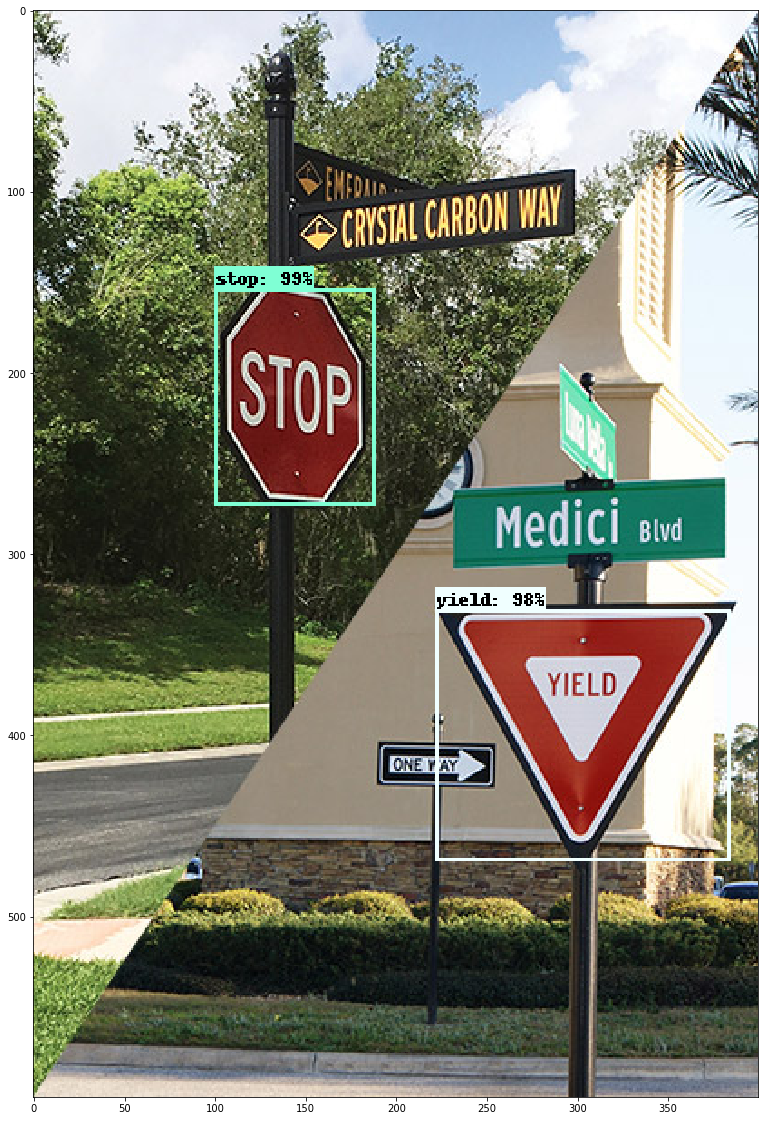

In [56]:
# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
image = cv2.imread(PATH_TO_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw the results of the detection (aka 'visualize the results')

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=2,
    min_score_thresh=0.6)

%matplotlib inline

plt.figure(figsize=(40,20))
plt.imshow(image)